# <center> REVISIONS: CODE ADDED <center>

**Summary:**

This notebook contains the analyses that were added during the reviewing process. It borrows elements from the rest of the notebooks, but it was made so that it can be run completely independently from the others. Some cells can be run locally, but others will create separate python files that were run on a slurm-based HPC.

**SECTIONS:**
-  I) Packages & Functions.
- II) Creation of EIR config files to define CLASTER.
- III) Enhancer-centric perturbational analysis.
- IV) New models and analyses.
- V) Performance evaluations.
- VI) Data distributions.
- VII) Obtain Promoter-Capture Hi-C for mESCs.
- VIII) Perform analyses for K562.


> Notes:
> - We used eir version 0.1.42.
> - We run the models on an A100 GPU.
> - We added the genomic context of the predictions as IGV tracks describing:
>   - Gene annotations (Default IGV annotations for mm10)
>   - Regulatory element annotations: latest ENCODE release fro mm10 candidate Cis-Regulatory Elements (cCREs). Data was obtained from [this download server](https://hgdownload.soe.ucsc.edu/gbdb/mm10/encode3/ccre/)

## I) Packages &  Functions

**Global packages:**

In [ ]:
######### Packages: ########
import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.patches as patches
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import numpy as np
from pathlib import Path
plt.rcParams['font.family'] = 'Nimbus Roman'
from scipy.integrate import simpson
from scipy.stats import pearsonr, spearmanr
import import_ipynb
import claster_utils # Import functions from data analysis notebook
from typing import List, Tuple
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import shutil
import seaborn as sns
import wget
from matplotlib import gridspec
from scipy.ndimage import gaussian_filter

**Old functions:**

These are mostly functions used in the original analyses with slight adaptations.

In [ ]:
track_dict = {0:{"name":"ATAC-seq","function":"Chromatin accessibility","color":"k"},
            1:{"name":"H3K4me3","function":"Promoter","color":"r"},
            2:{"name":"H3K27ac","function":"Enhancer","color":"b"},
            3:{"name":"H3K27me3","function":"Chromatin silencing","color":"g"}}

######### Functions: ########
def visualize_input_array(a,
                     cropped_bins: int = 4800, #4600
                     scaling_factor: float = 1.,
                     track_dict: dict = track_dict):
    """
    Function to visualize an input numpy array with inset zoomed plots.
    """
    # Create single column of plots
    fig, axs = plt.subplots(len(track_dict), 1, figsize=(10,8))
    
    # Handle case where there's only one track (axs would not be array)
    if len(track_dict) == 1:
        axs = [axs]

    # Plot the scaled arrays
    for j, line in enumerate(a):
        # Main plot (full window)
        x_full = np.arange(-len(line)//2, len(line)//2)
        axs[j].plot(x_full, line*scaling_factor, 
                   color=track_dict[j]["color"], 
                   label=track_dict[j]["name"], 
                   lw=.2)
        axs[j].fill_between(x_full, line*scaling_factor, 
                          color=track_dict[j]["color"], 
                          alpha=1)
        axs[j].set_ylabel(track_dict[j]["name"])
        
        # Create inset axes
        inset_ax = inset_axes(axs[j], 
                             width="40%", # width = 30% of parent_bbox
                             height="50%", # height : 30%
                             loc='upper left')
        
        # Plot zoomed data in inset
        x_zoom = x_full[cropped_bins:-cropped_bins]
        y_zoom = line[cropped_bins:-cropped_bins]*scaling_factor
        inset_ax.plot(x_zoom, y_zoom, 
                     color=track_dict[j]["color"], 
                     lw=.2)
        inset_ax.fill_between(x_zoom, y_zoom, 
                            color=track_dict[j]["color"], 
                            alpha=.6)
        inset_ax.set_xlim(x_zoom[0], x_zoom[-1])
        inset_ax.yaxis.tick_right()
        

    # Set the bottom x-label
    axs[-1].set_xlabel("Distance to TSS (hbp)", fontsize=16)

    # Adjust spacing between subplots
    plt.tight_layout()

    return fig

def _get_predictions(
    results_path: Path,
    N_BINS: int,
    condition_list: List[str],
    is_training: bool = False,
    batch_num: str = None,
    CLIP: bool = True
) -> Tuple[List[str], pd.DataFrame, pd.DataFrame]:
    """
    Reads prediction files from EIR for each target bin condition.
    
    Args:
        results_path: Path where the predictions are stored
        N_BINS: Number of bins to one side of the central bin (e.g., 200 or 57 for Enformer)
        condition_list: List of conditions (e.g., ["_ctrl"])
        is_training: If True, uses training file structure, else uses test structure
        batch_num: Batch number for training predictions (e.g., "30300")
        CLIP: If True, applies ReLU to predictions (clips at 0)
    
    Returns:
        Tuple containing:
            - ids: List of sample names
            - predicted: DataFrame of predicted untransformed values
            - actual: DataFrame of actual values
    """
    predicted_dfs = []
    actual_dfs = []
    
    for condition in condition_list:
        for i in range(-N_BINS, N_BINS + 1):
            if is_training:
                if batch_num is None:
                    raise ValueError("batch_num must be specified for training predictions")
                file_path = results_path / f"expression_output/{i}{condition}/samples/{batch_num}/regression_predictions.csv"
            else:
                file_path = results_path / f"expression_output/{i}{condition}/predictions.csv"
            
            if not file_path.exists():
                raise FileNotFoundError(f"Prediction file not found: {file_path}")
                
            predictions = pd.read_csv(file_path).set_index('ID')

            # Apply ReLU to model predictions if specified
            if CLIP:
                predictions = predictions.clip(lower=0)

            # Handle different column names for training vs test
            if is_training:
                predicted_column = predictions["Predicted"].rename(f"{i}{condition}")
                actual_column = predictions["Actual"].rename(f"{i}{condition}")
            else:
                predicted_column = predictions[f"{i}{condition} Untransformed"].rename(f"{i}{condition}")
                actual_column = predictions["True Label Untransformed"].rename(f"{i}{condition}")

            predicted_dfs.append(predicted_column)
            actual_dfs.append(actual_column)

    # Concatenate all DataFrames horizontally
    predicted = pd.concat(predicted_dfs, axis=1)
    actual = pd.concat(actual_dfs, axis=1)
    ids = list(predicted.index)

    return ids, predicted, actual

def plot_target_predictions(line_p, line_a, N_BINS=200):
    """ 
    Plot the predicted profiles. 
    """
    fig, axs =plt.subplots(2, figsize=(8,4), sharex = True)
    axs[0].fill_between(np.arange(-N_BINS,N_BINS+1),line_p, lw=1, color='royalblue',alpha=.3, label="Predicted EU-seq")
    axs[1].fill_between(np.arange(-N_BINS,N_BINS+1),line_a, lw=1, color='silver', alpha=.6, label="EU-seq")          
    axs[1].set_xlabel("Distance from TSS (kbp)", fontsize=12)    
    axs[1].set_xlim(-200,200)  
    fig.legend(ncol=2, fancybox=True, shadow=True, fontsize=8)

    return fig

def plot_generalized_predictions(predictions, actual_data, N_BINS=200):
    """ 
    Plot multiple predicted profiles and actual data.
    
    Parameters:
    predictions: list of dicts, each containing:
        - 'profile': array-like, the prediction data
        - 'color': str, color for the plot
        - 'alpha': float, transparency value
        - 'label': str, label for the legend
    actual_data: dict containing:
        - 'profile': array-like, the actual data
        - 'color': str, default 'silver'
        - 'alpha': float, default 0.6
        - 'label': str, default 'EU-seq'
    """
    # Create figure
    fig, axs = plt.subplots(2, figsize=(8,4), sharex=True)
    
    # Plot all predictions in top subplot
    x_range = np.arange(-N_BINS, N_BINS+1)
    for pred in predictions:
        axs[0].fill_between(x_range,
                           pred['profile'],
                           lw=1,
                           color=pred['color'],
                           alpha=pred['alpha'])
        axs[0].plot(x_range,
                           pred['profile'],
                           lw=1,
                           color=pred['color'],
                           alpha=1,
                           ls=pred['ls'],
                           label=pred['label'])
    
    # Plot actual data in bottom subplot
    for actual in actual_data:
        axs[1].fill_between(x_range,
                            actual['profile'],
                            lw=1,
                            color=actual['color'],
                            alpha=actual['alpha'])
        
        axs[1].plot(x_range,
                    actual['profile'],
                    lw=1,
                    color=actual['color'],
                    ls=actual['ls'],
                    label=actual['label'])
        
    # Set labels and limits
    axs[1].set_xlabel("Distance from TSS (kbp)", fontsize=12)    
    axs[1].set_xlim(-200, 200)
    axs[0].set_ylim(0, 65)
    axs[1].set_ylim(0, 65)
    
    # Add legend
    fig.legend(ncol=2, fancybox=True, shadow=True, fontsize=8, loc='upper center')
    
    return fig

def read_target_attributions(results_path: Path,
                             figure_path: Path,
                             track_dict: dict,
                             N_BINS: int,
                             l_in:int = 10001,
                             n_in: int=4,
                             TRAIN_ATTR: bool = True,
                             SPLIT: int = None):

    """
    This function is aimed to read attribution arrays from the chromatin landscape branch. Attribution arrays score the 
    contribution of each position in the input arrays (4,10.001) towards each output node/position (401).
    Args:
        results_path: path where the attribution arrays are stored.
        figure_path: path where we want to store the outputs
        n_central_bins: number of central bins (from -N_BINS to  N_BINS+1)
        track_dict: dictionary containing the names of the tracks and plot details
        l_in: input length 
        n_out: number of output nodes
        n_in: number of input channels
        TRAIN_ATTR: whether this is a training or test run (folder structure changes).
        SPLIT: if Train, we need to know which of the stored batches it is

    Returns:
        Plots with attribution scores.
    """
    figure_path.mkdir(exist_ok=True, parents=True)

    N_IN_BINS = l_in // 2
    x_val = np.arange(-N_IN_BINS,N_IN_BINS+1)

    xlim = (-500,500)

    # Getting attributions:
    condition_list = ["_ctrl"]
    landscape_avg = {condition : np.zeros((n_in,l_in)) for condition in condition_list}

    for i in range(-N_BINS, N_BINS + 1):
        for condition in condition_list:
            # CHROMATIN MARK ATTRIBUTIONS:
            added_folders = f"/samples/{SPLIT}" if TRAIN_ATTR else "" # Different folder structure
            att_path = Path(results_path / f"{i}{condition}{added_folders}/attributions/gene_expression/{i}{condition}.npy")
            if os.path.exists(att_path):
                attributions = np.load(att_path)
                #if (i == -73) and (condition == "_ctrl"):
                fig, axs = plt.subplots(4, figsize=(8,2.7)) 
                for j,key in enumerate(track_dict.keys()):
                    name = track_dict[key]["name"]
                    axs[j].plot(x_val, abs(attributions[j]), label=name, lw=0, marker='o', markersize=0.8, markeredgecolor="none", color=track_dict[key]["color"])
                    axs[j].set_xlim((-5000,5001))
                    axs[j].set_ylim((0,np.max(attributions[1])))
                    axs[j].set_yticks([])
                    axs[-1].set_yticks([0,np.max(attributions[1])],[0,1])
                fig.savefig(figure_path / f"Chromatin_landscape_attributions_{i}_ctrl.png",dpi=200)
                plt.close(fig)

                # Add a small phase to remove high frequency fluctuations:
                eps = 10*np.random.rand(1)*np.random.choice([-1,1])
                
                centered_attr = np.roll(attributions, -10*i+int(eps),axis=1)
                landscape_avg[condition] += 1/(2*N_BINS + 1)*(abs(centered_attr))

    SCALING_FACTOR = np.max([landscape_avg[cond] for cond in condition_list])

    for condition in condition_list:
        fig, ax = plt.subplots(figsize=(8,2.7))   
        sub_axes = plt.axes([.615, .57, .27, .27])  
        for i,key in enumerate(track_dict.keys()):
            name = track_dict[key]["name"]
            ax.plot(x_val, landscape_avg[condition][i]/SCALING_FACTOR, label=name, lw=0, marker='o', markersize=2, markeredgecolor="none", color=track_dict[key]["color"])
            sub_axes.plot(x_val, landscape_avg[condition][i]/SCALING_FACTOR, label=name, lw=0,marker='o',markersize=.5,markeredgecolor="none", color=track_dict[key]["color"])
        
        #sub_axes.set_xlim(xlim)
        sub_axes.set_xticks(np.arange(-5000,5001,5000),np.arange(-500,501,500))
        sub_axes.set_xlim((-5000,5000))
        sub_axes.set_yticks([])
        ax.set_xlim(xlim)
        ax.set_ylim(0,1) #(0,.002))
        ax.legend(loc='upper left')
        ax.set_ylabel("Attribution score")
        ax.set_xlabel("Distance to the predicted locus (kbp)")
        plt.subplots_adjust(bottom=0.2)
        ax.set_xticks(np.arange(-400,401,100),np.arange(-40,41,10))
        fig.savefig(figure_path / f"Landscape_absolute_average_{condition}.png", dpi=200)
        plt.close(fig)

def read_gene_positions(csv_path, resolution=1):
    """ 
    This function reads a csv containing genes and enhancers (entities), and creates a dictionary with the relative coordinates of
    all entities to the TSS of the reference gene (central gene), which gives name to the sample.

    Args:
        csv_path: path to the csv with ref genes, entities and their relative coordinates.
        resolution: distance unit we want our relative distances to be given with (1-> bp, 1000->kbp)

    Returns:
        pos_dict: dictionary given pos_dict[ref gene][entity_name] = (rel_start, rel_end)
    """
    # Load the results from a CSV file
    df = pd.read_csv(csv_path, sep="\t")
    
    # Initialize the dictionary to store positions
    pos_dict = {}
    
    # Filter the DataFrame to get only gene entities 
    gene_entities = df[df['Entity_ID'].str.startswith('ENSMUSG')]  # Adjust the condition according to your data
    
    for _, row in gene_entities.iterrows():
        ref_gene_id = row['Ref_gene']
        entity_id = row['Entity_ID']
        rel_start = int(round(row['Entity_rel_Start'] / resolution))
        rel_end = int(round(row['Entity_rel_End'] / resolution))
        
        # Ensure the dictionary has the necessary structure
        if ref_gene_id+'_forward' not in pos_dict:
            pos_dict[ref_gene_id+'_forward'] = {}
        
        # Store the scaled and rounded start and end positions
        pos_dict[ref_gene_id+'_forward'][entity_id+'_forward'] = [rel_start, rel_end]
    
    return pos_dict

def calculate_area_gene(line_p, line_a, ID, pos_dict, N_BINS):
    """ 
    Args:
        line_p: vector of predicted values
        line_a: vector of actual values
        ID: reference gene, i.e. sample name
        pos_dict: dictionary with relative gene coordinates
        N_BINS: which length do we set as a threshold to integrate (in the new resolution).
    """
    seq_center = int(len(line_p)//2)
    rel_start = seq_center + pos_dict[ID][ID][0] if (seq_center + pos_dict[ID][ID][0]) > 0 else 0
    rel_end = seq_center + pos_dict[ID][ID][1] if (seq_center + pos_dict[ID][ID][1]) < 2*N_BINS+1 else 2*N_BINS+1

    WIDTH = max(1, int(rel_end - rel_start))

    # Appending area
    if rel_start != rel_end:
        pred_area = simpson(line_p[rel_start:rel_end])/WIDTH
        actual_area = simpson(line_a[rel_start:rel_end])/WIDTH

    else: # Annotation is shorter than bin_width:
        pred_area = line_p[seq_center]
        actual_area = line_a[seq_center]

    return pred_area, actual_area, rel_start, rel_end

def calculate_correlations(results_path: Path, gene_pos_path: Path, figure_path: Path, input_table_path: Path,  N_BINS: int = 200, condition_list = ["_ctrl"], resolution: int = 1000, is_training: bool=False, batch_num: str = None, CLIP: bool=True ):
    """
    This function returns a set of dictionaries containing the actual EU-seq values and the predicted values. 
    This is done both on a bin by bin basis and integrated over the target gene length (normalized by gene length).
    """

    # Storing gene position's dict:
    pos_dict = read_gene_positions(gene_pos_path, resolution)
    ids, predicted, actual = _get_predictions(results_path, N_BINS, condition_list,is_training=is_training,batch_num=batch_num, CLIP=CLIP)
    df = pd.read_csv(input_table_path)

    # Normalized Area per bin for the target gene (central gene in observation window)
    pred_list_A_per_bin_dict = {}
    actual_list_A_per_bin_dict = {}

    # Predicted and actual EU-seq values in all positions:
    pred_list_values_dict = {}
    actual_list_values_dict = {}

    for condition in condition_list:
        pred_list_A_per_bin_dict[condition] = []
        actual_list_A_per_bin_dict[condition] = []
        pred_list_values_dict[condition] = []
        actual_list_values_dict[condition] = []

    for ID,line_p,line_a in zip(ids,predicted.values,actual.values):
        if ("_rev" not in ID): #Only add the forward strand to the analyses
            for condition in condition_list:
                # Extend binwise prediction and target lists
                pred_list_values_dict[condition].extend(list(line_p))
                actual_list_values_dict[condition].extend(list(line_a))

                # Extend area predictions
                pred_area, actual_area, rel_start, rel_end = calculate_area_gene(line_p, line_a, ID, pos_dict, N_BINS)

                pred_list_A_per_bin_dict[condition].extend([pred_area])
                actual_list_A_per_bin_dict[condition].extend([actual_area])

                # Adding area to extended table:
                gene = ID.split('_')[0]
                df.loc[(df['Ref_gene'] == gene) & (df['Entity_ID'] == gene),'Area'] = pred_area #Edit existing table

            PLOT = True
            ID_LIST = ["ENSMUSG00000078673.10_forward","ENSMUSG00000067261.4_forward","ENSMUSG00000028234.6_forward","ENSMUSG00000028280.9_forward","ENSMUSG00000035969.15_forward"]
            if PLOT and (ID in ID_LIST):
                fig = plot_target_predictions(line_p, line_a, N_BINS) 
                fig.savefig(figure_path / f'{ID}.png', dpi=200)

    df.to_csv(input_table_path, index=False)

    return pred_list_A_per_bin_dict, actual_list_A_per_bin_dict, pred_list_values_dict, actual_list_values_dict

def plot_correlations(figure_path: Path, pred_list_values: list, actual_list_values: list, title: str, cmap: colors.Colormap = "afmhot", binlims: tuple = (0,50), density: bool =True, DELTA:bool=False, min_val: float = .0, max_val: int = 10):
    """ 
    This function plots predicted vs. actual values and provides the Spearman and Pearson correlations of the regressions. 
    The style of the plot changes depending on whether the predictions are at a bin level or a gene level.
    """
    # Get the counts histogram to plot correlation with density colormap
    counts, xedges, yedges, _ = plt.hist2d(actual_list_values,pred_list_values, bins=[np.linspace(binlims[0],binlims[1],200),np.linspace(binlims[0],binlims[1],200)], density=False)

    # Plot regression of single predicted values vs. real
    pearson_r = pearsonr(actual_list_values,pred_list_values)[0]
    spearman_r = spearmanr(actual_list_values,pred_list_values)[0]
    m, b = np.polyfit(actual_list_values, pred_list_values, deg=1)
    # Actual fit:
    a1, a2, a3 = np.polyfit(actual_list_values, pred_list_values, deg=2)
    # Regression from origin:
    #m_0 , _, _, _ = np.linalg.lstsq(np.array(actual_list_values)[:,np.newaxis], pred_list_values) #x needs to be a column vector for this function

    # Create the figure
    fig, ax = plt.subplots(figsize=(4,4))    
    if density:
        eps= 1
        # Counts matrix is transposed: the origin convention for plt.imshow is (top, left), for plt.hist2D is (bottom,left)
        counts[counts < eps] =1
        hist = ax.imshow(counts.T, origin='lower', extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], cmap=cmap,  norm=colors.LogNorm())
        _ = fig.colorbar(hist)
        _ = ax.axline(xy1=(0, b), slope=m, label=f'Linear fit:\n$ y = {m:.3f}x {b:+.3f}$\n$r_p:{pearson_r:.4f}$\n$r_s:{spearman_r:.4f}$', color="royalblue", ls="-", lw=1)
        #_ = ax.plot(np.arange(min_val,max_val,step), a1*(np.arange(min_val,max_val,step)**2)+a2*(np.arange(min_val,max_val,step))+a3, color='royalblue', ls = "--", lw=1, label= f"Polynomial fit:\n$y={a1:.3f}x^2+{a2:.3f}x+{a3:.3f}$")
        _ = ax.axis("scaled")
        _ = ax.set_xlim(min_val,max_val)
        _ = ax.set_ylim(min_val,max_val)
        _ = ax.set_xlabel("log$_2$(True +1)")
        _ = ax.set_ylabel("log$_2$(Predicted +1)")
        fig.legend(bbox_to_anchor=(.48,.8), fancybox=True, shadow=False, fontsize=7)
    else:
        _ = ax.plot(actual_list_values,pred_list_values, lw=0, marker='o',  markersize=1, markeredgewidth=0, color='k')
        _ = ax.axis("scaled")
        _ = ax.axline(xy1=(0, b), slope=m, label=f'Linear fit:\n$ y = {m:.3f}x {b:+.3f}$\n$r_p:{pearson_r:.4f}$\n$r_s:{spearman_r:.4f}$', color="royalblue", ls="-", lw=1)
        #ax.plot(np.arange(-20,200,1), a1*(np.arange(-20,200,1)**2)+a2*(np.arange(-20,200,1))+a3, color='royalblue', ls = "--", lw=1, label= f"Polynomial fit:\n$y={a1:.3f}x^2+{a2:.3f}x{a3:.3f}$")
        if DELTA:
            _ = ax.set_xlim(-20,20)
            _ = ax.set_ylim(-20, 20)
            _ = ax.set_xlabel("Actual $\Delta_{exp}$  (reads/kbp)")
            _ = ax.set_ylabel("Predicted $\Delta_{exp}$ (reads/kbp)")
            fig.legend(bbox_to_anchor=(.53,.87), fancybox=True, shadow=True, fontsize=8)
        else:
            _ = ax.set_xlim(0,200)
            _ = ax.set_ylim(0, 200)
            _ = ax.set_xlabel("Actual averaged expression (reads/kbp)")
            _ = ax.set_ylabel("Predicted averaged expression (reads/kbp)")
            fig.legend(bbox_to_anchor=(.53,.87), fancybox=True, shadow=True, fontsize=8)

    #ax.plot(np.arange(0,500,1), np.arange(0,500,1), color='k', ls = "dashed", lw=1)

    fig.savefig(figure_path / f"Regression_histogram_{title}.png", dpi=200, bbox_inches='tight')
    plt.close(fig)
    
def r2_score_computed(targets, outputs):
    """
    Function to compute R2 coefficient between predictions and targets.
    This allows for all operations to happen in the GPU )if available)
    without moving back and forth to the CPU.
    """
    target_mean = np.mean(targets)
    ss_tot = np.sum((targets - target_mean) ** 2)
    ss_res = np.sum((targets - outputs) ** 2)
    r2 = 1 - ss_res / ss_tot
    return r2

def download_files(links, destination_folder):
    """
    This function downloads the files in links and stores them in destination_folder.
    Args:
        links: dictionary where keys are file names and values are links.
        destination_folder: path where we'll store the files.
    """
    for name,link in links.items():
        try:
            # Ensure the destination folder exists
            if not os.path.exists(destination_folder):
                os.makedirs(destination_folder)

            # Specify the output path for the downloaded file
            output_path = os.path.join(destination_folder, name)

            # Download the file to the specified destination folder
            wget.download(link, out=output_path)
            print(f"\nSuccessfully downloaded {name} to {destination_folder}")
        except Exception as e:
            print(f"\nFailed to download {link} because : {e}")


## II) Creation of EIR config files to define CLASTER

This cell writes all config files at once, easing reproducibility.

In [ ]:
config_paths = [Path("../configurations/conf_pure_conv_predict_prom/"), #0
                Path("../configurations/conf_pure_conv_20kbp_context/"), #1
                Path("../configurations/conf_pure_conv_softplus_no_bias/"), #2
                Path("../configurations/conf_pure_conv_softplus_poisson/"),#3
                Path("../configurations/conf_pure_conv_20kbp_context_test/"),#4
                Path("../configurations/conf_pure_conv_chr19_holdout_train/"),#5
                Path("../configurations/conf_pure_conv_chr19_holdout_test/"),#6
                Path("../configurations/conf_pure_conv_no_H3K27ac_train/"),#7
                Path("../configurations/conf_pure_conv_no_H3K27ac_test/"),#8
                Path("../configurations/conf_pure_conv_20kbp_context_test/"),#9
                Path("../configurations/conf_pure_conv_1kbp_binning_train/"),#10
                Path("../configurations/conf_pure_conv_1kbp_binning_test/"),#11
                Path("../configurations/conf_pure_conv_chr19_enhancer_centric/"),#12
                Path("../configurations/conf_pure_conv_K562_train/"),#13
                Path("../configurations/conf_pure_conv_K562_test/"),#14
                Path("../configurations/conf_pure_conv_prom_CHiC_train/"), # 15
                Path("../configurations/conf_pure_conv_prom_CHiC_test/"), # 16
                Path("../configurations/conf_pure_conv_K562_POLR2A_train/"),#17
                Path("../configurations/conf_pure_conv_K562_POLR2A_enhancer_centric/"),#18
                Path("../configurations/conf_pure_conv_K562_RNA_enhancer_centric/"),#19
                ]
               
for config_path in config_paths:
  config_path.mkdir(parents=True, exist_ok=True)

predict_prom_yaml_contents = {"fusion.yaml":"""  
model_config:
  fc_do: 0.4
  fc_task_dim: 256
  layers:
  - 2
  rb_do: 0.4
  stochastic_depth_p: 0.5
model_type: "mlp-residual"
""",
"globals.yaml": """
checkpoint_interval: 30300 # 100 epochs #60000
sample_interval: 30300 #60000
n_epochs: 120
batch_size: 64
optimizer: "adamw"
lr: 0.0001 #0.0001
device: "cuda"
compute_attributions: false

""",
"input_cnn.yaml": """
input_info:
  input_source: ./inputs/perturbed_landscape_arrays/inserted_promoter_arrays/  #inserted_enhancer_test #inputs/silenced_arrays/silenced_arrays_H2B_S.D 
  #./data/parsed_data/inputs/arrays_train_100bp_no_H3K27ac/ #arrays_train_100bp_no_H3K27ac_uncoupled/
  input_name: gene_expression
  input_type: array

model_config:
  model_type: cnn
  #pre_normalization: "instancenorm"
  model_init_config:
    num_output_features: 512 # before fc_repr_dim
    layers: [4,4]
    kernel_height: 1
    down_stride_width: 2
    first_stride_expansion_width: 1
    first_kernel_expansion_height: 4 #5
    kernel_width: 10  #10
    dilation_factor_width: 2
    dilation_factor_height: 1
    channel_exp_base: 5  #3 #-1
    first_channel_expansion: 2
    rb_do: .3
    stochastic_depth_p: .1
    attention_inclusion_cutoff: 1 #50 #256
    """,
"outputs_2_cond.yaml": """
output_info:
  output_name: expression_output
  output_source: ./targets/prom_perturbed_targets.csv 
  #./data/parsed_data/targets/target_arrays_perturbational_inserted_enhancer.csv #target_arrays_perturbational_S.D.csv #target_arrays_1kbp_401_bins_2_conditions_decareads_abs.csv
  output_type: tabular

model_config: # <- new
  model_type: linear # <- new

output_type_info:
  con_loss_name: "SmoothL1Loss"
  target_con_columns:
  - "-200_ctrl"
  - "-199_ctrl"
  - "-198_ctrl"
  - "-197_ctrl"
  - "-196_ctrl"
  - "-195_ctrl"
  - "-194_ctrl"
  - "-193_ctrl"
  - "-192_ctrl"
  - "-191_ctrl"
  - "-190_ctrl"
  - "-189_ctrl"
  - "-188_ctrl"
  - "-187_ctrl"
  - "-186_ctrl"
  - "-185_ctrl"
  - "-184_ctrl"
  - "-183_ctrl"
  - "-182_ctrl"
  - "-181_ctrl"
  - "-180_ctrl"
  - "-179_ctrl"
  - "-178_ctrl"
  - "-177_ctrl"
  - "-176_ctrl"
  - "-175_ctrl"
  - "-174_ctrl"
  - "-173_ctrl"
  - "-172_ctrl"
  - "-171_ctrl"
  - "-170_ctrl"
  - "-169_ctrl"
  - "-168_ctrl"
  - "-167_ctrl"
  - "-166_ctrl"
  - "-165_ctrl"
  - "-164_ctrl"
  - "-163_ctrl"
  - "-162_ctrl"
  - "-161_ctrl"
  - "-160_ctrl"
  - "-159_ctrl"
  - "-158_ctrl"
  - "-157_ctrl"
  - "-156_ctrl"
  - "-155_ctrl"
  - "-154_ctrl"
  - "-153_ctrl"
  - "-152_ctrl"
  - "-151_ctrl"
  - "-150_ctrl"
  - "-149_ctrl"
  - "-148_ctrl"
  - "-147_ctrl"
  - "-146_ctrl"
  - "-145_ctrl"
  - "-144_ctrl"
  - "-143_ctrl"
  - "-142_ctrl"
  - "-141_ctrl"
  - "-140_ctrl"
  - "-139_ctrl"
  - "-138_ctrl"
  - "-137_ctrl"
  - "-136_ctrl"
  - "-135_ctrl"
  - "-134_ctrl"
  - "-133_ctrl"
  - "-132_ctrl"
  - "-131_ctrl"
  - "-130_ctrl"
  - "-129_ctrl"
  - "-128_ctrl"
  - "-127_ctrl"
  - "-126_ctrl"
  - "-125_ctrl"
  - "-124_ctrl"
  - "-123_ctrl"
  - "-122_ctrl"
  - "-121_ctrl"
  - "-120_ctrl"
  - "-119_ctrl"
  - "-118_ctrl"
  - "-117_ctrl"
  - "-116_ctrl"
  - "-115_ctrl"
  - "-114_ctrl"
  - "-113_ctrl"
  - "-112_ctrl"
  - "-111_ctrl"
  - "-110_ctrl"
  - "-109_ctrl"
  - "-108_ctrl"
  - "-107_ctrl"
  - "-106_ctrl"
  - "-105_ctrl"
  - "-104_ctrl"
  - "-103_ctrl"
  - "-102_ctrl"
  - "-101_ctrl"
  - "-100_ctrl"
  - "-99_ctrl"
  - "-98_ctrl"
  - "-97_ctrl"
  - "-96_ctrl"
  - "-95_ctrl"
  - "-94_ctrl"
  - "-93_ctrl"
  - "-92_ctrl"
  - "-91_ctrl"
  - "-90_ctrl"
  - "-89_ctrl"
  - "-88_ctrl"
  - "-87_ctrl"
  - "-86_ctrl"
  - "-85_ctrl"
  - "-84_ctrl"
  - "-83_ctrl"
  - "-82_ctrl"
  - "-81_ctrl"
  - "-80_ctrl"
  - "-79_ctrl"
  - "-78_ctrl"
  - "-77_ctrl"
  - "-76_ctrl"
  - "-75_ctrl"
  - "-74_ctrl"
  - "-73_ctrl"
  - "-72_ctrl"
  - "-71_ctrl"
  - "-70_ctrl"
  - "-69_ctrl"
  - "-68_ctrl"
  - "-67_ctrl"
  - "-66_ctrl"
  - "-65_ctrl"
  - "-64_ctrl"
  - "-63_ctrl"
  - "-62_ctrl"
  - "-61_ctrl"
  - "-60_ctrl"
  - "-59_ctrl"
  - "-58_ctrl"
  - "-57_ctrl"
  - "-56_ctrl"
  - "-55_ctrl"
  - "-54_ctrl"
  - "-53_ctrl"
  - "-52_ctrl"
  - "-51_ctrl"
  - "-50_ctrl"
  - "-49_ctrl"
  - "-48_ctrl"
  - "-47_ctrl"
  - "-46_ctrl"
  - "-45_ctrl"
  - "-44_ctrl"
  - "-43_ctrl"
  - "-42_ctrl"
  - "-41_ctrl"
  - "-40_ctrl"
  - "-39_ctrl"
  - "-38_ctrl"
  - "-37_ctrl"
  - "-36_ctrl"
  - "-35_ctrl"
  - "-34_ctrl"
  - "-33_ctrl"
  - "-32_ctrl"
  - "-31_ctrl"
  - "-30_ctrl"
  - "-29_ctrl"
  - "-28_ctrl"
  - "-27_ctrl"
  - "-26_ctrl"
  - "-25_ctrl"
  - "-24_ctrl"
  - "-23_ctrl"
  - "-22_ctrl"
  - "-21_ctrl"
  - "-20_ctrl"
  - "-19_ctrl"
  - "-18_ctrl"
  - "-17_ctrl"
  - "-16_ctrl"
  - "-15_ctrl"
  - "-14_ctrl"
  - "-13_ctrl"
  - "-12_ctrl"
  - "-11_ctrl"
  - "-10_ctrl"
  - "-9_ctrl"
  - "-8_ctrl"
  - "-7_ctrl"
  - "-6_ctrl"
  - "-5_ctrl"
  - "-4_ctrl"
  - "-3_ctrl"
  - "-2_ctrl"
  - "-1_ctrl"
  - "0_ctrl"
  - "1_ctrl"
  - "2_ctrl"
  - "3_ctrl"
  - "4_ctrl"
  - "5_ctrl"
  - "6_ctrl"
  - "7_ctrl"
  - "8_ctrl"
  - "9_ctrl"
  - "10_ctrl"
  - "11_ctrl"
  - "12_ctrl"
  - "13_ctrl"
  - "14_ctrl"
  - "15_ctrl"
  - "16_ctrl"
  - "17_ctrl"
  - "18_ctrl"
  - "19_ctrl"
  - "20_ctrl"
  - "21_ctrl"
  - "22_ctrl"
  - "23_ctrl"
  - "24_ctrl"
  - "25_ctrl"
  - "26_ctrl"
  - "27_ctrl"
  - "28_ctrl"
  - "29_ctrl"
  - "30_ctrl"
  - "31_ctrl"
  - "32_ctrl"
  - "33_ctrl"
  - "34_ctrl"
  - "35_ctrl"
  - "36_ctrl"
  - "37_ctrl"
  - "38_ctrl"
  - "39_ctrl"
  - "40_ctrl"
  - "41_ctrl"
  - "42_ctrl"
  - "43_ctrl"
  - "44_ctrl"
  - "45_ctrl"
  - "46_ctrl"
  - "47_ctrl"
  - "48_ctrl"
  - "49_ctrl"
  - "50_ctrl"
  - "51_ctrl"
  - "52_ctrl"
  - "53_ctrl"
  - "54_ctrl"
  - "55_ctrl"
  - "56_ctrl"
  - "57_ctrl"
  - "58_ctrl"
  - "59_ctrl"
  - "60_ctrl"
  - "61_ctrl"
  - "62_ctrl"
  - "63_ctrl"
  - "64_ctrl"
  - "65_ctrl"
  - "66_ctrl"
  - "67_ctrl"
  - "68_ctrl"
  - "69_ctrl"
  - "70_ctrl"
  - "71_ctrl"
  - "72_ctrl"
  - "73_ctrl"
  - "74_ctrl"
  - "75_ctrl"
  - "76_ctrl"
  - "77_ctrl"
  - "78_ctrl"
  - "79_ctrl"
  - "80_ctrl"
  - "81_ctrl"
  - "82_ctrl"
  - "83_ctrl"
  - "84_ctrl"
  - "85_ctrl"
  - "86_ctrl"
  - "87_ctrl"
  - "88_ctrl"
  - "89_ctrl"
  - "90_ctrl"
  - "91_ctrl"
  - "92_ctrl"
  - "93_ctrl"
  - "94_ctrl"
  - "95_ctrl"
  - "96_ctrl"
  - "97_ctrl"
  - "98_ctrl"
  - "99_ctrl"
  - "100_ctrl"
  - "101_ctrl"
  - "102_ctrl"
  - "103_ctrl"
  - "104_ctrl"
  - "105_ctrl"
  - "106_ctrl"
  - "107_ctrl"
  - "108_ctrl"
  - "109_ctrl"
  - "110_ctrl"
  - "111_ctrl"
  - "112_ctrl"
  - "113_ctrl"
  - "114_ctrl"
  - "115_ctrl"
  - "116_ctrl"
  - "117_ctrl"
  - "118_ctrl"
  - "119_ctrl"
  - "120_ctrl"
  - "121_ctrl"
  - "122_ctrl"
  - "123_ctrl"
  - "124_ctrl"
  - "125_ctrl"
  - "126_ctrl"
  - "127_ctrl"
  - "128_ctrl"
  - "129_ctrl"
  - "130_ctrl"
  - "131_ctrl"
  - "132_ctrl"
  - "133_ctrl"
  - "134_ctrl"
  - "135_ctrl"
  - "136_ctrl"
  - "137_ctrl"
  - "138_ctrl"
  - "139_ctrl"
  - "140_ctrl"
  - "141_ctrl"
  - "142_ctrl"
  - "143_ctrl"
  - "144_ctrl"
  - "145_ctrl"
  - "146_ctrl"
  - "147_ctrl"
  - "148_ctrl"
  - "149_ctrl"
  - "150_ctrl"
  - "151_ctrl"
  - "152_ctrl"
  - "153_ctrl"
  - "154_ctrl"
  - "155_ctrl"
  - "156_ctrl"
  - "157_ctrl"
  - "158_ctrl"
  - "159_ctrl"
  - "160_ctrl"
  - "161_ctrl"
  - "162_ctrl"
  - "163_ctrl"
  - "164_ctrl"
  - "165_ctrl"
  - "166_ctrl"
  - "167_ctrl"
  - "168_ctrl"
  - "169_ctrl"
  - "170_ctrl"
  - "171_ctrl"
  - "172_ctrl"
  - "173_ctrl"
  - "174_ctrl"
  - "175_ctrl"
  - "176_ctrl"
  - "177_ctrl"
  - "178_ctrl"
  - "179_ctrl"
  - "180_ctrl"
  - "181_ctrl"
  - "182_ctrl"
  - "183_ctrl"
  - "184_ctrl"
  - "185_ctrl"
  - "186_ctrl"
  - "187_ctrl"
  - "188_ctrl"
  - "189_ctrl"
  - "190_ctrl"
  - "191_ctrl"
  - "192_ctrl"
  - "193_ctrl"
  - "194_ctrl"
  - "195_ctrl"
  - "196_ctrl"
  - "197_ctrl"
  - "198_ctrl"
  - "199_ctrl"
  - "200_ctrl"
  """ }

training_20kbp_yaml_contents = {"globals.yaml":"""
output_folder: ./runs/gene_expression_only_chrom_pure_conv_20kbp_context/  #gene_expression_prediction_no_H3K27ac_uncoupled/     #gene_expression_cnn_1kbp_401_bins_2_cond_reloaded/ 
manual_valid_ids_file: ./annotations/manual_validation_ids_chr17.txt  #manual_validation_ids_chr17_uncoupled.txt
checkpoint_interval: 30300 # 100 epochs is 30300 #60000
sample_interval: 30300 #60000
n_epochs: 120
batch_size: 64
optimizer: "adamw"
lr: 0.0001 #0.0001
device: "cuda"
compute_attributions: true
""",
"input_cnn.yaml": """ 
input_info:
  input_source: ./inputs/landscape_arrays/training_20kbp_context/ 
  input_name: gene_expression
  input_type: array

model_config:
  model_type: cnn
  #pre_normalization: "instancenorm"
  model_init_config:
    num_output_features: 512 # before fc_repr_dim
    layers: [1,1]
    kernel_height: 1
    down_stride_width: 2
    first_stride_expansion_width: 1
    first_kernel_expansion_height: 4 #5
    kernel_width: 10  #10
    dilation_factor_width: 2
    dilation_factor_height: 1
    channel_exp_base: 5  #3 #-1
    first_channel_expansion: 2
    rb_do: .3
    stochastic_depth_p: .1
    attention_inclusion_cutoff: 1 #50 #256

""",
"fusion.yaml": """
model_config:
  fc_do: 0.4
  fc_task_dim: 256
  layers:
  - 1
  rb_do: 0.4
  stochastic_depth_p: 0.5
model_type: "mlp-residual"
""",
"outputs_2_cond.yaml":"""
output_info:
  output_name: expression_output
  output_source: ./targets/training_targets.csv 
  output_type: tabular

model_config: # <- new
  model_type: linear # <- new

output_type_info:
  con_loss_name: "SmoothL1Loss"
  target_con_columns:
  - "-9_ctrl"
  - "-8_ctrl"
  - "-7_ctrl"
  - "-6_ctrl"
  - "-5_ctrl"
  - "-4_ctrl"
  - "-3_ctrl"
  - "-2_ctrl"
  - "-1_ctrl"
  - "0_ctrl"
  - "1_ctrl"
  - "2_ctrl"
  - "3_ctrl"
  - "4_ctrl"
  - "5_ctrl"
  - "6_ctrl"
  - "7_ctrl"
  - "8_ctrl"
  - "9_ctrl"
  """
}

training_softplus_contents = {"globals.yaml":"""
output_folder: ./runs/gene_expression_only_chrom_pure_conv_softplus_no_bias/ 
manual_valid_ids_file: ./annotations/manual_validation_ids_chr17.txt  #manual_validation_ids_chr17_uncoupled.txt
checkpoint_interval: 30300 # 100 epochs #60000
sample_interval: 30300 #60000
n_epochs: 120
batch_size: 64
optimizer: "adamw"
lr: 0.0001 #0.0001
device: "cuda"
compute_attributions: false
# latent_sampling: 
#   layers_to_sample:
#     - "input_modules.contact_maps.feature_extractor.conv.0.conv_1"
#     - "input_modules.contact_maps.feature_extractor.conv.1.conv_2"
#     - "input_modules.contact_maps.feature_extractor.conv.2.conv_2"
#     - "input_modules.contact_maps.feature_extractor.conv.3.conv_2"
# attribution_background_samples: 512
# attributions_every_sample_factor: 1
#pretrained_checkpoint: best_models/gene_expression_exformer_unlimited_chrom_and_micro_with_attention_model_117600_perf-average=0.8435.pt 

""",
"input_cnn.yaml": """ 
input_info:
  input_source: ./inputs/landscape_arrays/training/ 
  input_name: gene_expression
  input_type: array

model_config:
  model_type: cnn
  #pre_normalization: "instancenorm"
  model_init_config:
    num_output_features: 512 # before fc_repr_dim
    layers: [4,4]
    kernel_height: 1
    down_stride_width: 2
    first_stride_expansion_width: 1
    first_kernel_expansion_height: 4 #5
    kernel_width: 10  #10
    dilation_factor_width: 2
    dilation_factor_height: 1
    channel_exp_base: 5  #3 #-1
    first_channel_expansion: 2
    rb_do: .3
    stochastic_depth_p: .1
    attention_inclusion_cutoff: 1 #50 #256

""",
"fusion.yaml": """
model_config:
  fc_do: 0.4
  fc_task_dim: 256
  layers:
  - 2
  rb_do: 0.4
  stochastic_depth_p: 0.5
model_type: "mlp-residual"
""",
"outputs_2_cond.yaml":"""
output_info:
  output_name: expression_output
  output_source: ./targets/training_targets.csv 
  output_type: tabular

model_config: # <- new
  model_type: linear # <- new

output_type_info:
  con_loss_name: "SmoothL1Loss"
  target_con_columns:
  - "-200_ctrl"
  - "-199_ctrl"
  - "-198_ctrl"
  - "-197_ctrl"
  - "-196_ctrl"
  - "-195_ctrl"
  - "-194_ctrl"
  - "-193_ctrl"
  - "-192_ctrl"
  - "-191_ctrl"
  - "-190_ctrl"
  - "-189_ctrl"
  - "-188_ctrl"
  - "-187_ctrl"
  - "-186_ctrl"
  - "-185_ctrl"
  - "-184_ctrl"
  - "-183_ctrl"
  - "-182_ctrl"
  - "-181_ctrl"
  - "-180_ctrl"
  - "-179_ctrl"
  - "-178_ctrl"
  - "-177_ctrl"
  - "-176_ctrl"
  - "-175_ctrl"
  - "-174_ctrl"
  - "-173_ctrl"
  - "-172_ctrl"
  - "-171_ctrl"
  - "-170_ctrl"
  - "-169_ctrl"
  - "-168_ctrl"
  - "-167_ctrl"
  - "-166_ctrl"
  - "-165_ctrl"
  - "-164_ctrl"
  - "-163_ctrl"
  - "-162_ctrl"
  - "-161_ctrl"
  - "-160_ctrl"
  - "-159_ctrl"
  - "-158_ctrl"
  - "-157_ctrl"
  - "-156_ctrl"
  - "-155_ctrl"
  - "-154_ctrl"
  - "-153_ctrl"
  - "-152_ctrl"
  - "-151_ctrl"
  - "-150_ctrl"
  - "-149_ctrl"
  - "-148_ctrl"
  - "-147_ctrl"
  - "-146_ctrl"
  - "-145_ctrl"
  - "-144_ctrl"
  - "-143_ctrl"
  - "-142_ctrl"
  - "-141_ctrl"
  - "-140_ctrl"
  - "-139_ctrl"
  - "-138_ctrl"
  - "-137_ctrl"
  - "-136_ctrl"
  - "-135_ctrl"
  - "-134_ctrl"
  - "-133_ctrl"
  - "-132_ctrl"
  - "-131_ctrl"
  - "-130_ctrl"
  - "-129_ctrl"
  - "-128_ctrl"
  - "-127_ctrl"
  - "-126_ctrl"
  - "-125_ctrl"
  - "-124_ctrl"
  - "-123_ctrl"
  - "-122_ctrl"
  - "-121_ctrl"
  - "-120_ctrl"
  - "-119_ctrl"
  - "-118_ctrl"
  - "-117_ctrl"
  - "-116_ctrl"
  - "-115_ctrl"
  - "-114_ctrl"
  - "-113_ctrl"
  - "-112_ctrl"
  - "-111_ctrl"
  - "-110_ctrl"
  - "-109_ctrl"
  - "-108_ctrl"
  - "-107_ctrl"
  - "-106_ctrl"
  - "-105_ctrl"
  - "-104_ctrl"
  - "-103_ctrl"
  - "-102_ctrl"
  - "-101_ctrl"
  - "-100_ctrl"
  - "-99_ctrl"
  - "-98_ctrl"
  - "-97_ctrl"
  - "-96_ctrl"
  - "-95_ctrl"
  - "-94_ctrl"
  - "-93_ctrl"
  - "-92_ctrl"
  - "-91_ctrl"
  - "-90_ctrl"
  - "-89_ctrl"
  - "-88_ctrl"
  - "-87_ctrl"
  - "-86_ctrl"
  - "-85_ctrl"
  - "-84_ctrl"
  - "-83_ctrl"
  - "-82_ctrl"
  - "-81_ctrl"
  - "-80_ctrl"
  - "-79_ctrl"
  - "-78_ctrl"
  - "-77_ctrl"
  - "-76_ctrl"
  - "-75_ctrl"
  - "-74_ctrl"
  - "-73_ctrl"
  - "-72_ctrl"
  - "-71_ctrl"
  - "-70_ctrl"
  - "-69_ctrl"
  - "-68_ctrl"
  - "-67_ctrl"
  - "-66_ctrl"
  - "-65_ctrl"
  - "-64_ctrl"
  - "-63_ctrl"
  - "-62_ctrl"
  - "-61_ctrl"
  - "-60_ctrl"
  - "-59_ctrl"
  - "-58_ctrl"
  - "-57_ctrl"
  - "-56_ctrl"
  - "-55_ctrl"
  - "-54_ctrl"
  - "-53_ctrl"
  - "-52_ctrl"
  - "-51_ctrl"
  - "-50_ctrl"
  - "-49_ctrl"
  - "-48_ctrl"
  - "-47_ctrl"
  - "-46_ctrl"
  - "-45_ctrl"
  - "-44_ctrl"
  - "-43_ctrl"
  - "-42_ctrl"
  - "-41_ctrl"
  - "-40_ctrl"
  - "-39_ctrl"
  - "-38_ctrl"
  - "-37_ctrl"
  - "-36_ctrl"
  - "-35_ctrl"
  - "-34_ctrl"
  - "-33_ctrl"
  - "-32_ctrl"
  - "-31_ctrl"
  - "-30_ctrl"
  - "-29_ctrl"
  - "-28_ctrl"
  - "-27_ctrl"
  - "-26_ctrl"
  - "-25_ctrl"
  - "-24_ctrl"
  - "-23_ctrl"
  - "-22_ctrl"
  - "-21_ctrl"
  - "-20_ctrl"
  - "-19_ctrl"
  - "-18_ctrl"
  - "-17_ctrl"
  - "-16_ctrl"
  - "-15_ctrl"
  - "-14_ctrl"
  - "-13_ctrl"
  - "-12_ctrl"
  - "-11_ctrl"
  - "-10_ctrl"
  - "-9_ctrl"
  - "-8_ctrl"
  - "-7_ctrl"
  - "-6_ctrl"
  - "-5_ctrl"
  - "-4_ctrl"
  - "-3_ctrl"
  - "-2_ctrl"
  - "-1_ctrl"
  - "0_ctrl"
  - "1_ctrl"
  - "2_ctrl"
  - "3_ctrl"
  - "4_ctrl"
  - "5_ctrl"
  - "6_ctrl"
  - "7_ctrl"
  - "8_ctrl"
  - "9_ctrl"
  - "10_ctrl"
  - "11_ctrl"
  - "12_ctrl"
  - "13_ctrl"
  - "14_ctrl"
  - "15_ctrl"
  - "16_ctrl"
  - "17_ctrl"
  - "18_ctrl"
  - "19_ctrl"
  - "20_ctrl"
  - "21_ctrl"
  - "22_ctrl"
  - "23_ctrl"
  - "24_ctrl"
  - "25_ctrl"
  - "26_ctrl"
  - "27_ctrl"
  - "28_ctrl"
  - "29_ctrl"
  - "30_ctrl"
  - "31_ctrl"
  - "32_ctrl"
  - "33_ctrl"
  - "34_ctrl"
  - "35_ctrl"
  - "36_ctrl"
  - "37_ctrl"
  - "38_ctrl"
  - "39_ctrl"
  - "40_ctrl"
  - "41_ctrl"
  - "42_ctrl"
  - "43_ctrl"
  - "44_ctrl"
  - "45_ctrl"
  - "46_ctrl"
  - "47_ctrl"
  - "48_ctrl"
  - "49_ctrl"
  - "50_ctrl"
  - "51_ctrl"
  - "52_ctrl"
  - "53_ctrl"
  - "54_ctrl"
  - "55_ctrl"
  - "56_ctrl"
  - "57_ctrl"
  - "58_ctrl"
  - "59_ctrl"
  - "60_ctrl"
  - "61_ctrl"
  - "62_ctrl"
  - "63_ctrl"
  - "64_ctrl"
  - "65_ctrl"
  - "66_ctrl"
  - "67_ctrl"
  - "68_ctrl"
  - "69_ctrl"
  - "70_ctrl"
  - "71_ctrl"
  - "72_ctrl"
  - "73_ctrl"
  - "74_ctrl"
  - "75_ctrl"
  - "76_ctrl"
  - "77_ctrl"
  - "78_ctrl"
  - "79_ctrl"
  - "80_ctrl"
  - "81_ctrl"
  - "82_ctrl"
  - "83_ctrl"
  - "84_ctrl"
  - "85_ctrl"
  - "86_ctrl"
  - "87_ctrl"
  - "88_ctrl"
  - "89_ctrl"
  - "90_ctrl"
  - "91_ctrl"
  - "92_ctrl"
  - "93_ctrl"
  - "94_ctrl"
  - "95_ctrl"
  - "96_ctrl"
  - "97_ctrl"
  - "98_ctrl"
  - "99_ctrl"
  - "100_ctrl"
  - "101_ctrl"
  - "102_ctrl"
  - "103_ctrl"
  - "104_ctrl"
  - "105_ctrl"
  - "106_ctrl"
  - "107_ctrl"
  - "108_ctrl"
  - "109_ctrl"
  - "110_ctrl"
  - "111_ctrl"
  - "112_ctrl"
  - "113_ctrl"
  - "114_ctrl"
  - "115_ctrl"
  - "116_ctrl"
  - "117_ctrl"
  - "118_ctrl"
  - "119_ctrl"
  - "120_ctrl"
  - "121_ctrl"
  - "122_ctrl"
  - "123_ctrl"
  - "124_ctrl"
  - "125_ctrl"
  - "126_ctrl"
  - "127_ctrl"
  - "128_ctrl"
  - "129_ctrl"
  - "130_ctrl"
  - "131_ctrl"
  - "132_ctrl"
  - "133_ctrl"
  - "134_ctrl"
  - "135_ctrl"
  - "136_ctrl"
  - "137_ctrl"
  - "138_ctrl"
  - "139_ctrl"
  - "140_ctrl"
  - "141_ctrl"
  - "142_ctrl"
  - "143_ctrl"
  - "144_ctrl"
  - "145_ctrl"
  - "146_ctrl"
  - "147_ctrl"
  - "148_ctrl"
  - "149_ctrl"
  - "150_ctrl"
  - "151_ctrl"
  - "152_ctrl"
  - "153_ctrl"
  - "154_ctrl"
  - "155_ctrl"
  - "156_ctrl"
  - "157_ctrl"
  - "158_ctrl"
  - "159_ctrl"
  - "160_ctrl"
  - "161_ctrl"
  - "162_ctrl"
  - "163_ctrl"
  - "164_ctrl"
  - "165_ctrl"
  - "166_ctrl"
  - "167_ctrl"
  - "168_ctrl"
  - "169_ctrl"
  - "170_ctrl"
  - "171_ctrl"
  - "172_ctrl"
  - "173_ctrl"
  - "174_ctrl"
  - "175_ctrl"
  - "176_ctrl"
  - "177_ctrl"
  - "178_ctrl"
  - "179_ctrl"
  - "180_ctrl"
  - "181_ctrl"
  - "182_ctrl"
  - "183_ctrl"
  - "184_ctrl"
  - "185_ctrl"
  - "186_ctrl"
  - "187_ctrl"
  - "188_ctrl"
  - "189_ctrl"
  - "190_ctrl"
  - "191_ctrl"
  - "192_ctrl"
  - "193_ctrl"
  - "194_ctrl"
  - "195_ctrl"
  - "196_ctrl"
  - "197_ctrl"
  - "198_ctrl"
  - "199_ctrl"
  - "200_ctrl"
  """
}

training_softplus_poisson_contents = {"globals.yaml":"""
output_folder: ./runs/gene_expression_only_chrom_pure_conv_softplus_poisson_no_bias_log_input_false/ 
manual_valid_ids_file: ./annotations/manual_validation_ids_chr17.txt  #manual_validation_ids_chr17_uncoupled.txt
checkpoint_interval: 30300 # 100 epochs #60000
sample_interval: 30300 #60000
n_epochs: 120
batch_size: 64
optimizer: "adamw"
lr: 0.0001 #0.0001
device: "cuda"
compute_attributions: false
# latent_sampling: 
#   layers_to_sample:
#     - "input_modules.contact_maps.feature_extractor.conv.0.conv_1"
#     - "input_modules.contact_maps.feature_extractor.conv.1.conv_2"
#     - "input_modules.contact_maps.feature_extractor.conv.2.conv_2"
#     - "input_modules.contact_maps.feature_extractor.conv.3.conv_2"
# attribution_background_samples: 512
# attributions_every_sample_factor: 1
#pretrained_checkpoint: best_models/gene_expression_exformer_unlimited_chrom_and_micro_with_attention_model_117600_perf-average=0.8435.pt 

""",
"input_cnn.yaml": """ 
input_info:
  input_source: ./inputs/landscape_arrays/training/ 
  input_name: gene_expression
  input_type: array

model_config:
  model_type: cnn
  #pre_normalization: "instancenorm"
  model_init_config:
    num_output_features: 512 # before fc_repr_dim
    layers: [4,4]
    kernel_height: 1
    down_stride_width: 2
    first_stride_expansion_width: 1
    first_kernel_expansion_height: 4 #5
    kernel_width: 10  #10
    dilation_factor_width: 2
    dilation_factor_height: 1
    channel_exp_base: 5  #3 #-1
    first_channel_expansion: 2
    rb_do: .3
    stochastic_depth_p: .1
    attention_inclusion_cutoff: 1 #50 #256

""",
"fusion.yaml": """
model_config:
  fc_do: 0.4
  fc_task_dim: 256
  layers:
  - 2
  rb_do: 0.4
  stochastic_depth_p: 0.5
model_type: "mlp-residual"
""",
"outputs_2_cond.yaml":"""
output_info:
  output_name: expression_output
  output_source: ./targets/training_targets.csv 
  output_type: tabular

model_config: # <- new
  model_type: linear # <- new

output_type_info:
  con_loss_name: "PoissonNLLLoss"
  target_con_columns:
  - "-200_ctrl"
  - "-199_ctrl"
  - "-198_ctrl"
  - "-197_ctrl"
  - "-196_ctrl"
  - "-195_ctrl"
  - "-194_ctrl"
  - "-193_ctrl"
  - "-192_ctrl"
  - "-191_ctrl"
  - "-190_ctrl"
  - "-189_ctrl"
  - "-188_ctrl"
  - "-187_ctrl"
  - "-186_ctrl"
  - "-185_ctrl"
  - "-184_ctrl"
  - "-183_ctrl"
  - "-182_ctrl"
  - "-181_ctrl"
  - "-180_ctrl"
  - "-179_ctrl"
  - "-178_ctrl"
  - "-177_ctrl"
  - "-176_ctrl"
  - "-175_ctrl"
  - "-174_ctrl"
  - "-173_ctrl"
  - "-172_ctrl"
  - "-171_ctrl"
  - "-170_ctrl"
  - "-169_ctrl"
  - "-168_ctrl"
  - "-167_ctrl"
  - "-166_ctrl"
  - "-165_ctrl"
  - "-164_ctrl"
  - "-163_ctrl"
  - "-162_ctrl"
  - "-161_ctrl"
  - "-160_ctrl"
  - "-159_ctrl"
  - "-158_ctrl"
  - "-157_ctrl"
  - "-156_ctrl"
  - "-155_ctrl"
  - "-154_ctrl"
  - "-153_ctrl"
  - "-152_ctrl"
  - "-151_ctrl"
  - "-150_ctrl"
  - "-149_ctrl"
  - "-148_ctrl"
  - "-147_ctrl"
  - "-146_ctrl"
  - "-145_ctrl"
  - "-144_ctrl"
  - "-143_ctrl"
  - "-142_ctrl"
  - "-141_ctrl"
  - "-140_ctrl"
  - "-139_ctrl"
  - "-138_ctrl"
  - "-137_ctrl"
  - "-136_ctrl"
  - "-135_ctrl"
  - "-134_ctrl"
  - "-133_ctrl"
  - "-132_ctrl"
  - "-131_ctrl"
  - "-130_ctrl"
  - "-129_ctrl"
  - "-128_ctrl"
  - "-127_ctrl"
  - "-126_ctrl"
  - "-125_ctrl"
  - "-124_ctrl"
  - "-123_ctrl"
  - "-122_ctrl"
  - "-121_ctrl"
  - "-120_ctrl"
  - "-119_ctrl"
  - "-118_ctrl"
  - "-117_ctrl"
  - "-116_ctrl"
  - "-115_ctrl"
  - "-114_ctrl"
  - "-113_ctrl"
  - "-112_ctrl"
  - "-111_ctrl"
  - "-110_ctrl"
  - "-109_ctrl"
  - "-108_ctrl"
  - "-107_ctrl"
  - "-106_ctrl"
  - "-105_ctrl"
  - "-104_ctrl"
  - "-103_ctrl"
  - "-102_ctrl"
  - "-101_ctrl"
  - "-100_ctrl"
  - "-99_ctrl"
  - "-98_ctrl"
  - "-97_ctrl"
  - "-96_ctrl"
  - "-95_ctrl"
  - "-94_ctrl"
  - "-93_ctrl"
  - "-92_ctrl"
  - "-91_ctrl"
  - "-90_ctrl"
  - "-89_ctrl"
  - "-88_ctrl"
  - "-87_ctrl"
  - "-86_ctrl"
  - "-85_ctrl"
  - "-84_ctrl"
  - "-83_ctrl"
  - "-82_ctrl"
  - "-81_ctrl"
  - "-80_ctrl"
  - "-79_ctrl"
  - "-78_ctrl"
  - "-77_ctrl"
  - "-76_ctrl"
  - "-75_ctrl"
  - "-74_ctrl"
  - "-73_ctrl"
  - "-72_ctrl"
  - "-71_ctrl"
  - "-70_ctrl"
  - "-69_ctrl"
  - "-68_ctrl"
  - "-67_ctrl"
  - "-66_ctrl"
  - "-65_ctrl"
  - "-64_ctrl"
  - "-63_ctrl"
  - "-62_ctrl"
  - "-61_ctrl"
  - "-60_ctrl"
  - "-59_ctrl"
  - "-58_ctrl"
  - "-57_ctrl"
  - "-56_ctrl"
  - "-55_ctrl"
  - "-54_ctrl"
  - "-53_ctrl"
  - "-52_ctrl"
  - "-51_ctrl"
  - "-50_ctrl"
  - "-49_ctrl"
  - "-48_ctrl"
  - "-47_ctrl"
  - "-46_ctrl"
  - "-45_ctrl"
  - "-44_ctrl"
  - "-43_ctrl"
  - "-42_ctrl"
  - "-41_ctrl"
  - "-40_ctrl"
  - "-39_ctrl"
  - "-38_ctrl"
  - "-37_ctrl"
  - "-36_ctrl"
  - "-35_ctrl"
  - "-34_ctrl"
  - "-33_ctrl"
  - "-32_ctrl"
  - "-31_ctrl"
  - "-30_ctrl"
  - "-29_ctrl"
  - "-28_ctrl"
  - "-27_ctrl"
  - "-26_ctrl"
  - "-25_ctrl"
  - "-24_ctrl"
  - "-23_ctrl"
  - "-22_ctrl"
  - "-21_ctrl"
  - "-20_ctrl"
  - "-19_ctrl"
  - "-18_ctrl"
  - "-17_ctrl"
  - "-16_ctrl"
  - "-15_ctrl"
  - "-14_ctrl"
  - "-13_ctrl"
  - "-12_ctrl"
  - "-11_ctrl"
  - "-10_ctrl"
  - "-9_ctrl"
  - "-8_ctrl"
  - "-7_ctrl"
  - "-6_ctrl"
  - "-5_ctrl"
  - "-4_ctrl"
  - "-3_ctrl"
  - "-2_ctrl"
  - "-1_ctrl"
  - "0_ctrl"
  - "1_ctrl"
  - "2_ctrl"
  - "3_ctrl"
  - "4_ctrl"
  - "5_ctrl"
  - "6_ctrl"
  - "7_ctrl"
  - "8_ctrl"
  - "9_ctrl"
  - "10_ctrl"
  - "11_ctrl"
  - "12_ctrl"
  - "13_ctrl"
  - "14_ctrl"
  - "15_ctrl"
  - "16_ctrl"
  - "17_ctrl"
  - "18_ctrl"
  - "19_ctrl"
  - "20_ctrl"
  - "21_ctrl"
  - "22_ctrl"
  - "23_ctrl"
  - "24_ctrl"
  - "25_ctrl"
  - "26_ctrl"
  - "27_ctrl"
  - "28_ctrl"
  - "29_ctrl"
  - "30_ctrl"
  - "31_ctrl"
  - "32_ctrl"
  - "33_ctrl"
  - "34_ctrl"
  - "35_ctrl"
  - "36_ctrl"
  - "37_ctrl"
  - "38_ctrl"
  - "39_ctrl"
  - "40_ctrl"
  - "41_ctrl"
  - "42_ctrl"
  - "43_ctrl"
  - "44_ctrl"
  - "45_ctrl"
  - "46_ctrl"
  - "47_ctrl"
  - "48_ctrl"
  - "49_ctrl"
  - "50_ctrl"
  - "51_ctrl"
  - "52_ctrl"
  - "53_ctrl"
  - "54_ctrl"
  - "55_ctrl"
  - "56_ctrl"
  - "57_ctrl"
  - "58_ctrl"
  - "59_ctrl"
  - "60_ctrl"
  - "61_ctrl"
  - "62_ctrl"
  - "63_ctrl"
  - "64_ctrl"
  - "65_ctrl"
  - "66_ctrl"
  - "67_ctrl"
  - "68_ctrl"
  - "69_ctrl"
  - "70_ctrl"
  - "71_ctrl"
  - "72_ctrl"
  - "73_ctrl"
  - "74_ctrl"
  - "75_ctrl"
  - "76_ctrl"
  - "77_ctrl"
  - "78_ctrl"
  - "79_ctrl"
  - "80_ctrl"
  - "81_ctrl"
  - "82_ctrl"
  - "83_ctrl"
  - "84_ctrl"
  - "85_ctrl"
  - "86_ctrl"
  - "87_ctrl"
  - "88_ctrl"
  - "89_ctrl"
  - "90_ctrl"
  - "91_ctrl"
  - "92_ctrl"
  - "93_ctrl"
  - "94_ctrl"
  - "95_ctrl"
  - "96_ctrl"
  - "97_ctrl"
  - "98_ctrl"
  - "99_ctrl"
  - "100_ctrl"
  - "101_ctrl"
  - "102_ctrl"
  - "103_ctrl"
  - "104_ctrl"
  - "105_ctrl"
  - "106_ctrl"
  - "107_ctrl"
  - "108_ctrl"
  - "109_ctrl"
  - "110_ctrl"
  - "111_ctrl"
  - "112_ctrl"
  - "113_ctrl"
  - "114_ctrl"
  - "115_ctrl"
  - "116_ctrl"
  - "117_ctrl"
  - "118_ctrl"
  - "119_ctrl"
  - "120_ctrl"
  - "121_ctrl"
  - "122_ctrl"
  - "123_ctrl"
  - "124_ctrl"
  - "125_ctrl"
  - "126_ctrl"
  - "127_ctrl"
  - "128_ctrl"
  - "129_ctrl"
  - "130_ctrl"
  - "131_ctrl"
  - "132_ctrl"
  - "133_ctrl"
  - "134_ctrl"
  - "135_ctrl"
  - "136_ctrl"
  - "137_ctrl"
  - "138_ctrl"
  - "139_ctrl"
  - "140_ctrl"
  - "141_ctrl"
  - "142_ctrl"
  - "143_ctrl"
  - "144_ctrl"
  - "145_ctrl"
  - "146_ctrl"
  - "147_ctrl"
  - "148_ctrl"
  - "149_ctrl"
  - "150_ctrl"
  - "151_ctrl"
  - "152_ctrl"
  - "153_ctrl"
  - "154_ctrl"
  - "155_ctrl"
  - "156_ctrl"
  - "157_ctrl"
  - "158_ctrl"
  - "159_ctrl"
  - "160_ctrl"
  - "161_ctrl"
  - "162_ctrl"
  - "163_ctrl"
  - "164_ctrl"
  - "165_ctrl"
  - "166_ctrl"
  - "167_ctrl"
  - "168_ctrl"
  - "169_ctrl"
  - "170_ctrl"
  - "171_ctrl"
  - "172_ctrl"
  - "173_ctrl"
  - "174_ctrl"
  - "175_ctrl"
  - "176_ctrl"
  - "177_ctrl"
  - "178_ctrl"
  - "179_ctrl"
  - "180_ctrl"
  - "181_ctrl"
  - "182_ctrl"
  - "183_ctrl"
  - "184_ctrl"
  - "185_ctrl"
  - "186_ctrl"
  - "187_ctrl"
  - "188_ctrl"
  - "189_ctrl"
  - "190_ctrl"
  - "191_ctrl"
  - "192_ctrl"
  - "193_ctrl"
  - "194_ctrl"
  - "195_ctrl"
  - "196_ctrl"
  - "197_ctrl"
  - "198_ctrl"
  - "199_ctrl"
  - "200_ctrl"
  """
}

test_20kbp_yaml_contents = {"globals.yaml":"""
#output_folder: ./runs/test_runs/gene_expression_only_chrom_pure_conv_20kbp_context/  #gene_expression_prediction_no_H3K27ac_uncoupled/     #gene_expression_cnn_1kbp_401_bins_2_cond_reloaded/ 
#manual_valid_ids_file: ./annotations/manual_validation_ids_chr17.txt  #manual_validation_ids_chr17_uncoupled.txt
checkpoint_interval: 30300 # 100 epochs is 30300 #60000
sample_interval: 30300 #60000
n_epochs: 120
batch_size: 64
optimizer: "adamw"
lr: 0.0001 #0.0001
device: "cuda"
compute_attributions: false
""",
"input_cnn.yaml": """ 
input_info:
  input_source: ./inputs/landscape_arrays/test_20kbp_context/ 
  input_name: gene_expression
  input_type: array

model_config:
  model_type: cnn
  #pre_normalization: "instancenorm"
  model_init_config:
    num_output_features: 512 # before fc_repr_dim
    layers: [1,1]
    kernel_height: 1
    down_stride_width: 2
    first_stride_expansion_width: 1
    first_kernel_expansion_height: 4 #5
    kernel_width: 10  #10
    dilation_factor_width: 2
    dilation_factor_height: 1
    channel_exp_base: 5  #3 #-1
    first_channel_expansion: 2
    rb_do: .3
    stochastic_depth_p: .1
    attention_inclusion_cutoff: 1 #50 #256

""",
"fusion.yaml": """
model_config:
  fc_do: 0.4
  fc_task_dim: 256
  layers:
  - 1
  rb_do: 0.4
  stochastic_depth_p: 0.5
model_type: "mlp-residual"
""",
"outputs_2_cond.yaml":"""
output_info:
  output_name: expression_output
  output_source: ./targets/test_targets.csv 
  output_type: tabular

model_config: # <- new
  model_type: linear # <- new

output_type_info:
  con_loss_name: "SmoothL1Loss"
  target_con_columns:
  - "-9_ctrl"
  - "-8_ctrl"
  - "-7_ctrl"
  - "-6_ctrl"
  - "-5_ctrl"
  - "-4_ctrl"
  - "-3_ctrl"
  - "-2_ctrl"
  - "-1_ctrl"
  - "0_ctrl"
  - "1_ctrl"
  - "2_ctrl"
  - "3_ctrl"
  - "4_ctrl"
  - "5_ctrl"
  - "6_ctrl"
  - "7_ctrl"
  - "8_ctrl"
  - "9_ctrl"
  """
}

training_chr19_holdout_yaml_contents = {"globals.yaml":"""
output_folder: ./runs/gene_expression_only_chrom_pure_conv_chr19_holdout/  #gene_expression_prediction_no_H3K27ac_uncoupled/     #gene_expression_cnn_1kbp_401_bins_2_cond_reloaded/ 
manual_valid_ids_file: ./annotations/manual_validation_ids_chr19.txt  #manual_validation_ids_chr17_uncoupled.txt
checkpoint_interval: 30300 # 100 epochs #60000
sample_interval: 30300 #60000
n_epochs: 120
batch_size: 64
optimizer: "adamw"
lr: 0.0001 #0.0001
device: "cuda"
compute_attributions: false
# latent_sampling: 
#   layers_to_sample:
#     - "input_modules.contact_maps.feature_extractor.conv.0.conv_1"
#     - "input_modules.contact_maps.feature_extractor.conv.1.conv_2"
#     - "input_modules.contact_maps.feature_extractor.conv.2.conv_2"
#     - "input_modules.contact_maps.feature_extractor.conv.3.conv_2"
# attribution_background_samples: 512
# attributions_every_sample_factor: 1
#pretrained_checkpoint: best_models/gene_expression_exformer_unlimited_chrom_and_micro_with_attention_model_117600_perf-average=0.8435.pt 

""",
"input_cnn.yaml": """ 
input_info:
  input_source: ./inputs/landscape_arrays/training/ 
  input_name: gene_expression
  input_type: array

model_config:
  model_type: cnn
  #pre_normalization: "instancenorm"
  model_init_config:
    num_output_features: 512 # before fc_repr_dim
    layers: [4,4]
    kernel_height: 1
    down_stride_width: 2
    first_stride_expansion_width: 1
    first_kernel_expansion_height: 4 #5
    kernel_width: 10  #10
    dilation_factor_width: 2
    dilation_factor_height: 1
    channel_exp_base: 5  #3 #-1
    first_channel_expansion: 2
    rb_do: .3
    stochastic_depth_p: .1
    attention_inclusion_cutoff: 1 #50 #256

""",
"fusion.yaml": """
model_config:
  fc_do: 0.4
  fc_task_dim: 256
  layers:
  - 2
  rb_do: 0.4
  stochastic_depth_p: 0.5
model_type: "mlp-residual"
""",
"outputs_2_cond.yaml":"""
output_info:
  output_name: expression_output
  output_source: ./targets/training_targets.csv 
  output_type: tabular

model_config: # <- new
  model_type: linear # <- new

output_type_info:
  con_loss_name: "SmoothL1Loss"
  target_con_columns:
  - "-200_ctrl"
  - "-199_ctrl"
  - "-198_ctrl"
  - "-197_ctrl"
  - "-196_ctrl"
  - "-195_ctrl"
  - "-194_ctrl"
  - "-193_ctrl"
  - "-192_ctrl"
  - "-191_ctrl"
  - "-190_ctrl"
  - "-189_ctrl"
  - "-188_ctrl"
  - "-187_ctrl"
  - "-186_ctrl"
  - "-185_ctrl"
  - "-184_ctrl"
  - "-183_ctrl"
  - "-182_ctrl"
  - "-181_ctrl"
  - "-180_ctrl"
  - "-179_ctrl"
  - "-178_ctrl"
  - "-177_ctrl"
  - "-176_ctrl"
  - "-175_ctrl"
  - "-174_ctrl"
  - "-173_ctrl"
  - "-172_ctrl"
  - "-171_ctrl"
  - "-170_ctrl"
  - "-169_ctrl"
  - "-168_ctrl"
  - "-167_ctrl"
  - "-166_ctrl"
  - "-165_ctrl"
  - "-164_ctrl"
  - "-163_ctrl"
  - "-162_ctrl"
  - "-161_ctrl"
  - "-160_ctrl"
  - "-159_ctrl"
  - "-158_ctrl"
  - "-157_ctrl"
  - "-156_ctrl"
  - "-155_ctrl"
  - "-154_ctrl"
  - "-153_ctrl"
  - "-152_ctrl"
  - "-151_ctrl"
  - "-150_ctrl"
  - "-149_ctrl"
  - "-148_ctrl"
  - "-147_ctrl"
  - "-146_ctrl"
  - "-145_ctrl"
  - "-144_ctrl"
  - "-143_ctrl"
  - "-142_ctrl"
  - "-141_ctrl"
  - "-140_ctrl"
  - "-139_ctrl"
  - "-138_ctrl"
  - "-137_ctrl"
  - "-136_ctrl"
  - "-135_ctrl"
  - "-134_ctrl"
  - "-133_ctrl"
  - "-132_ctrl"
  - "-131_ctrl"
  - "-130_ctrl"
  - "-129_ctrl"
  - "-128_ctrl"
  - "-127_ctrl"
  - "-126_ctrl"
  - "-125_ctrl"
  - "-124_ctrl"
  - "-123_ctrl"
  - "-122_ctrl"
  - "-121_ctrl"
  - "-120_ctrl"
  - "-119_ctrl"
  - "-118_ctrl"
  - "-117_ctrl"
  - "-116_ctrl"
  - "-115_ctrl"
  - "-114_ctrl"
  - "-113_ctrl"
  - "-112_ctrl"
  - "-111_ctrl"
  - "-110_ctrl"
  - "-109_ctrl"
  - "-108_ctrl"
  - "-107_ctrl"
  - "-106_ctrl"
  - "-105_ctrl"
  - "-104_ctrl"
  - "-103_ctrl"
  - "-102_ctrl"
  - "-101_ctrl"
  - "-100_ctrl"
  - "-99_ctrl"
  - "-98_ctrl"
  - "-97_ctrl"
  - "-96_ctrl"
  - "-95_ctrl"
  - "-94_ctrl"
  - "-93_ctrl"
  - "-92_ctrl"
  - "-91_ctrl"
  - "-90_ctrl"
  - "-89_ctrl"
  - "-88_ctrl"
  - "-87_ctrl"
  - "-86_ctrl"
  - "-85_ctrl"
  - "-84_ctrl"
  - "-83_ctrl"
  - "-82_ctrl"
  - "-81_ctrl"
  - "-80_ctrl"
  - "-79_ctrl"
  - "-78_ctrl"
  - "-77_ctrl"
  - "-76_ctrl"
  - "-75_ctrl"
  - "-74_ctrl"
  - "-73_ctrl"
  - "-72_ctrl"
  - "-71_ctrl"
  - "-70_ctrl"
  - "-69_ctrl"
  - "-68_ctrl"
  - "-67_ctrl"
  - "-66_ctrl"
  - "-65_ctrl"
  - "-64_ctrl"
  - "-63_ctrl"
  - "-62_ctrl"
  - "-61_ctrl"
  - "-60_ctrl"
  - "-59_ctrl"
  - "-58_ctrl"
  - "-57_ctrl"
  - "-56_ctrl"
  - "-55_ctrl"
  - "-54_ctrl"
  - "-53_ctrl"
  - "-52_ctrl"
  - "-51_ctrl"
  - "-50_ctrl"
  - "-49_ctrl"
  - "-48_ctrl"
  - "-47_ctrl"
  - "-46_ctrl"
  - "-45_ctrl"
  - "-44_ctrl"
  - "-43_ctrl"
  - "-42_ctrl"
  - "-41_ctrl"
  - "-40_ctrl"
  - "-39_ctrl"
  - "-38_ctrl"
  - "-37_ctrl"
  - "-36_ctrl"
  - "-35_ctrl"
  - "-34_ctrl"
  - "-33_ctrl"
  - "-32_ctrl"
  - "-31_ctrl"
  - "-30_ctrl"
  - "-29_ctrl"
  - "-28_ctrl"
  - "-27_ctrl"
  - "-26_ctrl"
  - "-25_ctrl"
  - "-24_ctrl"
  - "-23_ctrl"
  - "-22_ctrl"
  - "-21_ctrl"
  - "-20_ctrl"
  - "-19_ctrl"
  - "-18_ctrl"
  - "-17_ctrl"
  - "-16_ctrl"
  - "-15_ctrl"
  - "-14_ctrl"
  - "-13_ctrl"
  - "-12_ctrl"
  - "-11_ctrl"
  - "-10_ctrl"
  - "-9_ctrl"
  - "-8_ctrl"
  - "-7_ctrl"
  - "-6_ctrl"
  - "-5_ctrl"
  - "-4_ctrl"
  - "-3_ctrl"
  - "-2_ctrl"
  - "-1_ctrl"
  - "0_ctrl"
  - "1_ctrl"
  - "2_ctrl"
  - "3_ctrl"
  - "4_ctrl"
  - "5_ctrl"
  - "6_ctrl"
  - "7_ctrl"
  - "8_ctrl"
  - "9_ctrl"
  - "10_ctrl"
  - "11_ctrl"
  - "12_ctrl"
  - "13_ctrl"
  - "14_ctrl"
  - "15_ctrl"
  - "16_ctrl"
  - "17_ctrl"
  - "18_ctrl"
  - "19_ctrl"
  - "20_ctrl"
  - "21_ctrl"
  - "22_ctrl"
  - "23_ctrl"
  - "24_ctrl"
  - "25_ctrl"
  - "26_ctrl"
  - "27_ctrl"
  - "28_ctrl"
  - "29_ctrl"
  - "30_ctrl"
  - "31_ctrl"
  - "32_ctrl"
  - "33_ctrl"
  - "34_ctrl"
  - "35_ctrl"
  - "36_ctrl"
  - "37_ctrl"
  - "38_ctrl"
  - "39_ctrl"
  - "40_ctrl"
  - "41_ctrl"
  - "42_ctrl"
  - "43_ctrl"
  - "44_ctrl"
  - "45_ctrl"
  - "46_ctrl"
  - "47_ctrl"
  - "48_ctrl"
  - "49_ctrl"
  - "50_ctrl"
  - "51_ctrl"
  - "52_ctrl"
  - "53_ctrl"
  - "54_ctrl"
  - "55_ctrl"
  - "56_ctrl"
  - "57_ctrl"
  - "58_ctrl"
  - "59_ctrl"
  - "60_ctrl"
  - "61_ctrl"
  - "62_ctrl"
  - "63_ctrl"
  - "64_ctrl"
  - "65_ctrl"
  - "66_ctrl"
  - "67_ctrl"
  - "68_ctrl"
  - "69_ctrl"
  - "70_ctrl"
  - "71_ctrl"
  - "72_ctrl"
  - "73_ctrl"
  - "74_ctrl"
  - "75_ctrl"
  - "76_ctrl"
  - "77_ctrl"
  - "78_ctrl"
  - "79_ctrl"
  - "80_ctrl"
  - "81_ctrl"
  - "82_ctrl"
  - "83_ctrl"
  - "84_ctrl"
  - "85_ctrl"
  - "86_ctrl"
  - "87_ctrl"
  - "88_ctrl"
  - "89_ctrl"
  - "90_ctrl"
  - "91_ctrl"
  - "92_ctrl"
  - "93_ctrl"
  - "94_ctrl"
  - "95_ctrl"
  - "96_ctrl"
  - "97_ctrl"
  - "98_ctrl"
  - "99_ctrl"
  - "100_ctrl"
  - "101_ctrl"
  - "102_ctrl"
  - "103_ctrl"
  - "104_ctrl"
  - "105_ctrl"
  - "106_ctrl"
  - "107_ctrl"
  - "108_ctrl"
  - "109_ctrl"
  - "110_ctrl"
  - "111_ctrl"
  - "112_ctrl"
  - "113_ctrl"
  - "114_ctrl"
  - "115_ctrl"
  - "116_ctrl"
  - "117_ctrl"
  - "118_ctrl"
  - "119_ctrl"
  - "120_ctrl"
  - "121_ctrl"
  - "122_ctrl"
  - "123_ctrl"
  - "124_ctrl"
  - "125_ctrl"
  - "126_ctrl"
  - "127_ctrl"
  - "128_ctrl"
  - "129_ctrl"
  - "130_ctrl"
  - "131_ctrl"
  - "132_ctrl"
  - "133_ctrl"
  - "134_ctrl"
  - "135_ctrl"
  - "136_ctrl"
  - "137_ctrl"
  - "138_ctrl"
  - "139_ctrl"
  - "140_ctrl"
  - "141_ctrl"
  - "142_ctrl"
  - "143_ctrl"
  - "144_ctrl"
  - "145_ctrl"
  - "146_ctrl"
  - "147_ctrl"
  - "148_ctrl"
  - "149_ctrl"
  - "150_ctrl"
  - "151_ctrl"
  - "152_ctrl"
  - "153_ctrl"
  - "154_ctrl"
  - "155_ctrl"
  - "156_ctrl"
  - "157_ctrl"
  - "158_ctrl"
  - "159_ctrl"
  - "160_ctrl"
  - "161_ctrl"
  - "162_ctrl"
  - "163_ctrl"
  - "164_ctrl"
  - "165_ctrl"
  - "166_ctrl"
  - "167_ctrl"
  - "168_ctrl"
  - "169_ctrl"
  - "170_ctrl"
  - "171_ctrl"
  - "172_ctrl"
  - "173_ctrl"
  - "174_ctrl"
  - "175_ctrl"
  - "176_ctrl"
  - "177_ctrl"
  - "178_ctrl"
  - "179_ctrl"
  - "180_ctrl"
  - "181_ctrl"
  - "182_ctrl"
  - "183_ctrl"
  - "184_ctrl"
  - "185_ctrl"
  - "186_ctrl"
  - "187_ctrl"
  - "188_ctrl"
  - "189_ctrl"
  - "190_ctrl"
  - "191_ctrl"
  - "192_ctrl"
  - "193_ctrl"
  - "194_ctrl"
  - "195_ctrl"
  - "196_ctrl"
  - "197_ctrl"
  - "198_ctrl"
  - "199_ctrl"
  - "200_ctrl"
  """
}

test_chr19_holdout_yaml_contents = {"fusion.yaml":"""  
model_config:
  fc_do: 0.4
  fc_task_dim: 256
  layers:
  - 2
  rb_do: 0.4
  stochastic_depth_p: 0.5
model_type: "mlp-residual"
""",
"globals.yaml": """

checkpoint_interval: 30300 # 100 epochs #60000
sample_interval: 30300 #60000
n_epochs: 120
batch_size: 64
optimizer: "adamw"
lr: 0.0001 #0.0001
device: "cuda"
compute_attributions: true

""",
"input_cnn.yaml": """
input_info:
  input_source: ./inputs/landscape_arrays/test_chr19/  #inserted_enhancer_test #inputs/silenced_arrays/silenced_arrays_H2B_S.D 
  #./data/parsed_data/inputs/arrays_train_100bp_no_H3K27ac/ #arrays_train_100bp_no_H3K27ac_uncoupled/
  input_name: gene_expression
  input_type: array

model_config:
  model_type: cnn
  #pre_normalization: "instancenorm"
  model_init_config:
    num_output_features: 512 # before fc_repr_dim
    layers: [4,4]
    kernel_height: 1
    down_stride_width: 2
    first_stride_expansion_width: 1
    first_kernel_expansion_height: 4 #5
    kernel_width: 10  #10
    dilation_factor_width: 2
    dilation_factor_height: 1
    channel_exp_base: 5  #3 #-1
    first_channel_expansion: 2
    rb_do: .3
    stochastic_depth_p: .1
    attention_inclusion_cutoff: 1 #50 #256
    """,
"outputs_2_cond.yaml": """
output_info:
  output_name: expression_output
  output_source: ./targets/test_targets_chr19.csv 
  #./data/parsed_data/targets/target_arrays_perturbational_inserted_enhancer.csv #target_arrays_perturbational_S.D.csv #target_arrays_1kbp_401_bins_2_conditions_decareads_abs.csv
  output_type: tabular

model_config: # <- new
  model_type: linear # <- new

output_type_info:
  con_loss_name: "SmoothL1Loss"
  target_con_columns:
  - "-200_ctrl"
  - "-199_ctrl"
  - "-198_ctrl"
  - "-197_ctrl"
  - "-196_ctrl"
  - "-195_ctrl"
  - "-194_ctrl"
  - "-193_ctrl"
  - "-192_ctrl"
  - "-191_ctrl"
  - "-190_ctrl"
  - "-189_ctrl"
  - "-188_ctrl"
  - "-187_ctrl"
  - "-186_ctrl"
  - "-185_ctrl"
  - "-184_ctrl"
  - "-183_ctrl"
  - "-182_ctrl"
  - "-181_ctrl"
  - "-180_ctrl"
  - "-179_ctrl"
  - "-178_ctrl"
  - "-177_ctrl"
  - "-176_ctrl"
  - "-175_ctrl"
  - "-174_ctrl"
  - "-173_ctrl"
  - "-172_ctrl"
  - "-171_ctrl"
  - "-170_ctrl"
  - "-169_ctrl"
  - "-168_ctrl"
  - "-167_ctrl"
  - "-166_ctrl"
  - "-165_ctrl"
  - "-164_ctrl"
  - "-163_ctrl"
  - "-162_ctrl"
  - "-161_ctrl"
  - "-160_ctrl"
  - "-159_ctrl"
  - "-158_ctrl"
  - "-157_ctrl"
  - "-156_ctrl"
  - "-155_ctrl"
  - "-154_ctrl"
  - "-153_ctrl"
  - "-152_ctrl"
  - "-151_ctrl"
  - "-150_ctrl"
  - "-149_ctrl"
  - "-148_ctrl"
  - "-147_ctrl"
  - "-146_ctrl"
  - "-145_ctrl"
  - "-144_ctrl"
  - "-143_ctrl"
  - "-142_ctrl"
  - "-141_ctrl"
  - "-140_ctrl"
  - "-139_ctrl"
  - "-138_ctrl"
  - "-137_ctrl"
  - "-136_ctrl"
  - "-135_ctrl"
  - "-134_ctrl"
  - "-133_ctrl"
  - "-132_ctrl"
  - "-131_ctrl"
  - "-130_ctrl"
  - "-129_ctrl"
  - "-128_ctrl"
  - "-127_ctrl"
  - "-126_ctrl"
  - "-125_ctrl"
  - "-124_ctrl"
  - "-123_ctrl"
  - "-122_ctrl"
  - "-121_ctrl"
  - "-120_ctrl"
  - "-119_ctrl"
  - "-118_ctrl"
  - "-117_ctrl"
  - "-116_ctrl"
  - "-115_ctrl"
  - "-114_ctrl"
  - "-113_ctrl"
  - "-112_ctrl"
  - "-111_ctrl"
  - "-110_ctrl"
  - "-109_ctrl"
  - "-108_ctrl"
  - "-107_ctrl"
  - "-106_ctrl"
  - "-105_ctrl"
  - "-104_ctrl"
  - "-103_ctrl"
  - "-102_ctrl"
  - "-101_ctrl"
  - "-100_ctrl"
  - "-99_ctrl"
  - "-98_ctrl"
  - "-97_ctrl"
  - "-96_ctrl"
  - "-95_ctrl"
  - "-94_ctrl"
  - "-93_ctrl"
  - "-92_ctrl"
  - "-91_ctrl"
  - "-90_ctrl"
  - "-89_ctrl"
  - "-88_ctrl"
  - "-87_ctrl"
  - "-86_ctrl"
  - "-85_ctrl"
  - "-84_ctrl"
  - "-83_ctrl"
  - "-82_ctrl"
  - "-81_ctrl"
  - "-80_ctrl"
  - "-79_ctrl"
  - "-78_ctrl"
  - "-77_ctrl"
  - "-76_ctrl"
  - "-75_ctrl"
  - "-74_ctrl"
  - "-73_ctrl"
  - "-72_ctrl"
  - "-71_ctrl"
  - "-70_ctrl"
  - "-69_ctrl"
  - "-68_ctrl"
  - "-67_ctrl"
  - "-66_ctrl"
  - "-65_ctrl"
  - "-64_ctrl"
  - "-63_ctrl"
  - "-62_ctrl"
  - "-61_ctrl"
  - "-60_ctrl"
  - "-59_ctrl"
  - "-58_ctrl"
  - "-57_ctrl"
  - "-56_ctrl"
  - "-55_ctrl"
  - "-54_ctrl"
  - "-53_ctrl"
  - "-52_ctrl"
  - "-51_ctrl"
  - "-50_ctrl"
  - "-49_ctrl"
  - "-48_ctrl"
  - "-47_ctrl"
  - "-46_ctrl"
  - "-45_ctrl"
  - "-44_ctrl"
  - "-43_ctrl"
  - "-42_ctrl"
  - "-41_ctrl"
  - "-40_ctrl"
  - "-39_ctrl"
  - "-38_ctrl"
  - "-37_ctrl"
  - "-36_ctrl"
  - "-35_ctrl"
  - "-34_ctrl"
  - "-33_ctrl"
  - "-32_ctrl"
  - "-31_ctrl"
  - "-30_ctrl"
  - "-29_ctrl"
  - "-28_ctrl"
  - "-27_ctrl"
  - "-26_ctrl"
  - "-25_ctrl"
  - "-24_ctrl"
  - "-23_ctrl"
  - "-22_ctrl"
  - "-21_ctrl"
  - "-20_ctrl"
  - "-19_ctrl"
  - "-18_ctrl"
  - "-17_ctrl"
  - "-16_ctrl"
  - "-15_ctrl"
  - "-14_ctrl"
  - "-13_ctrl"
  - "-12_ctrl"
  - "-11_ctrl"
  - "-10_ctrl"
  - "-9_ctrl"
  - "-8_ctrl"
  - "-7_ctrl"
  - "-6_ctrl"
  - "-5_ctrl"
  - "-4_ctrl"
  - "-3_ctrl"
  - "-2_ctrl"
  - "-1_ctrl"
  - "0_ctrl"
  - "1_ctrl"
  - "2_ctrl"
  - "3_ctrl"
  - "4_ctrl"
  - "5_ctrl"
  - "6_ctrl"
  - "7_ctrl"
  - "8_ctrl"
  - "9_ctrl"
  - "10_ctrl"
  - "11_ctrl"
  - "12_ctrl"
  - "13_ctrl"
  - "14_ctrl"
  - "15_ctrl"
  - "16_ctrl"
  - "17_ctrl"
  - "18_ctrl"
  - "19_ctrl"
  - "20_ctrl"
  - "21_ctrl"
  - "22_ctrl"
  - "23_ctrl"
  - "24_ctrl"
  - "25_ctrl"
  - "26_ctrl"
  - "27_ctrl"
  - "28_ctrl"
  - "29_ctrl"
  - "30_ctrl"
  - "31_ctrl"
  - "32_ctrl"
  - "33_ctrl"
  - "34_ctrl"
  - "35_ctrl"
  - "36_ctrl"
  - "37_ctrl"
  - "38_ctrl"
  - "39_ctrl"
  - "40_ctrl"
  - "41_ctrl"
  - "42_ctrl"
  - "43_ctrl"
  - "44_ctrl"
  - "45_ctrl"
  - "46_ctrl"
  - "47_ctrl"
  - "48_ctrl"
  - "49_ctrl"
  - "50_ctrl"
  - "51_ctrl"
  - "52_ctrl"
  - "53_ctrl"
  - "54_ctrl"
  - "55_ctrl"
  - "56_ctrl"
  - "57_ctrl"
  - "58_ctrl"
  - "59_ctrl"
  - "60_ctrl"
  - "61_ctrl"
  - "62_ctrl"
  - "63_ctrl"
  - "64_ctrl"
  - "65_ctrl"
  - "66_ctrl"
  - "67_ctrl"
  - "68_ctrl"
  - "69_ctrl"
  - "70_ctrl"
  - "71_ctrl"
  - "72_ctrl"
  - "73_ctrl"
  - "74_ctrl"
  - "75_ctrl"
  - "76_ctrl"
  - "77_ctrl"
  - "78_ctrl"
  - "79_ctrl"
  - "80_ctrl"
  - "81_ctrl"
  - "82_ctrl"
  - "83_ctrl"
  - "84_ctrl"
  - "85_ctrl"
  - "86_ctrl"
  - "87_ctrl"
  - "88_ctrl"
  - "89_ctrl"
  - "90_ctrl"
  - "91_ctrl"
  - "92_ctrl"
  - "93_ctrl"
  - "94_ctrl"
  - "95_ctrl"
  - "96_ctrl"
  - "97_ctrl"
  - "98_ctrl"
  - "99_ctrl"
  - "100_ctrl"
  - "101_ctrl"
  - "102_ctrl"
  - "103_ctrl"
  - "104_ctrl"
  - "105_ctrl"
  - "106_ctrl"
  - "107_ctrl"
  - "108_ctrl"
  - "109_ctrl"
  - "110_ctrl"
  - "111_ctrl"
  - "112_ctrl"
  - "113_ctrl"
  - "114_ctrl"
  - "115_ctrl"
  - "116_ctrl"
  - "117_ctrl"
  - "118_ctrl"
  - "119_ctrl"
  - "120_ctrl"
  - "121_ctrl"
  - "122_ctrl"
  - "123_ctrl"
  - "124_ctrl"
  - "125_ctrl"
  - "126_ctrl"
  - "127_ctrl"
  - "128_ctrl"
  - "129_ctrl"
  - "130_ctrl"
  - "131_ctrl"
  - "132_ctrl"
  - "133_ctrl"
  - "134_ctrl"
  - "135_ctrl"
  - "136_ctrl"
  - "137_ctrl"
  - "138_ctrl"
  - "139_ctrl"
  - "140_ctrl"
  - "141_ctrl"
  - "142_ctrl"
  - "143_ctrl"
  - "144_ctrl"
  - "145_ctrl"
  - "146_ctrl"
  - "147_ctrl"
  - "148_ctrl"
  - "149_ctrl"
  - "150_ctrl"
  - "151_ctrl"
  - "152_ctrl"
  - "153_ctrl"
  - "154_ctrl"
  - "155_ctrl"
  - "156_ctrl"
  - "157_ctrl"
  - "158_ctrl"
  - "159_ctrl"
  - "160_ctrl"
  - "161_ctrl"
  - "162_ctrl"
  - "163_ctrl"
  - "164_ctrl"
  - "165_ctrl"
  - "166_ctrl"
  - "167_ctrl"
  - "168_ctrl"
  - "169_ctrl"
  - "170_ctrl"
  - "171_ctrl"
  - "172_ctrl"
  - "173_ctrl"
  - "174_ctrl"
  - "175_ctrl"
  - "176_ctrl"
  - "177_ctrl"
  - "178_ctrl"
  - "179_ctrl"
  - "180_ctrl"
  - "181_ctrl"
  - "182_ctrl"
  - "183_ctrl"
  - "184_ctrl"
  - "185_ctrl"
  - "186_ctrl"
  - "187_ctrl"
  - "188_ctrl"
  - "189_ctrl"
  - "190_ctrl"
  - "191_ctrl"
  - "192_ctrl"
  - "193_ctrl"
  - "194_ctrl"
  - "195_ctrl"
  - "196_ctrl"
  - "197_ctrl"
  - "198_ctrl"
  - "199_ctrl"
  - "200_ctrl"
  """ }


training_no_H3K27ac_contents = {"globals.yaml":"""
output_folder: ./runs/gene_expression_only_chrom_pure_conv_no_H3K27ac/ 
manual_valid_ids_file: ./annotations/manual_validation_ids_chr17.txt  #manual_validation_ids_chr17_uncoupled.txt
checkpoint_interval: 30300 # 100 epochs #60000
sample_interval: 30300 #60000
n_epochs: 120
batch_size: 64
optimizer: "adamw"
lr: 0.0001 #0.0001
device: "cuda"
compute_attributions: false
# latent_sampling: 
#   layers_to_sample:
#     - "input_modules.contact_maps.feature_extractor.conv.0.conv_1"
#     - "input_modules.contact_maps.feature_extractor.conv.1.conv_2"
#     - "input_modules.contact_maps.feature_extractor.conv.2.conv_2"
#     - "input_modules.contact_maps.feature_extractor.conv.3.conv_2"
# attribution_background_samples: 512
# attributions_every_sample_factor: 1
#pretrained_checkpoint: best_models/gene_expression_exformer_unlimited_chrom_and_micro_with_attention_model_117600_perf-average=0.8435.pt 

""",
"input_cnn.yaml": """ 
input_info:
  input_source: ./inputs/landscape_arrays/training_no_H3K27ac/ 
  input_name: gene_expression
  input_type: array

model_config:
  model_type: cnn
  #pre_normalization: "instancenorm"
  model_init_config:
    num_output_features: 512 # before fc_repr_dim
    layers: [4,4]
    kernel_height: 1
    down_stride_width: 2
    first_stride_expansion_width: 1
    first_kernel_expansion_height: 3 #5
    kernel_width: 10  #10
    dilation_factor_width: 2
    dilation_factor_height: 1
    channel_exp_base: 5  #3 #-1
    first_channel_expansion: 2
    rb_do: .3
    stochastic_depth_p: .1
    attention_inclusion_cutoff: 1 #50 #256

""",
"fusion.yaml": """
model_config:
  fc_do: 0.4
  fc_task_dim: 256
  layers:
  - 2
  rb_do: 0.4
  stochastic_depth_p: 0.5
model_type: "mlp-residual"
""",
"outputs_2_cond.yaml":"""
output_info:
  output_name: expression_output
  output_source: ./targets/training_targets.csv 
  output_type: tabular

model_config: # <- new
  model_type: linear # <- new

output_type_info:
  con_loss_name: "SmoothL1Loss"
  target_con_columns:
  - "-200_ctrl"
  - "-199_ctrl"
  - "-198_ctrl"
  - "-197_ctrl"
  - "-196_ctrl"
  - "-195_ctrl"
  - "-194_ctrl"
  - "-193_ctrl"
  - "-192_ctrl"
  - "-191_ctrl"
  - "-190_ctrl"
  - "-189_ctrl"
  - "-188_ctrl"
  - "-187_ctrl"
  - "-186_ctrl"
  - "-185_ctrl"
  - "-184_ctrl"
  - "-183_ctrl"
  - "-182_ctrl"
  - "-181_ctrl"
  - "-180_ctrl"
  - "-179_ctrl"
  - "-178_ctrl"
  - "-177_ctrl"
  - "-176_ctrl"
  - "-175_ctrl"
  - "-174_ctrl"
  - "-173_ctrl"
  - "-172_ctrl"
  - "-171_ctrl"
  - "-170_ctrl"
  - "-169_ctrl"
  - "-168_ctrl"
  - "-167_ctrl"
  - "-166_ctrl"
  - "-165_ctrl"
  - "-164_ctrl"
  - "-163_ctrl"
  - "-162_ctrl"
  - "-161_ctrl"
  - "-160_ctrl"
  - "-159_ctrl"
  - "-158_ctrl"
  - "-157_ctrl"
  - "-156_ctrl"
  - "-155_ctrl"
  - "-154_ctrl"
  - "-153_ctrl"
  - "-152_ctrl"
  - "-151_ctrl"
  - "-150_ctrl"
  - "-149_ctrl"
  - "-148_ctrl"
  - "-147_ctrl"
  - "-146_ctrl"
  - "-145_ctrl"
  - "-144_ctrl"
  - "-143_ctrl"
  - "-142_ctrl"
  - "-141_ctrl"
  - "-140_ctrl"
  - "-139_ctrl"
  - "-138_ctrl"
  - "-137_ctrl"
  - "-136_ctrl"
  - "-135_ctrl"
  - "-134_ctrl"
  - "-133_ctrl"
  - "-132_ctrl"
  - "-131_ctrl"
  - "-130_ctrl"
  - "-129_ctrl"
  - "-128_ctrl"
  - "-127_ctrl"
  - "-126_ctrl"
  - "-125_ctrl"
  - "-124_ctrl"
  - "-123_ctrl"
  - "-122_ctrl"
  - "-121_ctrl"
  - "-120_ctrl"
  - "-119_ctrl"
  - "-118_ctrl"
  - "-117_ctrl"
  - "-116_ctrl"
  - "-115_ctrl"
  - "-114_ctrl"
  - "-113_ctrl"
  - "-112_ctrl"
  - "-111_ctrl"
  - "-110_ctrl"
  - "-109_ctrl"
  - "-108_ctrl"
  - "-107_ctrl"
  - "-106_ctrl"
  - "-105_ctrl"
  - "-104_ctrl"
  - "-103_ctrl"
  - "-102_ctrl"
  - "-101_ctrl"
  - "-100_ctrl"
  - "-99_ctrl"
  - "-98_ctrl"
  - "-97_ctrl"
  - "-96_ctrl"
  - "-95_ctrl"
  - "-94_ctrl"
  - "-93_ctrl"
  - "-92_ctrl"
  - "-91_ctrl"
  - "-90_ctrl"
  - "-89_ctrl"
  - "-88_ctrl"
  - "-87_ctrl"
  - "-86_ctrl"
  - "-85_ctrl"
  - "-84_ctrl"
  - "-83_ctrl"
  - "-82_ctrl"
  - "-81_ctrl"
  - "-80_ctrl"
  - "-79_ctrl"
  - "-78_ctrl"
  - "-77_ctrl"
  - "-76_ctrl"
  - "-75_ctrl"
  - "-74_ctrl"
  - "-73_ctrl"
  - "-72_ctrl"
  - "-71_ctrl"
  - "-70_ctrl"
  - "-69_ctrl"
  - "-68_ctrl"
  - "-67_ctrl"
  - "-66_ctrl"
  - "-65_ctrl"
  - "-64_ctrl"
  - "-63_ctrl"
  - "-62_ctrl"
  - "-61_ctrl"
  - "-60_ctrl"
  - "-59_ctrl"
  - "-58_ctrl"
  - "-57_ctrl"
  - "-56_ctrl"
  - "-55_ctrl"
  - "-54_ctrl"
  - "-53_ctrl"
  - "-52_ctrl"
  - "-51_ctrl"
  - "-50_ctrl"
  - "-49_ctrl"
  - "-48_ctrl"
  - "-47_ctrl"
  - "-46_ctrl"
  - "-45_ctrl"
  - "-44_ctrl"
  - "-43_ctrl"
  - "-42_ctrl"
  - "-41_ctrl"
  - "-40_ctrl"
  - "-39_ctrl"
  - "-38_ctrl"
  - "-37_ctrl"
  - "-36_ctrl"
  - "-35_ctrl"
  - "-34_ctrl"
  - "-33_ctrl"
  - "-32_ctrl"
  - "-31_ctrl"
  - "-30_ctrl"
  - "-29_ctrl"
  - "-28_ctrl"
  - "-27_ctrl"
  - "-26_ctrl"
  - "-25_ctrl"
  - "-24_ctrl"
  - "-23_ctrl"
  - "-22_ctrl"
  - "-21_ctrl"
  - "-20_ctrl"
  - "-19_ctrl"
  - "-18_ctrl"
  - "-17_ctrl"
  - "-16_ctrl"
  - "-15_ctrl"
  - "-14_ctrl"
  - "-13_ctrl"
  - "-12_ctrl"
  - "-11_ctrl"
  - "-10_ctrl"
  - "-9_ctrl"
  - "-8_ctrl"
  - "-7_ctrl"
  - "-6_ctrl"
  - "-5_ctrl"
  - "-4_ctrl"
  - "-3_ctrl"
  - "-2_ctrl"
  - "-1_ctrl"
  - "0_ctrl"
  - "1_ctrl"
  - "2_ctrl"
  - "3_ctrl"
  - "4_ctrl"
  - "5_ctrl"
  - "6_ctrl"
  - "7_ctrl"
  - "8_ctrl"
  - "9_ctrl"
  - "10_ctrl"
  - "11_ctrl"
  - "12_ctrl"
  - "13_ctrl"
  - "14_ctrl"
  - "15_ctrl"
  - "16_ctrl"
  - "17_ctrl"
  - "18_ctrl"
  - "19_ctrl"
  - "20_ctrl"
  - "21_ctrl"
  - "22_ctrl"
  - "23_ctrl"
  - "24_ctrl"
  - "25_ctrl"
  - "26_ctrl"
  - "27_ctrl"
  - "28_ctrl"
  - "29_ctrl"
  - "30_ctrl"
  - "31_ctrl"
  - "32_ctrl"
  - "33_ctrl"
  - "34_ctrl"
  - "35_ctrl"
  - "36_ctrl"
  - "37_ctrl"
  - "38_ctrl"
  - "39_ctrl"
  - "40_ctrl"
  - "41_ctrl"
  - "42_ctrl"
  - "43_ctrl"
  - "44_ctrl"
  - "45_ctrl"
  - "46_ctrl"
  - "47_ctrl"
  - "48_ctrl"
  - "49_ctrl"
  - "50_ctrl"
  - "51_ctrl"
  - "52_ctrl"
  - "53_ctrl"
  - "54_ctrl"
  - "55_ctrl"
  - "56_ctrl"
  - "57_ctrl"
  - "58_ctrl"
  - "59_ctrl"
  - "60_ctrl"
  - "61_ctrl"
  - "62_ctrl"
  - "63_ctrl"
  - "64_ctrl"
  - "65_ctrl"
  - "66_ctrl"
  - "67_ctrl"
  - "68_ctrl"
  - "69_ctrl"
  - "70_ctrl"
  - "71_ctrl"
  - "72_ctrl"
  - "73_ctrl"
  - "74_ctrl"
  - "75_ctrl"
  - "76_ctrl"
  - "77_ctrl"
  - "78_ctrl"
  - "79_ctrl"
  - "80_ctrl"
  - "81_ctrl"
  - "82_ctrl"
  - "83_ctrl"
  - "84_ctrl"
  - "85_ctrl"
  - "86_ctrl"
  - "87_ctrl"
  - "88_ctrl"
  - "89_ctrl"
  - "90_ctrl"
  - "91_ctrl"
  - "92_ctrl"
  - "93_ctrl"
  - "94_ctrl"
  - "95_ctrl"
  - "96_ctrl"
  - "97_ctrl"
  - "98_ctrl"
  - "99_ctrl"
  - "100_ctrl"
  - "101_ctrl"
  - "102_ctrl"
  - "103_ctrl"
  - "104_ctrl"
  - "105_ctrl"
  - "106_ctrl"
  - "107_ctrl"
  - "108_ctrl"
  - "109_ctrl"
  - "110_ctrl"
  - "111_ctrl"
  - "112_ctrl"
  - "113_ctrl"
  - "114_ctrl"
  - "115_ctrl"
  - "116_ctrl"
  - "117_ctrl"
  - "118_ctrl"
  - "119_ctrl"
  - "120_ctrl"
  - "121_ctrl"
  - "122_ctrl"
  - "123_ctrl"
  - "124_ctrl"
  - "125_ctrl"
  - "126_ctrl"
  - "127_ctrl"
  - "128_ctrl"
  - "129_ctrl"
  - "130_ctrl"
  - "131_ctrl"
  - "132_ctrl"
  - "133_ctrl"
  - "134_ctrl"
  - "135_ctrl"
  - "136_ctrl"
  - "137_ctrl"
  - "138_ctrl"
  - "139_ctrl"
  - "140_ctrl"
  - "141_ctrl"
  - "142_ctrl"
  - "143_ctrl"
  - "144_ctrl"
  - "145_ctrl"
  - "146_ctrl"
  - "147_ctrl"
  - "148_ctrl"
  - "149_ctrl"
  - "150_ctrl"
  - "151_ctrl"
  - "152_ctrl"
  - "153_ctrl"
  - "154_ctrl"
  - "155_ctrl"
  - "156_ctrl"
  - "157_ctrl"
  - "158_ctrl"
  - "159_ctrl"
  - "160_ctrl"
  - "161_ctrl"
  - "162_ctrl"
  - "163_ctrl"
  - "164_ctrl"
  - "165_ctrl"
  - "166_ctrl"
  - "167_ctrl"
  - "168_ctrl"
  - "169_ctrl"
  - "170_ctrl"
  - "171_ctrl"
  - "172_ctrl"
  - "173_ctrl"
  - "174_ctrl"
  - "175_ctrl"
  - "176_ctrl"
  - "177_ctrl"
  - "178_ctrl"
  - "179_ctrl"
  - "180_ctrl"
  - "181_ctrl"
  - "182_ctrl"
  - "183_ctrl"
  - "184_ctrl"
  - "185_ctrl"
  - "186_ctrl"
  - "187_ctrl"
  - "188_ctrl"
  - "189_ctrl"
  - "190_ctrl"
  - "191_ctrl"
  - "192_ctrl"
  - "193_ctrl"
  - "194_ctrl"
  - "195_ctrl"
  - "196_ctrl"
  - "197_ctrl"
  - "198_ctrl"
  - "199_ctrl"
  - "200_ctrl"
  """
}

test_no_H3K27ac_yaml_contents = {"fusion.yaml":"""  
model_config:
  fc_do: 0.4
  fc_task_dim: 256
  layers:
  - 2
  rb_do: 0.4
  stochastic_depth_p: 0.5
model_type: "mlp-residual"
""",
"globals.yaml": """

checkpoint_interval: 30300 # 100 epochs #60000
sample_interval: 30300 #60000
n_epochs: 120
batch_size: 64
optimizer: "adamw"
lr: 0.0001 #0.0001
device: "cuda"
compute_attributions: true

""",
"input_cnn.yaml": """
input_info:
  input_source: ./inputs/landscape_arrays/test_no_H3K27ac/  #inserted_enhancer_test #inputs/silenced_arrays/silenced_arrays_H2B_S.D 
  #./data/parsed_data/inputs/arrays_train_100bp_no_H3K27ac/ #arrays_train_100bp_no_H3K27ac_uncoupled/
  input_name: gene_expression
  input_type: array

model_config:
  model_type: cnn
  #pre_normalization: "instancenorm"
  model_init_config:
    num_output_features: 512 # before fc_repr_dim
    layers: [4,4]
    kernel_height: 1
    down_stride_width: 2
    first_stride_expansion_width: 1
    first_kernel_expansion_height: 3 #5
    kernel_width: 10  #10
    dilation_factor_width: 2
    dilation_factor_height: 1
    channel_exp_base: 5  #3 #-1
    first_channel_expansion: 2
    rb_do: .3
    stochastic_depth_p: .1
    attention_inclusion_cutoff: 1 #50 #256
    """,
"outputs_2_cond.yaml": """
output_info:
  output_name: expression_output
  output_source: ./targets/test_targets.csv 
  #./data/parsed_data/targets/target_arrays_perturbational_inserted_enhancer.csv #target_arrays_perturbational_S.D.csv #target_arrays_1kbp_401_bins_2_conditions_decareads_abs.csv
  output_type: tabular

model_config: # <- new
  model_type: linear # <- new

output_type_info:
  con_loss_name: "SmoothL1Loss"
  target_con_columns:
  - "-200_ctrl"
  - "-199_ctrl"
  - "-198_ctrl"
  - "-197_ctrl"
  - "-196_ctrl"
  - "-195_ctrl"
  - "-194_ctrl"
  - "-193_ctrl"
  - "-192_ctrl"
  - "-191_ctrl"
  - "-190_ctrl"
  - "-189_ctrl"
  - "-188_ctrl"
  - "-187_ctrl"
  - "-186_ctrl"
  - "-185_ctrl"
  - "-184_ctrl"
  - "-183_ctrl"
  - "-182_ctrl"
  - "-181_ctrl"
  - "-180_ctrl"
  - "-179_ctrl"
  - "-178_ctrl"
  - "-177_ctrl"
  - "-176_ctrl"
  - "-175_ctrl"
  - "-174_ctrl"
  - "-173_ctrl"
  - "-172_ctrl"
  - "-171_ctrl"
  - "-170_ctrl"
  - "-169_ctrl"
  - "-168_ctrl"
  - "-167_ctrl"
  - "-166_ctrl"
  - "-165_ctrl"
  - "-164_ctrl"
  - "-163_ctrl"
  - "-162_ctrl"
  - "-161_ctrl"
  - "-160_ctrl"
  - "-159_ctrl"
  - "-158_ctrl"
  - "-157_ctrl"
  - "-156_ctrl"
  - "-155_ctrl"
  - "-154_ctrl"
  - "-153_ctrl"
  - "-152_ctrl"
  - "-151_ctrl"
  - "-150_ctrl"
  - "-149_ctrl"
  - "-148_ctrl"
  - "-147_ctrl"
  - "-146_ctrl"
  - "-145_ctrl"
  - "-144_ctrl"
  - "-143_ctrl"
  - "-142_ctrl"
  - "-141_ctrl"
  - "-140_ctrl"
  - "-139_ctrl"
  - "-138_ctrl"
  - "-137_ctrl"
  - "-136_ctrl"
  - "-135_ctrl"
  - "-134_ctrl"
  - "-133_ctrl"
  - "-132_ctrl"
  - "-131_ctrl"
  - "-130_ctrl"
  - "-129_ctrl"
  - "-128_ctrl"
  - "-127_ctrl"
  - "-126_ctrl"
  - "-125_ctrl"
  - "-124_ctrl"
  - "-123_ctrl"
  - "-122_ctrl"
  - "-121_ctrl"
  - "-120_ctrl"
  - "-119_ctrl"
  - "-118_ctrl"
  - "-117_ctrl"
  - "-116_ctrl"
  - "-115_ctrl"
  - "-114_ctrl"
  - "-113_ctrl"
  - "-112_ctrl"
  - "-111_ctrl"
  - "-110_ctrl"
  - "-109_ctrl"
  - "-108_ctrl"
  - "-107_ctrl"
  - "-106_ctrl"
  - "-105_ctrl"
  - "-104_ctrl"
  - "-103_ctrl"
  - "-102_ctrl"
  - "-101_ctrl"
  - "-100_ctrl"
  - "-99_ctrl"
  - "-98_ctrl"
  - "-97_ctrl"
  - "-96_ctrl"
  - "-95_ctrl"
  - "-94_ctrl"
  - "-93_ctrl"
  - "-92_ctrl"
  - "-91_ctrl"
  - "-90_ctrl"
  - "-89_ctrl"
  - "-88_ctrl"
  - "-87_ctrl"
  - "-86_ctrl"
  - "-85_ctrl"
  - "-84_ctrl"
  - "-83_ctrl"
  - "-82_ctrl"
  - "-81_ctrl"
  - "-80_ctrl"
  - "-79_ctrl"
  - "-78_ctrl"
  - "-77_ctrl"
  - "-76_ctrl"
  - "-75_ctrl"
  - "-74_ctrl"
  - "-73_ctrl"
  - "-72_ctrl"
  - "-71_ctrl"
  - "-70_ctrl"
  - "-69_ctrl"
  - "-68_ctrl"
  - "-67_ctrl"
  - "-66_ctrl"
  - "-65_ctrl"
  - "-64_ctrl"
  - "-63_ctrl"
  - "-62_ctrl"
  - "-61_ctrl"
  - "-60_ctrl"
  - "-59_ctrl"
  - "-58_ctrl"
  - "-57_ctrl"
  - "-56_ctrl"
  - "-55_ctrl"
  - "-54_ctrl"
  - "-53_ctrl"
  - "-52_ctrl"
  - "-51_ctrl"
  - "-50_ctrl"
  - "-49_ctrl"
  - "-48_ctrl"
  - "-47_ctrl"
  - "-46_ctrl"
  - "-45_ctrl"
  - "-44_ctrl"
  - "-43_ctrl"
  - "-42_ctrl"
  - "-41_ctrl"
  - "-40_ctrl"
  - "-39_ctrl"
  - "-38_ctrl"
  - "-37_ctrl"
  - "-36_ctrl"
  - "-35_ctrl"
  - "-34_ctrl"
  - "-33_ctrl"
  - "-32_ctrl"
  - "-31_ctrl"
  - "-30_ctrl"
  - "-29_ctrl"
  - "-28_ctrl"
  - "-27_ctrl"
  - "-26_ctrl"
  - "-25_ctrl"
  - "-24_ctrl"
  - "-23_ctrl"
  - "-22_ctrl"
  - "-21_ctrl"
  - "-20_ctrl"
  - "-19_ctrl"
  - "-18_ctrl"
  - "-17_ctrl"
  - "-16_ctrl"
  - "-15_ctrl"
  - "-14_ctrl"
  - "-13_ctrl"
  - "-12_ctrl"
  - "-11_ctrl"
  - "-10_ctrl"
  - "-9_ctrl"
  - "-8_ctrl"
  - "-7_ctrl"
  - "-6_ctrl"
  - "-5_ctrl"
  - "-4_ctrl"
  - "-3_ctrl"
  - "-2_ctrl"
  - "-1_ctrl"
  - "0_ctrl"
  - "1_ctrl"
  - "2_ctrl"
  - "3_ctrl"
  - "4_ctrl"
  - "5_ctrl"
  - "6_ctrl"
  - "7_ctrl"
  - "8_ctrl"
  - "9_ctrl"
  - "10_ctrl"
  - "11_ctrl"
  - "12_ctrl"
  - "13_ctrl"
  - "14_ctrl"
  - "15_ctrl"
  - "16_ctrl"
  - "17_ctrl"
  - "18_ctrl"
  - "19_ctrl"
  - "20_ctrl"
  - "21_ctrl"
  - "22_ctrl"
  - "23_ctrl"
  - "24_ctrl"
  - "25_ctrl"
  - "26_ctrl"
  - "27_ctrl"
  - "28_ctrl"
  - "29_ctrl"
  - "30_ctrl"
  - "31_ctrl"
  - "32_ctrl"
  - "33_ctrl"
  - "34_ctrl"
  - "35_ctrl"
  - "36_ctrl"
  - "37_ctrl"
  - "38_ctrl"
  - "39_ctrl"
  - "40_ctrl"
  - "41_ctrl"
  - "42_ctrl"
  - "43_ctrl"
  - "44_ctrl"
  - "45_ctrl"
  - "46_ctrl"
  - "47_ctrl"
  - "48_ctrl"
  - "49_ctrl"
  - "50_ctrl"
  - "51_ctrl"
  - "52_ctrl"
  - "53_ctrl"
  - "54_ctrl"
  - "55_ctrl"
  - "56_ctrl"
  - "57_ctrl"
  - "58_ctrl"
  - "59_ctrl"
  - "60_ctrl"
  - "61_ctrl"
  - "62_ctrl"
  - "63_ctrl"
  - "64_ctrl"
  - "65_ctrl"
  - "66_ctrl"
  - "67_ctrl"
  - "68_ctrl"
  - "69_ctrl"
  - "70_ctrl"
  - "71_ctrl"
  - "72_ctrl"
  - "73_ctrl"
  - "74_ctrl"
  - "75_ctrl"
  - "76_ctrl"
  - "77_ctrl"
  - "78_ctrl"
  - "79_ctrl"
  - "80_ctrl"
  - "81_ctrl"
  - "82_ctrl"
  - "83_ctrl"
  - "84_ctrl"
  - "85_ctrl"
  - "86_ctrl"
  - "87_ctrl"
  - "88_ctrl"
  - "89_ctrl"
  - "90_ctrl"
  - "91_ctrl"
  - "92_ctrl"
  - "93_ctrl"
  - "94_ctrl"
  - "95_ctrl"
  - "96_ctrl"
  - "97_ctrl"
  - "98_ctrl"
  - "99_ctrl"
  - "100_ctrl"
  - "101_ctrl"
  - "102_ctrl"
  - "103_ctrl"
  - "104_ctrl"
  - "105_ctrl"
  - "106_ctrl"
  - "107_ctrl"
  - "108_ctrl"
  - "109_ctrl"
  - "110_ctrl"
  - "111_ctrl"
  - "112_ctrl"
  - "113_ctrl"
  - "114_ctrl"
  - "115_ctrl"
  - "116_ctrl"
  - "117_ctrl"
  - "118_ctrl"
  - "119_ctrl"
  - "120_ctrl"
  - "121_ctrl"
  - "122_ctrl"
  - "123_ctrl"
  - "124_ctrl"
  - "125_ctrl"
  - "126_ctrl"
  - "127_ctrl"
  - "128_ctrl"
  - "129_ctrl"
  - "130_ctrl"
  - "131_ctrl"
  - "132_ctrl"
  - "133_ctrl"
  - "134_ctrl"
  - "135_ctrl"
  - "136_ctrl"
  - "137_ctrl"
  - "138_ctrl"
  - "139_ctrl"
  - "140_ctrl"
  - "141_ctrl"
  - "142_ctrl"
  - "143_ctrl"
  - "144_ctrl"
  - "145_ctrl"
  - "146_ctrl"
  - "147_ctrl"
  - "148_ctrl"
  - "149_ctrl"
  - "150_ctrl"
  - "151_ctrl"
  - "152_ctrl"
  - "153_ctrl"
  - "154_ctrl"
  - "155_ctrl"
  - "156_ctrl"
  - "157_ctrl"
  - "158_ctrl"
  - "159_ctrl"
  - "160_ctrl"
  - "161_ctrl"
  - "162_ctrl"
  - "163_ctrl"
  - "164_ctrl"
  - "165_ctrl"
  - "166_ctrl"
  - "167_ctrl"
  - "168_ctrl"
  - "169_ctrl"
  - "170_ctrl"
  - "171_ctrl"
  - "172_ctrl"
  - "173_ctrl"
  - "174_ctrl"
  - "175_ctrl"
  - "176_ctrl"
  - "177_ctrl"
  - "178_ctrl"
  - "179_ctrl"
  - "180_ctrl"
  - "181_ctrl"
  - "182_ctrl"
  - "183_ctrl"
  - "184_ctrl"
  - "185_ctrl"
  - "186_ctrl"
  - "187_ctrl"
  - "188_ctrl"
  - "189_ctrl"
  - "190_ctrl"
  - "191_ctrl"
  - "192_ctrl"
  - "193_ctrl"
  - "194_ctrl"
  - "195_ctrl"
  - "196_ctrl"
  - "197_ctrl"
  - "198_ctrl"
  - "199_ctrl"
  - "200_ctrl"
  """ }


predict_20kbp_context_yaml_contents = {"globals.yaml":"""
checkpoint_interval: 30300 # 100 epochs is 30300 #60000
sample_interval: 30300 #60000
n_epochs: 120
batch_size: 64
optimizer: "adamw"
lr: 0.0001 #0.0001
device: "cuda"
compute_attributions: false
""",
"input_cnn.yaml": """ 
input_info:
  input_source: ./inputs/landscape_arrays/test_20kbp_context/ 
  input_name: gene_expression
  input_type: array

model_config:
  model_type: cnn
  #pre_normalization: "instancenorm"
  model_init_config:
    num_output_features: 512 # before fc_repr_dim
    layers: [1,1]
    kernel_height: 1
    down_stride_width: 2
    first_stride_expansion_width: 1
    first_kernel_expansion_height: 4 #5
    kernel_width: 10  #10
    dilation_factor_width: 2
    dilation_factor_height: 1
    channel_exp_base: 5  #3 #-1
    first_channel_expansion: 2
    rb_do: .3
    stochastic_depth_p: .1
    attention_inclusion_cutoff: 1 #50 #256

""",
"fusion.yaml": """
model_config:
  fc_do: 0.4
  fc_task_dim: 256
  layers:
  - 1
  rb_do: 0.4
  stochastic_depth_p: 0.5
model_type: "mlp-residual"
""",
"outputs_2_cond.yaml":"""
output_info:
  output_name: expression_output
  output_source: ./targets/test_targets.csv 
  output_type: tabular

model_config: # <- new
  model_type: linear # <- new

output_type_info:
  con_loss_name: "SmoothL1Loss"
  target_con_columns:
  - "-9_ctrl"
  - "-8_ctrl"
  - "-7_ctrl"
  - "-6_ctrl"
  - "-5_ctrl"
  - "-4_ctrl"
  - "-3_ctrl"
  - "-2_ctrl"
  - "-1_ctrl"
  - "0_ctrl"
  - "1_ctrl"
  - "2_ctrl"
  - "3_ctrl"
  - "4_ctrl"
  - "5_ctrl"
  - "6_ctrl"
  - "7_ctrl"
  - "8_ctrl"
  - "9_ctrl"
  """}


training_1kbp_binning_yaml_contents = {"globals.yaml":"""
output_folder: ./runs/gene_expression_only_chrom_pure_conv_1kbp_binning/  #gene_expression_prediction_no_H3K27ac_uncoupled/     #gene_expression_cnn_1kbp_401_bins_2_cond_reloaded/ 
manual_valid_ids_file: ./annotations/manual_validation_ids_chr17.txt  #manual_validation_ids_chr17_uncoupled.txt
checkpoint_interval: 30300 # 100 epochs #60000
sample_interval: 30300 #60000
n_epochs: 120
batch_size: 64
optimizer: "adamw"
lr: 0.0001 #0.0001
device: "cuda"
compute_attributions: false
# latent_sampling: 
#   layers_to_sample:
#     - "input_modules.contact_maps.feature_extractor.conv.0.conv_1"
#     - "input_modules.contact_maps.feature_extractor.conv.1.conv_2"
#     - "input_modules.contact_maps.feature_extractor.conv.2.conv_2"
#     - "input_modules.contact_maps.feature_extractor.conv.3.conv_2"
# attribution_background_samples: 512
# attributions_every_sample_factor: 1
#pretrained_checkpoint: best_models/gene_expression_exformer_unlimited_chrom_and_micro_with_attention_model_117600_perf-average=0.8435.pt 

""",
"input_cnn.yaml": """ 
input_info:
  input_source: ./inputs/landscape_arrays/training/ 
  input_name: gene_expression
  input_type: array

model_config:
  model_type: cnn
  #pre_normalization: "instancenorm"
  model_init_config:
    num_output_features: 512 # before fc_repr_dim
    layers: [4,4]
    kernel_height: 1
    down_stride_width: 2
    first_stride_expansion_width: 1
    first_kernel_expansion_height: 4 #5
    kernel_width: 10  #10
    dilation_factor_width: 2
    dilation_factor_height: 1
    channel_exp_base: 5  #3 #-1
    first_channel_expansion: 2
    rb_do: .3
    stochastic_depth_p: .1
    attention_inclusion_cutoff: 1 #50 #256

""",
"fusion.yaml": """
model_config:
  fc_do: 0.4
  fc_task_dim: 256
  layers:
  - 2
  rb_do: 0.4
  stochastic_depth_p: 0.5
model_type: "mlp-residual"
""",
"outputs_2_cond.yaml":"""
output_info:
  output_name: expression_output
  output_source: ./targets/training_targets_1kbp_binning.csv 
  output_type: tabular

model_config: # <- new
  model_type: linear # <- new

output_type_info:
  con_loss_name: "SmoothL1Loss"
  target_con_columns:
  - "-200_ctrl"
  - "-199_ctrl"
  - "-198_ctrl"
  - "-197_ctrl"
  - "-196_ctrl"
  - "-195_ctrl"
  - "-194_ctrl"
  - "-193_ctrl"
  - "-192_ctrl"
  - "-191_ctrl"
  - "-190_ctrl"
  - "-189_ctrl"
  - "-188_ctrl"
  - "-187_ctrl"
  - "-186_ctrl"
  - "-185_ctrl"
  - "-184_ctrl"
  - "-183_ctrl"
  - "-182_ctrl"
  - "-181_ctrl"
  - "-180_ctrl"
  - "-179_ctrl"
  - "-178_ctrl"
  - "-177_ctrl"
  - "-176_ctrl"
  - "-175_ctrl"
  - "-174_ctrl"
  - "-173_ctrl"
  - "-172_ctrl"
  - "-171_ctrl"
  - "-170_ctrl"
  - "-169_ctrl"
  - "-168_ctrl"
  - "-167_ctrl"
  - "-166_ctrl"
  - "-165_ctrl"
  - "-164_ctrl"
  - "-163_ctrl"
  - "-162_ctrl"
  - "-161_ctrl"
  - "-160_ctrl"
  - "-159_ctrl"
  - "-158_ctrl"
  - "-157_ctrl"
  - "-156_ctrl"
  - "-155_ctrl"
  - "-154_ctrl"
  - "-153_ctrl"
  - "-152_ctrl"
  - "-151_ctrl"
  - "-150_ctrl"
  - "-149_ctrl"
  - "-148_ctrl"
  - "-147_ctrl"
  - "-146_ctrl"
  - "-145_ctrl"
  - "-144_ctrl"
  - "-143_ctrl"
  - "-142_ctrl"
  - "-141_ctrl"
  - "-140_ctrl"
  - "-139_ctrl"
  - "-138_ctrl"
  - "-137_ctrl"
  - "-136_ctrl"
  - "-135_ctrl"
  - "-134_ctrl"
  - "-133_ctrl"
  - "-132_ctrl"
  - "-131_ctrl"
  - "-130_ctrl"
  - "-129_ctrl"
  - "-128_ctrl"
  - "-127_ctrl"
  - "-126_ctrl"
  - "-125_ctrl"
  - "-124_ctrl"
  - "-123_ctrl"
  - "-122_ctrl"
  - "-121_ctrl"
  - "-120_ctrl"
  - "-119_ctrl"
  - "-118_ctrl"
  - "-117_ctrl"
  - "-116_ctrl"
  - "-115_ctrl"
  - "-114_ctrl"
  - "-113_ctrl"
  - "-112_ctrl"
  - "-111_ctrl"
  - "-110_ctrl"
  - "-109_ctrl"
  - "-108_ctrl"
  - "-107_ctrl"
  - "-106_ctrl"
  - "-105_ctrl"
  - "-104_ctrl"
  - "-103_ctrl"
  - "-102_ctrl"
  - "-101_ctrl"
  - "-100_ctrl"
  - "-99_ctrl"
  - "-98_ctrl"
  - "-97_ctrl"
  - "-96_ctrl"
  - "-95_ctrl"
  - "-94_ctrl"
  - "-93_ctrl"
  - "-92_ctrl"
  - "-91_ctrl"
  - "-90_ctrl"
  - "-89_ctrl"
  - "-88_ctrl"
  - "-87_ctrl"
  - "-86_ctrl"
  - "-85_ctrl"
  - "-84_ctrl"
  - "-83_ctrl"
  - "-82_ctrl"
  - "-81_ctrl"
  - "-80_ctrl"
  - "-79_ctrl"
  - "-78_ctrl"
  - "-77_ctrl"
  - "-76_ctrl"
  - "-75_ctrl"
  - "-74_ctrl"
  - "-73_ctrl"
  - "-72_ctrl"
  - "-71_ctrl"
  - "-70_ctrl"
  - "-69_ctrl"
  - "-68_ctrl"
  - "-67_ctrl"
  - "-66_ctrl"
  - "-65_ctrl"
  - "-64_ctrl"
  - "-63_ctrl"
  - "-62_ctrl"
  - "-61_ctrl"
  - "-60_ctrl"
  - "-59_ctrl"
  - "-58_ctrl"
  - "-57_ctrl"
  - "-56_ctrl"
  - "-55_ctrl"
  - "-54_ctrl"
  - "-53_ctrl"
  - "-52_ctrl"
  - "-51_ctrl"
  - "-50_ctrl"
  - "-49_ctrl"
  - "-48_ctrl"
  - "-47_ctrl"
  - "-46_ctrl"
  - "-45_ctrl"
  - "-44_ctrl"
  - "-43_ctrl"
  - "-42_ctrl"
  - "-41_ctrl"
  - "-40_ctrl"
  - "-39_ctrl"
  - "-38_ctrl"
  - "-37_ctrl"
  - "-36_ctrl"
  - "-35_ctrl"
  - "-34_ctrl"
  - "-33_ctrl"
  - "-32_ctrl"
  - "-31_ctrl"
  - "-30_ctrl"
  - "-29_ctrl"
  - "-28_ctrl"
  - "-27_ctrl"
  - "-26_ctrl"
  - "-25_ctrl"
  - "-24_ctrl"
  - "-23_ctrl"
  - "-22_ctrl"
  - "-21_ctrl"
  - "-20_ctrl"
  - "-19_ctrl"
  - "-18_ctrl"
  - "-17_ctrl"
  - "-16_ctrl"
  - "-15_ctrl"
  - "-14_ctrl"
  - "-13_ctrl"
  - "-12_ctrl"
  - "-11_ctrl"
  - "-10_ctrl"
  - "-9_ctrl"
  - "-8_ctrl"
  - "-7_ctrl"
  - "-6_ctrl"
  - "-5_ctrl"
  - "-4_ctrl"
  - "-3_ctrl"
  - "-2_ctrl"
  - "-1_ctrl"
  - "0_ctrl"
  - "1_ctrl"
  - "2_ctrl"
  - "3_ctrl"
  - "4_ctrl"
  - "5_ctrl"
  - "6_ctrl"
  - "7_ctrl"
  - "8_ctrl"
  - "9_ctrl"
  - "10_ctrl"
  - "11_ctrl"
  - "12_ctrl"
  - "13_ctrl"
  - "14_ctrl"
  - "15_ctrl"
  - "16_ctrl"
  - "17_ctrl"
  - "18_ctrl"
  - "19_ctrl"
  - "20_ctrl"
  - "21_ctrl"
  - "22_ctrl"
  - "23_ctrl"
  - "24_ctrl"
  - "25_ctrl"
  - "26_ctrl"
  - "27_ctrl"
  - "28_ctrl"
  - "29_ctrl"
  - "30_ctrl"
  - "31_ctrl"
  - "32_ctrl"
  - "33_ctrl"
  - "34_ctrl"
  - "35_ctrl"
  - "36_ctrl"
  - "37_ctrl"
  - "38_ctrl"
  - "39_ctrl"
  - "40_ctrl"
  - "41_ctrl"
  - "42_ctrl"
  - "43_ctrl"
  - "44_ctrl"
  - "45_ctrl"
  - "46_ctrl"
  - "47_ctrl"
  - "48_ctrl"
  - "49_ctrl"
  - "50_ctrl"
  - "51_ctrl"
  - "52_ctrl"
  - "53_ctrl"
  - "54_ctrl"
  - "55_ctrl"
  - "56_ctrl"
  - "57_ctrl"
  - "58_ctrl"
  - "59_ctrl"
  - "60_ctrl"
  - "61_ctrl"
  - "62_ctrl"
  - "63_ctrl"
  - "64_ctrl"
  - "65_ctrl"
  - "66_ctrl"
  - "67_ctrl"
  - "68_ctrl"
  - "69_ctrl"
  - "70_ctrl"
  - "71_ctrl"
  - "72_ctrl"
  - "73_ctrl"
  - "74_ctrl"
  - "75_ctrl"
  - "76_ctrl"
  - "77_ctrl"
  - "78_ctrl"
  - "79_ctrl"
  - "80_ctrl"
  - "81_ctrl"
  - "82_ctrl"
  - "83_ctrl"
  - "84_ctrl"
  - "85_ctrl"
  - "86_ctrl"
  - "87_ctrl"
  - "88_ctrl"
  - "89_ctrl"
  - "90_ctrl"
  - "91_ctrl"
  - "92_ctrl"
  - "93_ctrl"
  - "94_ctrl"
  - "95_ctrl"
  - "96_ctrl"
  - "97_ctrl"
  - "98_ctrl"
  - "99_ctrl"
  - "100_ctrl"
  - "101_ctrl"
  - "102_ctrl"
  - "103_ctrl"
  - "104_ctrl"
  - "105_ctrl"
  - "106_ctrl"
  - "107_ctrl"
  - "108_ctrl"
  - "109_ctrl"
  - "110_ctrl"
  - "111_ctrl"
  - "112_ctrl"
  - "113_ctrl"
  - "114_ctrl"
  - "115_ctrl"
  - "116_ctrl"
  - "117_ctrl"
  - "118_ctrl"
  - "119_ctrl"
  - "120_ctrl"
  - "121_ctrl"
  - "122_ctrl"
  - "123_ctrl"
  - "124_ctrl"
  - "125_ctrl"
  - "126_ctrl"
  - "127_ctrl"
  - "128_ctrl"
  - "129_ctrl"
  - "130_ctrl"
  - "131_ctrl"
  - "132_ctrl"
  - "133_ctrl"
  - "134_ctrl"
  - "135_ctrl"
  - "136_ctrl"
  - "137_ctrl"
  - "138_ctrl"
  - "139_ctrl"
  - "140_ctrl"
  - "141_ctrl"
  - "142_ctrl"
  - "143_ctrl"
  - "144_ctrl"
  - "145_ctrl"
  - "146_ctrl"
  - "147_ctrl"
  - "148_ctrl"
  - "149_ctrl"
  - "150_ctrl"
  - "151_ctrl"
  - "152_ctrl"
  - "153_ctrl"
  - "154_ctrl"
  - "155_ctrl"
  - "156_ctrl"
  - "157_ctrl"
  - "158_ctrl"
  - "159_ctrl"
  - "160_ctrl"
  - "161_ctrl"
  - "162_ctrl"
  - "163_ctrl"
  - "164_ctrl"
  - "165_ctrl"
  - "166_ctrl"
  - "167_ctrl"
  - "168_ctrl"
  - "169_ctrl"
  - "170_ctrl"
  - "171_ctrl"
  - "172_ctrl"
  - "173_ctrl"
  - "174_ctrl"
  - "175_ctrl"
  - "176_ctrl"
  - "177_ctrl"
  - "178_ctrl"
  - "179_ctrl"
  - "180_ctrl"
  - "181_ctrl"
  - "182_ctrl"
  - "183_ctrl"
  - "184_ctrl"
  - "185_ctrl"
  - "186_ctrl"
  - "187_ctrl"
  - "188_ctrl"
  - "189_ctrl"
  - "190_ctrl"
  - "191_ctrl"
  - "192_ctrl"
  - "193_ctrl"
  - "194_ctrl"
  - "195_ctrl"
  - "196_ctrl"
  - "197_ctrl"
  - "198_ctrl"
  - "199_ctrl"
  - "200_ctrl"
  """
}

test_1kbp_binning_yaml_contents =  {"globals.yaml":"""
checkpoint_interval: 30300 # 100 epochs #60000
sample_interval: 30300 #60000
n_epochs: 120
batch_size: 64
optimizer: "adamw"
lr: 0.0001 #0.0001
device: "cuda"
compute_attributions: true
""",
"input_cnn.yaml": """ 
input_info:
  input_source: ./inputs/landscape_arrays/test/ 
  input_name: gene_expression
  input_type: array

model_config:
  model_type: cnn
  #pre_normalization: "instancenorm"
  model_init_config:
    num_output_features: 512 # before fc_repr_dim
    layers: [4,4]
    kernel_height: 1
    down_stride_width: 2
    first_stride_expansion_width: 1
    first_kernel_expansion_height: 4 #5
    kernel_width: 10  #10
    dilation_factor_width: 2
    dilation_factor_height: 1
    channel_exp_base: 5  #3 #-1
    first_channel_expansion: 2
    rb_do: .3
    stochastic_depth_p: .1
    attention_inclusion_cutoff: 1 #50 #256

""",
"fusion.yaml": """
model_config:
  fc_do: 0.4
  fc_task_dim: 256
  layers:
  - 2
  rb_do: 0.4
  stochastic_depth_p: 0.5
model_type: "mlp-residual"
""",
"outputs_2_cond.yaml":"""
output_info:
  output_name: expression_output
  output_source: ./targets/test_targets_1kbp_binning.csv 
  output_type: tabular

model_config: # <- new
  model_type: linear # <- new

output_type_info:
  con_loss_name: "SmoothL1Loss"
  target_con_columns:
  - "-200_ctrl"
  - "-199_ctrl"
  - "-198_ctrl"
  - "-197_ctrl"
  - "-196_ctrl"
  - "-195_ctrl"
  - "-194_ctrl"
  - "-193_ctrl"
  - "-192_ctrl"
  - "-191_ctrl"
  - "-190_ctrl"
  - "-189_ctrl"
  - "-188_ctrl"
  - "-187_ctrl"
  - "-186_ctrl"
  - "-185_ctrl"
  - "-184_ctrl"
  - "-183_ctrl"
  - "-182_ctrl"
  - "-181_ctrl"
  - "-180_ctrl"
  - "-179_ctrl"
  - "-178_ctrl"
  - "-177_ctrl"
  - "-176_ctrl"
  - "-175_ctrl"
  - "-174_ctrl"
  - "-173_ctrl"
  - "-172_ctrl"
  - "-171_ctrl"
  - "-170_ctrl"
  - "-169_ctrl"
  - "-168_ctrl"
  - "-167_ctrl"
  - "-166_ctrl"
  - "-165_ctrl"
  - "-164_ctrl"
  - "-163_ctrl"
  - "-162_ctrl"
  - "-161_ctrl"
  - "-160_ctrl"
  - "-159_ctrl"
  - "-158_ctrl"
  - "-157_ctrl"
  - "-156_ctrl"
  - "-155_ctrl"
  - "-154_ctrl"
  - "-153_ctrl"
  - "-152_ctrl"
  - "-151_ctrl"
  - "-150_ctrl"
  - "-149_ctrl"
  - "-148_ctrl"
  - "-147_ctrl"
  - "-146_ctrl"
  - "-145_ctrl"
  - "-144_ctrl"
  - "-143_ctrl"
  - "-142_ctrl"
  - "-141_ctrl"
  - "-140_ctrl"
  - "-139_ctrl"
  - "-138_ctrl"
  - "-137_ctrl"
  - "-136_ctrl"
  - "-135_ctrl"
  - "-134_ctrl"
  - "-133_ctrl"
  - "-132_ctrl"
  - "-131_ctrl"
  - "-130_ctrl"
  - "-129_ctrl"
  - "-128_ctrl"
  - "-127_ctrl"
  - "-126_ctrl"
  - "-125_ctrl"
  - "-124_ctrl"
  - "-123_ctrl"
  - "-122_ctrl"
  - "-121_ctrl"
  - "-120_ctrl"
  - "-119_ctrl"
  - "-118_ctrl"
  - "-117_ctrl"
  - "-116_ctrl"
  - "-115_ctrl"
  - "-114_ctrl"
  - "-113_ctrl"
  - "-112_ctrl"
  - "-111_ctrl"
  - "-110_ctrl"
  - "-109_ctrl"
  - "-108_ctrl"
  - "-107_ctrl"
  - "-106_ctrl"
  - "-105_ctrl"
  - "-104_ctrl"
  - "-103_ctrl"
  - "-102_ctrl"
  - "-101_ctrl"
  - "-100_ctrl"
  - "-99_ctrl"
  - "-98_ctrl"
  - "-97_ctrl"
  - "-96_ctrl"
  - "-95_ctrl"
  - "-94_ctrl"
  - "-93_ctrl"
  - "-92_ctrl"
  - "-91_ctrl"
  - "-90_ctrl"
  - "-89_ctrl"
  - "-88_ctrl"
  - "-87_ctrl"
  - "-86_ctrl"
  - "-85_ctrl"
  - "-84_ctrl"
  - "-83_ctrl"
  - "-82_ctrl"
  - "-81_ctrl"
  - "-80_ctrl"
  - "-79_ctrl"
  - "-78_ctrl"
  - "-77_ctrl"
  - "-76_ctrl"
  - "-75_ctrl"
  - "-74_ctrl"
  - "-73_ctrl"
  - "-72_ctrl"
  - "-71_ctrl"
  - "-70_ctrl"
  - "-69_ctrl"
  - "-68_ctrl"
  - "-67_ctrl"
  - "-66_ctrl"
  - "-65_ctrl"
  - "-64_ctrl"
  - "-63_ctrl"
  - "-62_ctrl"
  - "-61_ctrl"
  - "-60_ctrl"
  - "-59_ctrl"
  - "-58_ctrl"
  - "-57_ctrl"
  - "-56_ctrl"
  - "-55_ctrl"
  - "-54_ctrl"
  - "-53_ctrl"
  - "-52_ctrl"
  - "-51_ctrl"
  - "-50_ctrl"
  - "-49_ctrl"
  - "-48_ctrl"
  - "-47_ctrl"
  - "-46_ctrl"
  - "-45_ctrl"
  - "-44_ctrl"
  - "-43_ctrl"
  - "-42_ctrl"
  - "-41_ctrl"
  - "-40_ctrl"
  - "-39_ctrl"
  - "-38_ctrl"
  - "-37_ctrl"
  - "-36_ctrl"
  - "-35_ctrl"
  - "-34_ctrl"
  - "-33_ctrl"
  - "-32_ctrl"
  - "-31_ctrl"
  - "-30_ctrl"
  - "-29_ctrl"
  - "-28_ctrl"
  - "-27_ctrl"
  - "-26_ctrl"
  - "-25_ctrl"
  - "-24_ctrl"
  - "-23_ctrl"
  - "-22_ctrl"
  - "-21_ctrl"
  - "-20_ctrl"
  - "-19_ctrl"
  - "-18_ctrl"
  - "-17_ctrl"
  - "-16_ctrl"
  - "-15_ctrl"
  - "-14_ctrl"
  - "-13_ctrl"
  - "-12_ctrl"
  - "-11_ctrl"
  - "-10_ctrl"
  - "-9_ctrl"
  - "-8_ctrl"
  - "-7_ctrl"
  - "-6_ctrl"
  - "-5_ctrl"
  - "-4_ctrl"
  - "-3_ctrl"
  - "-2_ctrl"
  - "-1_ctrl"
  - "0_ctrl"
  - "1_ctrl"
  - "2_ctrl"
  - "3_ctrl"
  - "4_ctrl"
  - "5_ctrl"
  - "6_ctrl"
  - "7_ctrl"
  - "8_ctrl"
  - "9_ctrl"
  - "10_ctrl"
  - "11_ctrl"
  - "12_ctrl"
  - "13_ctrl"
  - "14_ctrl"
  - "15_ctrl"
  - "16_ctrl"
  - "17_ctrl"
  - "18_ctrl"
  - "19_ctrl"
  - "20_ctrl"
  - "21_ctrl"
  - "22_ctrl"
  - "23_ctrl"
  - "24_ctrl"
  - "25_ctrl"
  - "26_ctrl"
  - "27_ctrl"
  - "28_ctrl"
  - "29_ctrl"
  - "30_ctrl"
  - "31_ctrl"
  - "32_ctrl"
  - "33_ctrl"
  - "34_ctrl"
  - "35_ctrl"
  - "36_ctrl"
  - "37_ctrl"
  - "38_ctrl"
  - "39_ctrl"
  - "40_ctrl"
  - "41_ctrl"
  - "42_ctrl"
  - "43_ctrl"
  - "44_ctrl"
  - "45_ctrl"
  - "46_ctrl"
  - "47_ctrl"
  - "48_ctrl"
  - "49_ctrl"
  - "50_ctrl"
  - "51_ctrl"
  - "52_ctrl"
  - "53_ctrl"
  - "54_ctrl"
  - "55_ctrl"
  - "56_ctrl"
  - "57_ctrl"
  - "58_ctrl"
  - "59_ctrl"
  - "60_ctrl"
  - "61_ctrl"
  - "62_ctrl"
  - "63_ctrl"
  - "64_ctrl"
  - "65_ctrl"
  - "66_ctrl"
  - "67_ctrl"
  - "68_ctrl"
  - "69_ctrl"
  - "70_ctrl"
  - "71_ctrl"
  - "72_ctrl"
  - "73_ctrl"
  - "74_ctrl"
  - "75_ctrl"
  - "76_ctrl"
  - "77_ctrl"
  - "78_ctrl"
  - "79_ctrl"
  - "80_ctrl"
  - "81_ctrl"
  - "82_ctrl"
  - "83_ctrl"
  - "84_ctrl"
  - "85_ctrl"
  - "86_ctrl"
  - "87_ctrl"
  - "88_ctrl"
  - "89_ctrl"
  - "90_ctrl"
  - "91_ctrl"
  - "92_ctrl"
  - "93_ctrl"
  - "94_ctrl"
  - "95_ctrl"
  - "96_ctrl"
  - "97_ctrl"
  - "98_ctrl"
  - "99_ctrl"
  - "100_ctrl"
  - "101_ctrl"
  - "102_ctrl"
  - "103_ctrl"
  - "104_ctrl"
  - "105_ctrl"
  - "106_ctrl"
  - "107_ctrl"
  - "108_ctrl"
  - "109_ctrl"
  - "110_ctrl"
  - "111_ctrl"
  - "112_ctrl"
  - "113_ctrl"
  - "114_ctrl"
  - "115_ctrl"
  - "116_ctrl"
  - "117_ctrl"
  - "118_ctrl"
  - "119_ctrl"
  - "120_ctrl"
  - "121_ctrl"
  - "122_ctrl"
  - "123_ctrl"
  - "124_ctrl"
  - "125_ctrl"
  - "126_ctrl"
  - "127_ctrl"
  - "128_ctrl"
  - "129_ctrl"
  - "130_ctrl"
  - "131_ctrl"
  - "132_ctrl"
  - "133_ctrl"
  - "134_ctrl"
  - "135_ctrl"
  - "136_ctrl"
  - "137_ctrl"
  - "138_ctrl"
  - "139_ctrl"
  - "140_ctrl"
  - "141_ctrl"
  - "142_ctrl"
  - "143_ctrl"
  - "144_ctrl"
  - "145_ctrl"
  - "146_ctrl"
  - "147_ctrl"
  - "148_ctrl"
  - "149_ctrl"
  - "150_ctrl"
  - "151_ctrl"
  - "152_ctrl"
  - "153_ctrl"
  - "154_ctrl"
  - "155_ctrl"
  - "156_ctrl"
  - "157_ctrl"
  - "158_ctrl"
  - "159_ctrl"
  - "160_ctrl"
  - "161_ctrl"
  - "162_ctrl"
  - "163_ctrl"
  - "164_ctrl"
  - "165_ctrl"
  - "166_ctrl"
  - "167_ctrl"
  - "168_ctrl"
  - "169_ctrl"
  - "170_ctrl"
  - "171_ctrl"
  - "172_ctrl"
  - "173_ctrl"
  - "174_ctrl"
  - "175_ctrl"
  - "176_ctrl"
  - "177_ctrl"
  - "178_ctrl"
  - "179_ctrl"
  - "180_ctrl"
  - "181_ctrl"
  - "182_ctrl"
  - "183_ctrl"
  - "184_ctrl"
  - "185_ctrl"
  - "186_ctrl"
  - "187_ctrl"
  - "188_ctrl"
  - "189_ctrl"
  - "190_ctrl"
  - "191_ctrl"
  - "192_ctrl"
  - "193_ctrl"
  - "194_ctrl"
  - "195_ctrl"
  - "196_ctrl"
  - "197_ctrl"
  - "198_ctrl"
  - "199_ctrl"
  - "200_ctrl"
  """
}

enhancer_centric_yaml_contents = {"fusion.yaml":"""  
model_config:
  fc_do: 0.4
  fc_task_dim: 256
  layers:
  - 2
  rb_do: 0.4
  stochastic_depth_p: 0.5
model_type: "mlp-residual"
""",
"globals.yaml": """

checkpoint_interval: 30300 # 100 epochs #60000
sample_interval: 30300 #60000
n_epochs: 120
batch_size: 64
optimizer: "adamw"
lr: 0.0001 #0.0001
device: "cuda"
compute_attributions: false
""",
"input_cnn.yaml": """
input_info:
  input_source: ./inputs/perturbed_landscape_arrays/enhancer_arrays/  #inserted_enhancer_test #inputs/silenced_arrays/silenced_arrays_H2B_S.D 
  #./data/parsed_data/inputs/arrays_train_100bp_no_H3K27ac/ #arrays_train_100bp_no_H3K27ac_uncoupled/
  input_name: gene_expression
  input_type: array

model_config:
  model_type: cnn
  #pre_normalization: "instancenorm"
  model_init_config:
    num_output_features: 512 # before fc_repr_dim
    layers: [4,4]
    kernel_height: 1
    down_stride_width: 2
    first_stride_expansion_width: 1
    first_kernel_expansion_height: 4 #5
    kernel_width: 10  #10
    dilation_factor_width: 2
    dilation_factor_height: 1
    channel_exp_base: 5  #3 #-1
    first_channel_expansion: 2
    rb_do: .3
    stochastic_depth_p: .1
    attention_inclusion_cutoff: 1 #50 #256
    """,
"outputs_2_cond.yaml": """
output_info:
  output_name: expression_output
  output_source: ./targets/Enhancer_centered_targets.csv 
  #./data/parsed_data/targets/target_arrays_perturbational_inserted_enhancer.csv #target_arrays_perturbational_S.D.csv #target_arrays_1kbp_401_bins_2_conditions_decareads_abs.csv
  output_type: tabular

model_config: # <- new
  model_type: linear # <- new

output_type_info:
  con_loss_name: "SmoothL1Loss"
  target_con_columns:
  - "-200_ctrl"
  - "-199_ctrl"
  - "-198_ctrl"
  - "-197_ctrl"
  - "-196_ctrl"
  - "-195_ctrl"
  - "-194_ctrl"
  - "-193_ctrl"
  - "-192_ctrl"
  - "-191_ctrl"
  - "-190_ctrl"
  - "-189_ctrl"
  - "-188_ctrl"
  - "-187_ctrl"
  - "-186_ctrl"
  - "-185_ctrl"
  - "-184_ctrl"
  - "-183_ctrl"
  - "-182_ctrl"
  - "-181_ctrl"
  - "-180_ctrl"
  - "-179_ctrl"
  - "-178_ctrl"
  - "-177_ctrl"
  - "-176_ctrl"
  - "-175_ctrl"
  - "-174_ctrl"
  - "-173_ctrl"
  - "-172_ctrl"
  - "-171_ctrl"
  - "-170_ctrl"
  - "-169_ctrl"
  - "-168_ctrl"
  - "-167_ctrl"
  - "-166_ctrl"
  - "-165_ctrl"
  - "-164_ctrl"
  - "-163_ctrl"
  - "-162_ctrl"
  - "-161_ctrl"
  - "-160_ctrl"
  - "-159_ctrl"
  - "-158_ctrl"
  - "-157_ctrl"
  - "-156_ctrl"
  - "-155_ctrl"
  - "-154_ctrl"
  - "-153_ctrl"
  - "-152_ctrl"
  - "-151_ctrl"
  - "-150_ctrl"
  - "-149_ctrl"
  - "-148_ctrl"
  - "-147_ctrl"
  - "-146_ctrl"
  - "-145_ctrl"
  - "-144_ctrl"
  - "-143_ctrl"
  - "-142_ctrl"
  - "-141_ctrl"
  - "-140_ctrl"
  - "-139_ctrl"
  - "-138_ctrl"
  - "-137_ctrl"
  - "-136_ctrl"
  - "-135_ctrl"
  - "-134_ctrl"
  - "-133_ctrl"
  - "-132_ctrl"
  - "-131_ctrl"
  - "-130_ctrl"
  - "-129_ctrl"
  - "-128_ctrl"
  - "-127_ctrl"
  - "-126_ctrl"
  - "-125_ctrl"
  - "-124_ctrl"
  - "-123_ctrl"
  - "-122_ctrl"
  - "-121_ctrl"
  - "-120_ctrl"
  - "-119_ctrl"
  - "-118_ctrl"
  - "-117_ctrl"
  - "-116_ctrl"
  - "-115_ctrl"
  - "-114_ctrl"
  - "-113_ctrl"
  - "-112_ctrl"
  - "-111_ctrl"
  - "-110_ctrl"
  - "-109_ctrl"
  - "-108_ctrl"
  - "-107_ctrl"
  - "-106_ctrl"
  - "-105_ctrl"
  - "-104_ctrl"
  - "-103_ctrl"
  - "-102_ctrl"
  - "-101_ctrl"
  - "-100_ctrl"
  - "-99_ctrl"
  - "-98_ctrl"
  - "-97_ctrl"
  - "-96_ctrl"
  - "-95_ctrl"
  - "-94_ctrl"
  - "-93_ctrl"
  - "-92_ctrl"
  - "-91_ctrl"
  - "-90_ctrl"
  - "-89_ctrl"
  - "-88_ctrl"
  - "-87_ctrl"
  - "-86_ctrl"
  - "-85_ctrl"
  - "-84_ctrl"
  - "-83_ctrl"
  - "-82_ctrl"
  - "-81_ctrl"
  - "-80_ctrl"
  - "-79_ctrl"
  - "-78_ctrl"
  - "-77_ctrl"
  - "-76_ctrl"
  - "-75_ctrl"
  - "-74_ctrl"
  - "-73_ctrl"
  - "-72_ctrl"
  - "-71_ctrl"
  - "-70_ctrl"
  - "-69_ctrl"
  - "-68_ctrl"
  - "-67_ctrl"
  - "-66_ctrl"
  - "-65_ctrl"
  - "-64_ctrl"
  - "-63_ctrl"
  - "-62_ctrl"
  - "-61_ctrl"
  - "-60_ctrl"
  - "-59_ctrl"
  - "-58_ctrl"
  - "-57_ctrl"
  - "-56_ctrl"
  - "-55_ctrl"
  - "-54_ctrl"
  - "-53_ctrl"
  - "-52_ctrl"
  - "-51_ctrl"
  - "-50_ctrl"
  - "-49_ctrl"
  - "-48_ctrl"
  - "-47_ctrl"
  - "-46_ctrl"
  - "-45_ctrl"
  - "-44_ctrl"
  - "-43_ctrl"
  - "-42_ctrl"
  - "-41_ctrl"
  - "-40_ctrl"
  - "-39_ctrl"
  - "-38_ctrl"
  - "-37_ctrl"
  - "-36_ctrl"
  - "-35_ctrl"
  - "-34_ctrl"
  - "-33_ctrl"
  - "-32_ctrl"
  - "-31_ctrl"
  - "-30_ctrl"
  - "-29_ctrl"
  - "-28_ctrl"
  - "-27_ctrl"
  - "-26_ctrl"
  - "-25_ctrl"
  - "-24_ctrl"
  - "-23_ctrl"
  - "-22_ctrl"
  - "-21_ctrl"
  - "-20_ctrl"
  - "-19_ctrl"
  - "-18_ctrl"
  - "-17_ctrl"
  - "-16_ctrl"
  - "-15_ctrl"
  - "-14_ctrl"
  - "-13_ctrl"
  - "-12_ctrl"
  - "-11_ctrl"
  - "-10_ctrl"
  - "-9_ctrl"
  - "-8_ctrl"
  - "-7_ctrl"
  - "-6_ctrl"
  - "-5_ctrl"
  - "-4_ctrl"
  - "-3_ctrl"
  - "-2_ctrl"
  - "-1_ctrl"
  - "0_ctrl"
  - "1_ctrl"
  - "2_ctrl"
  - "3_ctrl"
  - "4_ctrl"
  - "5_ctrl"
  - "6_ctrl"
  - "7_ctrl"
  - "8_ctrl"
  - "9_ctrl"
  - "10_ctrl"
  - "11_ctrl"
  - "12_ctrl"
  - "13_ctrl"
  - "14_ctrl"
  - "15_ctrl"
  - "16_ctrl"
  - "17_ctrl"
  - "18_ctrl"
  - "19_ctrl"
  - "20_ctrl"
  - "21_ctrl"
  - "22_ctrl"
  - "23_ctrl"
  - "24_ctrl"
  - "25_ctrl"
  - "26_ctrl"
  - "27_ctrl"
  - "28_ctrl"
  - "29_ctrl"
  - "30_ctrl"
  - "31_ctrl"
  - "32_ctrl"
  - "33_ctrl"
  - "34_ctrl"
  - "35_ctrl"
  - "36_ctrl"
  - "37_ctrl"
  - "38_ctrl"
  - "39_ctrl"
  - "40_ctrl"
  - "41_ctrl"
  - "42_ctrl"
  - "43_ctrl"
  - "44_ctrl"
  - "45_ctrl"
  - "46_ctrl"
  - "47_ctrl"
  - "48_ctrl"
  - "49_ctrl"
  - "50_ctrl"
  - "51_ctrl"
  - "52_ctrl"
  - "53_ctrl"
  - "54_ctrl"
  - "55_ctrl"
  - "56_ctrl"
  - "57_ctrl"
  - "58_ctrl"
  - "59_ctrl"
  - "60_ctrl"
  - "61_ctrl"
  - "62_ctrl"
  - "63_ctrl"
  - "64_ctrl"
  - "65_ctrl"
  - "66_ctrl"
  - "67_ctrl"
  - "68_ctrl"
  - "69_ctrl"
  - "70_ctrl"
  - "71_ctrl"
  - "72_ctrl"
  - "73_ctrl"
  - "74_ctrl"
  - "75_ctrl"
  - "76_ctrl"
  - "77_ctrl"
  - "78_ctrl"
  - "79_ctrl"
  - "80_ctrl"
  - "81_ctrl"
  - "82_ctrl"
  - "83_ctrl"
  - "84_ctrl"
  - "85_ctrl"
  - "86_ctrl"
  - "87_ctrl"
  - "88_ctrl"
  - "89_ctrl"
  - "90_ctrl"
  - "91_ctrl"
  - "92_ctrl"
  - "93_ctrl"
  - "94_ctrl"
  - "95_ctrl"
  - "96_ctrl"
  - "97_ctrl"
  - "98_ctrl"
  - "99_ctrl"
  - "100_ctrl"
  - "101_ctrl"
  - "102_ctrl"
  - "103_ctrl"
  - "104_ctrl"
  - "105_ctrl"
  - "106_ctrl"
  - "107_ctrl"
  - "108_ctrl"
  - "109_ctrl"
  - "110_ctrl"
  - "111_ctrl"
  - "112_ctrl"
  - "113_ctrl"
  - "114_ctrl"
  - "115_ctrl"
  - "116_ctrl"
  - "117_ctrl"
  - "118_ctrl"
  - "119_ctrl"
  - "120_ctrl"
  - "121_ctrl"
  - "122_ctrl"
  - "123_ctrl"
  - "124_ctrl"
  - "125_ctrl"
  - "126_ctrl"
  - "127_ctrl"
  - "128_ctrl"
  - "129_ctrl"
  - "130_ctrl"
  - "131_ctrl"
  - "132_ctrl"
  - "133_ctrl"
  - "134_ctrl"
  - "135_ctrl"
  - "136_ctrl"
  - "137_ctrl"
  - "138_ctrl"
  - "139_ctrl"
  - "140_ctrl"
  - "141_ctrl"
  - "142_ctrl"
  - "143_ctrl"
  - "144_ctrl"
  - "145_ctrl"
  - "146_ctrl"
  - "147_ctrl"
  - "148_ctrl"
  - "149_ctrl"
  - "150_ctrl"
  - "151_ctrl"
  - "152_ctrl"
  - "153_ctrl"
  - "154_ctrl"
  - "155_ctrl"
  - "156_ctrl"
  - "157_ctrl"
  - "158_ctrl"
  - "159_ctrl"
  - "160_ctrl"
  - "161_ctrl"
  - "162_ctrl"
  - "163_ctrl"
  - "164_ctrl"
  - "165_ctrl"
  - "166_ctrl"
  - "167_ctrl"
  - "168_ctrl"
  - "169_ctrl"
  - "170_ctrl"
  - "171_ctrl"
  - "172_ctrl"
  - "173_ctrl"
  - "174_ctrl"
  - "175_ctrl"
  - "176_ctrl"
  - "177_ctrl"
  - "178_ctrl"
  - "179_ctrl"
  - "180_ctrl"
  - "181_ctrl"
  - "182_ctrl"
  - "183_ctrl"
  - "184_ctrl"
  - "185_ctrl"
  - "186_ctrl"
  - "187_ctrl"
  - "188_ctrl"
  - "189_ctrl"
  - "190_ctrl"
  - "191_ctrl"
  - "192_ctrl"
  - "193_ctrl"
  - "194_ctrl"
  - "195_ctrl"
  - "196_ctrl"
  - "197_ctrl"
  - "198_ctrl"
  - "199_ctrl"
  - "200_ctrl"
  """ }

training_K562_yaml_contents = {"globals.yaml":"""
output_folder: ./runs/gene_expression_only_chrom_K562_train/ 
manual_valid_ids_file: ./annotations/human/manual_validation_ids_chr17_human.txt  #manual_validation_ids_chr17_uncoupled.txt
checkpoint_interval: 30300 # 100 epochs #60000
sample_interval: 30300 #60000
n_epochs: 120
batch_size: 64
optimizer: "adamw"
lr: 0.0001 #0.0001
device: "cuda"
compute_attributions: false

""",
"input_cnn.yaml": """ 
input_info:
  input_source: ./inputs/landscape_arrays/K562/training/ 
  input_name: gene_expression
  input_type: array

model_config:
  model_type: cnn
  #pre_normalization: "instancenorm"
  model_init_config:
    num_output_features: 512 # before fc_repr_dim
    layers: [4,4]
    kernel_height: 1
    down_stride_width: 2
    first_stride_expansion_width: 1
    first_kernel_expansion_height: 4 #5
    kernel_width: 10  #10
    dilation_factor_width: 2
    dilation_factor_height: 1
    channel_exp_base: 5  #3 #-1
    first_channel_expansion: 2
    rb_do: .3
    stochastic_depth_p: .1
    attention_inclusion_cutoff: 1 #50 #256

""",
"fusion.yaml": """
model_config:
  fc_do: 0.4
  fc_task_dim: 256
  layers:
  - 2
  rb_do: 0.4
  stochastic_depth_p: 0.5
model_type: "mlp-residual"
""",
"outputs_2_cond.yaml":"""
output_info:
  output_name: expression_output
  output_source: ./targets/K562/training_targets.csv 
  output_type: tabular

model_config: # <- new
  model_type: linear # <- new

output_type_info:
  con_loss_name: "SmoothL1Loss"
  target_con_columns:
  - "-200_ctrl"
  - "-199_ctrl"
  - "-198_ctrl"
  - "-197_ctrl"
  - "-196_ctrl"
  - "-195_ctrl"
  - "-194_ctrl"
  - "-193_ctrl"
  - "-192_ctrl"
  - "-191_ctrl"
  - "-190_ctrl"
  - "-189_ctrl"
  - "-188_ctrl"
  - "-187_ctrl"
  - "-186_ctrl"
  - "-185_ctrl"
  - "-184_ctrl"
  - "-183_ctrl"
  - "-182_ctrl"
  - "-181_ctrl"
  - "-180_ctrl"
  - "-179_ctrl"
  - "-178_ctrl"
  - "-177_ctrl"
  - "-176_ctrl"
  - "-175_ctrl"
  - "-174_ctrl"
  - "-173_ctrl"
  - "-172_ctrl"
  - "-171_ctrl"
  - "-170_ctrl"
  - "-169_ctrl"
  - "-168_ctrl"
  - "-167_ctrl"
  - "-166_ctrl"
  - "-165_ctrl"
  - "-164_ctrl"
  - "-163_ctrl"
  - "-162_ctrl"
  - "-161_ctrl"
  - "-160_ctrl"
  - "-159_ctrl"
  - "-158_ctrl"
  - "-157_ctrl"
  - "-156_ctrl"
  - "-155_ctrl"
  - "-154_ctrl"
  - "-153_ctrl"
  - "-152_ctrl"
  - "-151_ctrl"
  - "-150_ctrl"
  - "-149_ctrl"
  - "-148_ctrl"
  - "-147_ctrl"
  - "-146_ctrl"
  - "-145_ctrl"
  - "-144_ctrl"
  - "-143_ctrl"
  - "-142_ctrl"
  - "-141_ctrl"
  - "-140_ctrl"
  - "-139_ctrl"
  - "-138_ctrl"
  - "-137_ctrl"
  - "-136_ctrl"
  - "-135_ctrl"
  - "-134_ctrl"
  - "-133_ctrl"
  - "-132_ctrl"
  - "-131_ctrl"
  - "-130_ctrl"
  - "-129_ctrl"
  - "-128_ctrl"
  - "-127_ctrl"
  - "-126_ctrl"
  - "-125_ctrl"
  - "-124_ctrl"
  - "-123_ctrl"
  - "-122_ctrl"
  - "-121_ctrl"
  - "-120_ctrl"
  - "-119_ctrl"
  - "-118_ctrl"
  - "-117_ctrl"
  - "-116_ctrl"
  - "-115_ctrl"
  - "-114_ctrl"
  - "-113_ctrl"
  - "-112_ctrl"
  - "-111_ctrl"
  - "-110_ctrl"
  - "-109_ctrl"
  - "-108_ctrl"
  - "-107_ctrl"
  - "-106_ctrl"
  - "-105_ctrl"
  - "-104_ctrl"
  - "-103_ctrl"
  - "-102_ctrl"
  - "-101_ctrl"
  - "-100_ctrl"
  - "-99_ctrl"
  - "-98_ctrl"
  - "-97_ctrl"
  - "-96_ctrl"
  - "-95_ctrl"
  - "-94_ctrl"
  - "-93_ctrl"
  - "-92_ctrl"
  - "-91_ctrl"
  - "-90_ctrl"
  - "-89_ctrl"
  - "-88_ctrl"
  - "-87_ctrl"
  - "-86_ctrl"
  - "-85_ctrl"
  - "-84_ctrl"
  - "-83_ctrl"
  - "-82_ctrl"
  - "-81_ctrl"
  - "-80_ctrl"
  - "-79_ctrl"
  - "-78_ctrl"
  - "-77_ctrl"
  - "-76_ctrl"
  - "-75_ctrl"
  - "-74_ctrl"
  - "-73_ctrl"
  - "-72_ctrl"
  - "-71_ctrl"
  - "-70_ctrl"
  - "-69_ctrl"
  - "-68_ctrl"
  - "-67_ctrl"
  - "-66_ctrl"
  - "-65_ctrl"
  - "-64_ctrl"
  - "-63_ctrl"
  - "-62_ctrl"
  - "-61_ctrl"
  - "-60_ctrl"
  - "-59_ctrl"
  - "-58_ctrl"
  - "-57_ctrl"
  - "-56_ctrl"
  - "-55_ctrl"
  - "-54_ctrl"
  - "-53_ctrl"
  - "-52_ctrl"
  - "-51_ctrl"
  - "-50_ctrl"
  - "-49_ctrl"
  - "-48_ctrl"
  - "-47_ctrl"
  - "-46_ctrl"
  - "-45_ctrl"
  - "-44_ctrl"
  - "-43_ctrl"
  - "-42_ctrl"
  - "-41_ctrl"
  - "-40_ctrl"
  - "-39_ctrl"
  - "-38_ctrl"
  - "-37_ctrl"
  - "-36_ctrl"
  - "-35_ctrl"
  - "-34_ctrl"
  - "-33_ctrl"
  - "-32_ctrl"
  - "-31_ctrl"
  - "-30_ctrl"
  - "-29_ctrl"
  - "-28_ctrl"
  - "-27_ctrl"
  - "-26_ctrl"
  - "-25_ctrl"
  - "-24_ctrl"
  - "-23_ctrl"
  - "-22_ctrl"
  - "-21_ctrl"
  - "-20_ctrl"
  - "-19_ctrl"
  - "-18_ctrl"
  - "-17_ctrl"
  - "-16_ctrl"
  - "-15_ctrl"
  - "-14_ctrl"
  - "-13_ctrl"
  - "-12_ctrl"
  - "-11_ctrl"
  - "-10_ctrl"
  - "-9_ctrl"
  - "-8_ctrl"
  - "-7_ctrl"
  - "-6_ctrl"
  - "-5_ctrl"
  - "-4_ctrl"
  - "-3_ctrl"
  - "-2_ctrl"
  - "-1_ctrl"
  - "0_ctrl"
  - "1_ctrl"
  - "2_ctrl"
  - "3_ctrl"
  - "4_ctrl"
  - "5_ctrl"
  - "6_ctrl"
  - "7_ctrl"
  - "8_ctrl"
  - "9_ctrl"
  - "10_ctrl"
  - "11_ctrl"
  - "12_ctrl"
  - "13_ctrl"
  - "14_ctrl"
  - "15_ctrl"
  - "16_ctrl"
  - "17_ctrl"
  - "18_ctrl"
  - "19_ctrl"
  - "20_ctrl"
  - "21_ctrl"
  - "22_ctrl"
  - "23_ctrl"
  - "24_ctrl"
  - "25_ctrl"
  - "26_ctrl"
  - "27_ctrl"
  - "28_ctrl"
  - "29_ctrl"
  - "30_ctrl"
  - "31_ctrl"
  - "32_ctrl"
  - "33_ctrl"
  - "34_ctrl"
  - "35_ctrl"
  - "36_ctrl"
  - "37_ctrl"
  - "38_ctrl"
  - "39_ctrl"
  - "40_ctrl"
  - "41_ctrl"
  - "42_ctrl"
  - "43_ctrl"
  - "44_ctrl"
  - "45_ctrl"
  - "46_ctrl"
  - "47_ctrl"
  - "48_ctrl"
  - "49_ctrl"
  - "50_ctrl"
  - "51_ctrl"
  - "52_ctrl"
  - "53_ctrl"
  - "54_ctrl"
  - "55_ctrl"
  - "56_ctrl"
  - "57_ctrl"
  - "58_ctrl"
  - "59_ctrl"
  - "60_ctrl"
  - "61_ctrl"
  - "62_ctrl"
  - "63_ctrl"
  - "64_ctrl"
  - "65_ctrl"
  - "66_ctrl"
  - "67_ctrl"
  - "68_ctrl"
  - "69_ctrl"
  - "70_ctrl"
  - "71_ctrl"
  - "72_ctrl"
  - "73_ctrl"
  - "74_ctrl"
  - "75_ctrl"
  - "76_ctrl"
  - "77_ctrl"
  - "78_ctrl"
  - "79_ctrl"
  - "80_ctrl"
  - "81_ctrl"
  - "82_ctrl"
  - "83_ctrl"
  - "84_ctrl"
  - "85_ctrl"
  - "86_ctrl"
  - "87_ctrl"
  - "88_ctrl"
  - "89_ctrl"
  - "90_ctrl"
  - "91_ctrl"
  - "92_ctrl"
  - "93_ctrl"
  - "94_ctrl"
  - "95_ctrl"
  - "96_ctrl"
  - "97_ctrl"
  - "98_ctrl"
  - "99_ctrl"
  - "100_ctrl"
  - "101_ctrl"
  - "102_ctrl"
  - "103_ctrl"
  - "104_ctrl"
  - "105_ctrl"
  - "106_ctrl"
  - "107_ctrl"
  - "108_ctrl"
  - "109_ctrl"
  - "110_ctrl"
  - "111_ctrl"
  - "112_ctrl"
  - "113_ctrl"
  - "114_ctrl"
  - "115_ctrl"
  - "116_ctrl"
  - "117_ctrl"
  - "118_ctrl"
  - "119_ctrl"
  - "120_ctrl"
  - "121_ctrl"
  - "122_ctrl"
  - "123_ctrl"
  - "124_ctrl"
  - "125_ctrl"
  - "126_ctrl"
  - "127_ctrl"
  - "128_ctrl"
  - "129_ctrl"
  - "130_ctrl"
  - "131_ctrl"
  - "132_ctrl"
  - "133_ctrl"
  - "134_ctrl"
  - "135_ctrl"
  - "136_ctrl"
  - "137_ctrl"
  - "138_ctrl"
  - "139_ctrl"
  - "140_ctrl"
  - "141_ctrl"
  - "142_ctrl"
  - "143_ctrl"
  - "144_ctrl"
  - "145_ctrl"
  - "146_ctrl"
  - "147_ctrl"
  - "148_ctrl"
  - "149_ctrl"
  - "150_ctrl"
  - "151_ctrl"
  - "152_ctrl"
  - "153_ctrl"
  - "154_ctrl"
  - "155_ctrl"
  - "156_ctrl"
  - "157_ctrl"
  - "158_ctrl"
  - "159_ctrl"
  - "160_ctrl"
  - "161_ctrl"
  - "162_ctrl"
  - "163_ctrl"
  - "164_ctrl"
  - "165_ctrl"
  - "166_ctrl"
  - "167_ctrl"
  - "168_ctrl"
  - "169_ctrl"
  - "170_ctrl"
  - "171_ctrl"
  - "172_ctrl"
  - "173_ctrl"
  - "174_ctrl"
  - "175_ctrl"
  - "176_ctrl"
  - "177_ctrl"
  - "178_ctrl"
  - "179_ctrl"
  - "180_ctrl"
  - "181_ctrl"
  - "182_ctrl"
  - "183_ctrl"
  - "184_ctrl"
  - "185_ctrl"
  - "186_ctrl"
  - "187_ctrl"
  - "188_ctrl"
  - "189_ctrl"
  - "190_ctrl"
  - "191_ctrl"
  - "192_ctrl"
  - "193_ctrl"
  - "194_ctrl"
  - "195_ctrl"
  - "196_ctrl"
  - "197_ctrl"
  - "198_ctrl"
  - "199_ctrl"
  - "200_ctrl"
  """
}

test_K562_yaml_contents = {"globals.yaml":"""
checkpoint_interval: 30300 # 100 epochs #60000
sample_interval: 30300 #60000
n_epochs: 120
batch_size: 64
optimizer: "adamw"
lr: 0.0001 #0.0001
device: "cuda"
compute_attributions: true

""",
"input_cnn.yaml": """ 
input_info:
  input_source: ./inputs/landscape_arrays/K562/test/ 
  input_name: gene_expression
  input_type: array

model_config:
  model_type: cnn
  #pre_normalization: "instancenorm"
  model_init_config:
    num_output_features: 512 # before fc_repr_dim
    layers: [4,4]
    kernel_height: 1
    down_stride_width: 2
    first_stride_expansion_width: 1
    first_kernel_expansion_height: 4 #5
    kernel_width: 10  #10
    dilation_factor_width: 2
    dilation_factor_height: 1
    channel_exp_base: 5  #3 #-1
    first_channel_expansion: 2
    rb_do: .3
    stochastic_depth_p: .1
    attention_inclusion_cutoff: 1 #50 #256

""",
"fusion.yaml": """
model_config:
  fc_do: 0.4
  fc_task_dim: 256
  layers:
  - 2
  rb_do: 0.4
  stochastic_depth_p: 0.5
model_type: "mlp-residual"
""",
"outputs_2_cond.yaml":"""
output_info:
  output_name: expression_output
  output_source: ./targets/K562/test_targets.csv 
  output_type: tabular

model_config: # <- new
  model_type: linear # <- new

output_type_info:
  con_loss_name: "SmoothL1Loss"
  target_con_columns:
  - "-200_ctrl"
  - "-199_ctrl"
  - "-198_ctrl"
  - "-197_ctrl"
  - "-196_ctrl"
  - "-195_ctrl"
  - "-194_ctrl"
  - "-193_ctrl"
  - "-192_ctrl"
  - "-191_ctrl"
  - "-190_ctrl"
  - "-189_ctrl"
  - "-188_ctrl"
  - "-187_ctrl"
  - "-186_ctrl"
  - "-185_ctrl"
  - "-184_ctrl"
  - "-183_ctrl"
  - "-182_ctrl"
  - "-181_ctrl"
  - "-180_ctrl"
  - "-179_ctrl"
  - "-178_ctrl"
  - "-177_ctrl"
  - "-176_ctrl"
  - "-175_ctrl"
  - "-174_ctrl"
  - "-173_ctrl"
  - "-172_ctrl"
  - "-171_ctrl"
  - "-170_ctrl"
  - "-169_ctrl"
  - "-168_ctrl"
  - "-167_ctrl"
  - "-166_ctrl"
  - "-165_ctrl"
  - "-164_ctrl"
  - "-163_ctrl"
  - "-162_ctrl"
  - "-161_ctrl"
  - "-160_ctrl"
  - "-159_ctrl"
  - "-158_ctrl"
  - "-157_ctrl"
  - "-156_ctrl"
  - "-155_ctrl"
  - "-154_ctrl"
  - "-153_ctrl"
  - "-152_ctrl"
  - "-151_ctrl"
  - "-150_ctrl"
  - "-149_ctrl"
  - "-148_ctrl"
  - "-147_ctrl"
  - "-146_ctrl"
  - "-145_ctrl"
  - "-144_ctrl"
  - "-143_ctrl"
  - "-142_ctrl"
  - "-141_ctrl"
  - "-140_ctrl"
  - "-139_ctrl"
  - "-138_ctrl"
  - "-137_ctrl"
  - "-136_ctrl"
  - "-135_ctrl"
  - "-134_ctrl"
  - "-133_ctrl"
  - "-132_ctrl"
  - "-131_ctrl"
  - "-130_ctrl"
  - "-129_ctrl"
  - "-128_ctrl"
  - "-127_ctrl"
  - "-126_ctrl"
  - "-125_ctrl"
  - "-124_ctrl"
  - "-123_ctrl"
  - "-122_ctrl"
  - "-121_ctrl"
  - "-120_ctrl"
  - "-119_ctrl"
  - "-118_ctrl"
  - "-117_ctrl"
  - "-116_ctrl"
  - "-115_ctrl"
  - "-114_ctrl"
  - "-113_ctrl"
  - "-112_ctrl"
  - "-111_ctrl"
  - "-110_ctrl"
  - "-109_ctrl"
  - "-108_ctrl"
  - "-107_ctrl"
  - "-106_ctrl"
  - "-105_ctrl"
  - "-104_ctrl"
  - "-103_ctrl"
  - "-102_ctrl"
  - "-101_ctrl"
  - "-100_ctrl"
  - "-99_ctrl"
  - "-98_ctrl"
  - "-97_ctrl"
  - "-96_ctrl"
  - "-95_ctrl"
  - "-94_ctrl"
  - "-93_ctrl"
  - "-92_ctrl"
  - "-91_ctrl"
  - "-90_ctrl"
  - "-89_ctrl"
  - "-88_ctrl"
  - "-87_ctrl"
  - "-86_ctrl"
  - "-85_ctrl"
  - "-84_ctrl"
  - "-83_ctrl"
  - "-82_ctrl"
  - "-81_ctrl"
  - "-80_ctrl"
  - "-79_ctrl"
  - "-78_ctrl"
  - "-77_ctrl"
  - "-76_ctrl"
  - "-75_ctrl"
  - "-74_ctrl"
  - "-73_ctrl"
  - "-72_ctrl"
  - "-71_ctrl"
  - "-70_ctrl"
  - "-69_ctrl"
  - "-68_ctrl"
  - "-67_ctrl"
  - "-66_ctrl"
  - "-65_ctrl"
  - "-64_ctrl"
  - "-63_ctrl"
  - "-62_ctrl"
  - "-61_ctrl"
  - "-60_ctrl"
  - "-59_ctrl"
  - "-58_ctrl"
  - "-57_ctrl"
  - "-56_ctrl"
  - "-55_ctrl"
  - "-54_ctrl"
  - "-53_ctrl"
  - "-52_ctrl"
  - "-51_ctrl"
  - "-50_ctrl"
  - "-49_ctrl"
  - "-48_ctrl"
  - "-47_ctrl"
  - "-46_ctrl"
  - "-45_ctrl"
  - "-44_ctrl"
  - "-43_ctrl"
  - "-42_ctrl"
  - "-41_ctrl"
  - "-40_ctrl"
  - "-39_ctrl"
  - "-38_ctrl"
  - "-37_ctrl"
  - "-36_ctrl"
  - "-35_ctrl"
  - "-34_ctrl"
  - "-33_ctrl"
  - "-32_ctrl"
  - "-31_ctrl"
  - "-30_ctrl"
  - "-29_ctrl"
  - "-28_ctrl"
  - "-27_ctrl"
  - "-26_ctrl"
  - "-25_ctrl"
  - "-24_ctrl"
  - "-23_ctrl"
  - "-22_ctrl"
  - "-21_ctrl"
  - "-20_ctrl"
  - "-19_ctrl"
  - "-18_ctrl"
  - "-17_ctrl"
  - "-16_ctrl"
  - "-15_ctrl"
  - "-14_ctrl"
  - "-13_ctrl"
  - "-12_ctrl"
  - "-11_ctrl"
  - "-10_ctrl"
  - "-9_ctrl"
  - "-8_ctrl"
  - "-7_ctrl"
  - "-6_ctrl"
  - "-5_ctrl"
  - "-4_ctrl"
  - "-3_ctrl"
  - "-2_ctrl"
  - "-1_ctrl"
  - "0_ctrl"
  - "1_ctrl"
  - "2_ctrl"
  - "3_ctrl"
  - "4_ctrl"
  - "5_ctrl"
  - "6_ctrl"
  - "7_ctrl"
  - "8_ctrl"
  - "9_ctrl"
  - "10_ctrl"
  - "11_ctrl"
  - "12_ctrl"
  - "13_ctrl"
  - "14_ctrl"
  - "15_ctrl"
  - "16_ctrl"
  - "17_ctrl"
  - "18_ctrl"
  - "19_ctrl"
  - "20_ctrl"
  - "21_ctrl"
  - "22_ctrl"
  - "23_ctrl"
  - "24_ctrl"
  - "25_ctrl"
  - "26_ctrl"
  - "27_ctrl"
  - "28_ctrl"
  - "29_ctrl"
  - "30_ctrl"
  - "31_ctrl"
  - "32_ctrl"
  - "33_ctrl"
  - "34_ctrl"
  - "35_ctrl"
  - "36_ctrl"
  - "37_ctrl"
  - "38_ctrl"
  - "39_ctrl"
  - "40_ctrl"
  - "41_ctrl"
  - "42_ctrl"
  - "43_ctrl"
  - "44_ctrl"
  - "45_ctrl"
  - "46_ctrl"
  - "47_ctrl"
  - "48_ctrl"
  - "49_ctrl"
  - "50_ctrl"
  - "51_ctrl"
  - "52_ctrl"
  - "53_ctrl"
  - "54_ctrl"
  - "55_ctrl"
  - "56_ctrl"
  - "57_ctrl"
  - "58_ctrl"
  - "59_ctrl"
  - "60_ctrl"
  - "61_ctrl"
  - "62_ctrl"
  - "63_ctrl"
  - "64_ctrl"
  - "65_ctrl"
  - "66_ctrl"
  - "67_ctrl"
  - "68_ctrl"
  - "69_ctrl"
  - "70_ctrl"
  - "71_ctrl"
  - "72_ctrl"
  - "73_ctrl"
  - "74_ctrl"
  - "75_ctrl"
  - "76_ctrl"
  - "77_ctrl"
  - "78_ctrl"
  - "79_ctrl"
  - "80_ctrl"
  - "81_ctrl"
  - "82_ctrl"
  - "83_ctrl"
  - "84_ctrl"
  - "85_ctrl"
  - "86_ctrl"
  - "87_ctrl"
  - "88_ctrl"
  - "89_ctrl"
  - "90_ctrl"
  - "91_ctrl"
  - "92_ctrl"
  - "93_ctrl"
  - "94_ctrl"
  - "95_ctrl"
  - "96_ctrl"
  - "97_ctrl"
  - "98_ctrl"
  - "99_ctrl"
  - "100_ctrl"
  - "101_ctrl"
  - "102_ctrl"
  - "103_ctrl"
  - "104_ctrl"
  - "105_ctrl"
  - "106_ctrl"
  - "107_ctrl"
  - "108_ctrl"
  - "109_ctrl"
  - "110_ctrl"
  - "111_ctrl"
  - "112_ctrl"
  - "113_ctrl"
  - "114_ctrl"
  - "115_ctrl"
  - "116_ctrl"
  - "117_ctrl"
  - "118_ctrl"
  - "119_ctrl"
  - "120_ctrl"
  - "121_ctrl"
  - "122_ctrl"
  - "123_ctrl"
  - "124_ctrl"
  - "125_ctrl"
  - "126_ctrl"
  - "127_ctrl"
  - "128_ctrl"
  - "129_ctrl"
  - "130_ctrl"
  - "131_ctrl"
  - "132_ctrl"
  - "133_ctrl"
  - "134_ctrl"
  - "135_ctrl"
  - "136_ctrl"
  - "137_ctrl"
  - "138_ctrl"
  - "139_ctrl"
  - "140_ctrl"
  - "141_ctrl"
  - "142_ctrl"
  - "143_ctrl"
  - "144_ctrl"
  - "145_ctrl"
  - "146_ctrl"
  - "147_ctrl"
  - "148_ctrl"
  - "149_ctrl"
  - "150_ctrl"
  - "151_ctrl"
  - "152_ctrl"
  - "153_ctrl"
  - "154_ctrl"
  - "155_ctrl"
  - "156_ctrl"
  - "157_ctrl"
  - "158_ctrl"
  - "159_ctrl"
  - "160_ctrl"
  - "161_ctrl"
  - "162_ctrl"
  - "163_ctrl"
  - "164_ctrl"
  - "165_ctrl"
  - "166_ctrl"
  - "167_ctrl"
  - "168_ctrl"
  - "169_ctrl"
  - "170_ctrl"
  - "171_ctrl"
  - "172_ctrl"
  - "173_ctrl"
  - "174_ctrl"
  - "175_ctrl"
  - "176_ctrl"
  - "177_ctrl"
  - "178_ctrl"
  - "179_ctrl"
  - "180_ctrl"
  - "181_ctrl"
  - "182_ctrl"
  - "183_ctrl"
  - "184_ctrl"
  - "185_ctrl"
  - "186_ctrl"
  - "187_ctrl"
  - "188_ctrl"
  - "189_ctrl"
  - "190_ctrl"
  - "191_ctrl"
  - "192_ctrl"
  - "193_ctrl"
  - "194_ctrl"
  - "195_ctrl"
  - "196_ctrl"
  - "197_ctrl"
  - "198_ctrl"
  - "199_ctrl"
  - "200_ctrl"
  """
}

training_prom_CHiC_yaml_contents = {"globals.yaml":"""
output_folder: ./runs/gene_expression_prom_CHiC_pure_conv/  #gene_expression_prediction_no_H3K27ac_uncoupled/     #gene_expression_cnn_1kbp_401_bins_2_cond_reloaded/ 
manual_valid_ids_file: ./annotations/manual_validation_ids_chr17.txt  #manual_validation_ids_chr17_uncoupled.txt
checkpoint_interval: 30300 
sample_interval: 30300 
n_epochs: 120
batch_size: 64
optimizer: "adamw"
lr: 0.0001 
device: "cuda"
compute_attributions: false
""",
"input_cnn.yaml": """ 
input_info:
  input_source: ./inputs/landscape_arrays/training/ 
  input_name: gene_expression
  input_type: array

model_config:
  model_type: cnn
  #pre_normalization: "instancenorm"
  model_init_config:
    num_output_features: 512 # before fc_repr_dim
    layers: [4,4]
    kernel_height: 1
    down_stride_width: 2
    first_stride_expansion_width: 1
    first_kernel_expansion_height: 4 #5
    kernel_width: 10  #10
    dilation_factor_width: 2
    dilation_factor_height: 1
    channel_exp_base: 5  #3 #-1
    first_channel_expansion: 2
    rb_do: .3
    stochastic_depth_p: .1
    attention_inclusion_cutoff: 1 #50 #256

""",
"""input_cnn_microc.yaml""": """
input_info:
  input_source: ./inputs/Promoter-CHiC/training/ 
  input_name: contact_maps
  input_type: array

model_config:
  model_type: cnn
  #pre_normalization: "instancenorm"
  model_init_config:
    num_output_features: 512 #before fc_repr_dim
    layers: [1,2]
    kernel_height: 5
    down_stride_width: 2
    down_stride_height: 2 #5
    kernel_width: 5  #10
    dilation_factor_width: 2
    dilation_factor_height: 2
    channel_exp_base: 2  #3 #-1
    first_channel_expansion: 2
    rb_do: .3
    stochastic_depth_p: .1
    attention_inclusion_cutoff: 1 #128 #256
""",
"fusion.yaml": """
model_config:
  fc_do: 0.4
  fc_task_dim: 256
  layers:
  - 2
  rb_do: 0.4
  stochastic_depth_p: 0.5
model_type: "mlp-residual"
""",
"outputs_2_cond.yaml":"""
output_info:
  output_name: expression_output
  output_source: ./targets/training_targets.csv 
  output_type: tabular

model_config: # <- new
  model_type: linear # <- new

output_type_info:
  con_loss_name: "SmoothL1Loss"
  target_con_columns:
  - "-200_ctrl"
  - "-199_ctrl"
  - "-198_ctrl"
  - "-197_ctrl"
  - "-196_ctrl"
  - "-195_ctrl"
  - "-194_ctrl"
  - "-193_ctrl"
  - "-192_ctrl"
  - "-191_ctrl"
  - "-190_ctrl"
  - "-189_ctrl"
  - "-188_ctrl"
  - "-187_ctrl"
  - "-186_ctrl"
  - "-185_ctrl"
  - "-184_ctrl"
  - "-183_ctrl"
  - "-182_ctrl"
  - "-181_ctrl"
  - "-180_ctrl"
  - "-179_ctrl"
  - "-178_ctrl"
  - "-177_ctrl"
  - "-176_ctrl"
  - "-175_ctrl"
  - "-174_ctrl"
  - "-173_ctrl"
  - "-172_ctrl"
  - "-171_ctrl"
  - "-170_ctrl"
  - "-169_ctrl"
  - "-168_ctrl"
  - "-167_ctrl"
  - "-166_ctrl"
  - "-165_ctrl"
  - "-164_ctrl"
  - "-163_ctrl"
  - "-162_ctrl"
  - "-161_ctrl"
  - "-160_ctrl"
  - "-159_ctrl"
  - "-158_ctrl"
  - "-157_ctrl"
  - "-156_ctrl"
  - "-155_ctrl"
  - "-154_ctrl"
  - "-153_ctrl"
  - "-152_ctrl"
  - "-151_ctrl"
  - "-150_ctrl"
  - "-149_ctrl"
  - "-148_ctrl"
  - "-147_ctrl"
  - "-146_ctrl"
  - "-145_ctrl"
  - "-144_ctrl"
  - "-143_ctrl"
  - "-142_ctrl"
  - "-141_ctrl"
  - "-140_ctrl"
  - "-139_ctrl"
  - "-138_ctrl"
  - "-137_ctrl"
  - "-136_ctrl"
  - "-135_ctrl"
  - "-134_ctrl"
  - "-133_ctrl"
  - "-132_ctrl"
  - "-131_ctrl"
  - "-130_ctrl"
  - "-129_ctrl"
  - "-128_ctrl"
  - "-127_ctrl"
  - "-126_ctrl"
  - "-125_ctrl"
  - "-124_ctrl"
  - "-123_ctrl"
  - "-122_ctrl"
  - "-121_ctrl"
  - "-120_ctrl"
  - "-119_ctrl"
  - "-118_ctrl"
  - "-117_ctrl"
  - "-116_ctrl"
  - "-115_ctrl"
  - "-114_ctrl"
  - "-113_ctrl"
  - "-112_ctrl"
  - "-111_ctrl"
  - "-110_ctrl"
  - "-109_ctrl"
  - "-108_ctrl"
  - "-107_ctrl"
  - "-106_ctrl"
  - "-105_ctrl"
  - "-104_ctrl"
  - "-103_ctrl"
  - "-102_ctrl"
  - "-101_ctrl"
  - "-100_ctrl"
  - "-99_ctrl"
  - "-98_ctrl"
  - "-97_ctrl"
  - "-96_ctrl"
  - "-95_ctrl"
  - "-94_ctrl"
  - "-93_ctrl"
  - "-92_ctrl"
  - "-91_ctrl"
  - "-90_ctrl"
  - "-89_ctrl"
  - "-88_ctrl"
  - "-87_ctrl"
  - "-86_ctrl"
  - "-85_ctrl"
  - "-84_ctrl"
  - "-83_ctrl"
  - "-82_ctrl"
  - "-81_ctrl"
  - "-80_ctrl"
  - "-79_ctrl"
  - "-78_ctrl"
  - "-77_ctrl"
  - "-76_ctrl"
  - "-75_ctrl"
  - "-74_ctrl"
  - "-73_ctrl"
  - "-72_ctrl"
  - "-71_ctrl"
  - "-70_ctrl"
  - "-69_ctrl"
  - "-68_ctrl"
  - "-67_ctrl"
  - "-66_ctrl"
  - "-65_ctrl"
  - "-64_ctrl"
  - "-63_ctrl"
  - "-62_ctrl"
  - "-61_ctrl"
  - "-60_ctrl"
  - "-59_ctrl"
  - "-58_ctrl"
  - "-57_ctrl"
  - "-56_ctrl"
  - "-55_ctrl"
  - "-54_ctrl"
  - "-53_ctrl"
  - "-52_ctrl"
  - "-51_ctrl"
  - "-50_ctrl"
  - "-49_ctrl"
  - "-48_ctrl"
  - "-47_ctrl"
  - "-46_ctrl"
  - "-45_ctrl"
  - "-44_ctrl"
  - "-43_ctrl"
  - "-42_ctrl"
  - "-41_ctrl"
  - "-40_ctrl"
  - "-39_ctrl"
  - "-38_ctrl"
  - "-37_ctrl"
  - "-36_ctrl"
  - "-35_ctrl"
  - "-34_ctrl"
  - "-33_ctrl"
  - "-32_ctrl"
  - "-31_ctrl"
  - "-30_ctrl"
  - "-29_ctrl"
  - "-28_ctrl"
  - "-27_ctrl"
  - "-26_ctrl"
  - "-25_ctrl"
  - "-24_ctrl"
  - "-23_ctrl"
  - "-22_ctrl"
  - "-21_ctrl"
  - "-20_ctrl"
  - "-19_ctrl"
  - "-18_ctrl"
  - "-17_ctrl"
  - "-16_ctrl"
  - "-15_ctrl"
  - "-14_ctrl"
  - "-13_ctrl"
  - "-12_ctrl"
  - "-11_ctrl"
  - "-10_ctrl"
  - "-9_ctrl"
  - "-8_ctrl"
  - "-7_ctrl"
  - "-6_ctrl"
  - "-5_ctrl"
  - "-4_ctrl"
  - "-3_ctrl"
  - "-2_ctrl"
  - "-1_ctrl"
  - "0_ctrl"
  - "1_ctrl"
  - "2_ctrl"
  - "3_ctrl"
  - "4_ctrl"
  - "5_ctrl"
  - "6_ctrl"
  - "7_ctrl"
  - "8_ctrl"
  - "9_ctrl"
  - "10_ctrl"
  - "11_ctrl"
  - "12_ctrl"
  - "13_ctrl"
  - "14_ctrl"
  - "15_ctrl"
  - "16_ctrl"
  - "17_ctrl"
  - "18_ctrl"
  - "19_ctrl"
  - "20_ctrl"
  - "21_ctrl"
  - "22_ctrl"
  - "23_ctrl"
  - "24_ctrl"
  - "25_ctrl"
  - "26_ctrl"
  - "27_ctrl"
  - "28_ctrl"
  - "29_ctrl"
  - "30_ctrl"
  - "31_ctrl"
  - "32_ctrl"
  - "33_ctrl"
  - "34_ctrl"
  - "35_ctrl"
  - "36_ctrl"
  - "37_ctrl"
  - "38_ctrl"
  - "39_ctrl"
  - "40_ctrl"
  - "41_ctrl"
  - "42_ctrl"
  - "43_ctrl"
  - "44_ctrl"
  - "45_ctrl"
  - "46_ctrl"
  - "47_ctrl"
  - "48_ctrl"
  - "49_ctrl"
  - "50_ctrl"
  - "51_ctrl"
  - "52_ctrl"
  - "53_ctrl"
  - "54_ctrl"
  - "55_ctrl"
  - "56_ctrl"
  - "57_ctrl"
  - "58_ctrl"
  - "59_ctrl"
  - "60_ctrl"
  - "61_ctrl"
  - "62_ctrl"
  - "63_ctrl"
  - "64_ctrl"
  - "65_ctrl"
  - "66_ctrl"
  - "67_ctrl"
  - "68_ctrl"
  - "69_ctrl"
  - "70_ctrl"
  - "71_ctrl"
  - "72_ctrl"
  - "73_ctrl"
  - "74_ctrl"
  - "75_ctrl"
  - "76_ctrl"
  - "77_ctrl"
  - "78_ctrl"
  - "79_ctrl"
  - "80_ctrl"
  - "81_ctrl"
  - "82_ctrl"
  - "83_ctrl"
  - "84_ctrl"
  - "85_ctrl"
  - "86_ctrl"
  - "87_ctrl"
  - "88_ctrl"
  - "89_ctrl"
  - "90_ctrl"
  - "91_ctrl"
  - "92_ctrl"
  - "93_ctrl"
  - "94_ctrl"
  - "95_ctrl"
  - "96_ctrl"
  - "97_ctrl"
  - "98_ctrl"
  - "99_ctrl"
  - "100_ctrl"
  - "101_ctrl"
  - "102_ctrl"
  - "103_ctrl"
  - "104_ctrl"
  - "105_ctrl"
  - "106_ctrl"
  - "107_ctrl"
  - "108_ctrl"
  - "109_ctrl"
  - "110_ctrl"
  - "111_ctrl"
  - "112_ctrl"
  - "113_ctrl"
  - "114_ctrl"
  - "115_ctrl"
  - "116_ctrl"
  - "117_ctrl"
  - "118_ctrl"
  - "119_ctrl"
  - "120_ctrl"
  - "121_ctrl"
  - "122_ctrl"
  - "123_ctrl"
  - "124_ctrl"
  - "125_ctrl"
  - "126_ctrl"
  - "127_ctrl"
  - "128_ctrl"
  - "129_ctrl"
  - "130_ctrl"
  - "131_ctrl"
  - "132_ctrl"
  - "133_ctrl"
  - "134_ctrl"
  - "135_ctrl"
  - "136_ctrl"
  - "137_ctrl"
  - "138_ctrl"
  - "139_ctrl"
  - "140_ctrl"
  - "141_ctrl"
  - "142_ctrl"
  - "143_ctrl"
  - "144_ctrl"
  - "145_ctrl"
  - "146_ctrl"
  - "147_ctrl"
  - "148_ctrl"
  - "149_ctrl"
  - "150_ctrl"
  - "151_ctrl"
  - "152_ctrl"
  - "153_ctrl"
  - "154_ctrl"
  - "155_ctrl"
  - "156_ctrl"
  - "157_ctrl"
  - "158_ctrl"
  - "159_ctrl"
  - "160_ctrl"
  - "161_ctrl"
  - "162_ctrl"
  - "163_ctrl"
  - "164_ctrl"
  - "165_ctrl"
  - "166_ctrl"
  - "167_ctrl"
  - "168_ctrl"
  - "169_ctrl"
  - "170_ctrl"
  - "171_ctrl"
  - "172_ctrl"
  - "173_ctrl"
  - "174_ctrl"
  - "175_ctrl"
  - "176_ctrl"
  - "177_ctrl"
  - "178_ctrl"
  - "179_ctrl"
  - "180_ctrl"
  - "181_ctrl"
  - "182_ctrl"
  - "183_ctrl"
  - "184_ctrl"
  - "185_ctrl"
  - "186_ctrl"
  - "187_ctrl"
  - "188_ctrl"
  - "189_ctrl"
  - "190_ctrl"
  - "191_ctrl"
  - "192_ctrl"
  - "193_ctrl"
  - "194_ctrl"
  - "195_ctrl"
  - "196_ctrl"
  - "197_ctrl"
  - "198_ctrl"
  - "199_ctrl"
  - "200_ctrl"
  """
}

test_prom_CHiC_yaml_contents = {"globals.yaml":"""
checkpoint_interval: 30300 
sample_interval: 30300 
n_epochs: 120
batch_size: 64
optimizer: "adamw"
lr: 0.0001 
device: "cuda"
compute_attributions: true
""",
"input_cnn.yaml": """ 
input_info:
  input_source: ./inputs/landscape_arrays/test/ 
  input_name: gene_expression
  input_type: array

model_config:
  model_type: cnn
  #pre_normalization: "instancenorm"
  model_init_config:
    num_output_features: 512 # before fc_repr_dim
    layers: [4,4]
    kernel_height: 1
    down_stride_width: 2
    first_stride_expansion_width: 1
    first_kernel_expansion_height: 4 #5
    kernel_width: 10  #10
    dilation_factor_width: 2
    dilation_factor_height: 1
    channel_exp_base: 5  #3 #-1
    first_channel_expansion: 2
    rb_do: .3
    stochastic_depth_p: .1
    attention_inclusion_cutoff: 1 #50 #256

""",
"""input_cnn_microc.yaml""": """
input_info:
  input_source: ./inputs/Promoter-CHiC/test/ 
  input_name: contact_maps
  input_type: array

model_config:
  model_type: cnn
  #pre_normalization: "instancenorm"
  model_init_config:
    num_output_features: 512 #before fc_repr_dim
    layers: [1,2]
    kernel_height: 5
    down_stride_width: 2
    down_stride_height: 2 #5
    kernel_width: 5  #10
    dilation_factor_width: 2
    dilation_factor_height: 2
    channel_exp_base: 2  #3 #-1
    first_channel_expansion: 2
    rb_do: .3
    stochastic_depth_p: .1
    attention_inclusion_cutoff: 1 #128 #256
""",
"fusion.yaml": """
model_config:
  fc_do: 0.4
  fc_task_dim: 256
  layers:
  - 2
  rb_do: 0.4
  stochastic_depth_p: 0.5
model_type: "mlp-residual"
""",
"outputs_2_cond.yaml":"""
output_info:
  output_name: expression_output
  output_source: ./targets/test_targets.csv 
  output_type: tabular

model_config: # <- new
  model_type: linear # <- new

output_type_info:
  con_loss_name: "SmoothL1Loss"
  target_con_columns:
  - "-200_ctrl"
  - "-199_ctrl"
  - "-198_ctrl"
  - "-197_ctrl"
  - "-196_ctrl"
  - "-195_ctrl"
  - "-194_ctrl"
  - "-193_ctrl"
  - "-192_ctrl"
  - "-191_ctrl"
  - "-190_ctrl"
  - "-189_ctrl"
  - "-188_ctrl"
  - "-187_ctrl"
  - "-186_ctrl"
  - "-185_ctrl"
  - "-184_ctrl"
  - "-183_ctrl"
  - "-182_ctrl"
  - "-181_ctrl"
  - "-180_ctrl"
  - "-179_ctrl"
  - "-178_ctrl"
  - "-177_ctrl"
  - "-176_ctrl"
  - "-175_ctrl"
  - "-174_ctrl"
  - "-173_ctrl"
  - "-172_ctrl"
  - "-171_ctrl"
  - "-170_ctrl"
  - "-169_ctrl"
  - "-168_ctrl"
  - "-167_ctrl"
  - "-166_ctrl"
  - "-165_ctrl"
  - "-164_ctrl"
  - "-163_ctrl"
  - "-162_ctrl"
  - "-161_ctrl"
  - "-160_ctrl"
  - "-159_ctrl"
  - "-158_ctrl"
  - "-157_ctrl"
  - "-156_ctrl"
  - "-155_ctrl"
  - "-154_ctrl"
  - "-153_ctrl"
  - "-152_ctrl"
  - "-151_ctrl"
  - "-150_ctrl"
  - "-149_ctrl"
  - "-148_ctrl"
  - "-147_ctrl"
  - "-146_ctrl"
  - "-145_ctrl"
  - "-144_ctrl"
  - "-143_ctrl"
  - "-142_ctrl"
  - "-141_ctrl"
  - "-140_ctrl"
  - "-139_ctrl"
  - "-138_ctrl"
  - "-137_ctrl"
  - "-136_ctrl"
  - "-135_ctrl"
  - "-134_ctrl"
  - "-133_ctrl"
  - "-132_ctrl"
  - "-131_ctrl"
  - "-130_ctrl"
  - "-129_ctrl"
  - "-128_ctrl"
  - "-127_ctrl"
  - "-126_ctrl"
  - "-125_ctrl"
  - "-124_ctrl"
  - "-123_ctrl"
  - "-122_ctrl"
  - "-121_ctrl"
  - "-120_ctrl"
  - "-119_ctrl"
  - "-118_ctrl"
  - "-117_ctrl"
  - "-116_ctrl"
  - "-115_ctrl"
  - "-114_ctrl"
  - "-113_ctrl"
  - "-112_ctrl"
  - "-111_ctrl"
  - "-110_ctrl"
  - "-109_ctrl"
  - "-108_ctrl"
  - "-107_ctrl"
  - "-106_ctrl"
  - "-105_ctrl"
  - "-104_ctrl"
  - "-103_ctrl"
  - "-102_ctrl"
  - "-101_ctrl"
  - "-100_ctrl"
  - "-99_ctrl"
  - "-98_ctrl"
  - "-97_ctrl"
  - "-96_ctrl"
  - "-95_ctrl"
  - "-94_ctrl"
  - "-93_ctrl"
  - "-92_ctrl"
  - "-91_ctrl"
  - "-90_ctrl"
  - "-89_ctrl"
  - "-88_ctrl"
  - "-87_ctrl"
  - "-86_ctrl"
  - "-85_ctrl"
  - "-84_ctrl"
  - "-83_ctrl"
  - "-82_ctrl"
  - "-81_ctrl"
  - "-80_ctrl"
  - "-79_ctrl"
  - "-78_ctrl"
  - "-77_ctrl"
  - "-76_ctrl"
  - "-75_ctrl"
  - "-74_ctrl"
  - "-73_ctrl"
  - "-72_ctrl"
  - "-71_ctrl"
  - "-70_ctrl"
  - "-69_ctrl"
  - "-68_ctrl"
  - "-67_ctrl"
  - "-66_ctrl"
  - "-65_ctrl"
  - "-64_ctrl"
  - "-63_ctrl"
  - "-62_ctrl"
  - "-61_ctrl"
  - "-60_ctrl"
  - "-59_ctrl"
  - "-58_ctrl"
  - "-57_ctrl"
  - "-56_ctrl"
  - "-55_ctrl"
  - "-54_ctrl"
  - "-53_ctrl"
  - "-52_ctrl"
  - "-51_ctrl"
  - "-50_ctrl"
  - "-49_ctrl"
  - "-48_ctrl"
  - "-47_ctrl"
  - "-46_ctrl"
  - "-45_ctrl"
  - "-44_ctrl"
  - "-43_ctrl"
  - "-42_ctrl"
  - "-41_ctrl"
  - "-40_ctrl"
  - "-39_ctrl"
  - "-38_ctrl"
  - "-37_ctrl"
  - "-36_ctrl"
  - "-35_ctrl"
  - "-34_ctrl"
  - "-33_ctrl"
  - "-32_ctrl"
  - "-31_ctrl"
  - "-30_ctrl"
  - "-29_ctrl"
  - "-28_ctrl"
  - "-27_ctrl"
  - "-26_ctrl"
  - "-25_ctrl"
  - "-24_ctrl"
  - "-23_ctrl"
  - "-22_ctrl"
  - "-21_ctrl"
  - "-20_ctrl"
  - "-19_ctrl"
  - "-18_ctrl"
  - "-17_ctrl"
  - "-16_ctrl"
  - "-15_ctrl"
  - "-14_ctrl"
  - "-13_ctrl"
  - "-12_ctrl"
  - "-11_ctrl"
  - "-10_ctrl"
  - "-9_ctrl"
  - "-8_ctrl"
  - "-7_ctrl"
  - "-6_ctrl"
  - "-5_ctrl"
  - "-4_ctrl"
  - "-3_ctrl"
  - "-2_ctrl"
  - "-1_ctrl"
  - "0_ctrl"
  - "1_ctrl"
  - "2_ctrl"
  - "3_ctrl"
  - "4_ctrl"
  - "5_ctrl"
  - "6_ctrl"
  - "7_ctrl"
  - "8_ctrl"
  - "9_ctrl"
  - "10_ctrl"
  - "11_ctrl"
  - "12_ctrl"
  - "13_ctrl"
  - "14_ctrl"
  - "15_ctrl"
  - "16_ctrl"
  - "17_ctrl"
  - "18_ctrl"
  - "19_ctrl"
  - "20_ctrl"
  - "21_ctrl"
  - "22_ctrl"
  - "23_ctrl"
  - "24_ctrl"
  - "25_ctrl"
  - "26_ctrl"
  - "27_ctrl"
  - "28_ctrl"
  - "29_ctrl"
  - "30_ctrl"
  - "31_ctrl"
  - "32_ctrl"
  - "33_ctrl"
  - "34_ctrl"
  - "35_ctrl"
  - "36_ctrl"
  - "37_ctrl"
  - "38_ctrl"
  - "39_ctrl"
  - "40_ctrl"
  - "41_ctrl"
  - "42_ctrl"
  - "43_ctrl"
  - "44_ctrl"
  - "45_ctrl"
  - "46_ctrl"
  - "47_ctrl"
  - "48_ctrl"
  - "49_ctrl"
  - "50_ctrl"
  - "51_ctrl"
  - "52_ctrl"
  - "53_ctrl"
  - "54_ctrl"
  - "55_ctrl"
  - "56_ctrl"
  - "57_ctrl"
  - "58_ctrl"
  - "59_ctrl"
  - "60_ctrl"
  - "61_ctrl"
  - "62_ctrl"
  - "63_ctrl"
  - "64_ctrl"
  - "65_ctrl"
  - "66_ctrl"
  - "67_ctrl"
  - "68_ctrl"
  - "69_ctrl"
  - "70_ctrl"
  - "71_ctrl"
  - "72_ctrl"
  - "73_ctrl"
  - "74_ctrl"
  - "75_ctrl"
  - "76_ctrl"
  - "77_ctrl"
  - "78_ctrl"
  - "79_ctrl"
  - "80_ctrl"
  - "81_ctrl"
  - "82_ctrl"
  - "83_ctrl"
  - "84_ctrl"
  - "85_ctrl"
  - "86_ctrl"
  - "87_ctrl"
  - "88_ctrl"
  - "89_ctrl"
  - "90_ctrl"
  - "91_ctrl"
  - "92_ctrl"
  - "93_ctrl"
  - "94_ctrl"
  - "95_ctrl"
  - "96_ctrl"
  - "97_ctrl"
  - "98_ctrl"
  - "99_ctrl"
  - "100_ctrl"
  - "101_ctrl"
  - "102_ctrl"
  - "103_ctrl"
  - "104_ctrl"
  - "105_ctrl"
  - "106_ctrl"
  - "107_ctrl"
  - "108_ctrl"
  - "109_ctrl"
  - "110_ctrl"
  - "111_ctrl"
  - "112_ctrl"
  - "113_ctrl"
  - "114_ctrl"
  - "115_ctrl"
  - "116_ctrl"
  - "117_ctrl"
  - "118_ctrl"
  - "119_ctrl"
  - "120_ctrl"
  - "121_ctrl"
  - "122_ctrl"
  - "123_ctrl"
  - "124_ctrl"
  - "125_ctrl"
  - "126_ctrl"
  - "127_ctrl"
  - "128_ctrl"
  - "129_ctrl"
  - "130_ctrl"
  - "131_ctrl"
  - "132_ctrl"
  - "133_ctrl"
  - "134_ctrl"
  - "135_ctrl"
  - "136_ctrl"
  - "137_ctrl"
  - "138_ctrl"
  - "139_ctrl"
  - "140_ctrl"
  - "141_ctrl"
  - "142_ctrl"
  - "143_ctrl"
  - "144_ctrl"
  - "145_ctrl"
  - "146_ctrl"
  - "147_ctrl"
  - "148_ctrl"
  - "149_ctrl"
  - "150_ctrl"
  - "151_ctrl"
  - "152_ctrl"
  - "153_ctrl"
  - "154_ctrl"
  - "155_ctrl"
  - "156_ctrl"
  - "157_ctrl"
  - "158_ctrl"
  - "159_ctrl"
  - "160_ctrl"
  - "161_ctrl"
  - "162_ctrl"
  - "163_ctrl"
  - "164_ctrl"
  - "165_ctrl"
  - "166_ctrl"
  - "167_ctrl"
  - "168_ctrl"
  - "169_ctrl"
  - "170_ctrl"
  - "171_ctrl"
  - "172_ctrl"
  - "173_ctrl"
  - "174_ctrl"
  - "175_ctrl"
  - "176_ctrl"
  - "177_ctrl"
  - "178_ctrl"
  - "179_ctrl"
  - "180_ctrl"
  - "181_ctrl"
  - "182_ctrl"
  - "183_ctrl"
  - "184_ctrl"
  - "185_ctrl"
  - "186_ctrl"
  - "187_ctrl"
  - "188_ctrl"
  - "189_ctrl"
  - "190_ctrl"
  - "191_ctrl"
  - "192_ctrl"
  - "193_ctrl"
  - "194_ctrl"
  - "195_ctrl"
  - "196_ctrl"
  - "197_ctrl"
  - "198_ctrl"
  - "199_ctrl"
  - "200_ctrl"
  """
}

training_K562_POLR2A_yaml_contents = {"globals.yaml":"""
output_folder: ./runs/gene_expression_only_chrom_K562_POLR2A_train/ 
manual_valid_ids_file: ./annotations/human/manual_validation_ids_chr17_human.txt  #manual_validation_ids_chr17_uncoupled.txt
checkpoint_interval: 30300 # 100 epochs #60000
sample_interval: 30300 #60000
n_epochs: 120
batch_size: 64
optimizer: "adamw"
lr: 0.0001 #0.0001
device: "cuda"
compute_attributions: false

""",
"input_cnn.yaml": """ 
input_info:
  input_source: ./inputs/landscape_arrays/K562/training/ 
  input_name: gene_expression
  input_type: array

model_config:
  model_type: cnn
  #pre_normalization: "instancenorm"
  model_init_config:
    num_output_features: 512 # before fc_repr_dim
    layers: [4,4]
    kernel_height: 1
    down_stride_width: 2
    first_stride_expansion_width: 1
    first_kernel_expansion_height: 4 #5
    kernel_width: 10  #10
    dilation_factor_width: 2
    dilation_factor_height: 1
    channel_exp_base: 5  #3 #-1
    first_channel_expansion: 2
    rb_do: .3
    stochastic_depth_p: .1
    attention_inclusion_cutoff: 1 #50 #256

""",
"fusion.yaml": """
model_config:
  fc_do: 0.4
  fc_task_dim: 256
  layers:
  - 2
  rb_do: 0.4
  stochastic_depth_p: 0.5
model_type: "mlp-residual"
""",
"outputs_2_cond.yaml":"""
output_info:
  output_name: expression_output
  output_source: ./targets/K562/polii/training_polii_targets.csv 
  output_type: tabular

model_config: # <- new
  model_type: linear # <- new

output_type_info:
  con_loss_name: "SmoothL1Loss"
  target_con_columns:
  - "-200_ctrl"
  - "-199_ctrl"
  - "-198_ctrl"
  - "-197_ctrl"
  - "-196_ctrl"
  - "-195_ctrl"
  - "-194_ctrl"
  - "-193_ctrl"
  - "-192_ctrl"
  - "-191_ctrl"
  - "-190_ctrl"
  - "-189_ctrl"
  - "-188_ctrl"
  - "-187_ctrl"
  - "-186_ctrl"
  - "-185_ctrl"
  - "-184_ctrl"
  - "-183_ctrl"
  - "-182_ctrl"
  - "-181_ctrl"
  - "-180_ctrl"
  - "-179_ctrl"
  - "-178_ctrl"
  - "-177_ctrl"
  - "-176_ctrl"
  - "-175_ctrl"
  - "-174_ctrl"
  - "-173_ctrl"
  - "-172_ctrl"
  - "-171_ctrl"
  - "-170_ctrl"
  - "-169_ctrl"
  - "-168_ctrl"
  - "-167_ctrl"
  - "-166_ctrl"
  - "-165_ctrl"
  - "-164_ctrl"
  - "-163_ctrl"
  - "-162_ctrl"
  - "-161_ctrl"
  - "-160_ctrl"
  - "-159_ctrl"
  - "-158_ctrl"
  - "-157_ctrl"
  - "-156_ctrl"
  - "-155_ctrl"
  - "-154_ctrl"
  - "-153_ctrl"
  - "-152_ctrl"
  - "-151_ctrl"
  - "-150_ctrl"
  - "-149_ctrl"
  - "-148_ctrl"
  - "-147_ctrl"
  - "-146_ctrl"
  - "-145_ctrl"
  - "-144_ctrl"
  - "-143_ctrl"
  - "-142_ctrl"
  - "-141_ctrl"
  - "-140_ctrl"
  - "-139_ctrl"
  - "-138_ctrl"
  - "-137_ctrl"
  - "-136_ctrl"
  - "-135_ctrl"
  - "-134_ctrl"
  - "-133_ctrl"
  - "-132_ctrl"
  - "-131_ctrl"
  - "-130_ctrl"
  - "-129_ctrl"
  - "-128_ctrl"
  - "-127_ctrl"
  - "-126_ctrl"
  - "-125_ctrl"
  - "-124_ctrl"
  - "-123_ctrl"
  - "-122_ctrl"
  - "-121_ctrl"
  - "-120_ctrl"
  - "-119_ctrl"
  - "-118_ctrl"
  - "-117_ctrl"
  - "-116_ctrl"
  - "-115_ctrl"
  - "-114_ctrl"
  - "-113_ctrl"
  - "-112_ctrl"
  - "-111_ctrl"
  - "-110_ctrl"
  - "-109_ctrl"
  - "-108_ctrl"
  - "-107_ctrl"
  - "-106_ctrl"
  - "-105_ctrl"
  - "-104_ctrl"
  - "-103_ctrl"
  - "-102_ctrl"
  - "-101_ctrl"
  - "-100_ctrl"
  - "-99_ctrl"
  - "-98_ctrl"
  - "-97_ctrl"
  - "-96_ctrl"
  - "-95_ctrl"
  - "-94_ctrl"
  - "-93_ctrl"
  - "-92_ctrl"
  - "-91_ctrl"
  - "-90_ctrl"
  - "-89_ctrl"
  - "-88_ctrl"
  - "-87_ctrl"
  - "-86_ctrl"
  - "-85_ctrl"
  - "-84_ctrl"
  - "-83_ctrl"
  - "-82_ctrl"
  - "-81_ctrl"
  - "-80_ctrl"
  - "-79_ctrl"
  - "-78_ctrl"
  - "-77_ctrl"
  - "-76_ctrl"
  - "-75_ctrl"
  - "-74_ctrl"
  - "-73_ctrl"
  - "-72_ctrl"
  - "-71_ctrl"
  - "-70_ctrl"
  - "-69_ctrl"
  - "-68_ctrl"
  - "-67_ctrl"
  - "-66_ctrl"
  - "-65_ctrl"
  - "-64_ctrl"
  - "-63_ctrl"
  - "-62_ctrl"
  - "-61_ctrl"
  - "-60_ctrl"
  - "-59_ctrl"
  - "-58_ctrl"
  - "-57_ctrl"
  - "-56_ctrl"
  - "-55_ctrl"
  - "-54_ctrl"
  - "-53_ctrl"
  - "-52_ctrl"
  - "-51_ctrl"
  - "-50_ctrl"
  - "-49_ctrl"
  - "-48_ctrl"
  - "-47_ctrl"
  - "-46_ctrl"
  - "-45_ctrl"
  - "-44_ctrl"
  - "-43_ctrl"
  - "-42_ctrl"
  - "-41_ctrl"
  - "-40_ctrl"
  - "-39_ctrl"
  - "-38_ctrl"
  - "-37_ctrl"
  - "-36_ctrl"
  - "-35_ctrl"
  - "-34_ctrl"
  - "-33_ctrl"
  - "-32_ctrl"
  - "-31_ctrl"
  - "-30_ctrl"
  - "-29_ctrl"
  - "-28_ctrl"
  - "-27_ctrl"
  - "-26_ctrl"
  - "-25_ctrl"
  - "-24_ctrl"
  - "-23_ctrl"
  - "-22_ctrl"
  - "-21_ctrl"
  - "-20_ctrl"
  - "-19_ctrl"
  - "-18_ctrl"
  - "-17_ctrl"
  - "-16_ctrl"
  - "-15_ctrl"
  - "-14_ctrl"
  - "-13_ctrl"
  - "-12_ctrl"
  - "-11_ctrl"
  - "-10_ctrl"
  - "-9_ctrl"
  - "-8_ctrl"
  - "-7_ctrl"
  - "-6_ctrl"
  - "-5_ctrl"
  - "-4_ctrl"
  - "-3_ctrl"
  - "-2_ctrl"
  - "-1_ctrl"
  - "0_ctrl"
  - "1_ctrl"
  - "2_ctrl"
  - "3_ctrl"
  - "4_ctrl"
  - "5_ctrl"
  - "6_ctrl"
  - "7_ctrl"
  - "8_ctrl"
  - "9_ctrl"
  - "10_ctrl"
  - "11_ctrl"
  - "12_ctrl"
  - "13_ctrl"
  - "14_ctrl"
  - "15_ctrl"
  - "16_ctrl"
  - "17_ctrl"
  - "18_ctrl"
  - "19_ctrl"
  - "20_ctrl"
  - "21_ctrl"
  - "22_ctrl"
  - "23_ctrl"
  - "24_ctrl"
  - "25_ctrl"
  - "26_ctrl"
  - "27_ctrl"
  - "28_ctrl"
  - "29_ctrl"
  - "30_ctrl"
  - "31_ctrl"
  - "32_ctrl"
  - "33_ctrl"
  - "34_ctrl"
  - "35_ctrl"
  - "36_ctrl"
  - "37_ctrl"
  - "38_ctrl"
  - "39_ctrl"
  - "40_ctrl"
  - "41_ctrl"
  - "42_ctrl"
  - "43_ctrl"
  - "44_ctrl"
  - "45_ctrl"
  - "46_ctrl"
  - "47_ctrl"
  - "48_ctrl"
  - "49_ctrl"
  - "50_ctrl"
  - "51_ctrl"
  - "52_ctrl"
  - "53_ctrl"
  - "54_ctrl"
  - "55_ctrl"
  - "56_ctrl"
  - "57_ctrl"
  - "58_ctrl"
  - "59_ctrl"
  - "60_ctrl"
  - "61_ctrl"
  - "62_ctrl"
  - "63_ctrl"
  - "64_ctrl"
  - "65_ctrl"
  - "66_ctrl"
  - "67_ctrl"
  - "68_ctrl"
  - "69_ctrl"
  - "70_ctrl"
  - "71_ctrl"
  - "72_ctrl"
  - "73_ctrl"
  - "74_ctrl"
  - "75_ctrl"
  - "76_ctrl"
  - "77_ctrl"
  - "78_ctrl"
  - "79_ctrl"
  - "80_ctrl"
  - "81_ctrl"
  - "82_ctrl"
  - "83_ctrl"
  - "84_ctrl"
  - "85_ctrl"
  - "86_ctrl"
  - "87_ctrl"
  - "88_ctrl"
  - "89_ctrl"
  - "90_ctrl"
  - "91_ctrl"
  - "92_ctrl"
  - "93_ctrl"
  - "94_ctrl"
  - "95_ctrl"
  - "96_ctrl"
  - "97_ctrl"
  - "98_ctrl"
  - "99_ctrl"
  - "100_ctrl"
  - "101_ctrl"
  - "102_ctrl"
  - "103_ctrl"
  - "104_ctrl"
  - "105_ctrl"
  - "106_ctrl"
  - "107_ctrl"
  - "108_ctrl"
  - "109_ctrl"
  - "110_ctrl"
  - "111_ctrl"
  - "112_ctrl"
  - "113_ctrl"
  - "114_ctrl"
  - "115_ctrl"
  - "116_ctrl"
  - "117_ctrl"
  - "118_ctrl"
  - "119_ctrl"
  - "120_ctrl"
  - "121_ctrl"
  - "122_ctrl"
  - "123_ctrl"
  - "124_ctrl"
  - "125_ctrl"
  - "126_ctrl"
  - "127_ctrl"
  - "128_ctrl"
  - "129_ctrl"
  - "130_ctrl"
  - "131_ctrl"
  - "132_ctrl"
  - "133_ctrl"
  - "134_ctrl"
  - "135_ctrl"
  - "136_ctrl"
  - "137_ctrl"
  - "138_ctrl"
  - "139_ctrl"
  - "140_ctrl"
  - "141_ctrl"
  - "142_ctrl"
  - "143_ctrl"
  - "144_ctrl"
  - "145_ctrl"
  - "146_ctrl"
  - "147_ctrl"
  - "148_ctrl"
  - "149_ctrl"
  - "150_ctrl"
  - "151_ctrl"
  - "152_ctrl"
  - "153_ctrl"
  - "154_ctrl"
  - "155_ctrl"
  - "156_ctrl"
  - "157_ctrl"
  - "158_ctrl"
  - "159_ctrl"
  - "160_ctrl"
  - "161_ctrl"
  - "162_ctrl"
  - "163_ctrl"
  - "164_ctrl"
  - "165_ctrl"
  - "166_ctrl"
  - "167_ctrl"
  - "168_ctrl"
  - "169_ctrl"
  - "170_ctrl"
  - "171_ctrl"
  - "172_ctrl"
  - "173_ctrl"
  - "174_ctrl"
  - "175_ctrl"
  - "176_ctrl"
  - "177_ctrl"
  - "178_ctrl"
  - "179_ctrl"
  - "180_ctrl"
  - "181_ctrl"
  - "182_ctrl"
  - "183_ctrl"
  - "184_ctrl"
  - "185_ctrl"
  - "186_ctrl"
  - "187_ctrl"
  - "188_ctrl"
  - "189_ctrl"
  - "190_ctrl"
  - "191_ctrl"
  - "192_ctrl"
  - "193_ctrl"
  - "194_ctrl"
  - "195_ctrl"
  - "196_ctrl"
  - "197_ctrl"
  - "198_ctrl"
  - "199_ctrl"
  - "200_ctrl"
  """
}

test_K562_POLR2A_enhancer_centric_yaml_contents = {"globals.yaml":"""
checkpoint_interval: 30300 # 100 epochs #60000
sample_interval: 30300 #60000
n_epochs: 120
batch_size: 64
optimizer: "adamw"
lr: 0.0001 #0.0001
device: "cuda"
compute_attributions: true
""",
"input_cnn.yaml": """ 
input_info:
  input_source: ./inputs/perturbed_landscape_arrays/human_enhancer_arrays/
  input_name: gene_expression
  input_type: array

model_config:
  model_type: cnn
  #pre_normalization: "instancenorm"
  model_init_config:
    num_output_features: 512 # before fc_repr_dim
    layers: [4,4]
    kernel_height: 1
    down_stride_width: 2
    first_stride_expansion_width: 1
    first_kernel_expansion_height: 4 #5
    kernel_width: 10  #10
    dilation_factor_width: 2
    dilation_factor_height: 1
    channel_exp_base: 5  #3 #-1
    first_channel_expansion: 2
    rb_do: .3
    stochastic_depth_p: .1
    attention_inclusion_cutoff: 1 #50 #256

""",
"fusion.yaml": """
model_config:
  fc_do: 0.4
  fc_task_dim: 256
  layers:
  - 2
  rb_do: 0.4
  stochastic_depth_p: 0.5
model_type: "mlp-residual"
""",
"outputs_2_cond.yaml":"""
output_info:
  output_name: expression_output
  output_source: ./targets/K562/Enhancer_centered_targets_human.csv
  output_type: tabular

model_config: # <- new
  model_type: linear # <- new

output_type_info:
  con_loss_name: "SmoothL1Loss"
  target_con_columns:
  - "-200_ctrl"
  - "-199_ctrl"
  - "-198_ctrl"
  - "-197_ctrl"
  - "-196_ctrl"
  - "-195_ctrl"
  - "-194_ctrl"
  - "-193_ctrl"
  - "-192_ctrl"
  - "-191_ctrl"
  - "-190_ctrl"
  - "-189_ctrl"
  - "-188_ctrl"
  - "-187_ctrl"
  - "-186_ctrl"
  - "-185_ctrl"
  - "-184_ctrl"
  - "-183_ctrl"
  - "-182_ctrl"
  - "-181_ctrl"
  - "-180_ctrl"
  - "-179_ctrl"
  - "-178_ctrl"
  - "-177_ctrl"
  - "-176_ctrl"
  - "-175_ctrl"
  - "-174_ctrl"
  - "-173_ctrl"
  - "-172_ctrl"
  - "-171_ctrl"
  - "-170_ctrl"
  - "-169_ctrl"
  - "-168_ctrl"
  - "-167_ctrl"
  - "-166_ctrl"
  - "-165_ctrl"
  - "-164_ctrl"
  - "-163_ctrl"
  - "-162_ctrl"
  - "-161_ctrl"
  - "-160_ctrl"
  - "-159_ctrl"
  - "-158_ctrl"
  - "-157_ctrl"
  - "-156_ctrl"
  - "-155_ctrl"
  - "-154_ctrl"
  - "-153_ctrl"
  - "-152_ctrl"
  - "-151_ctrl"
  - "-150_ctrl"
  - "-149_ctrl"
  - "-148_ctrl"
  - "-147_ctrl"
  - "-146_ctrl"
  - "-145_ctrl"
  - "-144_ctrl"
  - "-143_ctrl"
  - "-142_ctrl"
  - "-141_ctrl"
  - "-140_ctrl"
  - "-139_ctrl"
  - "-138_ctrl"
  - "-137_ctrl"
  - "-136_ctrl"
  - "-135_ctrl"
  - "-134_ctrl"
  - "-133_ctrl"
  - "-132_ctrl"
  - "-131_ctrl"
  - "-130_ctrl"
  - "-129_ctrl"
  - "-128_ctrl"
  - "-127_ctrl"
  - "-126_ctrl"
  - "-125_ctrl"
  - "-124_ctrl"
  - "-123_ctrl"
  - "-122_ctrl"
  - "-121_ctrl"
  - "-120_ctrl"
  - "-119_ctrl"
  - "-118_ctrl"
  - "-117_ctrl"
  - "-116_ctrl"
  - "-115_ctrl"
  - "-114_ctrl"
  - "-113_ctrl"
  - "-112_ctrl"
  - "-111_ctrl"
  - "-110_ctrl"
  - "-109_ctrl"
  - "-108_ctrl"
  - "-107_ctrl"
  - "-106_ctrl"
  - "-105_ctrl"
  - "-104_ctrl"
  - "-103_ctrl"
  - "-102_ctrl"
  - "-101_ctrl"
  - "-100_ctrl"
  - "-99_ctrl"
  - "-98_ctrl"
  - "-97_ctrl"
  - "-96_ctrl"
  - "-95_ctrl"
  - "-94_ctrl"
  - "-93_ctrl"
  - "-92_ctrl"
  - "-91_ctrl"
  - "-90_ctrl"
  - "-89_ctrl"
  - "-88_ctrl"
  - "-87_ctrl"
  - "-86_ctrl"
  - "-85_ctrl"
  - "-84_ctrl"
  - "-83_ctrl"
  - "-82_ctrl"
  - "-81_ctrl"
  - "-80_ctrl"
  - "-79_ctrl"
  - "-78_ctrl"
  - "-77_ctrl"
  - "-76_ctrl"
  - "-75_ctrl"
  - "-74_ctrl"
  - "-73_ctrl"
  - "-72_ctrl"
  - "-71_ctrl"
  - "-70_ctrl"
  - "-69_ctrl"
  - "-68_ctrl"
  - "-67_ctrl"
  - "-66_ctrl"
  - "-65_ctrl"
  - "-64_ctrl"
  - "-63_ctrl"
  - "-62_ctrl"
  - "-61_ctrl"
  - "-60_ctrl"
  - "-59_ctrl"
  - "-58_ctrl"
  - "-57_ctrl"
  - "-56_ctrl"
  - "-55_ctrl"
  - "-54_ctrl"
  - "-53_ctrl"
  - "-52_ctrl"
  - "-51_ctrl"
  - "-50_ctrl"
  - "-49_ctrl"
  - "-48_ctrl"
  - "-47_ctrl"
  - "-46_ctrl"
  - "-45_ctrl"
  - "-44_ctrl"
  - "-43_ctrl"
  - "-42_ctrl"
  - "-41_ctrl"
  - "-40_ctrl"
  - "-39_ctrl"
  - "-38_ctrl"
  - "-37_ctrl"
  - "-36_ctrl"
  - "-35_ctrl"
  - "-34_ctrl"
  - "-33_ctrl"
  - "-32_ctrl"
  - "-31_ctrl"
  - "-30_ctrl"
  - "-29_ctrl"
  - "-28_ctrl"
  - "-27_ctrl"
  - "-26_ctrl"
  - "-25_ctrl"
  - "-24_ctrl"
  - "-23_ctrl"
  - "-22_ctrl"
  - "-21_ctrl"
  - "-20_ctrl"
  - "-19_ctrl"
  - "-18_ctrl"
  - "-17_ctrl"
  - "-16_ctrl"
  - "-15_ctrl"
  - "-14_ctrl"
  - "-13_ctrl"
  - "-12_ctrl"
  - "-11_ctrl"
  - "-10_ctrl"
  - "-9_ctrl"
  - "-8_ctrl"
  - "-7_ctrl"
  - "-6_ctrl"
  - "-5_ctrl"
  - "-4_ctrl"
  - "-3_ctrl"
  - "-2_ctrl"
  - "-1_ctrl"
  - "0_ctrl"
  - "1_ctrl"
  - "2_ctrl"
  - "3_ctrl"
  - "4_ctrl"
  - "5_ctrl"
  - "6_ctrl"
  - "7_ctrl"
  - "8_ctrl"
  - "9_ctrl"
  - "10_ctrl"
  - "11_ctrl"
  - "12_ctrl"
  - "13_ctrl"
  - "14_ctrl"
  - "15_ctrl"
  - "16_ctrl"
  - "17_ctrl"
  - "18_ctrl"
  - "19_ctrl"
  - "20_ctrl"
  - "21_ctrl"
  - "22_ctrl"
  - "23_ctrl"
  - "24_ctrl"
  - "25_ctrl"
  - "26_ctrl"
  - "27_ctrl"
  - "28_ctrl"
  - "29_ctrl"
  - "30_ctrl"
  - "31_ctrl"
  - "32_ctrl"
  - "33_ctrl"
  - "34_ctrl"
  - "35_ctrl"
  - "36_ctrl"
  - "37_ctrl"
  - "38_ctrl"
  - "39_ctrl"
  - "40_ctrl"
  - "41_ctrl"
  - "42_ctrl"
  - "43_ctrl"
  - "44_ctrl"
  - "45_ctrl"
  - "46_ctrl"
  - "47_ctrl"
  - "48_ctrl"
  - "49_ctrl"
  - "50_ctrl"
  - "51_ctrl"
  - "52_ctrl"
  - "53_ctrl"
  - "54_ctrl"
  - "55_ctrl"
  - "56_ctrl"
  - "57_ctrl"
  - "58_ctrl"
  - "59_ctrl"
  - "60_ctrl"
  - "61_ctrl"
  - "62_ctrl"
  - "63_ctrl"
  - "64_ctrl"
  - "65_ctrl"
  - "66_ctrl"
  - "67_ctrl"
  - "68_ctrl"
  - "69_ctrl"
  - "70_ctrl"
  - "71_ctrl"
  - "72_ctrl"
  - "73_ctrl"
  - "74_ctrl"
  - "75_ctrl"
  - "76_ctrl"
  - "77_ctrl"
  - "78_ctrl"
  - "79_ctrl"
  - "80_ctrl"
  - "81_ctrl"
  - "82_ctrl"
  - "83_ctrl"
  - "84_ctrl"
  - "85_ctrl"
  - "86_ctrl"
  - "87_ctrl"
  - "88_ctrl"
  - "89_ctrl"
  - "90_ctrl"
  - "91_ctrl"
  - "92_ctrl"
  - "93_ctrl"
  - "94_ctrl"
  - "95_ctrl"
  - "96_ctrl"
  - "97_ctrl"
  - "98_ctrl"
  - "99_ctrl"
  - "100_ctrl"
  - "101_ctrl"
  - "102_ctrl"
  - "103_ctrl"
  - "104_ctrl"
  - "105_ctrl"
  - "106_ctrl"
  - "107_ctrl"
  - "108_ctrl"
  - "109_ctrl"
  - "110_ctrl"
  - "111_ctrl"
  - "112_ctrl"
  - "113_ctrl"
  - "114_ctrl"
  - "115_ctrl"
  - "116_ctrl"
  - "117_ctrl"
  - "118_ctrl"
  - "119_ctrl"
  - "120_ctrl"
  - "121_ctrl"
  - "122_ctrl"
  - "123_ctrl"
  - "124_ctrl"
  - "125_ctrl"
  - "126_ctrl"
  - "127_ctrl"
  - "128_ctrl"
  - "129_ctrl"
  - "130_ctrl"
  - "131_ctrl"
  - "132_ctrl"
  - "133_ctrl"
  - "134_ctrl"
  - "135_ctrl"
  - "136_ctrl"
  - "137_ctrl"
  - "138_ctrl"
  - "139_ctrl"
  - "140_ctrl"
  - "141_ctrl"
  - "142_ctrl"
  - "143_ctrl"
  - "144_ctrl"
  - "145_ctrl"
  - "146_ctrl"
  - "147_ctrl"
  - "148_ctrl"
  - "149_ctrl"
  - "150_ctrl"
  - "151_ctrl"
  - "152_ctrl"
  - "153_ctrl"
  - "154_ctrl"
  - "155_ctrl"
  - "156_ctrl"
  - "157_ctrl"
  - "158_ctrl"
  - "159_ctrl"
  - "160_ctrl"
  - "161_ctrl"
  - "162_ctrl"
  - "163_ctrl"
  - "164_ctrl"
  - "165_ctrl"
  - "166_ctrl"
  - "167_ctrl"
  - "168_ctrl"
  - "169_ctrl"
  - "170_ctrl"
  - "171_ctrl"
  - "172_ctrl"
  - "173_ctrl"
  - "174_ctrl"
  - "175_ctrl"
  - "176_ctrl"
  - "177_ctrl"
  - "178_ctrl"
  - "179_ctrl"
  - "180_ctrl"
  - "181_ctrl"
  - "182_ctrl"
  - "183_ctrl"
  - "184_ctrl"
  - "185_ctrl"
  - "186_ctrl"
  - "187_ctrl"
  - "188_ctrl"
  - "189_ctrl"
  - "190_ctrl"
  - "191_ctrl"
  - "192_ctrl"
  - "193_ctrl"
  - "194_ctrl"
  - "195_ctrl"
  - "196_ctrl"
  - "197_ctrl"
  - "198_ctrl"
  - "199_ctrl"
  - "200_ctrl"
  """
}


# Predict promoter perturbations: configs
for file,content in predict_prom_yaml_contents.items():
  with open(config_paths[0] / file, 'w') as f:
      f.write(content)
  
# Training shorter context model: configs
for file,content in training_20kbp_yaml_contents.items():
  with open(config_paths[1] / file, 'w') as f:
      f.write(content)

# Training only chrom pure conv with softplus activation SmoothL1 loss: configs
for file,content in training_softplus_contents.items():
  with open(config_paths[2] / file, 'w') as f:
      f.write(content)

# Training only chrom pure conv with softplus activation and Poisson NLL: configs
for file,content in training_softplus_poisson_contents.items():
  with open(config_paths[3] / file, 'w') as f:
      f.write(content)

# Testing shorter context model: configs
for file,content in test_20kbp_yaml_contents.items():
  with open(config_paths[4] / file, 'w') as f:
      f.write(content)

# Training with chr19 holdout: configs
for file,content in training_chr19_holdout_yaml_contents.items():
  with open(config_paths[5] / file, 'w') as f:
      f.write(content)

# Training with chr19 holdout: configs
for file,content in test_chr19_holdout_yaml_contents.items():
  with open(config_paths[6] / file, 'w') as f:
      f.write(content)

# Training with chr19 holdout: configs
for file,content in training_no_H3K27ac_contents.items():
  with open(config_paths[7] / file, 'w') as f:
      f.write(content)

# Test with chr19 holdout: configs
for file,content in test_no_H3K27ac_yaml_contents.items():
  with open(config_paths[8] / file, 'w') as f:
      f.write(content)

# Test with chr19 holdout: configs
for file,content in predict_20kbp_context_yaml_contents.items():
  with open(config_paths[9] / file, 'w') as f:
      f.write(content)

for file,content in training_1kbp_binning_yaml_contents.items():
  with open(config_paths[10] / file, 'w') as f:
      f.write(content)

for file,content in test_1kbp_binning_yaml_contents.items():
  with open(config_paths[11] / file, 'w') as f:
      f.write(content)

for file,content in enhancer_centric_yaml_contents.items():
  with open(config_paths[12] / file, 'w') as f:
      f.write(content)

for file,content in training_K562_yaml_contents.items():
  with open(config_paths[13] / file, 'w') as f:
      f.write(content)

for file,content in test_K562_yaml_contents.items():
  with open(config_paths[14] / file, 'w') as f:
      f.write(content)

for file,content in training_prom_CHiC_yaml_contents.items():
  with open(config_paths[15] / file, 'w') as f:
      f.write(content)

for file,content in test_prom_CHiC_yaml_contents.items():
  with open(config_paths[16] / file, 'w') as f:
      f.write(content)

for file,content in training_K562_POLR2A_yaml_contents.items():
  with open(config_paths[17] / file, 'w') as f:
      f.write(content)

for file,content in test_K562_POLR2A_enhancer_centric_yaml_contents.items():
  with open(config_paths[18] / file, 'w') as f:
      f.write(content)



## III) Enhancer-centric perturbational analysis

Here we will follow an enhancer-centric approach to identify the genes that feel the perturbations the most.

>_Pipeline:_ 
>- Create new enhancer-centered input samples:
>    - Inputs centered at active enhancers (H3K27ac > 10) in chr 19 (alternative test chr) for mESCs.
>- Replace these for a silenced chromatin state with no accessibility, H3K4me3 and H3K27ac.
>- Predict EU-seq for baseline and perturbed inputs.
>- Measure output changes:
>    - For each output position / bin.
>    - Inside gene boundaries:
>        -   Identify genes inside predicted boundaries and integrate predicted EU-seq within gene limits. 

DATA ANALYSIS PLOTS:
- Distance relative effect.
- Integrated EU-seq change (relative) vs. distance plot.
- Enhancer width distribution.
- Ranking of gene index of the most affected gene per enhancer.

**Get enhancer-centered baseline & perturbed inputs:**

In [ ]:
%%writefile create_enhancer_centered_inputs.py
import os
import pandas as pd
import numpy as np
import pyBigWig
import logging
from pathlib import Path
import multiprocessing

def create_input_array(data_path: Path,
                      input_shift: int,
                      n_input_tracks: int, 
                      n_input_bins: int,
                      bw_input_track_list: list,
                      enhancer_id: str,
                      center: int,
                      chrom: str):
    """
    Creates input arrays centered at enhancer midpoint
    """
    input_sample = np.empty((n_input_tracks, n_input_bins))
    for i, bw_path in enumerate(bw_input_track_list):
        try:
            bw = pyBigWig.open(str(data_path / bw_path), "r")
            stats = bw.stats(chrom, center-input_shift, center+input_shift, type="mean", nBins=n_input_bins)
            bw.close()
            
            stats = np.array([float(value) if value is not None else 0. for value in stats])
            stats = np.clip(np.array(stats), 0, None)  # ReLU
            input_sample[i] = stats
        except:
            logging.info(f"{enhancer_id} input landscape coordinates are out of bounds.")
    
    return input_sample

def create_perturbed_array(input_array: np.ndarray, start_idx: int, end_idx: int):
    """
    Creates perturbed version with all marks except H3K27me3 silenced within enhancer boundaries
    """
    perturbed = input_array.copy()
    # Silence ATAC-seq, H3K4me3, and H3K27ac (indices 0, 1, 2) only within enhancer boundaries
    perturbed[[0, 1, 2], start_idx:end_idx] = 0
    return perturbed

def process_enhancer(data_path, bw_input_track_list, input_shift, n_input_tracks, n_input_bins, 
                    INPUT_SHAPE, path, row_tuple, resolution=100, activity_threshold=10):
    """
    Process a single enhancer and create its input arrays if enhancer is active
    """
    enhancer_id, chrom, start, end, _, _ = row_tuple  # Now unpacking from tuple
    start = int(start)
    end = int(end)
    center = (start + end) // 2

    # Create regular input array
    input_sample = create_input_array(data_path, input_shift, n_input_tracks, n_input_bins, 
                                    bw_input_track_list, enhancer_id, center, chrom)

    if input_sample.shape == INPUT_SHAPE:
        # Calculate enhancer boundaries in array coordinates
        central_idx = n_input_bins // 2
        start_idx = central_idx + (start - center) // resolution
        end_idx = central_idx + (end - center) // resolution

        # Check H3K27ac activity within enhancer boundaries
        h3k27ac_idx = 2  # Index for H3K27ac track
        enhancer_mean = np.mean(input_sample[h3k27ac_idx, start_idx:end_idx])

        if enhancer_mean > activity_threshold:
            # Save regular array
            np.save(path / "inputs" / "perturbed_landscape_arrays" / "enhancer_arrays" / f"{enhancer_id}.npy", input_sample)
            
            # Create and save perturbed array
            perturbed_sample = create_perturbed_array(input_sample, start_idx, end_idx)
            np.save(path / "inputs" / "perturbed_landscape_arrays" / "perturbed_enhancer_arrays" / f"{enhancer_id}_perturbed.npy", perturbed_sample)
            
            return (enhancer_id, enhancer_id + "_perturbed")  # Return both IDs
        else:
            logging.info(f"{enhancer_id}: Enhancer activity below threshold ({enhancer_mean:.2f} ≤ {activity_threshold})")
            return None
    else:
        logging.info(f"{enhancer_id}: Input did not match the expected shape.")
        return None

if __name__ == '__main__':
    # Setup paths
    path = Path("../")
    data_path = path / "GEO_files"

    # Create output directories
    (path / "inputs" / "perturbed_landscape_arrays" / "enhancer_arrays").mkdir(parents=True, exist_ok=True)
    (path / "inputs" / "perturbed_landscape_arrays" / "perturbed_enhancer_arrays").mkdir(parents=True, exist_ok=True)

    # Start logger
    LOG_FILENAME = "/Enhancer_data_creation.log"
    logging.basicConfig(filename=str(path) + LOG_FILENAME, level=logging.INFO)

    # Load enhancer annotations
    enhancer_annotations_path = path / "annotations" / "Final_Enhancer_annotation.tsv"
    enhancer_df = pd.read_csv(enhancer_annotations_path, sep="\t")
    
    # Filter for chr19 (alternative test)
    chr4_enhancers = enhancer_df[enhancer_df['chr'] == 'chr19'] # Rather small chromosome, 8869 enhancer-like signatures including CTCF bound, 1491 pass the activity filter.

    # Setup parameters
    input_shift = 500050
    n_input_bins = 10001
    n_input_tracks = 4
    INPUT_SHAPE = (4, 10001)
    bw_input_track_list = ["ATAC_Seq.bw", "H3K4me3.bw", "H3K27ac.bw", "H3K27me3.bw"]

    # Process enhancers in parallel
    process_args = (data_path, bw_input_track_list, input_shift, n_input_tracks, n_input_bins, 
                   INPUT_SHAPE, path)
    
    activity_threshold = 10

    # Convert DataFrame rows to tuples for multiprocessing
    row_tuples = [tuple(row) for row in chr4_enhancers.values]

    with multiprocessing.Pool(processes=multiprocessing.cpu_count() - 1) as pool:
        results = pool.starmap(process_enhancer, 
                    [(process_args + (row_tuple, 100, activity_threshold)) for row_tuple in row_tuples])
        
        # Count how many enhancers were processed successfully
        processed_count = sum(1 for result in results if result)
        logging.info(f"Processed {processed_count} active enhancers out of {len(chr4_enhancers)} total enhancers in chr4")

**Create dummy targets for the enhancer-centered predictions:**

For eir to run we need to provide a dummy target file, although it will not be used. Hence we create a target file with target IDs but full of zeros.

In [ ]:
def get_file_ids(directory):
    """Get all file IDs from a directory without the .npy extension"""
    return [f.stem for f in Path(directory).glob('*.npy')]

def create_unified_target_file(baseline_ids, perturbed_ids, output_path, n_bins=200):
    """Create a unified target file with zeros for both regular and perturbed IDs"""
    # Create column names
    columns = ['ID'] + [f'{i}_ctrl' for i in range(-n_bins, n_bins+1)]
    
    # Combine all IDs
    all_ids = baseline_ids + perturbed_ids
    
    # Create DataFrame with zeros
    df = pd.DataFrame(0, index=range(len(all_ids)), columns=columns)
    
    # Fill ID column
    df['ID'] = all_ids
    
    # Save to CSV
    df.to_csv(output_path, index=False)
    print(f"Created {output_path} with {len(all_ids)} entries")
    print(f"- Regular samples: {len(baseline_ids)}")
    print(f"- Perturbed samples: {len(perturbed_ids)}")

# Setup paths
base_path = Path("../")
baseline_dir = base_path / "inputs" / "perturbed_landscape_arrays" / "enhancer_arrays"
perturbed_dir = base_path / "inputs" / "perturbed_landscape_arrays" / "perturbed_enhancer_arrays"
output_dir = base_path / "targets"

# Create output directory if it doesn't exist
output_dir.mkdir(exist_ok=True, parents=True)

# Get IDs from both directories
baseline_ids = get_file_ids(baseline_dir)
perturbed_ids = get_file_ids(perturbed_dir)

# Create unified target file
create_unified_target_file(baseline_ids, perturbed_ids,
                            output_dir / "Enhancer_centered_targets.csv")



In [ ]:
# Move perturbed inputs to the same folder to predict all at once.
! mv ../inputs/perturbed_landscape_arrays/perturbed_enhancer_arrays/* ../inputs/perturbed_landscape_arrays/enhancer_arrays/
! rm -r ../inputs/perturbed_landscape_arrays/perturbed_enhancer_arrays/

**Predict enhancer-centered samples: baseline and perturbed**

```bash
eirpredict \
--global_configs ./configurations/conf_pure_conv_chr19_enhancer_centric/globals.yaml \
--input_configs ./configurations/conf_pure_conv_chr19_enhancer_centric/input_cnn.yaml \
--fusion_configs ./configurations/conf_pure_conv_chr19_enhancer_centric/fusion.yaml \
--output_configs ./configurations/conf_pure_conv_chr19_enhancer_centric/outputs_2_cond.yaml \
--evaluate \
--model_path ./runs/gene_expression_only_chrom_pure_conv_chr19_holdout/saved_models/gene_expression_only_chrom_pure_conv_chr19_holdout_model_30300_perf-average=0.6487.pt \
--output_folder ./runs/perturbation_runs/gene_expression_only_chrom_pure_conv_chr19_enhancer_centric
```

**Quantify differences between baseline and perturbed predictions and store them in a table:**

In [ ]:
import pandas as pd
import numpy as np
from pathlib import Path
from scipy.integrate import simps

def load_annotations(enhancer_path, gene_path):
    """Load and return enhancer and gene annotations."""
    enhancers_df = pd.read_csv(enhancer_path, sep='\t')
    genes_df = pd.read_csv(gene_path, sep='\t')
    return enhancers_df, genes_df

def get_window_boundaries(enhancer_center, window_size=200500):
    """Calculate window boundaries given enhancer center."""
    return enhancer_center - window_size, enhancer_center + window_size

def find_genes_in_window(genes_df, chrom, window_start, window_end):
    """Find genes fully contained within the window."""
    return genes_df[
        (genes_df['chr'] == chrom) & 
        (genes_df['Start'] >= window_start) & 
        (genes_df['End'] <= window_end)
    ].copy()

def calculate_gene_area(predictions, gene_start_bin, gene_end_bin):
    """Calculate area under the curve for a gene using Simpson's rule."""
    gene_values = predictions[gene_start_bin:gene_end_bin + 1]
    x = np.arange(len(gene_values))
    area = simps(gene_values, x)
    length = gene_end_bin - gene_start_bin + 1
    return area / length if length > 0 else 0

def get_gene_tss(gene_row):
    """Get TSS position based on strand."""
    return gene_row['Start'] if gene_row['Strand'] == '+' else gene_row['End']

def calculate_distance_and_order(window_genes, enhancer_center):
    """Calculate distances to enhancer and determine gene order."""
    # Calculate TSS for each gene and distance to enhancer
    distances = []
    for _, gene in window_genes.iterrows():
        tss = get_gene_tss(gene)
        distance = abs(enhancer_center - tss)
        distances.append({
            'gene_id': gene['ID'],
            'distance': distance,
            'tss': tss
        })
    
    # Sort genes by distance
    sorted_distances = sorted(distances, key=lambda x: x['distance'])
    
    # Create distance mapping
    distance_map = {d['gene_id']: {
        'distance': d['distance'],
        'order': idx + 1,
        'tss': d['tss']
    } for idx, d in enumerate(sorted_distances)}
    
    return distance_map

def check_gene_adjacency(window_genes, distance_map, gene_id):
    """Check if a gene is adjacent to the enhancer (no genes between them)."""
    gene_tss = distance_map[gene_id]['tss']
    gene_distance = distance_map[gene_id]['distance']
    
    # Get the gene's info
    gene_info = window_genes[window_genes['ID'] == gene_id].iloc[0]
    
    # Check for any genes between this gene and the enhancer
    for _, other_gene in window_genes.iterrows():
        if other_gene['ID'] == gene_id:
            continue
            
        other_tss = get_gene_tss(other_gene)
        other_distance = abs(other_tss - gene_tss)
        
        # If there's a gene with smaller distance, this gene is not adjacent
        if other_distance < gene_distance:
            return False
            
    return True

def process_enhancer_predictions(enhancer_row, genes_df, predictions_df, window_size=200500, resolution=1000):
    """Process predictions for one enhancer and its genes."""
    enhancer_id = enhancer_row['cCRE_accession']
    chrom = enhancer_row['chr']
    
    if enhancer_id not in predictions_df.index:
        print(f"Warning: {enhancer_id} not found in predictions")
        return []
    
    enhancer_center = (int(enhancer_row['start']) + int(enhancer_row['end'])) // 2
    window_start, window_end = get_window_boundaries(enhancer_center, window_size)
    
    window_genes = find_genes_in_window(genes_df, chrom, window_start, window_end)
    
    # Calculate distances and gene order
    distance_map = calculate_distance_and_order(window_genes, enhancer_center)
    
    results = []
    
    try:
        baseline_preds = predictions_df.loc[enhancer_id]
        perturbed_preds = predictions_df.loc[f"{enhancer_id}_perturbed"]
        
        for _, gene in window_genes.iterrows():
            gene_start_rel = gene['Start'] - enhancer_center
            gene_end_rel = gene['End'] - enhancer_center
            
            gene_start_bin = (gene_start_rel + window_size) // resolution
            gene_end_bin = (gene_end_rel + window_size) // resolution
            
            baseline_values = baseline_preds.values.astype(float)
            perturbed_values = perturbed_preds.values.astype(float)
            
            baseline_area = calculate_gene_area(baseline_values, gene_start_bin, gene_end_bin)
            perturbed_area = calculate_gene_area(perturbed_values, gene_start_bin, gene_end_bin)
            
            # Check if gene is adjacent
            is_adjacent = check_gene_adjacency(window_genes, distance_map, gene['ID'])
            
            results.append({
                'ID': f"{enhancer_id}_{gene['ID']}",
                'baseline_area': baseline_area,
                'perturbed_area': perturbed_area,
                'gene_id': gene['ID'],
                'gene_name': gene['Name'],
                'gene_length': gene_end_bin - gene_start_bin + 1,
                'distance_to_enhancer': distance_map[gene['ID']]['distance'],
                'gene_order': distance_map[gene['ID']]['order'],
                'is_adjacent': is_adjacent
            })
    except KeyError as e:
        print(f"Error processing enhancer {enhancer_id}: {str(e)}")
    except Exception as e:
        print(f"Unexpected error processing enhancer {enhancer_id}: {str(e)}")
    
    return results

########### Main script ############################
base_path = Path("../")
enhancer_path = base_path / "annotations" / "Final_Enhancer_annotation.tsv"
gene_path = base_path / "annotations" / "Final_gene_annotations.tsv"
results_path = base_path / "runs" / "perturbation_runs" / "gene_expression_only_chrom_pure_conv_chr19_enhancer_centric" 
output_path = base_path / "tables" 
output_path.mkdir(exist_ok=True, parents=True)

enhancers_df, genes_df = load_annotations(enhancer_path, gene_path)
_, predictions_df, _ = _get_predictions(results_path,
                                        N_BINS=200,
                                        condition_list=["_ctrl"],
                                        is_training=False) 

print("Number of enhancers in annotation:", len(enhancers_df))
print("Number of predictions:", len(predictions_df))
print("Sample of prediction indices:", list(predictions_df.index)[:5])
print("Sample of enhancer IDs:", list(enhancers_df['cCRE_accession'])[:5])

all_results = []
for _, enhancer in enhancers_df.iterrows():
    results = process_enhancer_predictions(enhancer, genes_df, predictions_df)
    if results:
        all_results.extend(results)

if all_results:
    results_df = pd.DataFrame(all_results)
    results_df.to_csv(output_path / "Predicted_gene_areas_in_enhancer_centric_approach.csv", index=False)
    
    print(f"\nProcessing complete:")
    print(f"Processed {len(enhancers_df)} enhancers")
    print(f"Found {len(results_df)} enhancer-gene pairs")
    print(f"Results saved to {output_path}")
else:
    print("\nNo results were generated. Please check the error messages above.")


**Visualize enhancer results:**

- Distance dependent distribution of absolute differences between perturbed and baseline.
- Gene area absolute differences as a function of distance.
- Enhancer width distribution.
- Histogram of most affected gene per enhancer.



Enhancer Width Statistics:
Mean: 257 bp
Median: 251 bp
Std: 68 bp
Min: 150 bp
Max: 350 bp

Statistics for genes with maximum absolute difference (up to order 10):
Total number of enhancers: 1396

Gene Order distribution:
gene_order
1     932
2     232
3      90
4      50
5      28
6      25
7      12
8      11
9      12
10      4
Name: count, dtype: int64

Gene-Enhancer Distance Statistics:
Mean distance: 89.3 kbp
Median distance: 85.5 kbp
Std distance: 57.2 kbp
Number of genes: 15276


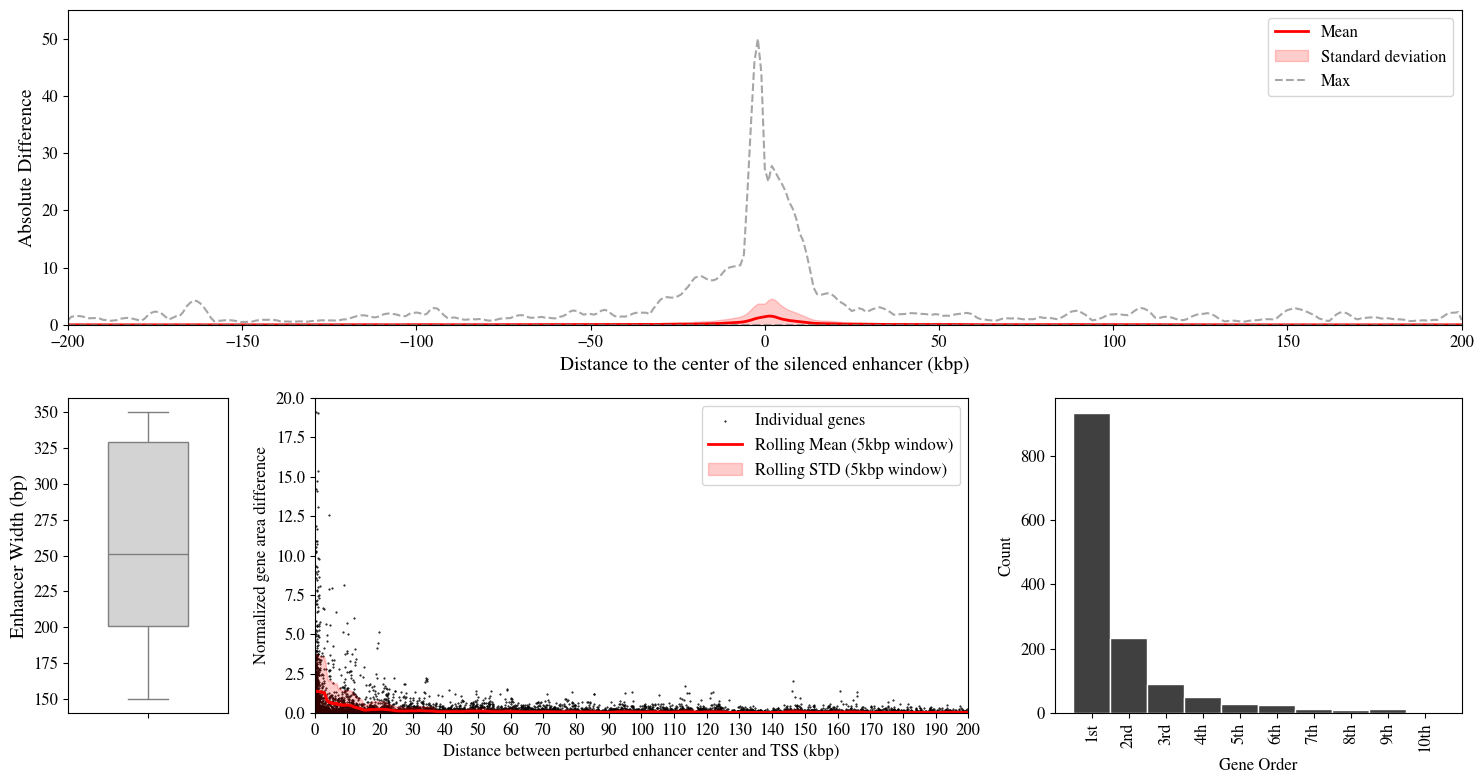

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from pathlib import Path

# Set global font size
plt.rcParams.update({'font.size': 12})

def analyze_enhancer_perturbations():
    # Create save directory
    savepath = Path("../figures/Figures_revisions/Enhancer_perturbations/")
    savepath.mkdir(exist_ok=True, parents=True)

    # Read enhancer annotations
    enhancer_df = pd.read_csv("../annotations/Final_Enhancer_annotation.tsv", sep='\t')
    enhancer_df['width'] = enhancer_df['end'] - enhancer_df['start']

    # Read the predictions
    ids, df, _ = _get_predictions(
        results_path=Path("../runs/perturbation_runs/gene_expression_only_chrom_pure_conv_chr19_enhancer_centric/"), 
        N_BINS=200,
        condition_list=["_ctrl"],
        is_training=False
    )

    # Calculate absolute differences and get enhancer widths
    abs_diff_data = []
    enhancer_widths = []

    for enhancer_id in df[~df.index.str.contains('perturbed')].index:
        # Get regular and perturbed predictions
        regular = df[df.index == enhancer_id].iloc[0]
        perturbed = df[df.index == f"{enhancer_id}_perturbed"].iloc[0]
        
        # Get enhancer width
        base_id = enhancer_id.split('_forward')[0] if '_forward' in enhancer_id else enhancer_id
        width = enhancer_df[enhancer_df['cCRE_accession'] == base_id]['width'].iloc[0]
        enhancer_widths.append(width)
        
        # Calculate differences for each position
        for pos in df.columns:
            position = int(pos.replace('_ctrl', ''))
            abs_diff = abs(regular[pos] - perturbed[pos])
            abs_diff_data.append({
                'Position': position,
                'Absolute_Difference': abs_diff
            })

    abs_diff_df = pd.DataFrame(abs_diff_data)

    # Calculate statistics for each position
    stats_df = abs_diff_df.groupby('Position').agg({
        'Absolute_Difference': ['mean', 'std', 'min', 'max', 
                               lambda x: np.percentile(x, 25),
                               lambda x: np.percentile(x, 75)]
    }).reset_index()
    stats_df.columns = ['Position', 'mean', 'std', 'min', 'max', 'q1', 'q3']

    return stats_df, enhancer_widths

def analyze_gene_areas():
    # Read the data
    df = pd.read_csv(Path('../tables/Predicted_gene_areas_in_enhancer_centric_approach.csv'))

    # Calculate area difference
    df['area_difference'] = abs(df['perturbed_area'] - df['baseline_area'])

    # Calculate rolling statistics
    sorted_df = df.sort_values('distance_to_enhancer').copy()
    window_size = 5000  # 5kbp

    # Initialize lists for rolling statistics
    x_vals = []
    means = []
    stds = []

    # Calculate rolling statistics manually
    for center in sorted_df['distance_to_enhancer'].unique():
        lower_bound = center - window_size/2
        upper_bound = center + window_size/2
        
        window_mask = (sorted_df['distance_to_enhancer'] >= lower_bound) & \
                     (sorted_df['distance_to_enhancer'] <= upper_bound)
        window_values = sorted_df.loc[window_mask, 'area_difference']
        
        if len(window_values) > 0:
            x_vals.append(center/1000)  # Convert to kbp
            means.append(window_values.mean())
            stds.append(window_values.std())

    # Get maximum effect genes
    def get_enhancer_id(row_id):
        return row_id.split('_ENSMUSG')[0]

    df['enhancer_id'] = df['ID'].apply(get_enhancer_id)
    df['abs_area_difference'] = abs(df['area_difference'])
    max_diff_genes = df.loc[df.groupby('enhancer_id')['abs_area_difference'].idxmax()]

    return df, np.array(x_vals), np.array(means), np.array(stds), max_diff_genes

def create_combined_figure():
    # Get data from both analyses
    stats_df, enhancer_widths = analyze_enhancer_perturbations()
    df, x_vals, means, stds, max_diff_genes = analyze_gene_areas()

    # Create figure with custom layout
    fig = plt.figure(figsize=(15, 8))
    
    # Create GridSpec with custom ratios
    # First row is for the absolute differences plot (full width)
    # Second row has three plots with ratios 1:2:3
    gs = fig.add_gridspec(2, 6, height_ratios=[1, 1])
    
    # Top row: Absolute differences plot (spans all columns)
    ax1 = fig.add_subplot(gs[0, :])
    ax1.plot(stats_df['Position'], stats_df['mean'], 
             color='red', label='Mean', linewidth=2)
    ax1.fill_between(stats_df['Position'], 
                     stats_df['mean'] - stats_df['std'],
                     stats_df['mean'] + stats_df['std'],
                     alpha=0.2, color='red', label='Standard deviation')
    ax1.plot(stats_df['Position'], stats_df['min'], 
             '--', color='gray', alpha=0.7, label='Max')
    ax1.plot(stats_df['Position'], stats_df['max'], 
             '--', color='gray', alpha=0.7)
    ax1.set_xlabel('Distance to the center of the silenced enhancer (kbp)', fontsize=14)
    ax1.set_ylabel('Absolute Difference', fontsize=14)
    ax1.set_xlim((-200, 200))
    ax1.set_ylim((0, 55))
    ax1.legend()

    # Bottom row, first plot (1/6 width): Enhancer width distribution
    ax2 = fig.add_subplot(gs[1, 0])
    sns.boxplot(y=enhancer_widths, ax=ax2, 
                showfliers=False, width=0.5, color='lightgray')
    ax2.set_ylabel('Enhancer Width (bp)', fontsize=14)
    ax2.set_xlabel('')

    # Bottom row, third plot (1/3 width): Gene Order Histogram (limited to order 10)
    ax3 = fig.add_subplot(gs[1, 4:])
    # Filter data for orders 1-10
    max_diff_genes_filtered = max_diff_genes[max_diff_genes['gene_order'] <= 10]
    sns.histplot(data=max_diff_genes_filtered, x='gene_order', discrete=True, 
                 ax=ax3, color='black', edgecolor='white')
    
    def ordinal(n):
        return str(n) + ("th" if 4<=n<=20 else {1:"st",2:"nd",3:"rd"}.get(n%10, "th"))
    
    ax3.set_xticks(range(1, 11))
    ax3.set_xticklabels([ordinal(i) for i in range(1, 11)], rotation=90)
    ax3.set_xlabel('Gene Order')
    ax3.set_ylabel('Count')

    # Bottom row, second plot (1/2 width): Distance vs Area Difference
    ax4 = fig.add_subplot(gs[1, 1:4])
    ax4.scatter(df['distance_to_enhancer']/1000, df['area_difference'], 
                alpha=1, color='k', s=1, edgecolors=None, marker='.', 
                label='Individual genes')
    ax4.plot(x_vals, means, color='red', 
             label='Rolling Mean (5kbp window)', linewidth=2)
    ax4.fill_between(x_vals, means - stds, means + stds,
                     alpha=.2, color='red', label='Rolling STD (5kbp window)')
    ax4.set_xlabel('Distance between perturbed enhancer center and TSS (kbp)')
    ax4.set_ylabel('Normalized gene area difference')
    ax4.set_ylim(0, 20)
    ax4.set_xlim(0, 200)
    max_dist = int(np.ceil(df['distance_to_enhancer'].max()/1000/10)*10)
    ax4.set_xticks(np.arange(0, max_dist, 10))
    ax4.legend()

    plt.tight_layout()
    
    # Save the figure
    savepath = Path("../figures/Figures_revisions/Enhancer_perturbations/")
    fig.savefig(savepath / "Combined_enhancer_analysis.png", dpi=200, bbox_inches='tight')
    
    # Print statistics
    print("\nEnhancer Width Statistics:")
    print(f"Mean: {np.mean(enhancer_widths):.0f} bp")
    print(f"Median: {np.median(enhancer_widths):.0f} bp")
    print(f"Std: {np.std(enhancer_widths):.0f} bp")
    print(f"Min: {np.min(enhancer_widths):.0f} bp")
    print(f"Max: {np.max(enhancer_widths):.0f} bp")
    
    print("\nStatistics for genes with maximum absolute difference (up to order 10):")
    print(f"Total number of enhancers: {len(max_diff_genes_filtered)}")
    print("\nGene Order distribution:")
    print(max_diff_genes_filtered['gene_order'].value_counts().sort_index())

def create_distance_histogram(results_df):
    """
    Create histogram data for gene-enhancer distances.
    
    Args:
        results_df: DataFrame containing the enhancer-gene analysis results
    """
    # Calculate bin edges (every 20kb up to 200kb)
    bin_size = 20000  # 20kb bins
    max_distance = 200000  # 200kb max
    bins = np.arange(0, max_distance + bin_size, bin_size)
    
    # Create the histogram
    hist, bin_edges = np.histogram(results_df['distance_to_enhancer'], bins=bins)
    
    # Create bin labels for plotting
    bin_labels = [f"{int(bin_edges[i]/1000)}-{int(bin_edges[i+1]/1000)}kb" 
                 for i in range(len(bin_edges)-1)]
    
    # Plot with matplotlib
    plt.figure(figsize=(10, 6))
    plt.bar(bin_labels, hist, align='center')
    plt.xticks(rotation=45, ha='right')
    plt.xlabel('Distance from Enhancer (kb)')
    plt.ylabel('Number of Genes')
    plt.title('Distribution of Gene-Enhancer Distances')
    plt.tight_layout()
    
    # Save the plot
    plt.savefig(output_path / "gene_enhancer_distance_histogram.png")
    plt.close()

def create_distance_histogram():
    """Create and save a histogram showing the distribution of gene-enhancer distances."""
    # Read the data
    df = pd.read_csv(Path('../tables/Predicted_gene_areas_in_enhancer_centric_approach.csv'))
    
    # Create save directory
    savepath = Path("../figures/Figures_revisions/Enhancer_perturbations/")
    savepath.mkdir(exist_ok=True, parents=True)
    
    # Create the figure
    plt.figure(figsize=(10, 6))
    
    # Calculate bin edges (every 20kb up to 200kb)
    bin_size = 20000  # 20kb bins
    max_distance = 200000  # 200kb max
    bins = np.arange(0, max_distance + bin_size, bin_size)
    
    # Create the histogram
    plt.hist(df['distance_to_enhancer'], bins=bins, color='black', edgecolor='white')
    
    # Customize the plot
    plt.xlabel('Distance between perturbed enhancer center and TSS (kbp)', fontsize=14)
    plt.ylabel('Number of Genes', fontsize=14)
    
    # Convert x-axis ticks to kbp
    plt.xticks(bins[::2], [f'{int(x/1000)}' for x in bins[::2]], rotation=45)
    
    plt.tight_layout()
    
    # Save the figure
    plt.savefig(savepath / "Gene_enhancer_distance_histogram.png", dpi=200, bbox_inches='tight')
    plt.close()
    
    # Print statistics
    print("\nGene-Enhancer Distance Statistics:")
    print(f"Mean distance: {df['distance_to_enhancer'].mean()/1000:.1f} kbp")
    print(f"Median distance: {df['distance_to_enhancer'].median()/1000:.1f} kbp")
    print(f"Std distance: {df['distance_to_enhancer'].std()/1000:.1f} kbp")
    print(f"Number of genes: {len(df)}")

if __name__ == "__main__":
    create_combined_figure()
    create_distance_histogram()

## IV) New models and analyses <center>
The reviewers asked us to perform a number of tests regarding alternative models and data processing strategies:

>**A) Assessing how the model learns to predict transcription**
>
>**B) Assessing the impact of shortening the context window**
>
>**C) Changing the last activation function or the loss**
>
>**D) Testing on another chromosome (chr19)**
>
>**E) Training without the enhancer mark (H3K27ac) as an input.**
>
>**F) Assessing the impact of smoothing**


## <center> A) Assessing how the model learns to predict transcription<center>

Here we extend the perturbational framework to further explore what rules does CLASTER learn. To do that, we create a number of synthetic inputs modifying a bit the properties of the input. The reference sample is centered at the gene Akirin2 (chr4) which showed a clear directionality and had no genes to the left. We will then feed these slightly different inputs to an already pretrained model, the basic model with only the chromatin branch and pure convolutions (no attention), obtain the predictions and compare them.

The following perturbations will be performed:
- Modulate promoter activity (height).
- Modulate the extension of H3K4me3 and ATAC-seq signal towards both directions to determine direction of transcription. We will do that by flipping the promoter region.
- Plug-in active superenhancer close to the promoter.
- Plug-in isolated promoter in intergenic region.

**Modifying promoter height:**

In the region -100 to + 100 bins (-10kbp,10kbp) centered at the TSS of the gene Akirin2 (ENSMUSG00000028291.7) we will:
- Get the chromatin state in this region and paste it in the intergenic region to the left.
- Increase the signal (multiply by 2 all marks)
- Decrease the signal (divide by 2 all marks)

**Identifying signal drivers of transcriptional directionality:**
- Check effects of accessibility / H3K27ac extension towards gene body. We will flip the promoter-proximal region.

**Adding superenhancers:**

Superenhancers for mESCs in mm9 can be found [here](https://asntech.org/dbsuper/adv_search.php?genome=mm9&cell_type%5B%5D=C_110&cell_type%5B%5D=C_111&cell_type%5B%5D=C_112&cell_type%5B%5D=C_113&cell_type%5B%5D=C_114&cell_type%5B%5D=C_115&cell_type%5B%5D=C_116&cell_type%5B%5D=C_087&cell_type%5B%5D=C_106&cell_type%5B%5D=C_117&cell_type%5B%5D=C_118&cell_type%5B%5D=C_119&cell_type%5B%5D=C_120&cell_type%5B%5D=C_121&cell_type%5B%5D=C_092&cell_type%5B%5D=C_122&cell_type%5B%5D=C_090&cell_type%5B%5D=C_123&cell_type%5B%5D=C_124&cell_type%5B%5D=C_089&cell_type%5B%5D=C_125&cell_type%5B%5D=C_126&cell_type%5B%5D=C_091&cell_type%5B%5D=C_127&cell_type%5B%5D=C_107&gene=&locus=&method=&submit=1)

- mESCs have an active superenhancer region directly to the left of KLF4. We get that region and plug it in immediately to the left of Akirin2 (with x0.5 promoter) to observe the boost.

**Adding a new gene in an intergenic region:**

We get the promoter of Akirin2 and plug it again upstream.







In [ ]:
input_path = Path("../inputs/landscape_arrays/test/")
outputs_path = Path("../runs/test_runs/gene_expression_only_chrom_pure_conv/")
figures_path = Path("../figures/Figures_revisions/")

# Interesting locus: ENSMUSG00000028291.7_forward_prediction    ENSMUSG00000035696.15_forward.npy: Rnf38

EXAMPLE_GENE = "ENSMUSG00000003032.8_forward.npy" #<- KLF4 # Akirin2: "ENSMUSG00000028291.7_forward.npy"
# Inputs:
i = 1
input_id_list = []
for a in os.scandir(input_path):
    #if i % 100 == 0:
    if a.name == EXAMPLE_GENE:
        name = a.name.removesuffix('.npy')
        input_id_list.append(name)
        a = np.load(input_path / a.name)
        fig = visualize_input_array(a)
        fig.savefig(figures_path / 'Inputs' / f'{name}_input.png', dpi=200)
        plt.close(fig)
    i +=1

# Outputs:
ids, predicted, actual = _get_predictions(outputs_path, N_BINS=200, condition_list = ["_ctrl"])

for ID,line_p,line_a in zip(ids,predicted.values,actual.values):   
    if ID in input_id_list:
        line_p = predicted.loc[ID]
        line_a = actual.loc[ID]
        fig = plot_target_predictions(line_p, line_a)
        fig.savefig(figures_path / 'Outputs' / f"{ID}_prediction.png", dpi=200)
        plt.close(fig)


In [ ]:
input_path = Path("../inputs/landscape_arrays/test/")
savepath = Path("../inputs/perturbed_landscape_arrays/inserted_promoter_arrays/")
figures_path = Path("../figures/Figures_revisions/")

akirin2_baseline_input = np.load(input_path / "ENSMUSG00000028291.7_forward.npy")
SEQLEN = akirin2_baseline_input.shape[1]
N_BINS_SHIFT = 100 

akirin2_promoter = akirin2_baseline_input[:,(SEQLEN // 2) -N_BINS_SHIFT:(SEQLEN // 2) +N_BINS_SHIFT ]

sample_names = ["ENSMUSG00000028291.7_forward", 
                "ENSMUSG00000028291.7_forward_0.5prom",
                "ENSMUSG00000028291.7_forward_2prom",
                "ENSMUSG00000028291.7_forward_flipprom",
                "ENSMUSG00000028291.7_forward_proxenh" ,
                "ENSMUSG00000028291.7_forward_proxprom"]

# Baseline sequence:
fig = visualize_input_array(akirin2_baseline_input)
fig.savefig(figures_path / 'Inputs' / f'{sample_names[0]}.png', dpi=200)
plt.close(fig)
np.save(savepath / f"{sample_names[0]}.npy", akirin2_baseline_input)

# A) 2X less active promoter
akirin2_less_prom = akirin2_baseline_input.copy()
akirin2_less_prom[:,(SEQLEN // 2) -N_BINS_SHIFT:(SEQLEN // 2) +N_BINS_SHIFT ] = 0.5*akirin2_less_prom[:,(SEQLEN // 2) -N_BINS_SHIFT:(SEQLEN // 2) +N_BINS_SHIFT ]
fig = visualize_input_array(akirin2_less_prom)
fig.savefig(figures_path / 'Inputs' / f'{sample_names[1]}.png', dpi=200)
plt.close(fig)
np.save(savepath / f"{sample_names[1]}.npy",akirin2_less_prom)

# B) 2X more active promoter
akirin2_more_prom = akirin2_baseline_input.copy()
akirin2_more_prom[:,(SEQLEN // 2) -N_BINS_SHIFT:(SEQLEN // 2) +N_BINS_SHIFT ] = 2*akirin2_more_prom[:,(SEQLEN // 2) -N_BINS_SHIFT:(SEQLEN // 2) +N_BINS_SHIFT ]
fig = visualize_input_array(akirin2_more_prom)
fig.savefig(figures_path / 'Inputs' / f'{sample_names[2]}.png', dpi=200)
plt.close(fig)
np.save(savepath / f"{sample_names[2]}.npy", akirin2_more_prom)

# C) Flipped promoter extension:
# B) 2X less active promoter
akirin2_flip_prom = akirin2_baseline_input.copy()
akirin2_flip_prom[:,(SEQLEN // 2) -N_BINS_SHIFT:(SEQLEN // 2) +N_BINS_SHIFT ] = np.flip(akirin2_flip_prom[:,(SEQLEN // 2) -N_BINS_SHIFT:(SEQLEN // 2) +N_BINS_SHIFT ], axis=1)
fig = visualize_input_array(akirin2_flip_prom)
fig.savefig(figures_path / 'Inputs' / f'{sample_names[3]}.png', dpi=200)
plt.close(fig)
np.save(savepath / f"{sample_names[3]}.npy", akirin2_flip_prom)


# D) KLF4 SUPERENHANCER ADDED
akirin2_prox_enh = akirin2_baseline_input.copy()
# - Lower promoter activity (it is super active, genes with strong promoters don't rely on enhancers that much, see Narita et al.)
akirin2_prox_enh[:,(SEQLEN // 2) -N_BINS_SHIFT:(SEQLEN // 2) +N_BINS_SHIFT ] = 0.5*akirin2_prox_enh[:,(SEQLEN // 2) -N_BINS_SHIFT:(SEQLEN // 2) +N_BINS_SHIFT ] # small promoter effect
# - Copy paste KLF4 superenhancer state.
ENH_WIDTH = 400
ENH_START = ENH_WIDTH +  ENH_WIDTH // 2 #Enhancer starts at -60 kbp kbp from TSS
ENH_TRUE_POS = -800
klf4_baseline_input = np.load(input_path / "ENSMUSG00000003032.8_forward.npy")
klf4_superenhancer = klf4_baseline_input[:,(SEQLEN // 2) + ENH_TRUE_POS : (SEQLEN // 2) + ENH_TRUE_POS + ENH_WIDTH]
akirin2_prox_enh[:,(SEQLEN // 2) - ENH_START : (SEQLEN // 2) - ENH_START + ENH_WIDTH] = klf4_superenhancer
fig = visualize_input_array(akirin2_prox_enh)
fig.savefig(figures_path / 'Inputs' / f'{sample_names[4]}.png', dpi=200)
plt.close(fig)
np.save(savepath / f"{sample_names[4]}.npy", akirin2_prox_enh)

# E) Akirin2 Promoter added:
PROM_POS = -1000 # bins to the left where we plug in the artificial promoter
akirin2_add_prom = akirin2_baseline_input.copy()
akirin2_add_prom[:,(SEQLEN // 2) -N_BINS_SHIFT + PROM_POS :(SEQLEN // 2) +N_BINS_SHIFT + PROM_POS] = akirin2_add_prom[:,(SEQLEN // 2) -N_BINS_SHIFT:(SEQLEN // 2) +N_BINS_SHIFT ]
fig = visualize_input_array(akirin2_add_prom)
fig.savefig(figures_path / 'Inputs' / f'{sample_names[5]}.png', dpi=200)
plt.close(fig)
np.save(savepath / f"{sample_names[5]}.npy", akirin2_add_prom)


In [ ]:
# Dummy sythetic targets (for eir to work we need also targets matching inputs, which will be ignored)
targets_path = Path("../targets/")
N_BINS = 200
# Create DataFrame
df = pd.DataFrame(0, 
                 index=pd.Index(sample_names, name='ID'),  # Set index with name 'ID'
                 columns=[f'{i}_ctrl' for i in range(-N_BINS, N_BINS+1)])  # Set columns
df.to_csv(targets_path / "prom_perturbed_targets.csv")

**Running new models:**

> _Note:_
For GPU trained models, we need to test using the same device.

To run on a SLURM based cluster:

srun --partition=gpuqueue --gres=gpu:a100:1 -- 

**Predict promoter perturbed inputs:**

```bash
eirpredict \
--global_configs ./configurations/conf_pure_conv_predict_prom/globals.yaml \
--input_configs ./configurations/conf_pure_conv_predict_prom/input_cnn.yaml \
--fusion_configs ./configurations/conf_pure_conv_predict_prom/fusion.yaml \
--output_configs ./configurations/conf_pure_conv_predict_prom/outputs_2_cond.yaml \
--evaluate \
--model_path ./runs/gene_expression_only_chrom_pure_conv/saved_models/gene_expression_only_chrom_pure_conv_model_60600_perf-average=0.8161.pt \
--output_folder ./runs/perturbation_runs/gene_expression_only_chrom_pure_conv_prom_perturb 
```


**Plotting predicted profiles after the perturbations:**

In [ ]:
# Outputs:
original_outputs_path = Path("../runs/test_runs/gene_expression_only_chrom_pure_conv/")
outputs_path = Path("../runs/perturbation_runs/gene_expression_only_chrom_pure_conv_prom_perturb/")
figures_path = Path("../figures/Figures_revisions/")
ids, predicted, actual = _get_predictions(outputs_path, N_BINS=200, condition_list = ["_ctrl"])

color_list = ['purple','black','lightseagreen', 'orange', 'firebrick', 'darkgreen']
predicted_tracks=['baseline','x0.5 Promoter', 'x2 Promoter', 'Flipped promoter region', 'Proximal enhancer added', 'New promoter added']
predictions = []

for k, (ID,line_p,line_a) in enumerate(zip(ids,predicted.values,actual.values)):   
    print(ID)
    line_p = predicted.loc[ID]
    predictions.append({'profile':line_p,
                        'color':color_list[k],
                        'alpha': 0.1,
                        'label': predicted_tracks[k],
                        'ls':'-'
    })


# Actual baseline signal:
ID = "ENSMUSG00000028291.7_forward"
*_ , actual = _get_predictions(original_outputs_path, N_BINS=200, condition_list = ["_ctrl"])

actual_data = [{
    'profile': actual.loc[ID],
    'color': 'silver',
    'alpha': 0.6,
    'label': 'EU-seq',
    'ls':'-'
}]

# Create plot
fig = plot_generalized_predictions(predictions, actual_data)
fig.savefig(figures_path / 'Outputs' / 'Perturbed_promoter.png', dpi=200)

## <center> B) Creating a shorter context model: <center>


We reduced the input context to 20 kbp and the output context to the central 18 kbp.

**Creating the new inputs and outputs:**

This is a highly parallelizable process, so we will use the python multiprocessing package to exploit our slurm-based cluster. We ran:
```bash
srun --cpus-per-task=16 -- python ./create_cropped_inputs.py
```

>**Data processing:**
>We just cropped the exact same inputs and outputs to the new desired length. 
>
>**Model changes:**
>We reduced the size of the model accordingly:
>- Smaller feature extractor: too many convolutions would compress too much the input sequences.
>- Smaller MLP.

In [ ]:
%%writefile create_cropped_inputs.py
from pathlib import Path
import numpy as np
import os
from multiprocessing import Pool, cpu_count
from functools import partial

def process_sample(filename, original_path, new_path, new_dim=201, original_dim=10001):
    """Process a single sample file."""
    crop_shift = (original_dim - new_dim) // 2
    try:
        array = np.load(original_path / filename)
        new_array = array[:, crop_shift:-crop_shift]
        np.save(new_path / filename, new_array)
        return f"Successfully processed {filename}"
    except Exception as e:
        return f"Error processing {filename}: {str(e)}"

def main():
    # Define paths
    original_inputs_paths = [
        Path("../inputs/landscape_arrays/training/"),
        Path("../inputs/landscape_arrays/test/")
    ]
    new_inputs_paths = [
        Path("../inputs/landscape_arrays/training_20kbp_context/"),
        Path("../inputs/landscape_arrays/test_20kbp_context/")
    ]

    # Create output directories if they don't exist
    for path in new_inputs_paths:
        path.mkdir(parents=True, exist_ok=True)

    # Number of processes to use (leave one core free for system processes)
    num_processes = max(1, cpu_count() - 1)
    
    for i, path in enumerate(original_inputs_paths):
        # Get list of filenames instead of DirEntry objects
        filenames = [f.name for f in os.scandir(path)]
        
        # Create partial function with fixed arguments
        process_func = partial(
            process_sample,
            original_path=path,
            new_path=new_inputs_paths[i]
        )
        
        # Process files in parallel
        print(f"Processing files in {path} using {num_processes} processes...")
        with Pool(num_processes) as pool:
            results = pool.map(process_func, filenames)
        
        # Print results
        for result in results:
            print(result)

if __name__ == "__main__":
    main()


**Training eir only chrom pure conv for 20kbp context:**

```bash
eirtrain \
--global_configs ./configurations/conf_pure_conv_20kbp_context/globals.yaml \
--input_configs ./configurations/conf_pure_conv_20kbp_context/input_cnn.yaml \
--fusion_configs ./configurations/conf_pure_conv_20kbp_context/fusion.yaml \
--output_configs ./configurations/conf_pure_conv_20kbp_context/outputs_2_cond.yaml
```

**Testing eir only chrom pure conv for 20kbp context:**

```bash
eirpredict \
--global_configs ./configurations/conf_pure_conv_20kbp_context_test/globals.yaml \
--input_configs ./configurations/conf_pure_conv_20kbp_context_test/input_cnn.yaml \
--fusion_configs ./configurations/conf_pure_conv_20kbp_context_test/fusion.yaml \
--output_configs ./configurations/conf_pure_conv_20kbp_context_test/outputs_2_cond.yaml \
--evaluate \
--model_path ./runs/gene_expression_only_chrom_pure_conv_20kbp_context/saved_models/gene_expression_only_chrom_pure_conv_20kbp_context_model_30300_perf-average=0.7867.pt \
--output_folder ./runs/test_runs/gene_expression_only_chrom_pure_conv_20kbp_context_test 
```

## <center> C) Changing the last activation function or the loss:
- Output activation to softplus. 
> ⚠️ WARNING ⚠️ : This is a temporary hotfix that overwrites the linear head to introduce the least changes to the eir code. 

**Modifications to eir's (version 0.1.42) code:**

_Changing activation function of the last layer:_

We will change the file defining the last layer activation functions for tabular outputs, which in on our environment can be found at ```claster_env/lib/python3.11/site-packages/eir/models/output/tabular/linear.py```.
Here we will edit the function:

```python

#Original linear head
def _get_linear_multi_task_branches(
    input_dimension: int,
    num_outputs_per_target: "al_num_outputs_per_target",
) -> nn.ModuleDict:
    multi_task_branches = nn.ModuleDict(
        {
            target: nn.Linear(
                in_features=input_dimension,
                out_features=num_outputs,
            )
            for target, num_outputs in num_outputs_per_target.items()
        }
    )

    return multi_task_branches
```

The new function will simply pass the output through a softplus transformation. The same principles would apply for ReLU:

```python
# New head
def _get_linear_multi_task_branches(
    input_dimension: int,
    num_outputs_per_target: "al_num_outputs_per_target",
) -> nn.ModuleDict:
    multi_task_branches = nn.ModuleDict(
        {
            target: nn.Sequential(
                nn.Linear(
                    in_features=input_dimension,
                    out_features=num_outputs,
                ),
                nn.Softplus()
            )
            for target, num_outputs in num_outputs_per_target.items()
        }
    )

    return multi_task_branches
```

_Setting the log_input to False in PoissonNLLL:_

This is the edit in the file ```claster_env/lib/python3.11/site-packages/eir/train_utils/criteria.py```:

```python
def _calc_con_loss(input: torch.Tensor, target: torch.Tensor, loss_func: al_con_losses):
    match loss_func:
        case nn.PoissonNLLLoss():
            # Before we had:
            #return loss_func(log_input=input.squeeze(), target=target.squeeze())
            # Create a new PoissonNLLLoss with log_input=False
            poisson_loss = nn.PoissonNLLLoss(log_input=False)
            # Note that despite the parameter name being log_input, we pass the raw input tensor
            return poisson_loss(input.squeeze(), target.squeeze())
        case _:
            return loss_func(input=input.squeeze(), target=target.squeeze())

```

**Run models:**

Training eir only chrom pure conv with softplus:
```bash
eirtrain \
--global_configs ./configurations/conf_pure_conv_softplus/globals.yaml \
--input_configs ./configurations/conf_pure_conv_softplus/input_cnn.yaml \
--fusion_configs ./configurations/conf_pure_conv_softplus/fusion.yaml \
--output_configs ./configurations/conf_pure_conv_softplus/outputs_2_cond.yaml

eirtrain \
--global_configs ./configurations/conf_pure_conv_softplus_poisson/globals.yaml \
--input_configs ./configurations/conf_pure_conv_softplus_poisson/input_cnn.yaml \
--fusion_configs ./configurations/conf_pure_conv_softplus_poisson/fusion.yaml \
--output_configs ./configurations/conf_pure_conv_softplus_poisson/outputs_2_cond.yaml
```



**Visualize predictions for Softplus and Poisson losses:**

In [ ]:
# Outputs:
original_outputs_path_dict = {Path("../runs/gene_expression_only_chrom_pure_conv_softplus_poisson_no_bias/results/"):["Predicted EU-seq Softplus Poisson", 'royalblue','-'],
                              Path("../runs/gene_expression_only_chrom_pure_conv_softplus_no_bias/results/"):["Predicted EU-seq Softplus SmoothL1", 'orange','-'],
                              Path("../runs/gene_expression_only_chrom_pure_conv_softplus_poisson_no_bias_log_input_false/results/"):["Predicted EU-seq Softplus Poisson log input false", 'darkred','-']}

training_targets_path = Path("../targets/training_targets.csv")

figures_path = Path("../figures/Figures_revisions/")
ids = ["ENSMUSG00000051977.16_forward","ENSMUSG00000109212.3_forward"]

for k,ID in enumerate(ids):
    predictions = []
    for original_outputs_path,attributes in original_outputs_path_dict.items():
        ids, predicted , actual = _get_predictions(original_outputs_path, N_BINS=200, condition_list = ["_ctrl"], is_training=True,batch_num=60600, CLIP=False)

        line_p = predicted.loc[ID]
        predictions.append({'profile':line_p,
                            'color':attributes[1],
                            'alpha': 0.05,
                            'label': attributes[0],
                            'ls':attributes[2]
                            })
        

    # Actual baseline signal:
    actual_data = [{
        'profile': actual.loc[ID],
        'color': 'silver',
        'alpha': 0.6,
        'label': 'EU-seq',
        'ls':'-'
    }]

    # Averaged actual targets across samples:    
    avg_training_targets = pd.read_csv(training_targets_path).set_index('ID').values.mean(axis=0)
    predictions.append({'profile':avg_training_targets,
                            'color':'darkgreen',
                            'alpha': 0.1,
                            'label': 'Mean EU-seq per bin',
                            'ls':'--'
                            })


    # Create plot
    fig = plot_generalized_predictions(predictions, actual_data)
    fig.savefig(figures_path / 'Outputs' / f'Softplus_no_bias_{ID}.png', dpi=200)

## <center> D) Testing on another chromosome (chr19):

We will:
- Keep the samples on chr4 as hold out.
- Additionally mask samples from chr19 from training (set them as validation)
- Introduce samples in chr17 in the training (were used for validation originally). 
- Note that we will not validate now since we already have the model's hyperparameters defined. 

**Training eir for chr19 holdout:**

```bash
eirtrain \
--global_configs ./configurations/conf_pure_conv_chr19_holdout_train/globals.yaml \
--input_configs ./configurations/conf_pure_conv_chr19_holdout_train/input_cnn.yaml \
--fusion_configs ./configurations/conf_pure_conv_chr19_holdout_train/fusion.yaml \
--output_configs ./configurations/conf_pure_conv_chr19_holdout_train/outputs_2_cond.yaml
```

**Testing eir for chr19 holdout:**

```bash
eirpredict \
--global_configs ./configurations/conf_pure_conv_chr19_holdout_test/globals.yaml \
--input_configs ./configurations/conf_pure_conv_chr19_holdout_test/input_cnn.yaml \
--fusion_configs ./configurations/conf_pure_conv_chr19_holdout_test/fusion.yaml \
--output_configs ./configurations/conf_pure_conv_chr19_holdout_test/outputs_2_cond.yaml \
--evaluate \
--model_path ./runs/gene_expression_only_chrom_pure_conv_chr19_holdout/saved_models/gene_expression_only_chrom_pure_conv_chr19_holdout_model_30300_perf-average=0.6487.pt \
--output_folder ./runs/test_runs/gene_expression_only_chrom_pure_conv_chr19_holdout_test
```


In [ ]:
# From the notebook II_run_CLASTER:
def create_validation_ids(path: Path, val_chrom: str = "chr19"):
    """ All genes encoded in chr19 will be used as a validation set."""
    gene_annotations_df = pd.read_csv(path / "Final_gene_annotations.tsv", sep="\t").set_index('ID')
    missing_samples_report = pd.read_csv(path / "missing_samples_report.csv")["Sample"].values
    indices = gene_annotations_df[gene_annotations_df["chr"] == val_chrom].index

    # Prepare the strings to write in the file
    lines = [f"{index}_forward\n{index}_rev\n" for index in indices if index+'_forward' not in missing_samples_report]

    # Write to the text file
    with open(path / f"manual_validation_ids_{val_chrom}.txt", 'w') as file:
        file.writelines(lines)

path = Path("../annotations/")
create_validation_ids(path)

In [ ]:
ids_path = Path("../annotations/manual_validation_ids_chr19.txt")
sample_ids = pd.read_csv(ids_path, header=None)[0].tolist()
training_samples = [array.name for array in os.scandir(Path("../inputs/landscape_arrays/training/"))]

for sample in sample_ids:
    if f"{sample}.npy" not in training_samples:
        print(sample)
print(len(sample_ids))

b = pd.read_csv(Path("../annotations/Final_gene_annotations.tsv"), sep='\t')
b = b[b['chr'] == 'chr19']
b

> *Note:* samples ENSMUSG00000095993.1_forward and ENSMUSG00000095993.1_rev, corresponding to the last gene annotated in chr19 (Gm21060) were not in the original input training set, so we removed their corresponding ids in the hold out manual validation list for chr19.**

In [ ]:
##################### Copying chr19
# Read sample IDs using pandas
ids_path = Path("../annotations/manual_validation_ids_chr19.txt")
sample_ids = pd.read_csv(ids_path, header=None)[0].tolist()

# Define paths using pathlib
source_dir = Path('../inputs/landscape_arrays/training')
dest_dir = Path('../inputs/landscape_arrays/test_chr19')

# Create destination directory if it doesn't exist
dest_dir.mkdir(parents=True, exist_ok=True)

# COPY matching .npy files (not move)
moved_count = 0
for file_path in source_dir.glob('*.npy'):
    # Check if any sample ID from our list is in the filename
    if any(sample_id in file_path.stem for sample_id in sample_ids):
        dest_path = dest_dir / file_path.name
        shutil.copy(str(file_path), str(dest_path))
        moved_count += 1
        print(f"Copied: {file_path.name}")

print(f"\nTotal files moved: {moved_count}")

################## Retrieving the targets from the original file ################
# Read sample IDs using pandas
manual_ids = pd.read_csv('../annotations/manual_validation_ids_chr19.txt', header=None)[0].tolist()

# Read the training targets file
training_targets = pd.read_csv('../targets/training_targets.csv')

# Filter rows where ID matches our manual validation IDs
test_targets = training_targets[training_targets['ID'].isin(manual_ids)]

# Save to new file in the test directory
dest_dir = Path('../targets/')
test_targets.to_csv(dest_dir / 'test_targets_chr19.csv', index=False)

print(f"Original targets shape: {training_targets.shape}")
print(f"Test targets shape: {test_targets.shape}")

## <center> E) Training without the enhancer mark (H3K27ac) as an input.

We removed the row corresponding to the enhancer mark H3K27ac from all the input numpy arrays.

In [ ]:
%%writefile create_inputs_without_H3K27ac.py
from pathlib import Path
import numpy as np
import multiprocessing as mp
from functools import partial

def process_file(file_path, savepath):
    # Load the array
    data = np.load(file_path)
    
    # Remove H3K27ac row (ATAC, H3K4me3, H3K27ac, H3K27me3)
    data_filtered = np.delete(data, 2, axis=0)
    
    # Save to new location with same filename
    output_path = savepath / file_path.name
    np.save(output_path, data_filtered)

def main():
    input_folder = Path('../inputs/landscape_arrays/test/') #Path('../inputs/landscape_arrays/training/')
    savepath = Path('../inputs/landscape_arrays/test_no_H3K27ac/') # Path('../inputs/landscape_arrays/training_no_H3K27ac/')
    
    # Create output directory if it doesn't exist
    savepath.mkdir(exist_ok=True, parents=True)
    
    # Get list of all files
    files = list(input_folder.glob('*.npy'))
    
    # Set up multiprocessing
    n_cpus = mp.cpu_count() - 1
    
    # Create partial function with fixed savepath
    process_func = partial(process_file, savepath=savepath)
    
    # Create pool and map files to processes
    with mp.Pool(n_cpus) as pool:
        pool.map(process_func, files)
    
    print("Processing complete!")

if __name__ == '__main__':
    main()

**Training eir only chrom pure conv with no H3K27ac:**

```bash
eirtrain \
--global_configs ./configurations/conf_pure_conv_no_H3K27ac_train/globals.yaml \
--input_configs ./configurations/conf_pure_conv_no_H3K27ac_train/input_cnn.yaml \
--fusion_configs ./configurations/conf_pure_conv_no_H3K27ac_train/fusion.yaml \
--output_configs ./configurations/conf_pure_conv_no_H3K27ac_train/outputs_2_cond.yaml
```


**Testing eir only chrom pure conv with no H3K27ac:**

```bash
eirpredict \
--global_configs ./configurations/conf_pure_conv_no_H3K27ac_test/globals.yaml \
--input_configs ./configurations/conf_pure_conv_no_H3K27ac_test/input_cnn.yaml \
--fusion_configs ./configurations/conf_pure_conv_no_H3K27ac_test/fusion.yaml \
--output_configs ./configurations/conf_pure_conv_no_H3K27ac_test/outputs_2_cond.yaml \
--evaluate \
--model_path ./runs/gene_expression_only_chrom_pure_conv_no_H3K27ac/saved_models/gene_expression_only_chrom_pure_conv_no_H3K27ac_model_60600_perf-average=0.7807.pt \
--output_folder ./runs/test_runs/gene_expression_only_chrom_pure_conv_no_H3K27ac_test
```

## <center> F) Predict untransformed EU-seq, only binned at 1kbp resolution. <center>

Reviewer 2 was concerned about potential oversmoothing of the signals and the impact that this would cause in model performance. We proceeded to train CLASTER aiming to predict EU-seq profiles directly binned at a 1kbp resolution.

In [ ]:
%%writefile create_1kbp_binned_targets.py
import os
import pandas as pd
import numpy as np
import pyBigWig
import matplotlib.pyplot as plt
import logging
from pathlib import Path
import multiprocessing

def create_target_array(data_path: Path,
                        output_shift: int,
                        n_output_bins:int,
                        bw_target_track_list:list,
                        ID: str,
                        TSS: int,
                        chrom: str):
    """
    Targets are centered at the TSS, and obtained at a 20 bp resolution, smoothed and downsized to 1kbp resolution.
    """
    # Initialize stats as None
    stats = None
    
    for bw_path in bw_target_track_list:
        try:
            bw = pyBigWig.open(str(data_path / bw_path), "r")
            stats = bw.stats(chrom,TSS-output_shift,TSS+output_shift,type="mean",nBins=n_output_bins)
            bw.close()
            if stats is not None:  # Only process if we got valid stats
                stats = np.array([float(value) if value is not None else 0. for value in stats])
                stats = np.clip(np.array(stats),0,None)
            else:
                logging.info(f"{ID} no valid stats obtained.")
                stats = np.zeros(n_output_bins)  # Return zeros if no valid stats
        except Exception as e:
            logging.info(f"{ID} target coordinates are out of bounds. Error: {str(e)}")
            stats = np.zeros(n_output_bins)  # Return zeros in case of error
    
    if stats is None:
        stats = np.zeros(n_output_bins)  # Fallback if no valid stats were obtained
        
    return stats.flatten(), np.flip(stats).flatten()

def process_target_data(data_path, bw_target_track_list, output_shift, n_output_bins, OUTPUT_LENGTH, target_files, row):
    ID, chrom, Start, End, Strand, Name, CRE_type = row
    split = "test" if chrom == "chr4" else "training"
    TSS = int(Start) if Strand == '+' else int(End)

    target_sample_pos, target_sample_neg = create_target_array(data_path, output_shift, n_output_bins, bw_target_track_list, ID, TSS, chrom)

    if (len(target_sample_pos) == OUTPUT_LENGTH):
        target_file_path = target_files[split]
        with open(target_file_path, 'a') as file:
            file.write(f"{ID}_forward," + ",".join(map(str, target_sample_pos)) + "\n")
            file.write(f"{ID}_rev," + ",".join(map(str, target_sample_neg)) + "\n")


if __name__ == '__main__':
    path = Path("../")
    data_path = path / "GEO_files"
    target_path = path / "targets"
    target_path.mkdir(exist_ok=True, parents=True)
    split_list = ["training","test"]

    # Start logger
    LOG_FILENAME = "/Landscape_data_obtention_1kbp_binned.log"
    logging.basicConfig(filename=str(path) + LOG_FILENAME, level=logging.INFO)  

    gene_annotations_path = path / "annotations" / "Final_gene_annotations.tsv"
    gene_annotations_df = pd.read_csv(gene_annotations_path, sep="\t")

    output_shift = 200500 #200500 # Output in 1kbp resolution (500 extra per side to have extra central bin)
    n_output_bins = 401
    OUTPUT_LENGTH = 401 #802
    N_BINS = 200
    bw_target_track_list = ["EU_Seq_Ctrl.bw"] # "EU_Seq_Treated.bw"

    target_files = {split: (path / "targets" / f"{split}_targets_1kbp_binning.csv") for split in ["training", "validation", "test"]}
    for file_path in target_files.values():
        with open(file_path, 'w') as file:
            file.write("ID," + ",".join([f"{i}{cond}" for cond in ["_ctrl"] for i in range(-N_BINS,N_BINS+1)]) + "\n")

    process_args = (data_path, bw_target_track_list, output_shift, n_output_bins, OUTPUT_LENGTH, target_files)

    with multiprocessing.Pool(processes=multiprocessing.cpu_count() - 1) as pool:
        pool.starmap(process_target_data, [(process_args + (row,)) for row in gene_annotations_df.to_numpy()])




**New targets analysis:**
- Remove samples that were missing in the original analyses.
- Compute correlation between binned and smoothed profiles.

In [ ]:
new_training_targets = pd.read_csv("../targets/training_targets_1kbp_binning.csv").set_index('ID')
new_test_targets = pd.read_csv("../targets/test_targets_1kbp_binning.csv").set_index('ID')

old_training_targets = pd.read_csv("../targets/training_targets.csv").set_index('ID')
old_test_targets = pd.read_csv("../targets/test_targets.csv").set_index('ID')


new_training_targets = new_training_targets.reindex(old_training_targets.index)
new_test_targets = new_test_targets.reindex(old_test_targets.index)


In [ ]:
x = new_test_targets.values.flatten()
y = old_test_targets.values.flatten()
r = pearsonr(x,y)

figure_path = Path("../figures/Figures_revisions")

area = plot_correlations(figure_path, x, y, "Smoothed_vs_1kbp_binned_correlation.png", cmap="binary", binlims=(0,200), density=True, min_val = 0, max_val=200)


for ID in new_test_targets.index[::100]:
    predictions = [{
        'profile': new_test_targets.loc[ID],
        'color': 'royalblue',
        'alpha': 0.6,
        'label': 'EU-seq binned 1kbp',
        'ls':'-'

    }]

    actual_data = {
        'profile': old_test_targets.loc[ID],
        'color': 'silver',
        'alpha': 0.6,
        'label': 'EU-seq',
        'ls':'-',
    }

    fig = plot_generalized_predictions(predictions, actual_data)
    fig.show()


**Training eir only chrom pure conv with no smoothing, directly binning the reads in 1kbp bins:**

```bash
eirtrain \
--global_configs ./configurations/conf_pure_conv_1kbp_binning_train/globals.yaml \
--input_configs ./configurations/conf_pure_conv_1kbp_binning_train/input_cnn.yaml \
--fusion_configs ./configurations/conf_pure_conv_1kbp_binning_train/fusion.yaml \
--output_configs ./configurations/conf_pure_conv_1kbp_binning_train/outputs_2_cond.yaml
```

**Testing eir only chrom pure conv with no smoothing, directly binning the reads in 1kbp bins:**

```bash
eirpredict \
--global_configs ./configurations/conf_pure_conv_1kbp_binning_test/globals.yaml \
--input_configs ./configurations/conf_pure_conv_1kbp_binning_test/input_cnn.yaml \
--fusion_configs ./configurations/conf_pure_conv_1kbp_binning_test/fusion.yaml \
--output_configs ./configurations/conf_pure_conv_1kbp_binning_test/outputs_2_cond.yaml \
--evaluate \
--model_path ./runs/gene_expression_only_chrom_pure_conv_1kbp_binning/saved_models/gene_expression_only_chrom_pure_conv_1kbp_binning_model_60600_perf-average=0.7832.pt \
--output_folder ./runs/test_runs/gene_expression_only_chrom_pure_conv_1kbp_binning_test
```

### Analyze predictions and attributions of the new models


In [4]:
results_path_dict = {
    "Only Chromatin Pure Convolutions training": {"path": Path("../runs/gene_expression_only_chrom_pure_conv/results/"),
                                                  "is_training": True,
                                                  "N_BINS": 200,
                                                  "batch_num": 60600, 
                                                  "attributions": False,
                                                  "label": "Gaussian",
                                                  "color": "blue"},
    "Only Chromatin Pure Convolution test": {"path": Path("../runs/test_runs/gene_expression_only_chrom_pure_conv/"),
                                             "is_training": False,
                                             "N_BINS": 200,
                                             "batch_num": None,
                                             "attributions": True,
                                             "label": "CLASTER test",
                                             "color": "blue"},
    "Only Chromatin with Attention training": {"path": Path("../runs/gene_expression_only_chrom_attention/results/"),
                                              "is_training": True,
                                              "N_BINS": 200,
                                              "batch_num": 60600,
                                              "attributions": False,
                                              "label": "Only chrom attention",
                                              "color": "blue"},
    "Only Chromatin with Attention test": {"path": Path("../runs/test_runs/gene_expression_only_chrom_attention/"),
                                          "is_training": False,
                                          "N_BINS": 200,
                                          "batch_num": None,
                                          "attributions": True,
                                          "label": "Only chrom attention",
                                          "color": "blue"},
    "Chromatin and Structure training": {"path": Path("../runs/gene_expression_microc_pure_conv/results/"),
                                        "is_training": True,
                                        "N_BINS": 200,
                                        "batch_num": 60600,
                                        "attributions": False,
                                        "label": "Chrom and structure",
                                        "color": "blue"},
    "Chromatin and Structure test": {"path": Path("../runs/test_runs/gene_expression_microc_pure_conv/"),
                                    "is_training": False,
                                    "N_BINS": 200,
                                    "batch_num": None,
                                    "attributions": True,
                                    "label": "Chrom and Structure",
                                    "color": "blue"},
    "Chromatin and Structure rotated training": {"path": Path("../runs/gene_expression_microc_rotated_pure_conv/results/"),
                                               "is_training": True,
                                               "N_BINS": 200,
                                               "batch_num": 60600,
                                               "attributions": False,
                                               "label": "Chrom and Structure rotated",
                                               "color": "blue"},
    "Chromatin and Structure rotated test": {"path": Path("../runs/test_runs/gene_expression_microc_rotated_pure_conv/"),
                                           "is_training": False,
                                           "N_BINS": 200,
                                           "batch_num": None,
                                           "attributions": True,
                                           "label": "Chrom and Structure rotated",
                                           "color": "blue"},
    "Only Chromatin Pure Convolutions Softplus SmoothL1 training": {"path": Path("../runs/gene_expression_only_chrom_pure_conv_softplus_no_bias/results/"),
                                                                   "is_training": True,
                                                                   "N_BINS": 200,
                                                                   "batch_num": 60600,
                                                                   "attributions": False,
                                                                   "label": "train Softplus SmoothL1",
                                                                   "color": "purple"},
    "Only Chromatin Pure Convolutions Softplus Poisson training": {"path": Path("../runs/gene_expression_only_chrom_pure_conv_softplus_poisson_no_bias/results/"),
                                                                 "is_training": True,
                                                                 "N_BINS": 200,
                                                                 "batch_num": 60600,
                                                                 "attributions": False,
                                                                 "label": "train Softplus Poisson",
                                                                 "color": "orange"},
    "Only Chromatin Pure Convolutions Softplus Poisson log_input=False training": {"path": Path("../runs/gene_expression_only_chrom_pure_conv_softplus_poisson_no_bias_log_input_false/results/"),
                                                                                  "is_training": True,
                                                                                  "N_BINS": 200,
                                                                                  "batch_num": 60600,
                                                                                  "attributions": False,
                                                                                  "label": "train Softplus Poisson log input false",
                                                                                  "color": "darkred"},
    "Only Chromatin Pure Convolutions 20kbp context training": {"path": Path("../runs/gene_expression_only_chrom_pure_conv_20kbp_context/results/"),
                                                              "is_training": True,
                                                              "N_BINS": 9,
                                                              "batch_num": 30300,
                                                              "attributions": False,
                                                              "label": "train 20kb context",
                                                              "color": "yellow"},
    "Only Chromatin Pure Convolutions 20kbp context test": {"path": Path("../runs/test_runs/gene_expression_only_chrom_pure_conv_20kbp_context_test"),
                                                          "is_training": False,
                                                          "N_BINS": 9,
                                                          "batch_num": None,
                                                          "attributions": False,
                                                          "label": "test 20kb context",
                                                          "color": "green"},
    "Only Chromatin Pure Convolutions chr19 holdout training": {"path": Path("../runs/gene_expression_only_chrom_pure_conv_chr19_holdout/results/"),
                                                              "is_training": True,
                                                              "N_BINS": 200,
                                                              "batch_num": 30300,
                                                              "attributions": False,
                                                              "label": "train chr19 holdout",
                                                              "color": "lightblue"},
    "Only Chromatin Pure Convolutions chr19 holdout test": {"path": Path("../runs/test_runs/gene_expression_only_chrom_pure_conv_chr19_holdout_test/"),
                                                          "is_training": False,
                                                          "N_BINS": 200,
                                                          "batch_num": None,
                                                          "attributions": True,
                                                          "label": "test chr19 holdout",
                                                          "color": "lightblue"},
    "Only Chromatin Pure Convolutions no H3K27ac training": {"path": Path("../runs/gene_expression_only_chrom_pure_conv_no_H3K27ac/results/"),
                                                           "is_training": True,
                                                           "N_BINS": 200,
                                                           "batch_num": 60600,
                                                           "attributions": False,
                                                           "label": "train no H3K27ac",
                                                           "color": "darkgreen"},
    "Only Chromatin Pure Convolutions no H3K27ac test": {"path": Path("../runs/test_runs/gene_expression_only_chrom_pure_conv_no_H3K27ac_test/"),
                                                       "is_training": False,
                                                       "N_BINS": 200,
                                                       "batch_num": None,
                                                       "attributions": True,
                                                       "label": "test no H3K27ac",
                                                       "color": "darkgreen"},
    "Only Chromatin Pure Convolutions 1kbp binning training": {"path": Path("../runs/gene_expression_only_chrom_pure_conv_1kbp_binning/results/"),
                                                             "is_training": True,
                                                             "N_BINS": 200,
                                                             "batch_num": 60600,
                                                             "attributions": False,
                                                             "label": "1kbp binning",
                                                             "color": "darkorange"},
    "Only Chromatin Pure Convolutions 1kbp binning test": {"path": Path("../runs/test_runs/gene_expression_only_chrom_pure_conv_1kbp_binning_test/"),
                                                         "is_training": False,
                                                         "N_BINS": 200,
                                                         "batch_num": None,
                                                         "attributions": True,
                                                         "label": "test 1kbp binning",
                                                         "color": "darkblue"},
    "Only Chromatin Pure Convolutions K562 RNA-seq training": {"path": Path("../runs/gene_expression_only_chrom_K562_train/results/"),
                                                             "is_training": True,
                                                             "N_BINS": 200,
                                                             "batch_num": 60600,
                                                             "attributions": False,
                                                             "label": "K562 RNA-seq",
                                                             "color": "darkorange"},
    "Only Chromatin Pure Convolutions K562 POLR2A training": {"path": Path("../runs/gene_expression_only_chrom_K562_POLR2A_train/results/"),
                                                            "is_training": True,
                                                            "N_BINS": 200,
                                                            "batch_num": 30300,
                                                            "attributions": False,
                                                            "label": "K562 POLR2A",
                                                            "color": "darkblue"},
    "Chromatin and Prom-CHiC training": {"path": Path("../runs/gene_expression_prom_CHiC_pure_conv/results/"),
                                        "is_training": True,
                                        "N_BINS": 200,
                                        "batch_num": 60600,
                                        "attributions": False,
                                        "label": "Prom-CHiC",
                                        "color": "blue"},
    "Chromatin and Prom-CHiC test": {"path": Path("../runs/test_runs/gene_expression_prom_CHiC_pure_conv_test/"),
                                    "is_training": False,
                                    "N_BINS": 200,
                                    "batch_num": None,
                                    "attributions": True,
                                    "label": "Prom CHiC test",
                                    "color": "darkblue"},
    "test_K562_enhancer_centric_POLR2A":{"path":Path("../runs/perturbation_runs/gene_expression_only_chrom_K562_POLR2A_enhancer_centric/"),
        "is_training": False,
        "N_BINS": 200, 
        "batch_num": None,
        "attributions": True,
        "label": "K562 POLR2A enhancer-centric",
        "color": "darkblue"},  
    "test_K562_enhancer_centric_RNA":{"path":Path("../runs/perturbation_runs/gene_expression_only_chrom_K562_RNA_enhancer_centric/"),
        "is_training": False,
        "N_BINS": 200, 
        "batch_num": None,
        "attributions": True,
        "label": "K562 RNA-seq enhancer-centric",
        "color": "darkblue"},  
}

**Plot correlations:** 
 > Note: the function ```calculate_correlations``` was developed for mouse mm10 gene annotations. Please comment on human entries to the previous dictionary to run the following cell.

In [ ]:
gene_pos_path: Path = Path("../annotations/gene_enhancer_relationships_corrected.tsv")
input_table_path: Path = Path("../annotations/gene_enhancer_relationships_perturbed.csv")

figure_path = Path("../figures/Figures_revisions/prediction_correlations/")
figure_path.mkdir(parents=True, exist_ok=True)

condition_list = ["_ctrl"] #[""]
cmap = "binary"

for title, attributes in results_path_dict.items():

    pred_list_A_per_bin_dict, actual_list_A_per_bin_dict, pred_list_values_dict, actual_list_values_dict = calculate_correlations(attributes["path"], 
                                                                                                                                  gene_pos_path,
                                                                                                                                  figure_path, 
                                                                                                                                  input_table_path, 
                                                                                                                                N_BINS = attributes["N_BINS"],
                                                                                                                                  is_training=attributes["is_training"],
                                    
                                                                                                                                  batch_num=attributes["batch_num"])
    for condition in condition_list:
        # Prediction of all bins (1kbp resolution)
        pred_list_values = np.log2(np.array(pred_list_values_dict[condition])+1) 
        actual_list_values = np.log2(np.array(actual_list_values_dict[condition])+1)
        
        pointwise = plot_correlations(figure_path, pred_list_values, actual_list_values, title + "_pointwise_prediction", cmap=cmap, binlims=(0,10))

        # Central gene area (divided by gene length, equiv. to averaged EU-seq signal for the target gene)
        pred_list_values = np.array(pred_list_A_per_bin_dict[condition]) 
        actual_list_values = np.array(actual_list_A_per_bin_dict[condition])
        area = plot_correlations(figure_path, pred_list_values, actual_list_values, title + "_gene_area_lengthnorm_prediction", cmap=cmap, density=False)

**Visualize predictions of the different models:**

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that 

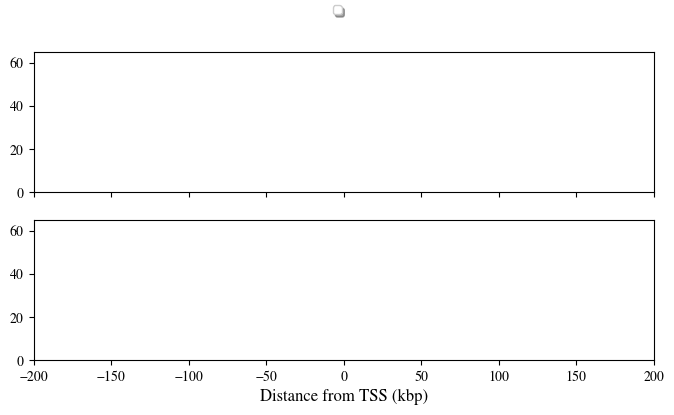

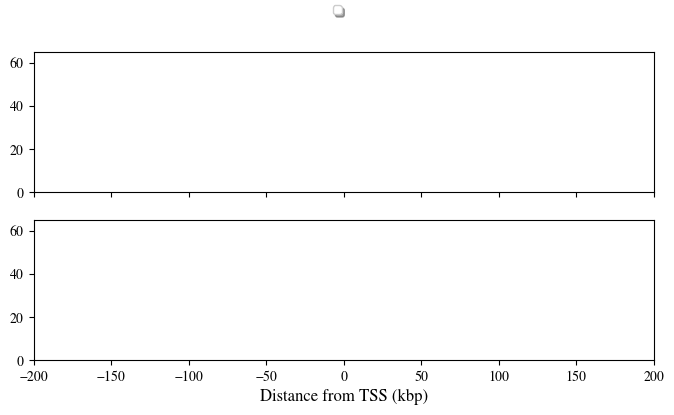

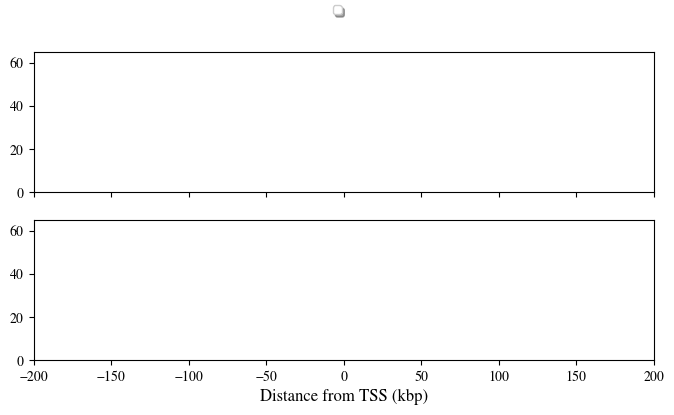

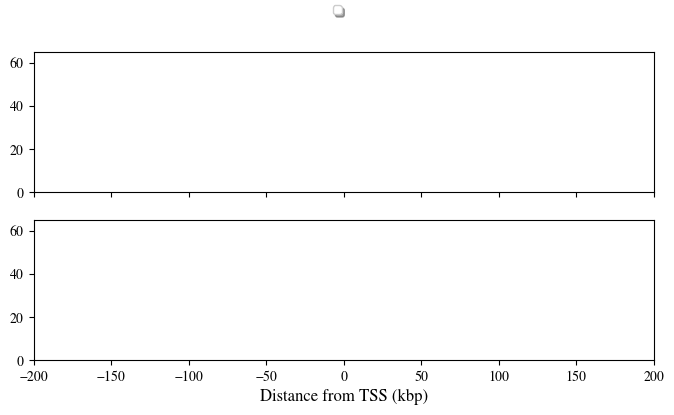

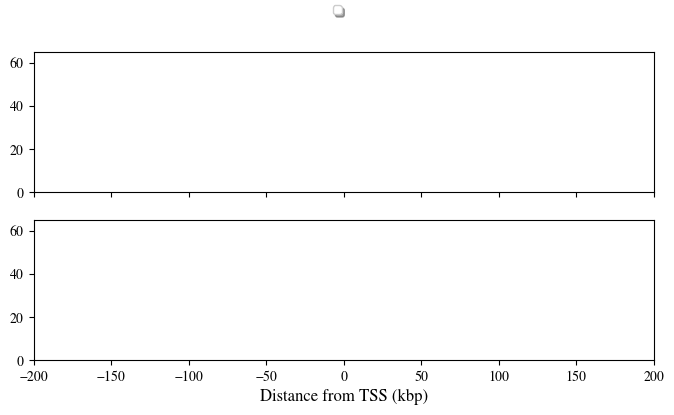

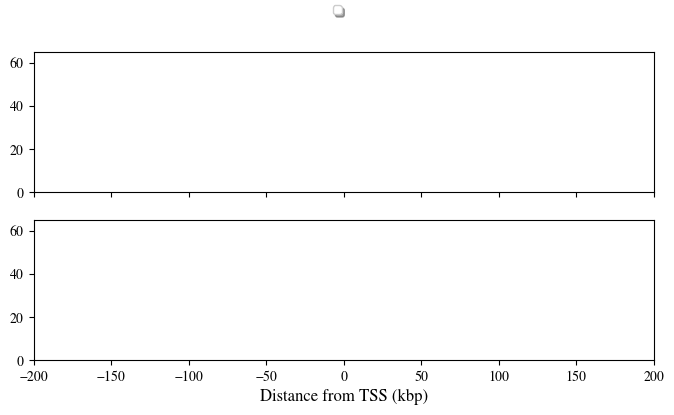

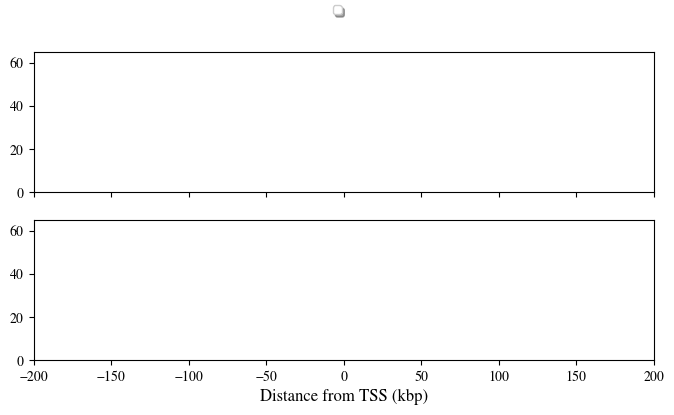

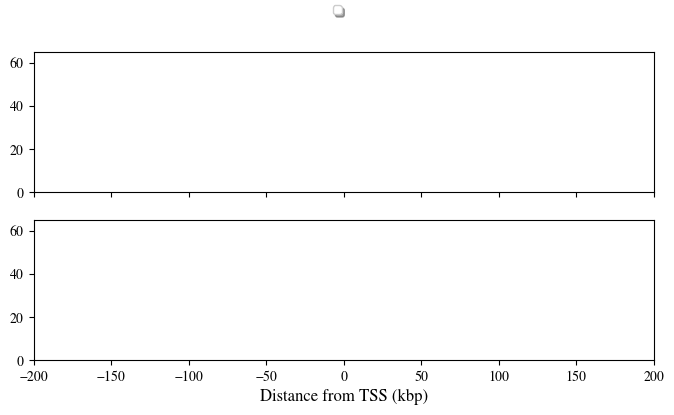

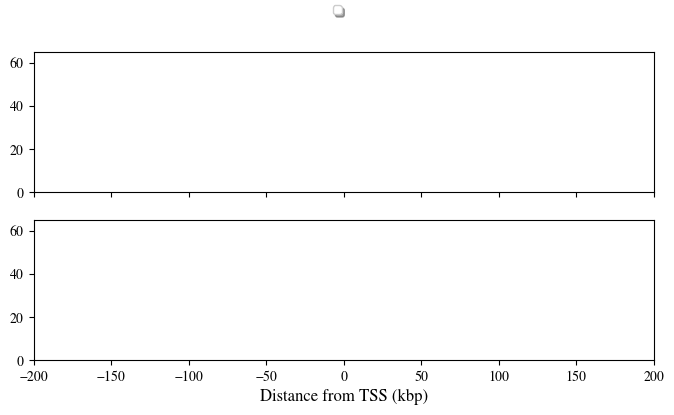

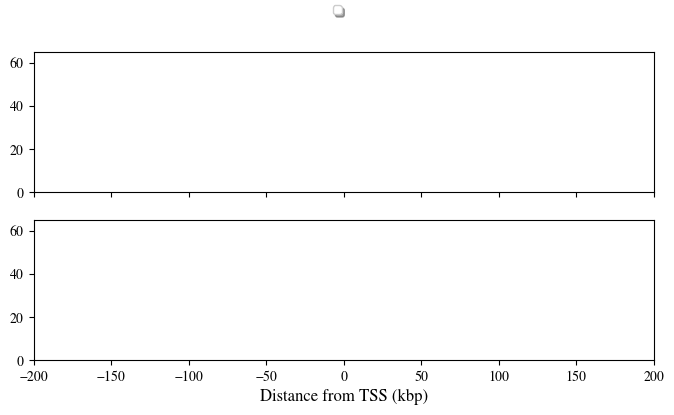

In [5]:
# Outputs:
figures_path = Path("../figures/Figures_revisions/")
#ID = ENSMUSG00000090115.7_rev ENSMUSG00000043592.15_rev ENSMUSG00000023266.11_rev # Nice examples 'ENSMUSG00000079707.10_forward'
val_ids = pd.read_csv(Path('../annotations/manual_validation_ids_chr17.txt')).values.flatten()

for ID in val_ids[172::200]:#  ["ENSMUSG00000090115.7_forward", "ENSMUSG00000043592.15_forward", "ENSMUSG00000023266.11_forward"]: #val_ids[::8]:
    predictions = []
    actual_data = []
    for k, (title, attributes) in  enumerate(results_path_dict.items()):
        if "training" in title:
            #print(title)
            ids, predicted, actual = _get_predictions(attributes['path'],
                                                    attributes['N_BINS'],
                                                    ["_ctrl"], 
                                                    is_training=attributes['is_training'], 
                                                    batch_num=attributes['batch_num'])
            
            line_p = predicted.loc[ID]
            predictions.append({'profile':line_p,
                                'color': attributes['color'],
                                'alpha': 0.2,
                                'label': f"Predicted {attributes['label']}",
                                'ls':'-'
            })

            EU_seq_colors = ["k","red"]
            # Actual baseline signal:
            actual_data.append({
                'profile': actual.loc[ID],
                'color': EU_seq_colors[k],
                'alpha': 0.2,
                'label': f"EU-seq {attributes['label']}",
                'ls':'-'
            })

    # Create plot
    fig = plot_generalized_predictions(predictions, actual_data, N_BINS=200)
    fig.savefig(figures_path / 'Outputs' / f'Model_predictions_{ID}.png', dpi=200)


**Visualize attributions of the new models:**

In [8]:
figure_path = Path("../figures/Figures_revisions/attributions/")

plt.rcParams.update({'font.size': 10})  # Adjust the size as needed

def read_target_attributions(results_path: Path,
                             figure_path: Path,
                             track_dict: dict,
                             N_BINS: int,
                             l_in:int = 10001,
                             n_in: int=4,
                             TRAIN_ATTR: bool = True,
                             SPLIT: int = None):

    """
    This function is aimed to read attribution arrays from the chromatin landscape branch. Attribution arrays score the 
    contribution of each position in the input arrays (4,10.001) towards each output node/position (401).
    Args:
        results_path: path where the attribution arrays are stored.
        figure_path: path where we want to store the outputs
        track_dict: dictionary containing the names of the tracks and plot details
        N_BINS: number of bins to one side of the central bin (200 normally)
        l_in: input length 
        n_in: number of input channels
        TRAIN_ATTR: whether this is a training or test run (folder structure changes).
        SPLIT: if Train, we need to know which of the stored batches it is

    Returns:
        Plots with attribution scores.
    """
    figure_path.mkdir(exist_ok=True, parents=True)

    N_IN_BINS = l_in // 2
    x_val = np.arange(-N_IN_BINS,N_IN_BINS+1)
    xlim = (-500,500)

    # Getting attributions:
    condition_list = ["_ctrl"]
    landscape_avg = {condition : np.zeros((n_in,l_in)) for condition in condition_list}

    for i in range(-N_BINS, N_BINS + 1):
        for condition in condition_list:
            # CHROMATIN MARK ATTRIBUTIONS:
            added_folders = f"/samples/{SPLIT}" if TRAIN_ATTR else "" # Different folder structure
            att_path = Path(results_path / f"{i}{condition}{added_folders}/attributions/gene_expression/{i}{condition}.npy")
            if os.path.exists(att_path):
                attributions = np.load(att_path)
                #if (i == -73) and (condition == "_ctrl"):
                fig, axs = plt.subplots(4, figsize=(8,2.7)) 
                for j,key in enumerate(track_dict.keys()):
                    name = track_dict[key]["name"]
                    axs[j].plot(x_val, abs(attributions[j]), label=name, lw=0, marker='o', markersize=0.8, markeredgecolor="none", color=track_dict[key]["color"])
                    axs[j].set_xlim((-5000,5001))
                    axs[j].set_ylim((0,np.max(attributions[1])))
                    axs[j].set_yticks([])
                    axs[-1].set_yticks([0,np.max(attributions[1])],[0,1])
                #fig.savefig(figure_path / f"Chromatin_landscape_attributions_{i}_ctrl.png",dpi=200)
                plt.close(fig)

                # Add a small phase to remove high frequency fluctuations:
                eps = 10*np.random.rand(1)*np.random.choice([-1,1])
                
                centered_attr = np.roll(attributions, -10*i+int(eps),axis=1)
                landscape_avg[condition] += 1/(2*N_BINS + 1)*(abs(centered_attr))

    SCALING_FACTOR = np.max([landscape_avg[cond] for cond in condition_list])

    for condition in condition_list:
        fig, ax = plt.subplots(figsize=(8,2.7))   # 
        sub_axes = plt.axes([.615, .57, .27, .27])  
        for i,key in enumerate(track_dict.keys()):
            name = track_dict[key]["name"]
            ax.plot(x_val, landscape_avg[condition][i]/SCALING_FACTOR, label=name, lw=0, marker='o', markersize=2, markeredgecolor="none", color=track_dict[key]["color"])
            sub_axes.plot(x_val, landscape_avg[condition][i]/SCALING_FACTOR, label=name, lw=0,marker='o',markersize=.5,markeredgecolor="none", color=track_dict[key]["color"])
        
        #sub_axes.set_xlim(xlim)
        sub_axes.set_xticks(np.arange(-5000,5001,5000),np.arange(-500,501,500))
        sub_axes.set_xlim((-5000,5000))
        sub_axes.set_yticks([])
        ax.set_xlim(xlim)
        ax.set_ylim(0,1) #(0,.002))
        ax.legend(loc='upper left')
        ax.set_ylabel("Attribution score")
        ax.set_xlabel("Distance to the predicted locus (kbp)")
        plt.subplots_adjust(bottom=0.2)
        plt.tight_layout()
        ax.set_xticks(np.arange(-400,401,100),np.arange(-40,41,10))
        fig.savefig(figure_path / f"Landscape_absolute_average_{condition}.png", dpi=200)
        plt.close(fig)

# Visualize for the runs for which we have attributions available.
for title, attributes in results_path_dict.items():
    if attributes["attributions"]:
        if title == "Only Chromatin Pure Convolutions no H3K27ac test": # one input track less
            track_dict = {0:{"name":"ATAC-seq","function":"Chromatin accessibility","color":"k"},
            1:{"name":"H3K4me3","function":"Promoter","color":"r"},
            2:{"name":"H3K27me3","function":"Chromatin silencing","color":"g"}}
            
            read_target_attributions(results_path = attributes["path"] / "expression_output",
                                figure_path=figure_path,
                                track_dict=track_dict,
                                N_BINS = attributes["N_BINS"],
                                l_in= 10001,
                                n_in=3,
                                TRAIN_ATTR = False,
                                SPLIT = None)
        else:
            track_dict = {0:{"name":"ATAC-seq","function":"Chromatin accessibility","color":"k"},
            1:{"name":"H3K4me3","function":"Promoter","color":"r"},
            2:{"name":"H3K27ac","function":"Enhancer","color":"b"},
            3:{"name":"H3K27me3","function":"Chromatin silencing","color":"g"}}
            read_target_attributions(results_path = attributes["path"] / "expression_output",
                    figure_path=figure_path,
                    track_dict=track_dict,
                    N_BINS = attributes["N_BINS"],
                    l_in= 10001,
                    n_in=4,
                    TRAIN_ATTR = False,
                    SPLIT = None)



/scratch/ipykernel_3833147/2664724846.py:62: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  centered_attr = np.roll(attributions, -10*i+int(eps),axis=1)
/scratch/ipykernel_3833147/2664724846.py:85: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


## V) Performance evaluations:

The following section is aimed to provide a more comprehensive and rigorous overview of CLASTER's predictive performance. 

- Performance is evaluated using $R^2$, $MSE$, $RMSE$, $MAE$, $Pearson$ and $Spearman$ for all CLASTER models. 
- Performance is reported before and after zero clipping using the ReLU activation.
- Perfomance is reported with and without log2(1+x) transforming the clipped predictions.


**Showing that unclipped profiles show values close to zero.**

Predictions below zero are not too negative. Therefore, the difference between clipped and unclipped profiles in terms of standard performance metrics is not that pronounced.

In [ ]:
outputs_path = Path("../runs/test_runs/gene_expression_only_chrom_pure_conv/")
figures_path = Path("../figures/Figures_revisions/")

EXAMPLE_GENE = "ENSMUSG00000003032.8_forward.npy" #<- KLF4 # Akirin2: "ENSMUSG00000028291.7_forward.npy"

input_id_list = ["ENSMUSG00000028291.7_forward"]

# Outputs:
ids, predicted, actual = _get_predictions(outputs_path, N_BINS=200, condition_list = ["_ctrl"], CLIP= False)

for ID,line_p,line_a in zip(ids,predicted.values,actual.values):   
    if ID in input_id_list:
        line_p = predicted.loc[ID]
        line_a = actual.loc[ID]
        fig = plot_target_predictions(line_p, line_a)
        fig.savefig(figures_path / 'Outputs' / f"{ID}_prediction_unclipped.png", dpi=200)
        plt.close(fig)

**Calculating new performance metrics:**

- We will use parallel processing to speed up computations

In [ ]:
%%writefile create_evaluation_metrics_table.py
#!/usr/bin/env python
import multiprocessing as mp
from pathlib import Path
import pandas as pd
import numpy as np
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from typing import Dict, List, Tuple, Optional, Any

def _get_predictions(
    results_path: Path,
    N_BINS: int,
    condition_list: List[str],
    is_training: bool = False,
    batch_num: Optional[int] = None,
    CLIP: bool = True
) -> Tuple[List[str], pd.DataFrame, pd.DataFrame]:
    """
    Reads prediction files from EIR for each target bin condition.
    """
    predicted_dfs = []
    actual_dfs = []
    
    for condition in condition_list:
        for i in range(-N_BINS, N_BINS + 1):
            if is_training:
                if batch_num is None:
                    raise ValueError("batch_num must be specified for training predictions")
                file_path = results_path / f"expression_output/{i}{condition}/samples/{batch_num}/regression_predictions.csv"
            else:
                file_path = results_path / f"expression_output/{i}{condition}/predictions.csv"
            
            if not file_path.exists():
                raise FileNotFoundError(f"Prediction file not found: {file_path}")
                
            predictions = pd.read_csv(file_path).set_index('ID')

            # Apply ReLU to model predictions if specified
            if CLIP:
                predictions = predictions.clip(lower=0)

            # Handle different column names for training vs test
            if is_training:
                predicted_column = predictions["Predicted"].rename(f"{i}{condition}")
                actual_column = predictions["Actual"].rename(f"{i}{condition}")
            else:
                predicted_column = predictions[f"{i}{condition} Untransformed"].rename(f"{i}{condition}")
                actual_column = predictions["True Label Untransformed"].rename(f"{i}{condition}")

            predicted_dfs.append(predicted_column)
            actual_dfs.append(actual_column)

    # Concatenate all DataFrames horizontally
    predicted = pd.concat(predicted_dfs, axis=1)
    actual = pd.concat(actual_dfs, axis=1)
    ids = list(predicted.index)

    return ids, predicted, actual

def evaluate_model(args: Tuple[str, Dict[str, Any], bool]) -> Tuple[str, str, Dict[str, float]]:
    """
    Evaluate a model using R2, MSE, RMSE, and MAE metrics
    """
    title, model_config, is_clipping = args
    state = "clipped" if is_clipping else "linear"
    
    # Extract parameters from model config
    path = model_config["path"]
    is_training = model_config["is_training"]
    n_bins = model_config["N_BINS"]
    batch_num = model_config.get("batch_num")
    
    try:
        # Get predictions with the appropriate parameters
        ids, predicted, actual = _get_predictions(
            path, 
            N_BINS=n_bins, 
            condition_list=["_ctrl"], 
            is_training=is_training, 
            batch_num=batch_num, 
            CLIP=is_clipping
        )
        
        # Calculate metrics
        metrics = {
            f'R2_{state}': round(r2_score(actual.values, predicted.values), 4),
            f'MSE_{state}': round(mean_squared_error(actual.values, predicted.values), 4),
            f'RMSE_{state}': round(np.sqrt(mean_squared_error(actual.values, predicted.values)), 4),
            f'MAE_{state}': round(mean_absolute_error(actual.values, predicted.values), 4)
        }
    except Exception as e:
        print(f"Error evaluating {title} ({state}): {str(e)}")
        metrics = {
            f'R2_{state}': np.nan,
            f'MSE_{state}': np.nan,
            f'RMSE_{state}': np.nan,
            f'MAE_{state}': np.nan
        }
    
    return (title, state, metrics)

def parallel_model_evaluation(models_dict: Dict[str, Dict[str, Any]], 
                           output_path: Path, 
                           n_processes: int = mp.cpu_count()-1) -> pd.DataFrame:
    """
    Evaluate multiple models in parallel
    """
    # Create output directory
    results_path = Path(output_path)
    results_path.mkdir(parents=True, exist_ok=True)
    
    # Prepare arguments for parallel processing
    tasks = []
    for title, config in models_dict.items():
        # Add task for linear evaluation
        tasks.append((title, config, False))
        # Add task for clipped evaluation
        tasks.append((title, config, True))
    
    # Initialize DataFrame for results
    r2_df = pd.DataFrame(
        columns=['R2_linear', 'R2_clipped', 'MSE_linear', 'MSE_clipped', 
                'RMSE_linear', 'RMSE_clipped', 'MAE_linear', 'MAE_clipped'], 
        index=models_dict.keys()
    )
    
    # Run evaluations in parallel
    with mp.Pool(processes=n_processes) as pool:
        results = pool.map(evaluate_model, tasks)
    
    # Process results
    for title, state, metrics in results:
        for metric_name, value in metrics.items():
            r2_df.loc[title, metric_name] = value
    
    # Save results to file
    r2_df.to_csv(results_path / "performance_metrics_comparison.tsv", sep="\t")
    
    return r2_df

if __name__ == "__main__":
    # Define paths
    results_path = Path("../benchmarks/Revised_performance_metrics/")
    
    # Define models to evaluate
    results_path_dict = {
        "Only Chromatin Pure Convolutions training": {"path": Path("../runs/gene_expression_only_chrom_pure_conv/results/"),
                                                      "is_training": True,
                                                      "N_BINS": 200,
                                                      "batch_num": 60600, 
                                                      "attributions": False,
                                                      "label": "Gaussian",
                                                      "color": "blue"},
        "Only Chromatin Pure Convolution test": {"path": Path("../runs/test_runs/gene_expression_only_chrom_pure_conv/"),
                                                 "is_training": False,
                                                 "N_BINS": 200,
                                                 "batch_num": None,
                                                 "attributions": True,
                                                 "label": "CLASTER test",
                                                 "color": "blue"},
        "Only Chromatin with Attention training": {"path": Path("../runs/gene_expression_only_chrom_attention/results/"),
                                                  "is_training": True,
                                                  "N_BINS": 200,
                                                  "batch_num": 60600,
                                                  "attributions": False,
                                                  "label": "Only chrom attention",
                                                  "color": "blue"},
        "Only Chromatin with Attention test": {"path": Path("../runs/test_runs/gene_expression_only_chrom_attention/"),
                                              "is_training": False,
                                              "N_BINS": 200,
                                              "batch_num": None,
                                              "attributions": True,
                                              "label": "Only chrom attention",
                                              "color": "blue"},
        "Chromatin and Structure training": {"path": Path("../runs/gene_expression_microc_pure_conv/results/"),
                                            "is_training": True,
                                            "N_BINS": 200,
                                            "batch_num": 60600,
                                            "attributions": False,
                                            "label": "Chrom and structure",
                                            "color": "blue"},
        "Chromatin and Structure test": {"path": Path("../runs/test_runs/gene_expression_microc_pure_conv/"),
                                        "is_training": False,
                                        "N_BINS": 200,
                                        "batch_num": None,
                                        "attributions": True,
                                        "label": "Chrom and Structure",
                                        "color": "blue"},
        "Chromatin and Structure rotated training": {"path": Path("../runs/gene_expression_microc_rotated_pure_conv/results/"),
                                                   "is_training": True,
                                                   "N_BINS": 200,
                                                   "batch_num": 60600,
                                                   "attributions": False,
                                                   "label": "Chrom and Structure rotated",
                                                   "color": "blue"},
        "Chromatin and Structure rotated test": {"path": Path("../runs/test_runs/gene_expression_microc_rotated_pure_conv/"),
                                               "is_training": False,
                                               "N_BINS": 200,
                                               "batch_num": None,
                                               "attributions": True,
                                               "label": "Chrom and Structure rotated",
                                               "color": "blue"},
        "Only Chromatin Pure Convolutions Softplus SmoothL1 training": {"path": Path("../runs/gene_expression_only_chrom_pure_conv_softplus_no_bias/results/"),
                                                                       "is_training": True,
                                                                       "N_BINS": 200,
                                                                       "batch_num": 60600,
                                                                       "attributions": False,
                                                                       "label": "train Softplus SmoothL1",
                                                                       "color": "purple"},
        "Only Chromatin Pure Convolutions Softplus Poisson training": {"path": Path("../runs/gene_expression_only_chrom_pure_conv_softplus_poisson_no_bias/results/"),
                                                                     "is_training": True,
                                                                     "N_BINS": 200,
                                                                     "batch_num": 60600,
                                                                     "attributions": False,
                                                                     "label": "train Softplus Poisson",
                                                                     "color": "orange"},
        "Only Chromatin Pure Convolutions Softplus Poisson log_input=False training": {"path": Path("../runs/gene_expression_only_chrom_pure_conv_softplus_poisson_no_bias_log_input_false/results/"),
                                                                                      "is_training": True,
                                                                                      "N_BINS": 200,
                                                                                      "batch_num": 60600,
                                                                                      "attributions": False,
                                                                                      "label": "train Softplus Poisson log input false",
                                                                                      "color": "darkred"},
        "Only Chromatin Pure Convolutions 20kbp context training": {"path": Path("../runs/gene_expression_only_chrom_pure_conv_20kbp_context/results/"),
                                                                  "is_training": True,
                                                                  "N_BINS": 9,
                                                                  "batch_num": 30300,
                                                                  "attributions": False,
                                                                  "label": "train 20kb context",
                                                                  "color": "yellow"},
        "Only Chromatin Pure Convolutions 20kbp context test": {"path": Path("../runs/test_runs/gene_expression_only_chrom_pure_conv_20kbp_context_test"),
                                                              "is_training": False,
                                                              "N_BINS": 9,
                                                              "batch_num": None,
                                                              "attributions": False,
                                                              "label": "test 20kb context",
                                                              "color": "green"},
        "Only Chromatin Pure Convolutions chr19 holdout training": {"path": Path("../runs/gene_expression_only_chrom_pure_conv_chr19_holdout/results/"),
                                                                  "is_training": True,
                                                                  "N_BINS": 200,
                                                                  "batch_num": 30300,
                                                                  "attributions": False,
                                                                  "label": "train chr19 holdout",
                                                                  "color": "lightblue"},
        "Only Chromatin Pure Convolutions chr19 holdout test": {"path": Path("../runs/test_runs/gene_expression_only_chrom_pure_conv_chr19_holdout_test/"),
                                                              "is_training": False,
                                                              "N_BINS": 200,
                                                              "batch_num": None,
                                                              "attributions": True,
                                                              "label": "test chr19 holdout",
                                                              "color": "lightblue"},
        "Only Chromatin Pure Convolutions no H3K27ac training": {"path": Path("../runs/gene_expression_only_chrom_pure_conv_no_H3K27ac/results/"),
                                                               "is_training": True,
                                                               "N_BINS": 200,
                                                               "batch_num": 60600,
                                                               "attributions": False,
                                                               "label": "train no H3K27ac",
                                                               "color": "darkgreen"},
        "Only Chromatin Pure Convolutions no H3K27ac test": {"path": Path("../runs/test_runs/gene_expression_only_chrom_pure_conv_no_H3K27ac_test/"),
                                                           "is_training": False,
                                                           "N_BINS": 200,
                                                           "batch_num": None,
                                                           "attributions": True,
                                                           "label": "test no H3K27ac",
                                                           "color": "darkgreen"},
        "Only Chromatin Pure Convolutions 1kbp binning training": {"path": Path("../runs/gene_expression_only_chrom_pure_conv_1kbp_binning/results/"),
                                                                 "is_training": True,
                                                                 "N_BINS": 200,
                                                                 "batch_num": 60600,
                                                                 "attributions": False,
                                                                 "label": "1kbp binning",
                                                                 "color": "darkorange"},
        "Only Chromatin Pure Convolutions 1kbp binning test": {"path": Path("../runs/test_runs/gene_expression_only_chrom_pure_conv_1kbp_binning_test/"),
                                                             "is_training": False,
                                                             "N_BINS": 200,
                                                             "batch_num": None,
                                                             "attributions": True,
                                                             "label": "test 1kbp binning",
                                                             "color": "darkblue"},
        "Only Chromatin Pure Convolutions K562 RNA-seq training": {"path": Path("../runs/gene_expression_only_chrom_K562_train/results/"),
                                                                 "is_training": True,
                                                                 "N_BINS": 200,
                                                                 "batch_num": 60600,
                                                                 "attributions": False,
                                                                 "label": "K562 RNA-seq",
                                                                 "color": "darkorange"},
        "Only Chromatin Pure Convolutions K562 POLR2A training": {"path": Path("../runs/gene_expression_only_chrom_K562_POLR2A_train/results/"),
                                                                "is_training": True,
                                                                "N_BINS": 200,
                                                                "batch_num": 30300,
                                                                "attributions": False,
                                                                "label": "K562 POLR2A",
                                                                "color": "darkblue"},
        "Chromatin and Prom-CHiC training": {"path": Path("../runs/gene_expression_prom_CHiC_pure_conv/results/"),
                                            "is_training": True,
                                            "N_BINS": 200,
                                            "batch_num": 60600,
                                            "attributions": False,
                                            "label": "Prom-CHiC",
                                            "color": "blue"},
        "Chromatin and Prom-CHiC test": {"path": Path("../runs/test_runs/gene_expression_prom_CHiC_pure_conv_test/"),
                                        "is_training": False,
                                        "N_BINS": 200,
                                        "batch_num": None,
                                        "attributions": True,
                                        "label": "Prom CHiC test",
                                        "color": "darkblue"}
    }
    
    # Run evaluation with parallel processing
    results = parallel_model_evaluation(results_path_dict, results_path)
    print(results)

**Adding Pearson and Spearman correlations:**

In [10]:
%%writefile create_evaluation_metrics_table.py
#!/usr/bin/env python
import multiprocessing as mp
from pathlib import Path
import pandas as pd
import numpy as np
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from scipy.stats import spearmanr, pearsonr
from typing import Dict, List, Tuple, Optional, Any

def _get_predictions(
    results_path: Path,
    N_BINS: int,
    condition_list: List[str],
    is_training: bool = False,
    batch_num: Optional[int] = None,
    CLIP: bool = True,
    include_rev: bool = False
) -> Tuple[List[str], pd.DataFrame, pd.DataFrame]:
    """
    Reads prediction files from EIR for each target bin condition.
    
    Args:
        results_path: Path to the results directory
        N_BINS: Number of bins to read
        condition_list: List of conditions to read
        is_training: Whether to read training or test predictions
        batch_num: Batch number for training predictions
        CLIP: Whether to clip predictions to non-negative values
        include_rev: Whether to include reversed samples (for data augmentation)
    """
    predicted_dfs = []
    actual_dfs = []
    
    for condition in condition_list:
        for i in range(-N_BINS, N_BINS + 1):
            if is_training:
                if batch_num is None:
                    raise ValueError("batch_num must be specified for training predictions")
                file_path = results_path / f"expression_output/{i}{condition}/samples/{batch_num}/regression_predictions.csv"
            else:
                file_path = results_path / f"expression_output/{i}{condition}/predictions.csv"
            
            if not file_path.exists():
                raise FileNotFoundError(f"Prediction file not found: {file_path}")
                
            predictions = pd.read_csv(file_path).set_index('ID')
            
            # Filter out samples with IDs containing "_rev" if requested
            if not include_rev:
                predictions = predictions[~predictions.index.str.contains("_rev")]

            # Apply ReLU to model predictions if specified
            if CLIP:
                predictions = predictions.clip(lower=0)

            # Handle different column names for training vs test
            if is_training:
                predicted_column = predictions["Predicted"].rename(f"{i}{condition}")
                actual_column = predictions["Actual"].rename(f"{i}{condition}")
            else:
                predicted_column = predictions[f"{i}{condition} Untransformed"].rename(f"{i}{condition}")
                actual_column = predictions["True Label Untransformed"].rename(f"{i}{condition}")

            predicted_dfs.append(predicted_column)
            actual_dfs.append(actual_column)

    # Concatenate all DataFrames horizontally
    predicted = pd.concat(predicted_dfs, axis=1)
    actual = pd.concat(actual_dfs, axis=1)
    ids = list(predicted.index)

    return ids, predicted, actual

def evaluate_model(args: Tuple[str, Dict[str, Any], bool]) -> Tuple[str, str, Dict[str, float]]:
    """
    Evaluate a model using R2, MSE, RMSE, MAE, Spearman correlation, and Pearson correlation metrics
    """
    title, model_config, is_clipping = args
    state = "clipped" if is_clipping else "linear"
    
    # Extract parameters from model config
    path = model_config["path"]
    is_training = model_config["is_training"]
    n_bins = model_config["N_BINS"]
    batch_num = model_config.get("batch_num")
    
    try:
        # Get predictions with the appropriate parameters
        ids, predicted, actual = _get_predictions(
            path, 
            N_BINS=n_bins, 
            condition_list=["_ctrl"], 
            is_training=is_training, 
            batch_num=batch_num, 
            CLIP=is_clipping
        )
        
        # Flatten matrices for correlation calculations
        actual_flat = actual.values.flatten()
        predicted_flat = predicted.values.flatten()
        
        # Calculate metrics
        metrics = {
            f'R2_{state}': round(r2_score(actual.values, predicted.values), 4),
            f'MSE_{state}': round(mean_squared_error(actual.values, predicted.values), 4),
            f'RMSE_{state}': round(np.sqrt(mean_squared_error(actual.values, predicted.values)), 4),
            f'MAE_{state}': round(mean_absolute_error(actual.values, predicted.values), 4),
            f'Spearman_{state}': round(spearmanr(actual_flat, predicted_flat)[0], 4),
            f'Pearson_{state}': round(pearsonr(actual_flat, predicted_flat)[0], 4)
        }

        # Calculate metrics log2(x+1): 
        # metrics = {
        #     f'R2_{state}': round(r2_score(np.log2(actual.values+1), np.log2(predicted.values+1)), 4),
        #     f'MSE_{state}': round(mean_squared_error(np.log2(actual.values+1), np.log2(predicted.values+1)), 4),
        #     f'RMSE_{state}': round(np.sqrt(mean_squared_error(np.log2(actual.values+1), np.log2(predicted.values+1))), 4),
        #     f'MAE_{state}': round(mean_absolute_error(np.log2(actual.values+1), np.log2(predicted.values+1)), 4),
        #     f'Spearman_{state}': round(spearmanr(np.log2(actual_flat+1), np.log2(predicted_flat+1))[0], 4),
        #     f'Pearson_{state}': round(pearsonr(np.log2(actual_flat+1), np.log2(predicted_flat+1))[0], 4)
        # }

    except Exception as e:
        print(f"Error evaluating {title} ({state}): {str(e)}")
        metrics = {
            f'R2_{state}': np.nan,
            f'MSE_{state}': np.nan,
            f'RMSE_{state}': np.nan,
            f'MAE_{state}': np.nan,
            f'Spearman_{state}': np.nan,
            f'Pearson_{state}': np.nan
        }
    
    return (title, state, metrics)

def parallel_model_evaluation(models_dict: Dict[str, Dict[str, Any]], 
                           output_path: Path, 
                           n_processes: int = mp.cpu_count()-1) -> pd.DataFrame:
    """
    Evaluate multiple models in parallel
    """
    # Create output directory
    results_path = Path(output_path)
    results_path.mkdir(parents=True, exist_ok=True)
    
    # Prepare arguments for parallel processing
    tasks = []
    for title, config in models_dict.items():
        # Add task for linear evaluation
        tasks.append((title, config, False))
        # Add task for clipped evaluation
        tasks.append((title, config, True))
    
    # Initialize DataFrame for results
    r2_df = pd.DataFrame(
        columns=['R2_linear', 'R2_clipped', 'MSE_linear', 'MSE_clipped', 
                'RMSE_linear', 'RMSE_clipped', 'MAE_linear', 'MAE_clipped',
                'Spearman_linear', 'Spearman_clipped', 'Pearson_linear', 'Pearson_clipped'], 
        index=models_dict.keys()
    )
    
    # Run evaluations in parallel
    with mp.Pool(processes=n_processes) as pool:
        results = pool.map(evaluate_model, tasks)
    
    # Process results
    for title, state, metrics in results:
        for metric_name, value in metrics.items():
            r2_df.loc[title, metric_name] = value
    
    # Save results to file
    r2_df.to_csv(results_path / "performance_metrics_comparison.tsv", sep="\t")
    
    return r2_df

if __name__ == "__main__":
    # Define paths
    results_path = Path("../benchmarks/Revised_performance_metrics/")
    
    # Define models to evaluate
    results_path_dict = {
        "Only Chromatin Pure Convolutions training": {"path": Path("../runs/gene_expression_only_chrom_pure_conv/results/"),
                                                      "is_training": True,
                                                      "N_BINS": 200,
                                                      "batch_num": 60600, 
                                                      "attributions": False,
                                                      "label": "Gaussian",
                                                      "color": "blue"},
        "Only Chromatin Pure Convolution test": {"path": Path("../runs/test_runs/gene_expression_only_chrom_pure_conv/"),
                                                 "is_training": False,
                                                 "N_BINS": 200,
                                                 "batch_num": None,
                                                 "attributions": True,
                                                 "label": "CLASTER test",
                                                 "color": "blue"},
        "Only Chromatin with Attention training": {"path": Path("../runs/gene_expression_only_chrom_attention/results/"),
                                                  "is_training": True,
                                                  "N_BINS": 200,
                                                  "batch_num": 60600,
                                                  "attributions": False,
                                                  "label": "Only chrom attention",
                                                  "color": "blue"},
        "Only Chromatin with Attention test": {"path": Path("../runs/test_runs/gene_expression_only_chrom_attention/"),
                                              "is_training": False,
                                              "N_BINS": 200,
                                              "batch_num": None,
                                              "attributions": True,
                                              "label": "Only chrom attention",
                                              "color": "blue"},
        "Chromatin and Structure training": {"path": Path("../runs/gene_expression_microc_pure_conv/results/"),
                                            "is_training": True,
                                            "N_BINS": 200,
                                            "batch_num": 60600,
                                            "attributions": False,
                                            "label": "Chrom and structure",
                                            "color": "blue"},
        "Chromatin and Structure test": {"path": Path("../runs/test_runs/gene_expression_microc_pure_conv/"),
                                        "is_training": False,
                                        "N_BINS": 200,
                                        "batch_num": None,
                                        "attributions": True,
                                        "label": "Chrom and Structure",
                                        "color": "blue"},
        "Chromatin and Structure rotated training": {"path": Path("../runs/gene_expression_microc_rotated_pure_conv/results/"),
                                                   "is_training": True,
                                                   "N_BINS": 200,
                                                   "batch_num": 60600,
                                                   "attributions": False,
                                                   "label": "Chrom and Structure rotated",
                                                   "color": "blue"},
        "Chromatin and Structure rotated test": {"path": Path("../runs/test_runs/gene_expression_microc_rotated_pure_conv/"),
                                               "is_training": False,
                                               "N_BINS": 200,
                                               "batch_num": None,
                                               "attributions": True,
                                               "label": "Chrom and Structure rotated",
                                               "color": "blue"},
        "Only Chromatin Pure Convolutions Softplus SmoothL1 training": {"path": Path("../runs/gene_expression_only_chrom_pure_conv_softplus_no_bias/results/"),
                                                                       "is_training": True,
                                                                       "N_BINS": 200,
                                                                       "batch_num": 60600,
                                                                       "attributions": False,
                                                                       "label": "train Softplus SmoothL1",
                                                                       "color": "purple"},
        "Only Chromatin Pure Convolutions Softplus Poisson training": {"path": Path("../runs/gene_expression_only_chrom_pure_conv_softplus_poisson_no_bias/results/"),
                                                                     "is_training": True,
                                                                     "N_BINS": 200,
                                                                     "batch_num": 60600,
                                                                     "attributions": False,
                                                                     "label": "train Softplus Poisson",
                                                                     "color": "orange"},
        "Only Chromatin Pure Convolutions Softplus Poisson log_input=False training": {"path": Path("../runs/gene_expression_only_chrom_pure_conv_softplus_poisson_no_bias_log_input_false/results/"),
                                                                                      "is_training": True,
                                                                                      "N_BINS": 200,
                                                                                      "batch_num": 60600,
                                                                                      "attributions": False,
                                                                                      "label": "train Softplus Poisson log input false",
                                                                                      "color": "darkred"},
        "Only Chromatin Pure Convolutions 20kbp context training": {"path": Path("../runs/gene_expression_only_chrom_pure_conv_20kbp_context/results/"),
                                                                  "is_training": True,
                                                                  "N_BINS": 9,
                                                                  "batch_num": 30300,
                                                                  "attributions": False,
                                                                  "label": "train 20kb context",
                                                                  "color": "yellow"},
        "Only Chromatin Pure Convolutions 20kbp context test": {"path": Path("../runs/test_runs/gene_expression_only_chrom_pure_conv_20kbp_context_test"),
                                                              "is_training": False,
                                                              "N_BINS": 9,
                                                              "batch_num": None,
                                                              "attributions": False,
                                                              "label": "test 20kb context",
                                                              "color": "green"},
        "Only Chromatin Pure Convolutions chr19 holdout training": {"path": Path("../runs/gene_expression_only_chrom_pure_conv_chr19_holdout/results/"),
                                                                  "is_training": True,
                                                                  "N_BINS": 200,
                                                                  "batch_num": 30300,
                                                                  "attributions": False,
                                                                  "label": "train chr19 holdout",
                                                                  "color": "lightblue"},
        "Only Chromatin Pure Convolutions chr19 holdout test": {"path": Path("../runs/test_runs/gene_expression_only_chrom_pure_conv_chr19_holdout_test/"),
                                                              "is_training": False,
                                                              "N_BINS": 200,
                                                              "batch_num": None,
                                                              "attributions": True,
                                                              "label": "test chr19 holdout",
                                                              "color": "lightblue"},
        "Only Chromatin Pure Convolutions no H3K27ac training": {"path": Path("../runs/gene_expression_only_chrom_pure_conv_no_H3K27ac/results/"),
                                                               "is_training": True,
                                                               "N_BINS": 200,
                                                               "batch_num": 60600,
                                                               "attributions": False,
                                                               "label": "train no H3K27ac",
                                                               "color": "darkgreen"},
        "Only Chromatin Pure Convolutions no H3K27ac test": {"path": Path("../runs/test_runs/gene_expression_only_chrom_pure_conv_no_H3K27ac_test/"),
                                                           "is_training": False,
                                                           "N_BINS": 200,
                                                           "batch_num": None,
                                                           "attributions": True,
                                                           "label": "test no H3K27ac",
                                                           "color": "darkgreen"},
        "Only Chromatin Pure Convolutions 1kbp binning training": {"path": Path("../runs/gene_expression_only_chrom_pure_conv_1kbp_binning/results/"),
                                                                 "is_training": True,
                                                                 "N_BINS": 200,
                                                                 "batch_num": 60600,
                                                                 "attributions": False,
                                                                 "label": "1kbp binning",
                                                                 "color": "darkorange"},
        "Only Chromatin Pure Convolutions 1kbp binning test": {"path": Path("../runs/test_runs/gene_expression_only_chrom_pure_conv_1kbp_binning_test/"),
                                                             "is_training": False,
                                                             "N_BINS": 200,
                                                             "batch_num": None,
                                                             "attributions": True,
                                                             "label": "test 1kbp binning",
                                                             "color": "darkblue"},
        "Only Chromatin Pure Convolutions K562 RNA-seq training": {"path": Path("../runs/gene_expression_only_chrom_K562_train/results/"),
                                                                 "is_training": True,
                                                                 "N_BINS": 200,
                                                                 "batch_num": 60600,
                                                                 "attributions": False,
                                                                 "label": "K562 RNA-seq",
                                                                 "color": "darkorange"},
        "Only Chromatin Pure Convolutions K562 POLR2A training": {"path": Path("../runs/gene_expression_only_chrom_K562_POLR2A_train/results/"),
                                                                "is_training": True,
                                                                "N_BINS": 200,
                                                                "batch_num": 30300,
                                                                "attributions": False,
                                                                "label": "K562 POLR2A",
                                                                "color": "darkblue"},
        "Chromatin and Prom-CHiC training": {"path": Path("../runs/gene_expression_prom_CHiC_pure_conv/results/"),
                                            "is_training": True,
                                            "N_BINS": 200,
                                            "batch_num": 60600,
                                            "attributions": False,
                                            "label": "Prom-CHiC",
                                            "color": "blue"},
        "Chromatin and Prom-CHiC test": {"path": Path("../runs/test_runs/gene_expression_prom_CHiC_pure_conv_test/"),
                                        "is_training": False,
                                        "N_BINS": 200,
                                        "batch_num": None,
                                        "attributions": True,
                                        "label": "Prom CHiC test",
                                        "color": "darkblue"}
    }
    
    # Run evaluation with parallel processing
    results = parallel_model_evaluation(results_path_dict, results_path)
    print(results)

Overwriting create_evaluation_metrics_table.py


##  VI) Data distributions 

**Visualizing data distributions:**


In [21]:
%%writefile create_data_distribution_plot.py
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from pathlib import Path
from multiprocessing import Pool, cpu_count
from functools import partial
plt.rcParams['font.family'] = 'Nimbus Roman'

savepath = Path("../figures/Figures_revisions/data_distributions_K562/")
savepath.mkdir(exist_ok=True, parents=True)

def load_single_file(filename, path, marks):
    a = np.load(path / filename)
    if True in np.isnan(a):
        print(filename)
    return {mark: a[i,:] for i, mark in enumerate(marks)}

def load_data(path):
    marks = ["ATAC", "H3K4me3", "H3K27ac", "H3K27me3"]
    filenames = [array.name for array in os.scandir(path)]
    
    load_func = partial(load_single_file, path=path, marks=marks)
    
    n_cores = cpu_count() - 1
    with Pool(processes=n_cores) as pool:
        results = pool.map(load_func, filenames)
    
    combined = {mark: [] for mark in marks}
    for result in results:
        for mark in marks:
            combined[mark].append(result[mark])
            
    return {mark: np.concatenate(arrays) for mark, arrays in combined.items()}

# Load Micro-C data - using same loading function but with single mark
def load_microc_data(path):
    filenames = [array.name for array in os.scandir(path)]
    
    load_func = partial(load_single_file, path=path, marks=["prom-CHiC"])
    
    n_cores = cpu_count() - 1
    with Pool(processes=n_cores) as pool:
        results = pool.map(load_func, filenames)
    
    combined = {"prom-CHiC": []}
    for result in results:
        combined["prom-CHiC"].append(result["prom-CHiC"])
            
    return {"prom-CHiC": np.concatenate(arrays) for mark, arrays in combined.items()}

# Define paths
training_inputs_path = Path("../inputs/landscape_arrays/K562/training/")
test_inputs_path = Path("../inputs/landscape_arrays/K562/test/")
#training_microc_path = Path("../inputs/microC/training/")
#test_microc_path = Path("../inputs/microC/test/")
training_microc_path = Path("../inputs/Promoter-CHiC/training/")
test_microc_path = Path("../inputs/Promoter-CHiC/test/")

# Load data in parallel
train = load_data(training_inputs_path)
test = load_data(test_inputs_path)

# Load EU-seq data from CSV files
train_euseq = pd.read_csv("../targets/K562/training_targets.csv",  index_col='ID').values.flatten()
test_euseq = pd.read_csv("../targets/K562/test_targets.csv",  index_col='ID').values.flatten()
# Load Micro-C data
train_microc = load_microc_data(training_microc_path)
test_microc = load_microc_data(test_microc_path)

# Create and plot subplots (2x3 grid to accommodate the EU-seq plot)
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

marks = ["ATAC", "H3K4me3", "H3K27ac", "H3K27me3"]

# Define custom bounds for each mark
bounds = {
    "ATAC": (0, 1000),
    "H3K4me3": (0, 1000),
    "H3K27ac": (0, 1000),
    "H3K27me3": (0, 1000),
    #"EU-seq": (0, 400),
    'RNA-seq':(0,1000),
    #"POLR2A": (0,1000),
    #"Micro-C": (-15,2),
    "prom-CHiC":(-15,2)
}

N_BINS = 200

eu_seq_ax = axes.flat[4]  # Move EU-seq to position 5

for (mark, ax) in zip(marks, axes.flat):
    min_bound, max_bound = bounds[mark]
    bins = np.linspace(min_bound, max_bound, N_BINS+1)  # Wider bins (step of 2 instead of 0.5)
    
    ax.hist(train[mark], bins=bins, alpha=0.5, 
            label=f'Train\nMin: {int(np.min(train[mark]))}\nMax: {int(np.max(train[mark]))}\nMedian: {int(np.median(train[mark]))}', 
            density=True)
    ax.hist(test[mark], bins=bins, alpha=0.5, 
            label=f'Test\nMin: {int(np.min(test[mark]))}\nMax: {int(np.max(test[mark]))}\nMedian: {int(np.median(test[mark]))}', 
            density=True)

    ax.set_xlim(min_bound, max_bound)
    ax.set_yscale('log')
    ax.set_aspect('auto', adjustable='box')
    
    ax.set_title(mark)
    ax.legend(bbox_to_anchor=(.8, .999), loc='upper center', ncol=1)

# Plot EU-seq distributions
min_bound, max_bound = bounds["RNA-seq"]
bins_euseq = np.linspace(min_bound, max_bound,  N_BINS+1)  # Same wider bins for consistency

eu_seq_ax.hist(train_euseq, bins=bins_euseq, alpha=0.5,
               label=f'Train\nMin: {int(np.min(train_euseq))}\nMax: {int(np.max(train_euseq))}\nMedian: {int(np.median(train_euseq))}',
               density=True)
eu_seq_ax.hist(test_euseq, bins=bins_euseq, alpha=0.5,
               label=f'Test\nMin: {int(np.min(test_euseq))}\nMax: {int(np.max(test_euseq))}\nMedian: {int(np.median(test_euseq))}',
               density=True)

eu_seq_ax.set_xlim(min_bound, max_bound)
eu_seq_ax.set_yscale('log')
eu_seq_ax.set_title('RNA-seq')
eu_seq_ax.set_aspect('auto', adjustable='box')
eu_seq_ax.legend(bbox_to_anchor=(.8, .99), loc='upper center', ncol=1)
fig.savefig(savepath / "Data_distribution-RNA.png", dpi=200, bbox_inches='tight')

# Micro-C
# Before creating the EU-seq subplot, add Micro-C plotting:
fig_microC, microc_ax = plt.subplots(1,1, figsize=(5,4)) # Use position 4 for Micro-C
min_bound, max_bound = bounds["prom-CHiC"]
bins_microc = np.linspace(min_bound, max_bound,  N_BINS+1)

microc_ax.hist(train_microc["prom-CHiC"], bins=bins_microc, alpha=0.5,
               label=f'Train\nMin: {int(np.min(train_microc["prom-CHiC"]))}\nMax: {int(np.max(train_microc["prom-CHiC"]))}\nMedian: {int(np.median(train_microc["prom-CHiC"]))}',
               density=True)
microc_ax.hist(test_microc["prom-CHiC"], bins=bins_microc, alpha=0.5,
               label=f'Test\nMin: {int(np.min(test_microc["prom-CHiC"]))}\nMax: {int(np.max(test_microc["prom-CHiC"]))}\nMedian: {int(np.median(test_microc["prom-CHiC"]))}',
               density=True)

microc_ax.set_ylim(1e-6,2e1)
microc_ax.set_yscale('log')
microc_ax.set_title('prom-CHiC')
microc_ax.legend(bbox_to_anchor=(.3, .99), loc='upper center', ncol=1)
microc_ax.set_aspect('auto', adjustable='box')

plt.tight_layout()
fig_microC.savefig(savepath / "prom_CHiC_distribution.png", dpi=200, bbox_inches='tight')

Overwriting create_data_distribution_plot.py


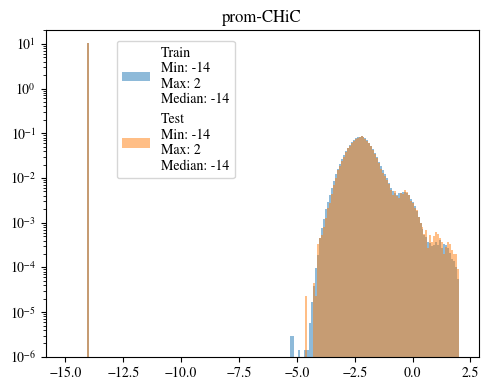

In [2]:
# Before creating the EU-seq subplot, add Micro-C plotting:

import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from pathlib import Path
from multiprocessing import Pool, cpu_count
from functools import partial
plt.rcParams['font.family'] = 'Nimbus Roman'

training_microc_path = Path("../inputs/Promoter-CHiC/training/")
test_microc_path = Path("../inputs/Promoter-CHiC/test/")
savepath = Path("../figures/Figures_revisions/data_distributions_K562/")
savepath.mkdir(exist_ok=True, parents=True)

def load_single_file(filename, path, marks):
    a = np.load(path / filename)
    if True in np.isnan(a):
        print(filename)
    return {mark: a[i,:] for i, mark in enumerate(marks)}

def load_data(path):
    marks = ["ATAC", "H3K4me3", "H3K27ac", "H3K27me3"]
    filenames = [array.name for array in os.scandir(path)]
    
    load_func = partial(load_single_file, path=path, marks=marks)
    
    n_cores = cpu_count() - 1
    with Pool(processes=n_cores) as pool:
        results = pool.map(load_func, filenames)
    
    combined = {mark: [] for mark in marks}
    for result in results:
        for mark in marks:
            combined[mark].append(result[mark])
            
    return {mark: np.concatenate(arrays) for mark, arrays in combined.items()}

# Define custom bounds for each mark
bounds = {
    "ATAC": (0, 1000),
    "H3K4me3": (0, 1000),
    "H3K27ac": (0, 1000),
    "H3K27me3": (0, 1000),
    #"EU-seq": (0, 400),
    'RNA-seq':(0,1000),
    #"POLR2A": (0,1000),
    #"Micro-C": (-15,2),
    "prom-CHiC":(-15,2)
}

# Load Micro-C data - using same loading function but with single mark
def load_microc_data(path):
    filenames = [array.name for array in os.scandir(path)]
    
    load_func = partial(load_single_file, path=path, marks=["prom-CHiC"])
    
    n_cores = cpu_count() - 1
    with Pool(processes=n_cores) as pool:
        results = pool.map(load_func, filenames)
    
    combined = {"prom-CHiC": []}
    for result in results:
        combined["prom-CHiC"].append(result["prom-CHiC"])
            
    return {"prom-CHiC": np.concatenate(arrays) for mark, arrays in combined.items()}

# Load Micro-C data
train_microc = load_microc_data(training_microc_path)
test_microc = load_microc_data(test_microc_path)

N_BINS = 200

training_microc_path = Path("../inputs/Promoter-CHiC/training/")
test_microc_path = Path("../inputs/Promoter-CHiC/test/")

fig_microC, microc_ax = plt.subplots(1,1, figsize=(5,4)) # Use position 4 for Micro-C
min_bound, max_bound = bounds["prom-CHiC"]
bins_microc = np.linspace(min_bound, max_bound,  N_BINS+1)

microc_ax.hist(train_microc["prom-CHiC"], bins=bins_microc, alpha=0.5,
               label=f'Train\nMin: {int(np.min(train_microc["prom-CHiC"]))}\nMax: {int(np.max(train_microc["prom-CHiC"]))}\nMedian: {int(np.median(train_microc["prom-CHiC"]))}',
               density=True)
microc_ax.hist(test_microc["prom-CHiC"], bins=bins_microc, alpha=0.5,
               label=f'Test\nMin: {int(np.min(test_microc["prom-CHiC"]))}\nMax: {int(np.max(test_microc["prom-CHiC"]))}\nMedian: {int(np.median(test_microc["prom-CHiC"]))}',
               density=True)

microc_ax.set_ylim(1e-6,2e1)
microc_ax.set_yscale('log')
microc_ax.set_title('prom-CHiC')
microc_ax.legend(bbox_to_anchor=(.3, .99), loc='upper center', ncol=1)
microc_ax.set_aspect('auto', adjustable='box')

plt.tight_layout()
fig_microC.savefig(savepath / "prom_CHiC_distribution.png", dpi=200, bbox_inches='tight')

**Complementary analysis of Micro-C data distribution:**


In [ ]:
%%writefile create_average_microc_matrix.py
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import os
from multiprocessing import Pool, cpu_count
from functools import partial
plt.rcParams['font.family'] = 'Nimbus Roman'

savepath = Path("../figures/Figures_revisions/")
savepath.mkdir(exist_ok=True, parents=True)

def process_single_file(filename, path):
    array = np.load(path / filename)
    return array

def main():
    path = Path("../inputs/microC/test/")
    
    # Get list of files
    filenames = [f.name for f in os.scandir(path)]
    scaling_factor = len(filenames)
    
    # Setup parallel processing
    n_cores = cpu_count() - 1
    process_file = partial(process_single_file, path=path)
    
    # Process files in parallel
    with Pool(processes=n_cores) as pool:
        results = pool.map(process_file, filenames)
    
    # Sum all arrays and apply scaling
    avg_array = np.zeros((626, 626))
    median_array = np.zeros((scaling_factor, 626, 626))
    for j,array in enumerate(results):
        avg_array += array / scaling_factor
        median_array[j] = array

    # Plot mean array
    fig = plt.figure(figsize=(6,5))
    plt.imshow(avg_array, cmap='jet')
    plt.colorbar()
    fig.savefig(savepath / 'Average_test_MicroC.png', dpi=200)
    plt.close()

    # Plot median array
    fig = plt.figure(figsize=(6,5))
    plt.imshow(np.median(median_array, axis=0), cmap='jet')
    plt.colorbar()
    fig.savefig(savepath / 'Median_test_MicroC.png', dpi=200)
    plt.close()


    # Plot histogram of values
    fig = plt.figure(figsize=(6,5))
    plt.hist(avg_array.flatten(), bins=100, density=True)
    plt.yscale('log')
    plt.xlabel('Value')
    plt.ylabel('Density')
    plt.title('Distribution of Values in Average Micro-C Matrix')
    fig.savefig(savepath / 'Average_test_MicroC_histogram.png', dpi=200)
    plt.close()

if __name__ == '__main__':
    main()

## VII) Promoter-Capture Hi-C analyses

**Process the raw data to obtain cooler contact matrices.**
- Obtain the SRA file with the raw reads corresponding to mESC Promoter-Capture HiC data:
[SRA file](https://trace.ncbi.nlm.nih.gov/Traces/?view=run_browser&acc=SRR5972844&display=data-access)
- Dump these into two separate fastq files (to build the 2D histograms).

The original microC matrices were obtained at a 1600bp resolution. Promoter Capture Hi-C has lower sequencing depth, and therefore we lowered the resolution to 5kbp in order to increase the signal intensity. The scripts to obtain cooler files can be found inside the ```prom_CHiC_processing``` folder.

Minimum and maximum values in the Promoter-Capture Hi-C dataset (at a 5kbp resolution) were 8e-4 and 8.47(log10 transformed were -3.1 and 0.92). In a similar fashion as for micro-C data, we imputed with 1e-14 to keep the imputation consistent.


-3.1009633451024556 0.9283546208429725


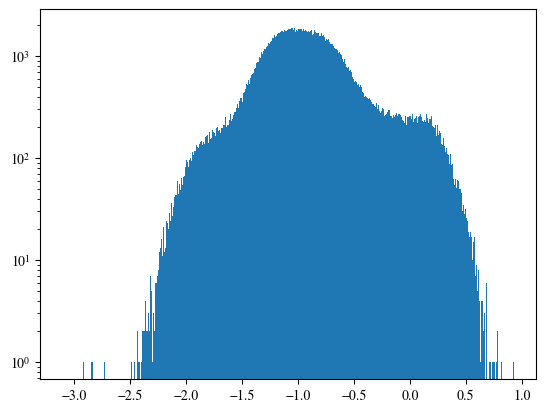

(201, 201)
-14.0 2.44088680731723


/scratch/ipykernel_2566803/264489752.py:62: RuntimeWarning: invalid value encountered in log10
  plt.hist(np.log10(c_matrix.flatten()), bins=1000)


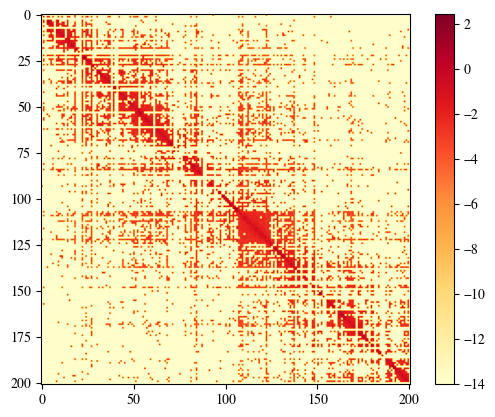

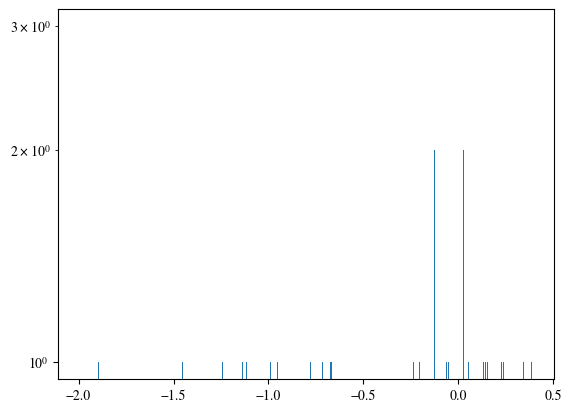

In [9]:
import cooler
from pathlib import Path
import matplotlib.pyplot as plt

def find_dataset_min_max(input_path: str) -> float:
    # Open contact file (mcool) as a cooler object
    c = cooler.Cooler(input_path)
    bin_weights = c.bins()['weight'][:]
    return (np.min(bin_weights), np.max(bin_weights))

def plot_histogram_dataset(input_path: str, bins = 1000):
    # Open contact file (mcool) as a cooler object
    c = cooler.Cooler(input_path)
    bin_weights = c.bins()['weight'][:]

    fig = plt.figure()
    plt.hist(np.log10(bin_weights), bins=bins)
    plt.yscale('log')
    plt.show()
    return fig

def mcool_summary(microc_path):
    c = cooler.Cooler(microc_path)

    # Inspecting what is inside the cooler object:
    metadata = c.info
    chromosomes = c.chromnames
    extent = c.extent('chr2')

    print("Metadata:\n", metadata)
    print("Chromosomes:\n", chromosomes)
    print("Extent:\n", extent)

input_path = "../GEO_files/SRR5972844.mm10.mapq_30.100.mcool::/resolutions/5000"
window_start = 87668723
window_end = window_start + 1000000
chrom = "chr1"
imputation_value = 1e-14

minimum, maximum = find_dataset_min_max(input_path)

print(np.log10(minimum), np.log10(maximum))
fig = plot_histogram_dataset(input_path, bins = 1000)
fig.show()

c = cooler.Cooler(input_path)
# Fetch and process the matrix
c_matrix = c.matrix(balance=True).fetch(f'{chrom}:{window_start}-{window_end}')
c_matrix = np.nan_to_num(c_matrix, nan=imputation_value)
c_matrix[c_matrix == 0.] = imputation_value
c_matrix = np.log10(c_matrix)

print(c_matrix.shape)
print(np.min(c_matrix), np.max(c_matrix))

fig = plt.figure()
plt.imshow(c_matrix, cmap='YlOrRd')
plt.colorbar()
fig.show

fig = plt.figure()
plt.hist(np.log10(c_matrix.flatten()), bins=1000)
plt.yscale('log')
plt.show()



In [ ]:
%%writefile create_prom_CHiC_arrays.py

import multiprocessing
import os
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cooler
import logging
from scipy.ndimage import rotate

########### Functions #####################################
def find_dataset_min_max(input_path: str) -> float:
    # Open contact file (mcool) as a cooler object
    c = cooler.Cooler(input_path)
    bin_weights = c.bins()['weight'][:]
    return (np.min(bin_weights), np.max(bin_weights))

def plot_histogram_dataset(input_path: str, bins = 1000):
    # Open contact file (mcool) as a cooler object
    c = cooler.Cooler(input_path)
    bin_weights = c.bins()['weight'][:]

    fig = plt.figure()
    plt.hist(bin_weights, bins=bins)
    plt.show()
    return fig

def mcool_summary(microc_path):
    c = cooler.Cooler(microc_path)

    # Inspecting what is inside the cooler object:
    metadata = c.info
    chromosomes = c.chromnames
    extent = c.extent('chr2')

    print("Metadata:\n", metadata)
    print("Chromosomes:\n", chromosomes)
    print("Extent:\n", extent)

def process_prom_CHiC_data(args):
    (gene_annotations_path, microc_path, savepath, shift, imputation_value, row) = args
    ID, chrom, Start, End, Strand, Name, CRE_type = row
    split = "test" if chrom == "chr4" else "training"
    TSS = int(Start) if Strand == '+' else int(End)

    c = cooler.Cooler(microc_path)
    window_start = TSS - shift
    window_end = TSS + shift

    try:
        # Fetch and process the matrix
        c_matrix = c.matrix(balance=True).fetch(f'{chrom}:{window_start}-{window_end}')
        c_matrix = np.nan_to_num(c_matrix, nan=imputation_value)
        c_matrix[c_matrix == 0.] = imputation_value
        c_matrix = np.log10(c_matrix)

        if c_matrix.shape == (201, 201):
            # Save direct contact matrices
            np.save(savepath / "Promoter-CHiC" / split / f"{ID}_forward.npy", c_matrix)
            anti_c_matrix = np.fliplr(np.flipud(c_matrix))
            np.save(savepath / "Promoter-CHiC" / split / f"{ID}_rev.npy", anti_c_matrix)

    except Exception as e:
        logging.info(f"{ID} raised an error: {e}")

def create_promoter_CHiC_arrays_parallel(gene_annotations_path, microc_path, savepath, shift=500000, imputation_value=1e-14):
    """
    Parallel version for creating Micro C arrays.
    """
    gene_annotations_df = pd.read_csv(gene_annotations_path, sep="\t")
    
    args = [(gene_annotations_path, microc_path, savepath, shift, imputation_value, row) for index, row in gene_annotations_df.iterrows()]

    with multiprocessing.Pool(processes=multiprocessing.cpu_count() - 1) as pool:
        pool.map(process_prom_CHiC_data, args)

if __name__ == '__main__':
    # Define paths
    path = Path("../")
    prom_CHiC_path = path /  "GEO_files/SRR5972844.mm10.mapq_30.100.mcool::/resolutions/5000"
    gene_annotations_path = path / "annotations/Final_gene_annotations.tsv"
    savepath = path / "inputs"
    savepath.mkdir(parents=True, exist_ok=True)

    # Setup logging
    LOG_FILENAME = "Prom_CHiC_data_obtention.log"
    logging.basicConfig(filename=savepath / LOG_FILENAME, level=logging.INFO, format='%(asctime)s %(message)s')

    # Create directories for output
    for split in ["training", "test"]:
        (savepath / "Promoter-CHiC" / split).mkdir(parents=True, exist_ok=True)

    # Run the processing in parallel
    create_promoter_CHiC_arrays_parallel(str(gene_annotations_path), str(prom_CHiC_path), savepath, imputation_value=1e-14)

In [ ]:
# Remove the samples for which we do not have landscape arrays in training or test folders:
# Get list of files from both reference folders
landscape_training = [file.name for file in os.scandir("../inputs/landscape_arrays/training/")]
landscape_test = [file.name for file in os.scandir("../inputs/landscape_arrays/test/")]
old_samples = landscape_training + landscape_test

# Check current directory files
for folder in os.scandir('../inputs/Promoter-CHiC/'):
    for file in os.scandir(folder):
        if file.name not in old_samples:
            print(f"Removing: {file.name}")
            os.remove(file)

**Training eir with promoter capture HiC added:**

```bash

eirtrain \
--global_configs ./configurations/conf_pure_conv_prom_CHiC_train/globals.yaml \
--input_configs ./configurations/conf_pure_conv_prom_CHiC_train/input_cnn.yaml ./configurations/conf_pure_conv_prom_CHiC_train/input_cnn_microc.yaml \
--fusion_configs ./configurations/conf_pure_conv_prom_CHiC_train/fusion.yaml \
--output_configs ./configurations/conf_pure_conv_prom_CHiC_train/outputs_2_cond.yaml
```
**Testing prom-CHiC:**

```bash

eirpredict \
--global_configs ./configurations/conf_pure_conv_prom_CHiC_test/globals.yaml \
--input_configs ./configurations/conf_pure_conv_prom_CHiC_test/input_cnn.yaml ./configurations/conf_pure_conv_prom_CHiC_test/input_cnn_microc.yaml \
--fusion_configs ./configurations/conf_pure_conv_prom_CHiC_test/fusion.yaml \
--output_configs ./configurations/conf_pure_conv_prom_CHiC_test/outputs_2_cond.yaml \
--evaluate \
--model_path ./runs/gene_expression_prom_CHiC_pure_conv/saved_models/gene_expression_prom_CHiC_pure_conv_model_60600_perf-average=0.8159.pt \
--output_folder ./runs/test_runs/gene_expression_prom_CHiC_pure_conv_test

**Visualizing contact maps and attributions for prom CHiC data:**

In [ ]:
def visualize_prom_CHiC(path):
    prom_CHiC_map = np.load(path)

    fig = plt.figure()#(11.5, 5))
    gs = gridspec.GridSpec(1, 2, hspace=.2, wspace=.1, width_ratios=(5,0.1))

    # Main image
    ax = fig.add_subplot(gs[0, 0])
    # Create an axis for the colorbar
    cax = fig.add_subplot(gs[0, 1])

    img_display = ax.imshow(prom_CHiC_map, aspect='equal', cmap="YlOrRd")
    cbar = plt.colorbar(img_display, cax=cax)

    ax.set_xlabel("Bins (5kbp resolution)", fontsize= 12)
    ax.set_ylabel("Bins (5kbp resolution)", fontsize= 12)

    return fig

def plot_prom_CHiC_attributions(figure_path, sample_ids, num_bins, window_of_observation, ATTR_type_list, conditions, sigma):
    """ 
    Plot the attribution maps for micro-c matrices.
    """
    bin_per_kbp = num_bins/window_of_observation
    print(bin_per_kbp)
    max_shift = int(200*bin_per_kbp) # Distance to crop because it was rolled from the other side
    print(max_shift)

    avg_att_mat_dict = {}
    for condition in conditions:
        avg_att_mat_dict[condition] = {}
        for ATTR_type in ATTR_type_list:
            avg_att_mat_dict[condition][ATTR_type] = np.zeros((201,201))


    for condition in conditions:
        for i in sample_ids:
            #path = Path(f"../runs/training_runs/gene_expression_exformer_unlimited_all_rotated/results/expression_output/{i}{condition}/samples/17880/attributions/contact_maps/{i}{condition}.npy") 
            path = Path(f"../runs/test_runs/gene_expression_prom_CHiC_pure_conv_test/expression_output/{i}{condition}/attributions/contact_maps/{i}{condition}.npy") 
            att_mat = np.load(path)
            att_mat_rolled = np.roll(np.roll(att_mat,-int(i*bin_per_kbp), axis = 1), -int(i*bin_per_kbp), axis = 0)

            avg_att_mat_dict[condition]["abs"] += 1/(len(sample_ids))*abs(att_mat_rolled)
            avg_att_mat_dict[condition]["signed"] += 1/(len(sample_ids))*att_mat_rolled

    for CONDITION in conditions:
        for ATTR_type in ATTR_type_list:
            avg_att_mat = avg_att_mat_dict[condition][ATTR_type] 
            #avg_att_mat = gaussian_filter(avg_att_mat, sigma=sigma)

            fig = plt.figure()#(11.5, 5))
            gs = gridspec.GridSpec(1, 2, hspace=.2, wspace=.02, width_ratios=(5,0.1))

            # Main image
            ax = fig.add_subplot(gs[0, 0])
            # Create an axis for the colorbar
            cax = fig.add_subplot(gs[0, 1])

            if ATTR_type == "abs":
                img_display = ax.imshow(avg_att_mat, aspect='equal', cmap="inferno", vmin=0, vmax=0.5e-4, origin="upper", extent=[0, 201, 201, 0])
                cbar = plt.colorbar(img_display, cax=cax)
                cbar.set_ticks([0,5e-5])
                cbar.set_ticklabels([0,1])
            else:
                img_display = ax.imshow(avg_att_mat, aspect='equal', cmap="seismic", vmin=-0.5e-4, vmax=0.5e-4, origin="upper", extent=[0, 201, 201, 0])
                cbar = plt.colorbar(img_display, cax=cax)
                cbar.set_ticks([-5e-5,0,5e-5])
                cbar.set_ticklabels([-1,0,1])
                ax.plot(np.arange(1,101), 200-np.arange(1,101), 'k--', lw=1)
                ax.plot(np.arange(1,101), 100*np.ones(100), 'b--', lw=.8)
                ax.plot(100*np.ones(100), np.arange(100,200), 'b--', lw=.8)
                ax.add_patch(patches.Rectangle((0, 0), 40, 201, linewidth = 0, fill=True, alpha=0.2, color='grey'))
                # Right edge
                ax.add_patch(patches.Rectangle((201-40, 0), 40, 201, linewidth = 0, fill=True, alpha=0.2, color='grey'))
                # Bottom edge (excluding corners already covered)
                ax.add_patch(patches.Rectangle((40, 0), 201-80, 40, linewidth = 0, fill=True, alpha=0.2, color='grey'))
                # Top edge (excluding corners already covered)
                ax.add_patch(patches.Rectangle((40, 201-40), 201-80, 40, linewidth = 0, fill=True, alpha=0.2, color='grey'))

            ax.set_xlabel("Bins (5kbp resolution)", fontsize= 12)
            ax.set_ylabel("Bins (5kbp resolution)", fontsize= 12)
            #ax.set_xlim(201,0)
            #ax.set_ylim(201,0)

            plt.tight_layout()
            fig.savefig(figure_path / f"Structural_attributions_{ATTR_type}_{CONDITION}_{sigma}.png", dpi=200)
            plt.close(fig)

0.201
40


/scratch/ipykernel_625962/1240926082.py:85: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


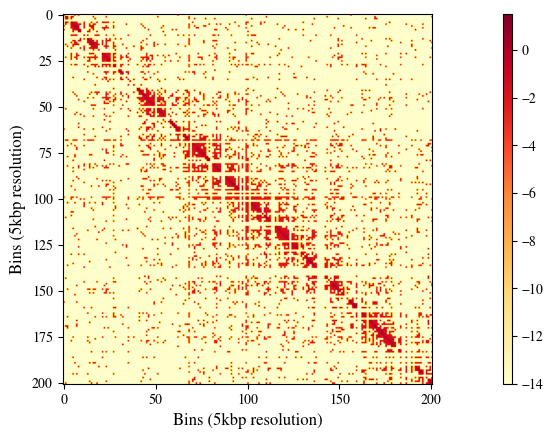

In [24]:
path = Path("../inputs/Promoter-CHiC/test/")
figure_path = Path("../figures/Figures_revisions/attributions/")
sample_ids = range(-200,201)
sample = "ENSMUSG00000028287.4_forward"
num_bins = 201
window_of_observation = 1000
ATTR_type_list = ["abs","signed"]
conditions = ["_ctrl"]
sigma = 1

fig = visualize_prom_CHiC(path / f"{sample}.npy")
fig.savefig(figure_path / f"{sample}.png", dpi=200)
plot_prom_CHiC_attributions(figure_path, sample_ids, num_bins, window_of_observation, ATTR_type_list, conditions, sigma)

## <center> VI) Extending CLASTER to new cell types: K562 (human) <center>

Reviewer 1 asked us to benchmark our _in silico_ perturbations with experimental data. Most experimental data on genome-wide enhancer KOs is obtained in K562 cells. We did not find nascent transcription data matching our protocol, and hence decided to predict two widespread transcriptional readouts: RNA-seq and POLR2A ChIP-seq.

### Predicting mature RNA-seq counts & RNA-polII ChIP-seq
- Obtain data (hg19).
- Train models.
- Evaluate performance.
- Perform downstream perturbational analyses.

In [ ]:
## Mature RNA-seq predictions: hg19
links = {#"EU_Seq_Ctrl_plus.bw":"https://www.ncbi.nlm.nih.gov/geo/download/?acc=GSM2072364&format=file&file=GSM2072364%5FENCFF001SEN%5Fplus%5Fstrand%5Fsignal%5Fhg19%2EbigWig",
         #"EU_Seq_Ctrl_minus.bw":"https://www.ncbi.nlm.nih.gov/geo/download/?acc=GSM2072364&format=file&file=GSM2072364%5FENCFF001SEO%5Fminus%5Fstrand%5Fsignal%5Fhg19%2EbigWig",
         "POLR_IIA_Ctrl.bw": "https://www.ncbi.nlm.nih.gov/geo/download/?acc=GSE91426&format=file&file=GSE91426%5FENCFF541PYW%5Fsignal%5Fp%2Dvalue%5Fhg19%2EbigWig", #Stanford ENCODE hg19
         #"ATAC_Seq.bw": "https://www.ncbi.nlm.nih.gov/geo/download/?acc=GSM4971133&format=file&file=GSM4971133%5F11283%5F11142%5F109459%5FHKLV3BGXC%5FATAC%5FATAC%5F0h%5FTTCTGC%2Ebw", #Danko
         #"H3K4me3.bw":"https://www.ncbi.nlm.nih.gov/geo/download/?acc=GSM4971098&format=file&file=GSM4971098%5FmergedMasked%5FK4me3%5F0h%5Fbr1%2Eraw%2Ebw", #Danko
         #"H3K27ac.bw":"https://www.ncbi.nlm.nih.gov/geo/download/?acc=GSM4971064&format=file&file=GSM4971064%5FmergedMasked%5FK27ac%5F0h%5Fbr1%2Eraw%2Ebw", #Danko
         #"H3K27me3.bw": "https://www.ncbi.nlm.nih.gov/geo/download/?acc=GSM4971075&format=file&file=GSM4971075%5FmergedMasked%5FK27me3%5F0h%5Fbr1%2Eraw%2Ebw"
         } #Danko

savepath = Path("../GEO_files/K562/")
savepath.mkdir(exist_ok=True, parents=True)

download_files(links, savepath)


**Gene and Enhancer annotations:**
- Gene annotations were obtained for hg19 from [gencode](https://www.gencodegenes.org/human/release_19.html) (Input data from Danko lab was mapped to hg19 originally).
- Enhancer annotations could be obtained from:
    - [Supplementary Table 10](https://static-content.springer.com/esm/art%3A10.1038%2Fs41586-020-2493-4/MediaObjects/41586_2020_2493_MOESM12_ESM.txt). 
    - We however used the [annotations from the CRISPR enhancer KOs from the Engreitz lab](https://github.com/EngreitzLab/CRISPR_comparison/blob/main/resources/crispr_data/EPCrisprBenchmark_ensemble_data_GRCh38.tsv.gz) reported in the latest E2G paper to ease the comparison. Only enhancers whose epigenetic activity was above a certain threshold were kept.
    - The coordinates of the regulatory elements were lifted using [the UCSC genome browser lifting tool](https://genome.ucsc.edu/cgi-bin/hgLiftOver) from hg38 to hg19 to match the input profiles.


In [ ]:
links = {"Gene_annotations_human.gtf.gz":"https://ftp.ebi.ac.uk/pub/databases/gencode/Gencode_human/release_19/gencode.v19.annotation.gtf.gz"}
savepath = Path("../annotations/human/")
savepath.mkdir(exist_ok=True, parents=True)

download_files(links, savepath)

! gunzip ../annotations/human/Gene_annotations_human.gtf.gz

# Create a file with annotations that correspond only to genes
! awk '$3 == "gene"' ../annotations/human/Gene_annotations_human.gtf > ../annotations/human/Filtered_gene_annotations_human.gtf

# Further filter the number of fields/columns required

file = Path("../annotations/human/Filtered_gene_annotations_human.gtf")
outfile = Path("../annotations/human/Final_gene_annotations_human.tsv")
gene_annotations = pd.read_csv(file, sep="\t", header=None)

ids = []
names = []

final_df = pd.DataFrame(columns=["ID","chr","Start","End","Strand","Name","type"]).set_index("ID")
for (chrom, _, _, start, end, _, strand, _, features) in gene_annotations.values:
    splitline =  features.split(";")

    id = splitline[0].split(" ")[1]
    gene_type = splitline[2].split(" ")[2]
    name = splitline[4].split(" ")[2]
    if gene_type == '"protein_coding"' and chrom not in ['chrM', 'chrX','chrY']: # or gene_type == '"lincRNA"':
        final_df.loc[id[1:-1]] = [chrom,start,end,strand,name[1:-1], gene_type[1:-1]]

final_df.to_csv(outfile, sep='\t')

**Manual validation ids (chr17) in human samples:**

In [ ]:
def create_validation_ids(path: Path, val_chrom: str = "chr17"):
    """ All genes encoded in chr17 will be used as a validation set."""
    gene_annotations_df = pd.read_csv(path / "Final_gene_annotations_human.tsv", sep="\t").set_index('ID')
    indices = gene_annotations_df[gene_annotations_df["chr"] == val_chrom].index

    # Prepare the strings to write in the file
    lines = [f"{index}_forward\n{index}_rev\n" for index in indices]

    # Write to the text file
    with open(path / f"manual_validation_ids_{val_chrom}_human.txt", 'w') as file:
        file.writelines(lines)

path = Path("../annotations/human/")
create_validation_ids(path)

We removed the following IDs from manual validation id file: 
- 'ENSG00000272636.1_forward', 
- 'ENSG00000272636.1_rev', 
- 'ENSG00000175711.4_forward', 
- 'ENSG00000175711.4_rev', 
- 'ENSG00000176845.8_forward', 
- 'ENSG00000176845.8_rev'. 

Causes explained in Landscape_data_obtention_human.log: the input samples are out of bounds since these genes lie at the beginning/end of the chromosome.


**Create CLASTER inputs and outputs from human (K562) samples:**

Similar code as in I_Data_Obtention.ipynb, better handling of Nans in input data.

In [ ]:
%%writefile create_landscape_arrays_and_targets_human.py

import os
import pandas as pd
import numpy as np
import pyBigWig
import matplotlib.pyplot as plt
import logging
from pathlib import Path
import multiprocessing
from scipy.ndimage import gaussian_filter1d, rotate
import numpy.ma as ma

track_dict = {0:{"name":"ATAC-seq","function":"Chromatin accessibility","color":"k"},
            1:{"name":"H3K4me3","function":"Promoter","color":"r"},
            2:{"name":"H3K27ac","function":"Enhancer","color":"b"},
            3:{"name":"H3K27me3","function":"Chromatin silencing","color":"g"}}


def clean_array(stats, max_clip=1000):
    """
    Comprehensive cleaning function for array data.
    Handles NaN, None, inf, and invalid values.
    
    Args:
        stats: Input array or list of values
        max_clip: Maximum value to clip to
    
    Returns:
        Cleaned numpy array
    """
    # Convert to numpy array if not already
    array = np.array(stats, dtype=np.float64)
    
    # Create mask for invalid values (None, NaN, inf)
    invalid_mask = (
        (array == None) | 
        np.isnan(array) | 
        np.isinf(array) |
        (array < 0)  # Negative values
    )
    
    # Replace invalid values with 0
    array[invalid_mask] = 0.0
    
    # Clip values to valid range
    array = np.clip(array, 0, max_clip)
    
    return array

def create_input_array(data_path: Path,
                      input_shift: int,
                      n_input_tracks: int, 
                      n_input_bins: int,
                      bw_input_track_list: list,
                      ID: str,
                      TSS: int,
                      chrom: str,
                      max_clip: int = 1000):
    """
    Modified input array creation with improved error handling and data cleaning.
    """
    input_sample = np.zeros((n_input_tracks, n_input_bins))  # Initialize with zeros
    
    for i, bw_path in enumerate(bw_input_track_list):
        try:
            bw = pyBigWig.open(str(data_path / bw_path), "r")
            stats = bw.stats(chrom, TSS-input_shift, TSS+input_shift, type="mean", nBins=n_input_bins)
            bw.close()
            
            # Clean the data using our comprehensive function
            input_sample[i] = clean_array(stats, max_clip)
            
        except Exception as e:
            logging.warning(f"{ID} track {i} error: {str(e)}")
            # Row already initialized to zeros, so we can continue
            continue
    
    # Final validation of the entire array
    if np.any(np.isnan(input_sample)) or np.any(np.isinf(input_sample)):
        logging.warning(f"{ID} still contains invalid values after cleaning. Setting to zero.")
        input_sample[~np.isfinite(input_sample)] = 0.0
    
    return input_sample

def create_single_target_array(data_path: Path,
                             output_shift: int,
                             n_output_bins: int,
                             bw_target_path: str,  # Single bigWig file path
                             ID: str,
                             TSS: int,
                             chrom: str,
                             sigma: int,
                             binsize: int,
                             max_clip: int = 1000):
    """
    Creates target array from a single bigWig file without summing strands.
    Used for RNA-PolII data that's already processed.
    
    Args:
        bw_target_path: String with the path to the bigWig file
    """
    try:
        # Read the data
        bw = pyBigWig.open(str(data_path / bw_target_path), "r")
        stats = bw.stats(chrom, TSS-output_shift, TSS+output_shift, 
                        type="mean", nBins=n_output_bins)
        bw.close()
        
        # Clean the data
        stats = clean_array(stats, max_clip)
        
        # Apply Gaussian smoothing
        stats = gaussian_filter1d(stats, sigma=sigma)
        
        # Initialize target condition array
        target_cond = np.zeros_like(stats)
        
        # Averaging over bins
        for i in range(binsize):
            target_cond += 1 / binsize * np.roll(stats, -i)
        target_cond = target_cond[::binsize]
        
        # Final cleanup of target condition array
        target_cond = clean_array(target_cond, max_clip)
        
        # Create forward and reverse arrays
        target_sample_pos = target_cond
        target_sample_neg = np.flip(target_cond)
        
    except Exception as e:
        logging.warning(f"{ID} RNA-PolII target processing error: {str(e)}")
        # Return arrays of appropriate size filled with zeros in case of error
        zeros = np.zeros(n_output_bins // binsize)
        target_sample_pos = zeros
        target_sample_neg = zeros
    
    # Final validation
    if np.any(np.isnan(target_sample_pos)) or np.any(np.isnan(target_sample_neg)):
        logging.warning(f"{ID} RNA-PolII targets contain NaN values after processing. Setting to zero.")
        target_sample_pos = np.nan_to_num(target_sample_pos, 0.0)
        target_sample_neg = np.nan_to_num(target_sample_neg, 0.0)
    
    return target_sample_pos.flatten(), target_sample_neg.flatten()

def create_target_array(data_path: Path,
                       output_shift: int,
                       n_output_bins: int,
                       bw_target_track_list: list,
                       ID: str,
                       TSS: int,
                       chrom: str,
                       sigma: int,
                       binsize: int,
                       max_clip: int = 1000):
    """
    Modified target array creation with improved error handling and data cleaning.
    """
    target_sample_pos = np.array([])
    target_sample_neg = np.array([])
    
    for plus_bw_path, minus_bw_path in bw_target_track_list:
        try:
            # Read plus strand data
            plus_bw = pyBigWig.open(str(data_path / plus_bw_path), "r")
            plus_stats = plus_bw.stats(chrom, TSS-output_shift, TSS+output_shift, 
                                     type="mean", nBins=n_output_bins)
            plus_bw.close()
            
            # Read minus strand data
            minus_bw = pyBigWig.open(str(data_path / minus_bw_path), "r")
            minus_stats = minus_bw.stats(chrom, TSS-output_shift, TSS+output_shift, 
                                       type="mean", nBins=n_output_bins)
            minus_bw.close()
            
            # Clean both arrays
            plus_stats = clean_array(plus_stats, max_clip)
            minus_stats = clean_array(minus_stats, max_clip)
            
            # Combine plus and minus strand signals
            combined_stats = plus_stats + minus_stats
            
            # Apply Gaussian smoothing
            combined_stats = gaussian_filter1d(combined_stats, sigma=sigma)
            
            # Initialize target condition array
            target_cond = np.zeros_like(combined_stats)
            
            # Averaging over bins
            for i in range(binsize):
                target_cond += 1 / binsize * np.roll(combined_stats, -i)
            target_cond = target_cond[::binsize]
            
            # Final cleanup of target condition array
            target_cond = clean_array(target_cond, max_clip)
            
            # Add to final arrays
            target_sample_pos = np.concatenate([target_sample_pos, target_cond])
            target_sample_neg = np.concatenate([target_sample_neg, np.flip(target_cond)])
            
        except Exception as e:
            logging.warning(f"{ID} target processing error: {str(e)}")
            # Return arrays of appropriate size filled with zeros in case of error
            zeros = np.zeros(n_output_bins // binsize)
            target_sample_pos = np.concatenate([target_sample_pos, zeros])
            target_sample_neg = np.concatenate([target_sample_neg, zeros])
    
    # Final validation
    if np.any(np.isnan(target_sample_pos)) or np.any(np.isnan(target_sample_neg)):
        logging.warning(f"{ID} targets contain NaN values after processing. Setting to zero.")
        target_sample_pos = np.nan_to_num(target_sample_pos, 0.0)
        target_sample_neg = np.nan_to_num(target_sample_neg, 0.0)
    
    return target_sample_pos.flatten(), target_sample_neg.flatten()
    
def visualize_input_array(a,
                     cropped_bins : int = 4400,
                     scaling_factor: float = 1.,
                     track_dict: dict = track_dict):

    """
    Function to visualize an input numpy array.
    """

    fig, axs = plt.subplots(len(track_dict), 2, figsize=(20,8))

    # Plot the scaled arrays
    for j,line in enumerate(a):
        # Left plots: full window
        axs[j][0].plot(np.arange(-len(line)//2,len(line)//2),line*scaling_factor, color=track_dict[j]["color"], label=track_dict[j]["name"], lw=.2)
        axs[j][0].fill_between(np.arange(-len(line)//2,len(line)//2),line*scaling_factor, color=track_dict[j]["color"], alpha=1)
        #axs[j][0].set_yticks([]) #([0,int(np.max(line))], [0,int(np.max(line))], fontsize=16)
        #axs[j][0].set_ylim(0,350)
        axs[j][0].set_ylabel(track_dict[j]["name"])
        axs[-1][0].set_xlabel("Distance to TSS (kbp)", fontsize= 16)
        # Right plots, centered window
        x_values = np.arange(-len(line)//2,len(line)//2)[cropped_bins:-cropped_bins]
        y_values = line[cropped_bins:-cropped_bins]*scaling_factor
        axs[j][1].set_xlim(x_values[0],x_values[-1])
        axs[j][1].plot(x_values,y_values, color=track_dict[j]["color"], label=track_dict[j]["name"], lw=.2)
        axs[j][1].fill_between(x_values,y_values, color=track_dict[j]["color"], alpha=.6)

    return fig
        
def visualize_target_array(a,
                           scaling_factor: float = 1.):

    """
    Function to visualize target profiles.
    """
    ctrl = a
    fig = plt.figure(figsize=(20,8))
    plt.plot(np.arange(-len(ctrl)//2,len(ctrl)//2),ctrl*scaling_factor,label="ctrl",color="grey",lw=.2)
    plt.fill_between(np.arange(-len(ctrl)//2,len(ctrl)//2),ctrl*scaling_factor, color = "silver" , alpha=1)

    return fig

def process_gene_data(data_path, bw_input_track_list, bw_target_track_list, rna_polii_track, input_shift, output_shift, 
                     n_input_bins, n_input_tracks, n_output_bins, sigma, binsize, INPUT_SHAPE, OUTPUT_LENGTH, 
                     path, split_list, figure_path, PLOT_IDS, target_files, polii_target_files, row):
    ID, chrom, Start, End, Strand, Name, CRE_type = row
    split = "test" if chrom == "chr4" else "training"
    TSS = int(Start) if Strand == '+' else int(End)

    # Create input sample
    input_sample = create_input_array(data_path, input_shift, n_input_tracks, n_input_bins, 
                                    bw_input_track_list, ID, TSS, chrom)
    
    # Create regular target samples
    target_sample_pos, target_sample_neg = create_target_array(data_path, output_shift, n_output_bins, 
                                                             bw_target_track_list, ID, TSS, chrom, sigma, binsize)
    
    # Create RNA-PolII target samples
    polii_sample_pos, polii_sample_neg = create_single_target_array(data_path, output_shift, n_output_bins,
                                                                  rna_polii_track, ID, TSS, chrom, sigma, binsize)

    if (input_sample.shape == INPUT_SHAPE) and (len(target_sample_pos) == OUTPUT_LENGTH):
        # Save input arrays
        np.save(path / "inputs" / "landscape_arrays" / "K562" / split / f"{ID}_forward.npy", input_sample)
        np.save(path / "inputs" / "landscape_arrays" / "K562" / split / f"{ID}_rev.npy", np.flip(input_sample, axis=1))
        
        # Save regular targets
        target_file_path = target_files[split]
        with open(target_file_path, 'a') as file:
            file.write(f"{ID}_forward," + ",".join(map(str, target_sample_pos)) + "\n")
            file.write(f"{ID}_rev," + ",".join(map(str, target_sample_neg)) + "\n")
        
        # Save RNA-PolII targets
        polii_file_path = polii_target_files[split]
        with open(polii_file_path, 'a') as file:
            file.write(f"{ID}_forward," + ",".join(map(str, polii_sample_pos)) + "\n")
            file.write(f"{ID}_rev," + ",".join(map(str, polii_sample_neg)) + "\n")
    else:
        logging.info(f"{ID} : Input or target did not match the expected shape.")

    if ID in PLOT_IDS:
        # Regular input/target visualizations
        fig = visualize_input_array(input_sample)
        fig.savefig(figure_path / f"{ID}_forward.png")
        fig = visualize_target_array(target_sample_pos)
        fig.savefig(figure_path / f"{ID}_forward_target.png")
        fig = visualize_input_array(np.flip(input_sample, axis=1))
        fig.savefig(figure_path / f"{ID}_rev.png")
        fig = visualize_target_array(target_sample_neg)
        fig.savefig(figure_path / f"{ID}_rev_target.png")
        
        # RNA-PolII visualizations
        fig = visualize_target_array(polii_sample_pos)
        fig.savefig(figure_path / f"{ID}_forward_polii_target.png")
        fig = visualize_target_array(polii_sample_neg)
        fig.savefig(figure_path / f"{ID}_rev_polii_target.png")

############################ Script ###################

if __name__ == '__main__':

    path = Path("../")
    data_path = path / "GEO_files" / "K562"
    figure_path = path / "figures" / "Figures_revisions" / "Inputs_and_Outputs"
    figure_path.mkdir(parents=True, exist_ok=True)
    target_path = path / "targets" / "K562"
    target_path.mkdir(exist_ok=True, parents=True)
    polii_target_path = path / "targets" / "K562" / "polii"
    polii_target_path.mkdir(exist_ok=True, parents=True)
    split_list = ["training","test"]
    output_dirs = [(path / "inputs" / "landscape_arrays" / "K562" / f"{split}").mkdir(parents=True, exist_ok = True) for split in split_list]

    PLOT_IDS = ["ENSG00000269308.1", "ENSG00000185619.13", "ENSG00000235478.1"]

    # Start logger
    LOG_FILENAME = "/Landscape_data_obtention_human.log"
    logging.basicConfig(filename=str(path) + LOG_FILENAME, level=logging.INFO)  

    gene_annotations_path = path / "annotations" / "human" / "Final_gene_annotations_human.tsv"
    gene_annotations_df = pd.read_csv(gene_annotations_path, sep="\t")

    input_shift = 500050 # In basepairs, from TSS to one side + central bin (100bp res)
    output_shift = 200010 # Output in 20 bp resolution (to be smoothed and downsampled)
    n_input_bins = 10001
    n_input_tracks = 4
    n_output_bins = 20001
    sigma = 50
    binsize = 50
    INPUT_SHAPE = (4, 10001)
    OUTPUT_LENGTH = 401 #802
    N_BINS = 200
    bw_input_track_list = ["ATAC_Seq.bw", "H3K4me3.bw", "H3K27ac.bw", "H3K27me3.bw"]
    bw_target_track_list = [("EU_Seq_Ctrl_minus.bw","EU_Seq_Ctrl_plus.bw")] 
    # Add RNA-PolII track
    rna_polii_track = "POLR_IIA_Ctrl.bw" 

    target_files = {split: ( target_path / f"{split}_targets.csv") for split in ["training", "validation", "test"]}

    # Create additional target files for RNA-PolII
    polii_target_files = {split: (polii_target_path / f"{split}_polii_targets.csv") for split in ["training", "validation", "test"]}
    # Initialize RNA-PolII target files
    for file_path in polii_target_files.values():
        with open(file_path, 'w') as file:
            file.write("ID," + ",".join([f"{i}{cond}" for cond in ["_ctrl"] for i in range(-N_BINS,N_BINS+1)]) + "\n")

    for file_path in target_files.values():
        with open(file_path, 'w') as file:
            file.write("ID," + ",".join([f"{i}{cond}" for cond in ["_ctrl"] for i in range(-N_BINS,N_BINS+1)]) + "\n")

    # Update process arguments to include the RNA-PolII track
    process_args = (data_path, bw_input_track_list, bw_target_track_list, rna_polii_track, input_shift, output_shift, 
                  n_input_bins, n_input_tracks, n_output_bins, sigma, binsize, INPUT_SHAPE, OUTPUT_LENGTH, 
                  path, ["training", "validation", "test"], figure_path, PLOT_IDS, target_files, polii_target_files)

    # Process gene data with multiprocessing
    with multiprocessing.Pool(processes=multiprocessing.cpu_count() - 1) as pool:
        pool.starmap(process_gene_data, [(process_args + (row,)) for row in gene_annotations_df.to_numpy()])

**Training the model on K562 to predict baseline RNA-seq**

```bash
eirtrain \
--global_configs ./configurations/conf_pure_conv_K562_train/globals.yaml \
--input_configs ./configurations/conf_pure_conv_K562_train/input_cnn.yaml \
--fusion_configs ./configurations/conf_pure_conv_K562_train/fusion.yaml \
--output_configs ./configurations/conf_pure_conv_K562_train/outputs_2_cond.yaml
```

**Testing the model on K562 to predict baseline RNA-seq**

```bash
eirpredict \
--global_configs ./configurations/conf_pure_conv_K562_test/globals.yaml \
--input_configs ./configurations/conf_pure_conv_K562_test/input_cnn.yaml \
--fusion_configs ./configurations/conf_pure_conv_K562_test/fusion.yaml \
--output_configs ./configurations/conf_pure_conv_K562_test/outputs_2_cond.yaml \
--evaluate \
--model_path ./runs/gene_expression_only_chrom_K562_train/saved_models/gene_expression_only_chrom_K562_train_model_60600_perf-average=0.5028.pt \
--output_folder ./runs/test_runs/gene_expression_only_chrom_K562_test
```

**Training the model on K562 to predict baseline POLR2A CHiP-seq**

```bash
eirtrain \
--global_configs ./configurations/conf_pure_conv_K562_POLR2A_train/globals.yaml \
--input_configs ./configurations/conf_pure_conv_K562_POLR2A_train/input_cnn.yaml \
--fusion_configs ./configurations/conf_pure_conv_K562_POLR2A_train/fusion.yaml \
--output_configs ./configurations/conf_pure_conv_K562_POLR2A_train/outputs_2_cond.yaml
```


**Visualize K562 predictions (RNA-seq and POLR2A)**

In [ ]:
# Outputs:
figures_path = Path("../figures/Figures_revisions/")
#ID = ENSMUSG00000090115.7_rev ENSMUSG00000043592.15_rev ENSMUSG00000023266.11_rev # Nice examples 'ENSMUSG00000079707.10_forward'
val_ids = pd.read_csv(Path('../annotations/human/manual_validation_ids_chr17_human.txt')).values.flatten()

for ID in val_ids[5::200]: #["ENSG00000166685.7_forward", "ENSG00000136436.10_forward"]: #val_ids[2::200]:#   ["ENSMUSG00000090115.7_forward", "ENSMUSG00000043592.15_forward", "ENSMUSG00000023266.11_forward"]: #val_ids[::8]:
    predictions = []
    actual_data = []
    for k, (title, attributes) in  enumerate(results_path_dict.items()):
        if "training" in title:
            #print(title)
            ids, predicted, actual = _get_predictions(attributes['path'],
                                                    attributes['N_BINS'],
                                                    ["_ctrl"], 
                                                    is_training=attributes['is_training'], 
                                                    batch_num=attributes['batch_num'])
            
            line_p = predicted.loc[ID]
            predictions.append({'profile':line_p,
                                'color': attributes['color'],
                                'alpha': 0.2,
                                'label': f"Predicted {attributes['label']}",
                                'ls':'-'
            })

            EU_seq_colors = ["k","red"]
            # Actual baseline signal:
            actual_data.append({
                'profile': actual.loc[ID],
                'color': EU_seq_colors[k],
                'alpha': 0.2,
                'label': f"Target {attributes['label']}",
                'ls':'-'
            })



    # Create plot
    fig = plot_generalized_predictions(predictions, actual_data, N_BINS=200)
    fig.savefig(figures_path / 'Outputs' / f'Model_predictions_human_{ID}.png', dpi=200)


# Visualize correlations:
for k, (title, attributes) in  enumerate(results_path_dict.items()):
    ids, predicted, actual = _get_predictions(attributes['path'],
                                        attributes['N_BINS'],
                                        ["_ctrl"], 
                                        is_training=attributes['is_training'], 
                                        batch_num=attributes['batch_num'])
    
    # Plot point-wise prediction correlations:
    pred_list_values = np.log2(np.array(predicted.values.flatten())+1) 
    actual_list_values = np.log2(np.array(actual.values.flatten())+1)
    pointwise = plot_correlations(figures_path, pred_list_values, actual_list_values, title + "_pointwise_correlation_prediction",cmap='binary', binlims=(0,10))

### Enhancer-centered analyses of RNA-seq and POLR2A binding differences after _in silico_ enhancer ablation:

>*Pipeline:*
>- Check enhancer coordinates in EPCrisprBenchmark
>- Create samples centered at those enhancers and create silenced enhancer samples
>   - We filtered out: samples with enhancer activity average (H3K27ac) below 10 reads.
>   - Samples where either input or output crossed chromosome boundaries (enhancers at the ends of the chromosomes).
>- Predict using models trained on K562 (human) data.
>- Quantify POLR2A /RNA-seq changes:
>   - For POLR2A: Integrate between 1 kbp upstream and 2 kbp downstream of all genes in predicted window.
>   - For RNA-seq: Integrate inside gene boundaries of all genes in predicted window.
>- Downstream analyses:
>   - Precision-Recall and ROC curves for the following models:
>      - Gene-enhancer distance: $Score = - Distance$
>      - RNA and POLR2A models: $Score = abs($ Area difference $)$
>   - Confusion matrices:
>      - Primary target (most affected gene in a single prediction run): True / False
>      - Closest gene: True / False

**Create enhancer centered K562 samples and targets:**

In [ ]:
%%writefile create_enhancer_centered_inputs_human.py
import os
import pandas as pd
import numpy as np
import pyBigWig
import logging
from pathlib import Path
import multiprocessing

def create_input_array(data_path: Path,
                      input_shift: int,
                      n_input_tracks: int, 
                      n_input_bins: int,
                      bw_input_track_list: list,
                      enhancer_id: str,
                      center: int,
                      chrom: str):
    """
    Creates input arrays centered at enhancer midpoint
    """
    input_sample = np.empty((n_input_tracks, n_input_bins))
    for i, bw_path in enumerate(bw_input_track_list):
        try:
            bw = pyBigWig.open(str(data_path / bw_path), "r")
            stats = bw.stats(chrom, center-input_shift, center+input_shift, type="mean", nBins=n_input_bins)
            bw.close()
            
            stats = np.array([float(value) if value is not None else 0. for value in stats])
            stats = np.clip(np.array(stats), 0, None)  # ReLU
            input_sample[i] = stats
        except Exception as e:
            logging.info(f"{enhancer_id} input landscape coordinates are out of bounds: {e}")
    
    return input_sample

def create_perturbed_array(input_array: np.ndarray, start_idx: int, end_idx: int):
    """
    Creates perturbed version with all marks except H3K27me3 silenced within enhancer boundaries
    """
    perturbed = input_array.copy()
    # Silence ATAC-seq, H3K4me3, and H3K27ac (indices 0, 1, 2) only within enhancer boundaries
    perturbed[[0, 1, 2], start_idx:end_idx] = 0
    return perturbed

def process_enhancer(data_path, bw_input_track_list, input_shift, n_input_tracks, n_input_bins, 
                    INPUT_SHAPE, path, row_data, resolution=100, activity_threshold=10):
    """
    Process a single enhancer and create its input arrays if enhancer is active
    """
    # Extract data from row
    enhancer_id = row_data['accession']
    chrom_hg19 = row_data['chrom(hg19)']
    start_hg19 = int(row_data['chromStart(hg19)'])
    end_hg19 = int(row_data['chromEnd(hg19)'])
    chrom = row_data['chrom']  # Current assembly chromosome
    
    # Use hg19 coordinates for centering
    center_hg19 = (start_hg19 + end_hg19) // 2

    # Create regular input array centered on hg19 coordinates
    input_sample = create_input_array(data_path, input_shift, n_input_tracks, n_input_bins, 
                                     bw_input_track_list, enhancer_id, center_hg19, chrom_hg19)

    if input_sample.shape == INPUT_SHAPE:
        # Calculate enhancer boundaries in array coordinates
        central_idx = n_input_bins // 2
        start_idx = central_idx + (start_hg19 - center_hg19) // resolution
        end_idx = central_idx + (end_hg19 - center_hg19) // resolution
        
        # Ensure indices are within bounds
        start_idx = max(0, start_idx)
        end_idx = min(n_input_bins, end_idx)

        # Check H3K27ac activity within enhancer boundaries
        h3k27ac_idx = 2  # Index for H3K27ac track
        enhancer_mean = np.mean(input_sample[h3k27ac_idx, start_idx:end_idx])

        if enhancer_mean > activity_threshold:
            # Create output filename based on enhancer coordinates to handle duplicates
            enhancer_coord_id = f"{chrom_hg19}_{start_hg19}_{end_hg19}"
            
            # Save regular array
            enhancer_array_path = path / "inputs" / "perturbed_landscape_arrays" / "human_enhancer_arrays" / f"{enhancer_coord_id}.npy"
            np.save(enhancer_array_path, input_sample)
            
            # Create and save perturbed array
            perturbed_sample = create_perturbed_array(input_sample, start_idx, end_idx)
            perturbed_array_path = path / "inputs" / "perturbed_landscape_arrays" / "human_enhancer_arrays" / f"{enhancer_coord_id}_perturbed.npy"
            np.save(perturbed_array_path, perturbed_sample)
            
            # Record the mapping between accession ID and enhancer coordinate ID
            return {
                'accession_id': enhancer_id,
                'enhancer_coord_id': enhancer_coord_id,
                'gene': row_data['measuredGeneSymbol'],
                'h3k27ac_mean': enhancer_mean
            }
        else:
            logging.info(f"{enhancer_id}: Enhancer activity below threshold ({enhancer_mean:.2f} ≤ {activity_threshold})")
            return None
    else:
        logging.info(f"{enhancer_id}: Input did not match the expected shape.")
        return None

if __name__ == '__main__':
    # Setup paths
    path = Path("../")
    data_path = path / "GEO_files" / "K562"

    # Create output directories
    (path / "inputs" / "perturbed_landscape_arrays" / "human_enhancer_arrays").mkdir(parents=True, exist_ok=True)

    # Start logger
    LOG_FILENAME = "/Enhancer_data_creation_human.log"
    logging.basicConfig(filename=str(path) + LOG_FILENAME, level=logging.INFO)

    # Load enhancer-promoter pair annotations
    ep_annotations_path = path / "annotations" / "human" / "lifted_hg38_to_hg19" / "EPCrisprBenchmark_ensemble_data_GRCh38_hg19.txt"
    ep_df = pd.read_csv(ep_annotations_path, sep="\t")
    
    # Make sure numeric columns are properly formatted
    # Handle potential comma issues in numeric columns
    numeric_cols = ['chromStart(hg19)', 'chromEnd(hg19)', 'chromStart', 'chromEnd', 'startTSS', 'endTSS']
    for col in numeric_cols:
        if col in ep_df.columns:
            # First convert any comma-formatted numbers to proper format
            if ep_df[col].dtype == 'object':
                ep_df[col] = ep_df[col].astype(str).str.replace(',', '.').astype(float)
    
    # Filter for specific chromosome if needed
    # Uncomment and modify the line below to filter for a specific chromosome
    # ep_df = ep_df[ep_df['chrom(hg19)'] == 'chr19']  

    # Setup parameters
    input_shift = 500050
    n_input_bins = 10001
    n_input_tracks = 4
    INPUT_SHAPE = (4, 10001)
    bw_input_track_list = ["ATAC_Seq.bw", "H3K4me3.bw", "H3K27ac.bw", "H3K27me3.bw"]
    activity_threshold = 10

    # Process enhancers in parallel
    process_args = (data_path, bw_input_track_list, input_shift, n_input_tracks, n_input_bins, 
                    INPUT_SHAPE, path)
    
    # Use multiprocessing to process enhancers
    with multiprocessing.Pool(processes=multiprocessing.cpu_count() - 1) as pool:
        results = pool.starmap(process_enhancer, 
                    [(process_args + (row, 100, activity_threshold)) for _, row in ep_df.iterrows()])
        
    # Filter out None results and create results DataFrame
    valid_results = [r for r in results if r is not None]
    
    # Create a mapping DataFrame
    mapping_df = pd.DataFrame(valid_results)
    
    # Save the mapping between accession IDs and enhancer coordinate IDs
    mapping_df.to_csv(path / "annotations" / "human" / "enhancer_mapping.tsv", sep="\t", index=False)
    
    # Count unique enhancers processed
    unique_enhancers = mapping_df['enhancer_coord_id'].nunique()
    logging.info(f"Processed {len(valid_results)} enhancer-gene pairs, representing {unique_enhancers} unique enhancers")
    print(f"Processed {len(valid_results)} enhancer-gene pairs, representing {unique_enhancers} unique enhancers")
    
    # Create dummy target files
    def get_file_ids(directory):
        """Get all file IDs from a directory without the .npy extension"""
        return [f.stem for f in Path(directory).glob('*.npy')]

    def create_unified_target_file(baseline_ids, output_path, n_bins=200):
        """Create a unified target file with zeros for both regular and perturbed IDs"""
        # Create column names
        columns = ['ID'] + [f'{i}_ctrl' for i in range(-n_bins, n_bins+1)]
        
        # Create DataFrame with zeros
        df = pd.DataFrame(0, index=range(len(baseline_ids)), columns=columns)
        
        # Fill ID column
        df['ID'] = baseline_ids
        
        # Save to CSV
        df.to_csv(output_path, index=False)
        print(f"Created {output_path} with {len(baseline_ids)} entries")

    # Setup paths for target creation
    baseline_dir = path / "inputs" / "perturbed_landscape_arrays" / "human_enhancer_arrays"
    output_dir = path / "targets" / "K562"

    # Create output directory if it doesn't exist
    output_dir.mkdir(exist_ok=True, parents=True)

    # Get IDs from both directories
    baseline_ids = get_file_ids(baseline_dir)

    # Create unified target file
    create_unified_target_file(baseline_ids,
                              output_dir / "Enhancer_centered_targets_human.csv")

**Testing the model on K562 to predict POLR2A on enhancer centered, perturbed samples**

```bash
eirpredict \
--global_configs ./configurations/conf_pure_conv_K562_POLR2A_enhancer_centric/globals.yaml \
--input_configs ./configurations/conf_pure_conv_K562_POLR2A_enhancer_centric/input_cnn.yaml \
--fusion_configs ./configurations/conf_pure_conv_K562_POLR2A_enhancer_centric/fusion.yaml \
--output_configs ./configurations/conf_pure_conv_K562_POLR2A_enhancer_centric/outputs_2_cond.yaml \
--evaluate \
--model_path ./runs/gene_expression_only_chrom_K562_POLR2A_train/saved_models/gene_expression_only_chrom_K562_POLR2A_train_model_30300_perf-average=0.5586.pt \
--output_folder ./runs/perturbation_runs/gene_expression_only_chrom_K562_POLR2A_enhancer_centric
```

**Testing the model on K562 to predict RNA-seq of enhancer-centered, perturbed samples**

>Nothing changes on globals, the only change is the model to use for the predictions, i.e. the one aimed to predict mature RNA-seq profiles, and the output folder name:

```bash
eirpredict \
--global_configs ./configurations/conf_pure_conv_K562_POLR2A_enhancer_centric/globals.yaml \
--input_configs ./configurations/conf_pure_conv_K562_POLR2A_enhancer_centric/input_cnn.yaml \
--fusion_configs ./configurations/conf_pure_conv_K562_POLR2A_enhancer_centric/fusion.yaml \
--output_configs ./configurations/conf_pure_conv_K562_POLR2A_enhancer_centric/outputs_2_cond.yaml \
--evaluate \
--model_path ./runs/gene_expression_only_chrom_K562_train/saved_models/gene_expression_only_chrom_K562_train_model_60600_perf-average=0.5028.pt \
--output_folder ./runs/perturbation_runs/gene_expression_only_chrom_K562_RNA_enhancer_centric
```

### Enhancer-gene pairing analysis on predicted RNA-seq and POLR2A Chip-seq.

In [23]:
import pandas as pd
import numpy as np
from pathlib import Path
from scipy.integrate import simps
import re
from typing import List, Tuple, Dict, Any, Callable, Optional, Union
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

def load_annotations(gene_path):
    """Load gene annotations."""
    return pd.read_csv(gene_path, sep='\t')

def _get_predictions(
    results_path: Path,
    N_BINS: int,
    condition_list: List[str],
    is_training: bool = False,
    batch_num: str = None,
    CLIP: bool = True
) -> Tuple[List[str], pd.DataFrame, pd.DataFrame]:
    """
    Reads prediction files from EIR for each target bin condition.
    
    Args:
        results_path: Path where the predictions are stored
        N_BINS: Number of bins to one side of the central bin (e.g., 200 or 57 for Enformer)
        condition_list: List of conditions (e.g., ["_ctrl"])
        is_training: If True, uses training file structure, else uses test structure
        batch_num: Batch number for training predictions (e.g., "30300")
        CLIP: If True, applies ReLU to predictions (clips at 0)
    
    Returns:
        Tuple containing:
            - ids: List of sample names
            - predicted: DataFrame of predicted untransformed values
            - actual: DataFrame of actual values
    """
    predicted_dfs = []
    actual_dfs = []
    
    for condition in condition_list:
        for i in range(-N_BINS, N_BINS + 1):
            if is_training:
                if batch_num is None:
                    raise ValueError("batch_num must be specified for training predictions")
                file_path = results_path / f"expression_output/{i}{condition}/samples/{batch_num}/regression_predictions.csv"
            else:
                file_path = results_path / f"expression_output/{i}{condition}/predictions.csv"
            
            if not file_path.exists():
                raise FileNotFoundError(f"Prediction file not found: {file_path}")
                
            predictions = pd.read_csv(file_path).set_index('ID')

            # Apply ReLU to model predictions if specified
            if CLIP:
                predictions = predictions.clip(lower=0)

            # Handle different column names for training vs test
            if is_training:
                predicted_column = predictions["Predicted"].rename(f"{i}{condition}")
                actual_column = predictions["Actual"].rename(f"{i}{condition}")
            else:
                predicted_column = predictions[f"{i}{condition} Untransformed"].rename(f"{i}{condition}")
                actual_column = predictions["True Label Untransformed"].rename(f"{i}{condition}")

            predicted_dfs.append(predicted_column)
            actual_dfs.append(actual_column)

    # Concatenate all DataFrames horizontally
    predicted = pd.concat(predicted_dfs, axis=1)
    actual = pd.concat(actual_dfs, axis=1)
    ids = list(predicted.index)

    return ids, predicted, actual

def get_window_boundaries(enhancer_center, window_size=200500):
    """Calculate window boundaries."""
    return enhancer_center - window_size, enhancer_center + window_size

def find_genes_in_window(genes_df, chrom, window_start, window_end):
    """Find genes fully contained within window."""
    return genes_df[
        (genes_df['chr'] == chrom) & 
        (genes_df['Start'] >= window_start) & 
        (genes_df['End'] <= window_end)
    ].copy()

def get_gene_tss(gene_row):
    """Get TSS position based on strand."""
    return gene_row['Start'] if gene_row['Strand'] == '+' else gene_row['End']

def calculate_distance_and_order(window_genes, enhancer_center):
    """Calculate distances to enhancer and determine gene order."""
    distances = []
    for _, gene in window_genes.iterrows():
        tss = get_gene_tss(gene)
        distance = abs(enhancer_center - tss)
        distances.append({
            'gene_id': gene['ID'],
            'distance': distance,
            'tss': tss
        })
    
    sorted_distances = sorted(distances, key=lambda x: x['distance'])
    
    return {d['gene_id']: {
        'distance': d['distance'],
        'order': idx + 1,
        'tss': d['tss']
    } for idx, d in enumerate(sorted_distances)}

def check_gene_adjacency(window_genes, distance_map, gene_id):
    """Check if a gene is adjacent to the enhancer."""
    gene_tss = distance_map[gene_id]['tss']
    gene_distance = distance_map[gene_id]['distance']
    
    for _, other_gene in window_genes.iterrows():
        if other_gene['ID'] == gene_id:
            continue
            
        other_tss = get_gene_tss(other_gene)
        other_distance = abs(other_tss - gene_tss)
        
        if other_distance < gene_distance:
            return False
            
    return True

def get_bin_coordinates(pos, enhancer_center, window_size, resolution):
    """Convert genomic position to bin coordinate."""
    rel_pos = pos - enhancer_center
    bin_pos = (rel_pos + window_size) // resolution
    return int(bin_pos)

def get_gene_bin_coordinates(gene, enhancer_center, window_size, resolution):
    """Get bin coordinates for TSS, gene start, and gene end."""
    tss = get_gene_tss(gene)
    tss_bin = get_bin_coordinates(tss, enhancer_center, window_size, resolution)
    
    start_bin = get_bin_coordinates(gene['Start'], enhancer_center, window_size, resolution)
    end_bin = get_bin_coordinates(gene['End'], enhancer_center, window_size, resolution)
    
    return tss_bin, start_bin, end_bin

# Abstract integration method for different prediction types
def calculate_area(
    predictions: np.ndarray, 
    integration_type: str,
    gene_strand: str,
    tss_bin: int = None,
    gene_start_bin: int = None,
    gene_end_bin: int = None,
    upstream_bins: int = 2,
    downstream_bins: int = 3
) -> float:
    """
    Calculate area under the curve using different integration methods.
    
    Args:
        predictions: Array of prediction values
        integration_type: Type of integration ('polr2a_tss' or 'rnaseq_gene_body')
        gene_strand: Strand of the gene ('+' or '-')
        tss_bin: Bin index of TSS (required for 'polr2a_tss')
        gene_start_bin: Start bin of gene (required for 'rnaseq_gene_body')
        gene_end_bin: End bin of gene (required for 'rnaseq_gene_body')
        upstream_bins: Number of bins to include upstream of TSS
        downstream_bins: Number of bins to include downstream of TSS
        
    Returns:
        Normalized area under the curve
    """
    total_bins = len(predictions)
    
    if integration_type == 'polr2a_tss':
        if tss_bin is None:
            raise ValueError("tss_bin must be provided for polr2a_tss integration")
            
        # For negative strand genes, swap upstream and downstream
        if gene_strand == '-':
            upstream_bins, downstream_bins = downstream_bins, upstream_bins
            
        # Define the region of interest around TSS
        start_bin = max(0, tss_bin - upstream_bins)
        end_bin = min(total_bins - 1, tss_bin + downstream_bins)
        
    elif integration_type == 'rnaseq_gene_body':
        if gene_start_bin is None or gene_end_bin is None:
            raise ValueError("gene_start_bin and gene_end_bin must be provided for rnaseq_gene_body integration")
            
        # Get bins within gene body, clipped to prediction boundaries
        start_bin = max(0, gene_start_bin)
        end_bin = min(total_bins - 1, gene_end_bin)
        
    else:
        raise ValueError(f"Unknown integration_type: {integration_type}")
        
    # Extract values in the selected region
    region_values = predictions[start_bin:end_bin + 1]
    
    if len(region_values) == 0:
        return 0
    
    # Calculate area using Simpson's rule
    x = np.arange(len(region_values))
    
    # Ensure x and y have the same dimensions before using Simpson's rule
    if len(x) < 2:
        return np.sum(region_values)  # For single point, just return the value
    
    # For arrays with only 2 points, use trapezoidal rule instead
    if len(x) == 2:
        return np.trapz(region_values, x)
    
    area = simps(region_values, x)
    
    # Normalize by length
    length = end_bin - start_bin + 1
    #return area / length if length > 0 else 0
    return area if length > 0 else 0

def process_enhancer_predictions(
    enhancer_id: str, 
    predictions_df: pd.DataFrame, 
    genes_df: pd.DataFrame, 
    integration_type: str,
    window_size: int = 200500, 
    resolution: int = 1000,
    upstream_bins: int = 2, 
    downstream_bins: int = 3
) -> List[Dict]:
    """
    Process predictions for one enhancer and its genes.
    
    Args:
        enhancer_id: ID of the enhancer
        predictions_df: DataFrame with predictions for all enhancers
        genes_df: DataFrame with gene annotations
        integration_type: Type of integration ('polr2a_tss' or 'rnaseq_gene_body')
        window_size: Size of the window around enhancer center
        resolution: Resolution of the data in base pairs per bin
        upstream_bins: Number of bins to include upstream of TSS (for polr2a_tss)
        downstream_bins: Number of bins to include downstream of TSS (for polr2a_tss)
    
    Returns:
        List of dictionaries with results for each enhancer-gene pair
    """
    # Extract enhancer information
    match = re.match(r'(chr\w+)_(\d+)_(\d+)', enhancer_id)
    
    if not match:
        print(f"Warning: Could not parse enhancer ID: {enhancer_id}")
        return []
    
    chrom, start, end = match.groups()
    start, end = int(start), int(end)
    enhancer_center = (start + end) // 2
    
    # Check if we have both regular and perturbed predictions
    perturbed_id = f"{enhancer_id}_perturbed"
    if perturbed_id not in predictions_df.index:
        print(f"Warning: Perturbed predictions not found for {enhancer_id}")
        return []
    
    # Get prediction data
    baseline_series = predictions_df.loc[enhancer_id]
    perturbed_series = predictions_df.loc[perturbed_id]
    
    # Convert series to numpy arrays for area calculation
    baseline_array = baseline_series.values
    perturbed_array = perturbed_series.values
    
    # Determine window boundaries and find genes in window
    window_start, window_end = get_window_boundaries(enhancer_center, window_size)
    window_genes = find_genes_in_window(genes_df, chrom, window_start, window_end)
    
    if len(window_genes) == 0:
        return []
    
    distance_map = calculate_distance_and_order(window_genes, enhancer_center)
    
    results = []
    
    try:
        # Calculate areas for all genes in window
        area_results = []
        
        for _, gene in window_genes.iterrows():
            gene_strand = gene['Strand']
            
            # Get necessary bin coordinates
            tss_bin, gene_start_bin, gene_end_bin = get_gene_bin_coordinates(
                gene, enhancer_center, window_size, resolution
            )
            
            # Calculate areas based on integration type
            if integration_type == 'polr2a_tss':
                baseline_area = calculate_area(
                    baseline_array, integration_type, gene_strand, 
                    tss_bin=tss_bin, upstream_bins=upstream_bins, downstream_bins=downstream_bins
                )
                perturbed_area = calculate_area(
                    perturbed_array, integration_type, gene_strand, 
                    tss_bin=tss_bin, upstream_bins=upstream_bins, downstream_bins=downstream_bins
                )
            elif integration_type == 'rnaseq_gene_body':
                baseline_area = calculate_area(
                    baseline_array, integration_type, gene_strand,
                    gene_start_bin=gene_start_bin, gene_end_bin=gene_end_bin
                )
                perturbed_area = calculate_area(
                    perturbed_array, integration_type, gene_strand,
                    gene_start_bin=gene_start_bin, gene_end_bin=gene_end_bin
                )
            else:
                raise ValueError(f"Unknown integration_type: {integration_type}")
            
            # Calculate gene length in bp
            gene_length_bp = gene['End'] - gene['Start']
            
            # Check if gene is adjacent to enhancer
            is_adjacent = check_gene_adjacency(window_genes, distance_map, gene['ID'])
            
            # Store area calculations
            area_result = {
                'gene_id': gene['ID'],
                'gene_name': gene['Name'],
                'gene_type': gene['type'],
                'gene_strand': gene_strand,
                'gene_length': gene_length_bp,
                'distance_to_enhancer': distance_map[gene['ID']]['distance'],
                'gene_order': distance_map[gene['ID']]['order'],
                'is_adjacent': is_adjacent,
                'baseline_area': baseline_area,
                'perturbed_area': perturbed_area,
                'area_difference': baseline_area - perturbed_area,
                'abs_area_difference': abs(baseline_area - perturbed_area)
            }
            
            area_results.append(area_result)
        
        # Calculate z-scores for area differences within this window
        area_diffs = [r['abs_area_difference'] for r in area_results]
        if len(area_diffs) > 1:  # Need at least 2 points for z-score
            mean_diff = np.mean(area_diffs)
            std_diff = np.std(area_diffs, ddof=1)  # Use sample standard deviation
            
            if std_diff > 0:  # Avoid division by zero
                for result in area_results:
                    result['z_score'] = (result['abs_area_difference'] - mean_diff) / std_diff
            else:
                for result in area_results:
                    result['z_score'] = 0.0
        else:
            for result in area_results:
                result['z_score'] = 0.0
        
        # Calculate ratio to maximum score
        max_diff = max(area_diffs) if area_diffs else 1.0
        if max_diff > 0:  # Avoid division by zero
            for result in area_results:
                result['ratio_to_max'] = result['abs_area_difference'] / max_diff
        else:
            for result in area_results:
                result['ratio_to_max'] = 0.0
        
        # Create final result entries
        for result in area_results:
            # Create result entry
            entry = {
                'ID': f"{enhancer_id}_{result['gene_id']}",
                'enhancer_id': enhancer_id,
                'baseline_area': result['baseline_area'],
                'perturbed_area': result['perturbed_area'],
                'area_difference': result['area_difference'],
                'abs_area_difference': result['abs_area_difference'] ,
                'z_score': result['z_score'],
                'ratio_to_max': result['ratio_to_max'],
                'gene_id': result['gene_id'],
                'gene_name': result['gene_name'],
                'distance_to_enhancer': result['distance_to_enhancer'],
                'gene_order': result['gene_order'],
                'is_adjacent': result['is_adjacent'],
                'gene_type': result['gene_type'],
                'gene_strand': result['gene_strand'],
                'gene_length': result['gene_length'],
                'integration_type': integration_type
            }
            
            results.append(entry)
            
    except Exception as e:
        print(f"Error processing enhancer {enhancer_id}: {str(e)}")

    return results

def identify_primary_target_genes(results_df, score_method='abs_area_difference'):
    """
    Identify the primary target gene for each enhancer based on the specified scoring method.
    
    Args:
        results_df: DataFrame with enhancer-gene pair results
        score_method: Scoring method to use ('abs_area_difference', 'z_score', or 'ratio_to_max')
        
    Returns:
        DataFrame with added 'is_primary_target' column
    """
    # Make a copy to avoid modifying the original
    df = results_df.copy()
    
    if score_method not in df.columns:
        print(f"Warning: Score method '{score_method}' not found in results. Using 'abs_area_difference' instead.")
        score_method = 'abs_area_difference'
    
    # Group by enhancer and find gene with maximum score
    primary_targets = df.loc[df.groupby('enhancer_id')[score_method].idxmax()]
    
    # Create a unique ID for each enhancer-gene pair
    df['pair_id'] = df['enhancer_id'] + '_' + df['gene_id']
    primary_targets['pair_id'] = primary_targets['enhancer_id'] + '_' + primary_targets['gene_id']
    
    # Mark primary target genes
    df['is_primary_target'] = df['pair_id'].isin(primary_targets['pair_id'])
    
    # Create is_closest flag (for the closest gene by distance)
    closest_genes = df.loc[df.groupby('enhancer_id')['distance_to_enhancer'].idxmin()]
    closest_genes['pair_id'] = closest_genes['enhancer_id'] + '_' + closest_genes['gene_id']
    df['is_closest'] = df['pair_id'].isin(closest_genes['pair_id'])
    
    # Remove temporary column
    df = df.drop('pair_id', axis=1)
    
    return df

def plot_confusion_matrix(results_df, score_method, output_path):
    """
    Create confusion matrix comparing primary target identification methods.
    
    Args:
        results_df: DataFrame with results including is_primary_target and is_closest flags
        score_method: Scoring method used to identify primary targets
        output_path: Path to save the visualization
    """
    # Create figure
    plt.figure(figsize=(4.5, 4.5))
    
    # Create confusion matrix
    cm = confusion_matrix(results_df['is_primary_target'], results_df['is_closest'])
    
    # Plot using seaborn
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
               xticklabels=['Not Closest', 'Closest'],
               yticklabels=['Not Primary Target', 'Primary Target'])
    
    plt.xlabel('Proximity-based Prediction')
    plt.ylabel(f'{score_method.replace("_", " ").title()}-based Prediction')
    plt.title(f'Primary Target Gene Identification: {score_method.replace("_", " ").title()} vs. Proximity')
    
    # Add accuracy and other metrics
    accuracy = (cm[0, 0] + cm[1, 1]) / cm.sum()
    plt.figtext(0.5, 0.01, f'Accuracy: {accuracy:.3f}', ha='center')
    
    # Save figure
    out_file = output_path / f'target_identification_confusion_{score_method}.png'
    plt.tight_layout()
    plt.savefig(out_file, dpi=300, bbox_inches='tight')
    plt.close()
    
    # Generate classification report
    report = classification_report(
        results_df['is_primary_target'], 
        results_df['is_closest'],
        target_names=['Not Primary Target', 'Primary Target'],
        output_dict=True
    )
    
    return {
        'confusion_matrix': cm,
        'accuracy': accuracy,
        'classification_report': report
    }

def visualize_enhancer_predictions(
    enhancer_id: str,
    predictions_df: pd.DataFrame,
    genes_df: pd.DataFrame,
    integration_type: str,
    window_size: int = 200500,
    resolution: int = 1000,
    upstream_bins: int = 1,
    downstream_bins: int = 2,
    save_path: Path = None,
    show_plot: bool = True
) -> plt.Figure:
    """
    Visualize predictions and integration domains for an enhancer.
    """
    # Extract enhancer information
    match = re.match(r'(chr\w+)_(\d+)_(\d+)', enhancer_id)
    
    if not match:
        print(f"Warning: Could not parse enhancer ID: {enhancer_id}")
        return None
    
    chrom, start, end = match.groups()
    start, end = int(start), int(end)
    enhancer_center = (start + end) // 2
    
    # Check if we have both regular and perturbed predictions
    perturbed_id = f"{enhancer_id}_perturbed"
    if perturbed_id not in predictions_df.index:
        print(f"Warning: Perturbed predictions not found for {enhancer_id}")
        return None
    
    # Get prediction data
    baseline_series = predictions_df.loc[enhancer_id]
    perturbed_series = predictions_df.loc[perturbed_id]
    
    # Get positions for x-axis (relative to enhancer center)
    bin_range = range(-window_size//resolution, window_size//resolution + 1)  # inclusive
    positions = np.array(bin_range) * resolution
    
    # Ensure positions and values arrays have the same length
    if len(positions) != len(baseline_series.values):
        # Adjust the smaller array to match the larger one
        min_length = min(len(positions), len(baseline_series.values))
        positions = positions[:min_length]
        baseline_values = baseline_series.values[:min_length]
        perturbed_values = perturbed_series.values[:min_length]
    else:
        baseline_values = baseline_series.values
        perturbed_values = perturbed_series.values
    
    # Create figure
    fig, ax = plt.subplots(figsize=(12, 4))
    
    # Plot baseline and perturbed predictions
    ax.plot(positions, baseline_values, label='Baseline', color='blue', alpha=0.7)
    ax.plot(positions, perturbed_values, label='Perturbed', color='red', alpha=0.7)
    
    # Determine window boundaries and find genes in window
    window_start, window_end = get_window_boundaries(enhancer_center, window_size)
    window_genes = find_genes_in_window(genes_df, chrom, window_start, window_end)
    
    # Mark enhancer position
    ax.axvline(x=0, color='black', linestyle='--', alpha=0.5, label='Enhancer Center')
    ax.axvspan(start - enhancer_center, end - enhancer_center, color='gray', alpha=0.2, label='Enhancer Region')
    
    # Add gene visualization
    colors = plt.cm.tab10.colors
    
    # Calculate y-axis limits for proper positioning of gene visualizations
    y_min, y_max = ax.get_ylim()
    highlight_height = 0.1 * (y_max - y_min)  # Height for visualization elements
    
    # Add legend entries for genes
    gene_legend_handles = []
    
    for i, (_, gene) in enumerate(window_genes.iterrows()):
        gene_strand = gene['Strand']
        gene_color = colors[i % len(colors)]
        
        # Get necessary bin coordinates
        tss_bin, gene_start_bin, gene_end_bin = get_gene_bin_coordinates(
            gene, enhancer_center, window_size, resolution
        )
        
        # Convert bin positions to genomic coordinates relative to enhancer center
        tss_rel = get_gene_tss(gene) - enhancer_center
        start_rel = gene['Start'] - enhancer_center
        end_rel = gene['End'] - enhancer_center
        
        # Plot TSS vertical line
        tss_line = ax.axvline(x=tss_rel, color=gene_color, linestyle='-', alpha=0.7)
        
        # Highlight integration regions based on type
        if integration_type == 'polr2a_tss':
            # For POLR2A, highlight region around TSS
            if gene_strand == '+':
                domain_start = tss_rel - (upstream_bins * resolution)
                domain_end = tss_rel + (downstream_bins * resolution)
            else:  # '-' strand
                domain_start = tss_rel - (downstream_bins * resolution)
                domain_end = tss_rel + (upstream_bins * resolution)
            
            # Shade integration domain
            ax.axvspan(domain_start, domain_end, color=gene_color, alpha=0.3)
            
        elif integration_type == 'rnaseq_gene_body':
            # For RNA-seq, highlight entire gene body
            rect_y_bottom = y_min
            rect_y_top = y_min + highlight_height
            
            # Create rectangle for gene body
            from matplotlib.patches import Rectangle
            gene_rect = Rectangle((start_rel, rect_y_bottom), end_rel - start_rel, highlight_height,
                                 facecolor=gene_color, edgecolor='none', alpha=0.3)
            ax.add_patch(gene_rect)
            
            # Add arrow to indicate strand
            arrow_y = rect_y_bottom + highlight_height / 2
            arrow_length = min(0.1 * (end_rel - start_rel), 5000)  # 10% of gene length or max 5kb
            
            if gene_strand == '+':
                arrow_x = end_rel - arrow_length
                dx = arrow_length
            else:  # '-' strand
                arrow_x = start_rel
                dx = -arrow_length
                
            ax.arrow(arrow_x, arrow_y, dx, 0, head_width=highlight_height*0.8, 
                    head_length=min(2000, arrow_length*0.3), fc=gene_color, ec=gene_color)
        
        # Create custom legend entry for this gene
        from matplotlib.patches import Patch
        gene_patch = Patch(color=gene_color, alpha=0.7, 
                         label=f"{gene['Name']} ({gene['ID']}, {gene_strand})")
        gene_legend_handles.append(gene_patch)
    
    # Set x-axis limits to match the data range
    ax.set_xlim(-window_size, window_size)
    
    # Set x-axis ticks in kbp
    x_ticks = np.arange(-window_size, window_size + 1, 50000)  # Every 50 kbp
    x_tick_labels = [f"{x/1000:.0f}" for x in x_ticks]  # Format as integer
    ax.set_xticks(x_ticks)
    ax.set_xticklabels(x_tick_labels)
    
    # Set labels and title
    ax.set_xlabel('Position relative to enhancer center (kbp)')
    ax.set_ylabel('Prediction value')
    method_name = "POLR2A around TSS" if integration_type == 'polr2a_tss' else "RNA-seq across gene body"
    ax.set_title(f'Enhancer {enhancer_id} predictions ({method_name})')
    
    # Add vertical line legend entries
    line_legend_handles, line_legend_labels = ax.get_legend_handles_labels()
    
    # Combine both legend entries
    all_handles = line_legend_handles + gene_legend_handles
    
    # Add legend (positioned outside the plot)
    ax.legend(handles=all_handles, bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
    
    # Adjust layout
    plt.tight_layout()
    
    # Save figure if path is provided
    if save_path:
        plt.savefig(save_path, bbox_inches='tight', dpi=300)
    
    # Show plot if requested
    if show_plot:
        plt.show()
    
    return fig

def visualize_primary_targets(results_df, score_method, output_path):
    """
    Visualize statistics about primary targets vs. proximity-based targets.
    
    Args:
        results_df: DataFrame with results including primary target flags
        score_method: Scoring method used to identify primary targets
        output_path: Path to save visualizations
    """
    # Create figure for distance distribution
    plt.figure(figsize=(12, 6))
    
    # Create distance histograms for primary targets vs non-primary
    sns.histplot(data=results_df, x='distance_to_enhancer', hue='is_primary_target',
                multiple='dodge', bins=30, log_scale=(False, True))
    
    plt.xlabel('Distance to Enhancer (bp)')
    plt.ylabel('Count (log scale)')
    plt.title(f'Distance Distribution: {score_method.replace("_", " ").title()} Primary Target Genes vs. Others')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(output_path / f'primary_target_distance_distribution_{score_method}.png', dpi=300, bbox_inches='tight')
    plt.close()
    
    # Create figure for gene order comparison
    plt.figure(figsize=(10, 6))
    
    # Count occurrences of each gene order for primary targets
    order_counts = results_df[results_df['is_primary_target']]['gene_order'].value_counts().sort_index()
    
    # Plot gene order distribution
    sns.barplot(x=order_counts.index, y=order_counts.values)
    
    plt.xlabel('Gene Order (by Distance)')
    plt.ylabel('Count of Primary Targets')
    plt.title(f'Distribution of {score_method.replace("_", " ").title()} Primary Target Genes by Distance Order')
    plt.grid(True, alpha=0.3, axis='y')
    plt.tight_layout()
    plt.savefig(output_path / f'primary_target_order_distribution_{score_method}.png', dpi=300, bbox_inches='tight')
    plt.close()

def batch_process_enhancers(
    enhancer_ids: List[str],
    predictions_df: pd.DataFrame,
    genes_df: pd.DataFrame,
    integration_type: str,
    output_path: Path,
    visualize_top_n: int = 10,
    score_methods: List[str] = ['abs_area_difference', 'z_score', 'ratio_to_max'],
    **kwargs
) -> pd.DataFrame:
    """
    Process multiple enhancers and generate visualizations.
    
    Args:
        enhancer_ids: List of enhancer IDs to process
        predictions_df: DataFrame with predictions
        genes_df: DataFrame with gene annotations
        integration_type: Type of integration ('polr2a_tss' or 'rnaseq_gene_body')
        output_path: Path to save results
        visualize_top_n: Number of top enhancers to visualize
        score_methods: List of scoring methods to use
        **kwargs: Additional arguments for process_enhancer_predictions
        
    Returns:
        DataFrame with combined results
    """
    output_path.mkdir(exist_ok=True, parents=True)
    
    # Create visualization output directory
    vis_output_path = output_path / f"{integration_type}_visualizations"
    vis_output_path.mkdir(exist_ok=True, parents=True)
    
    # Process each enhancer
    all_results = []
    for enhancer_id in enhancer_ids:
        results = process_enhancer_predictions(
            enhancer_id, 
            predictions_df, 
            genes_df, 
            integration_type,
            **kwargs
        )
        if results:
            all_results.extend(results)
    
    # Save results
    if all_results:
        # Create results DataFrame
        results_df = pd.DataFrame(all_results)
        
        # Process for each scoring method
        all_results_with_targets = {}
        
        for score_method in score_methods:
            # Add primary target flags based on current scoring method
            results_with_targets = identify_primary_target_genes(results_df, score_method)
            all_results_with_targets[score_method] = results_with_targets
            
            # Save method-specific results
            results_with_targets.to_csv(output_path / f"{integration_type}_{score_method}_results_with_targets.csv", index=False)
            
            # Create visualization for primary target stats
            visualize_primary_targets(results_with_targets, score_method, output_path)
            
            # Create confusion matrix for primary vs. closest identification
            cm_results = plot_confusion_matrix(results_with_targets, score_method, output_path)
            
            print(f"\nProcessing complete for {integration_type} using {score_method}:")
            print(f"Processed {len(enhancer_ids)} enhancers")
            print(f"Found {len(results_df)} enhancer-gene pairs")
            print(f"Primary target identification accuracy: {cm_results['accuracy']:.3f}")
        
        # Save base results
        results_df.to_csv(output_path / f"{integration_type}_base_results.csv", index=False)
        
        # Use the standard abs_area_difference for further operations
        results_with_targets = all_results_with_targets['abs_area_difference']
        
        # Generate visualizations for top enhancers by effect size
        if visualize_top_n > 0:
            top_enhancers = results_df.groupby('enhancer_id')['abs_area_difference'].mean().nlargest(visualize_top_n).index.tolist()
            print(f"Visualizing top {len(top_enhancers)} enhancers by effect size...")
            
            for enhancer_id in top_enhancers:
                print(f"  Visualizing {enhancer_id}...")
                save_path = vis_output_path / f"{enhancer_id}_{integration_type}_visualization.png"
                
                fig = visualize_enhancer_predictions(
                    enhancer_id=enhancer_id,
                    predictions_df=predictions_df,
                    genes_df=genes_df,
                    integration_type=integration_type,
                    save_path=save_path,
                    show_plot=False,
                    **kwargs
                )
                
                if fig:
                    plt.close(fig)
            
            print(f"Visualizations saved to {vis_output_path}")
        
        return all_results_with_targets
    else:
        print(f"\nNo results were generated for {integration_type}. Please check the error messages above.")
        return {}

def run_analysis(
    base_path: Path,
    gene_path: Path = None,
    polr2a_path: Path = None,
    rna_path: Path = None,
    output_path: Path = None,
    window_size: int = 200500,
    resolution: int = 1000,
    upstream_bins: int = 2,
    downstream_bins: int = 3,
    N_BINS: int = 200,
    visualize_top_n: int = 10,
    score_methods: List[str] = ['abs_area_difference', 'z_score', 'ratio_to_max']
):
    """
    Run the full analysis pipeline.
    
    Args:
        base_path: Base directory path
        gene_path: Path to gene annotations (default: base_path/annotations/human/Final_gene_annotations_human.tsv)
        polr2a_path: Path to POLR2A results (default: base_path/runs/perturbation_runs/gene_expression_only_chrom_K562_POLR2A_enhancer_centric)
        rna_path: Path to RNA-seq results (default: base_path/runs/perturbation_runs/gene_expression_only_chrom_K562_RNA_enhancer_centric)
        output_path: Path to save output (default: base_path/tables)
        window_size: Size of the window around enhancer center
        resolution: Resolution of the data in base pairs per bin
        upstream_bins: Number of bins to include upstream of TSS (for polr2a_tss)
        downstream_bins: Number of bins to include downstream of TSS (for polr2a_tss)
        N_BINS: Number of bins to one side of the central bin
        visualize_top_n: Number of top enhancers to visualize (0 to skip visualization)
        score_methods: List of scoring methods to use
    
    Returns:
        Dictionary containing DataFrames with results for each analysis type
    """
    # Set default paths if not provided
    if gene_path is None:
        gene_path = base_path / "annotations" / "human" / "Final_gene_annotations_human.tsv"
    
    if polr2a_path is None:
        polr2a_path = base_path / "runs" / "perturbation_runs" / "gene_expression_only_chrom_K562_POLR2A_enhancer_centric"
    
    if rna_path is None:
        rna_path = base_path / "runs" / "perturbation_runs" / "gene_expression_only_chrom_K562_RNA_enhancer_centric"
    
    if output_path is None:
        output_path = base_path / "tables"
    
    output_path.mkdir(exist_ok=True, parents=True)
    
    # Load gene annotations
    genes_df = load_annotations(gene_path)
    print(f"Loaded {len(genes_df)} gene annotations")
    
    results = {}
    
    # Process POLR2A data if path exists
    if polr2a_path.exists():
        print("\nProcessing POLR2A data...")
        print(f"Loading predictions from {polr2a_path}...")
        
        ids, predictions_df, _ = _get_predictions(
            results_path=polr2a_path,
            N_BINS=N_BINS,
            condition_list=["_ctrl"],
            is_training=False
        )
        
        print(f"Loaded predictions for {len(ids)} samples")
        
        # Get unique enhancer IDs (excluding perturbed ones)
        enhancer_ids = [id for id in ids if not id.endswith('_perturbed')]
        print(f"Found {len(enhancer_ids)} unique enhancers")
        
        # Process enhancers
        polr2a_results = batch_process_enhancers(
            enhancer_ids=enhancer_ids,
            predictions_df=predictions_df,
            genes_df=genes_df,
            integration_type='polr2a_tss',
            output_path=output_path,
            window_size=window_size,
            resolution=resolution,
            upstream_bins=upstream_bins,
            downstream_bins=downstream_bins,
            visualize_top_n=visualize_top_n,
            score_methods=score_methods
        )
        
        results['polr2a_tss'] = polr2a_results
    
    # Process RNA-seq data if path exists
    if rna_path.exists():
        print("\nProcessing RNA-seq data...")
        print(f"Loading predictions from {rna_path}...")
        
        ids, predictions_df, _ = _get_predictions(
            results_path=rna_path,
            N_BINS=N_BINS,
            condition_list=["_ctrl"],
            is_training=False
        )
        
        print(f"Loaded predictions for {len(ids)} samples")
        
        # Get unique enhancer IDs (excluding perturbed ones)
        enhancer_ids = [id for id in ids if not id.endswith('_perturbed')]
        print(f"Found {len(enhancer_ids)} unique enhancers")
        
        # Process enhancers
        rna_results = batch_process_enhancers(
            enhancer_ids=enhancer_ids,
            predictions_df=predictions_df,
            genes_df=genes_df,
            integration_type='rnaseq_gene_body',
            output_path=output_path,
            window_size=window_size,
            resolution=resolution,
            visualize_top_n=visualize_top_n,
            score_methods=score_methods
        )
        
        results['rnaseq_gene_body'] = rna_results
    
    return results

def main():
    """Main function to run the analysis pipeline."""
    # Define base path
    base_path = Path("../")
    
    # Run analysis
    print("Starting enhancer effect analysis pipeline...")
    results = run_analysis(base_path)
    
    print("\nAnalysis complete!")
    
    # If both POLR2A and RNA-seq results are available, run comparison
    if 'polr2a_tss' in results and 'rnaseq_gene_body' in results:
        print("\nBoth POLR2A and RNA-seq results available. Running comparison...")
        
        # Create comparison output directory
        comparison_path = base_path / "results_CRISPR" / "Integration_comparison"
        comparison_path.mkdir(exist_ok=True, parents=True)
        
        # Save individual result files for reference
        polr2a_file = comparison_path / "polr2a_results_with_targets.csv"
        rna_file = comparison_path / "rna_results_with_targets.csv"
        
        results['polr2a_tss'].to_csv(polr2a_file, index=False)
        results['rnaseq_gene_body'].to_csv(rna_file, index=False)
        
        print(f"Saved individual result files to {comparison_path}")
        
        # Call comparison function (to be implemented in comparison module)
        print("To compare results, use the comparison module with the generated CSV files.")
        
        return polr2a_file, rna_file
    
    return None

if __name__ == "__main__":
    # Define base path
    base_path = Path("../")
    
    # Define paths for analysis
    gene_path = base_path / "annotations" / "human" / "Final_gene_annotations_human.tsv"
    polr2a_path = base_path / "runs" / "perturbation_runs" / "gene_expression_only_chrom_K562_POLR2A_enhancer_centric"
    rna_path = base_path / "runs" / "perturbation_runs" / "gene_expression_only_chrom_K562_RNA_enhancer_centric"
    output_path = base_path / "tables"
    
    # Define scoring methods
    score_methods = ['abs_area_difference', 'z_score', 'ratio_to_max']
    
    # Run both analyses with custom parameters
    results = run_analysis(
        base_path=base_path,
        gene_path=gene_path,
        polr2a_path=polr2a_path,
        rna_path=rna_path,
        output_path=output_path,
        window_size=200500,
        resolution=1000,
        upstream_bins=2,
        downstream_bins=3,
        N_BINS=200,
        visualize_top_n=10,
        score_methods=score_methods
    )
    
    # Check if comparison can be run
    if 'polr2a_tss' in results and 'rnaseq_gene_body' in results:
        print("\nBoth analyses completed successfully. To run comparison:")
        
        # Define comparison path and CRISPR benchmark file
        crispr_file = base_path / "annotations/human/lifted_hg38_to_hg19/EPCrisprBenchmark_ensemble_data_GRCh38_hg19.txt"
        comparison_path = base_path / "results_CRISPR" / "Integration_comparison"
        
        print(f"CRISPR benchmark file: {crispr_file}")
        print(f"Comparison output path: {comparison_path}")
        print(f"Use the comparison module with the generated result files.")
    else:
        print("\nAnalysis completed. Not all result types are available for comparison.")

Loaded 19430 gene annotations

Processing POLR2A data...
Loading predictions from ../runs/perturbation_runs/gene_expression_only_chrom_K562_POLR2A_enhancer_centric...


Loaded predictions for 4240 samples
Found 2120 unique enhancers


/scratch/ipykernel_3900088/2164204773.py:217: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  area = simps(region_values, x)



Processing complete for polr2a_tss using abs_area_difference:
Processed 2120 enhancers
Found 13390 enhancer-gene pairs
Primary target identification accuracy: 0.857

Processing complete for polr2a_tss using z_score:
Processed 2120 enhancers
Found 13390 enhancer-gene pairs
Primary target identification accuracy: 0.857

Processing complete for polr2a_tss using ratio_to_max:
Processed 2120 enhancers
Found 13390 enhancer-gene pairs
Primary target identification accuracy: 0.857
Visualizing top 10 enhancers by effect size...
  Visualizing chr19_13262245_13262985...
  Visualizing chr6_27863221_27863721...
  Visualizing chr6_27156062_27157040...
  Visualizing chr6_27125069_27126302...
  Visualizing chr6_27446342_27447683...
  Visualizing chr3_130466803_130467303...
  Visualizing chr19_49378405_49379925...
  Visualizing chr12_54676805_54677305...
  Visualizing chr6_27462924_27463990...
  Visualizing chr19_13266245_13266765...
Visualizations saved to ../tables/polr2a_tss_visualizations

Process

/scratch/ipykernel_3900088/2164204773.py:217: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  area = simps(region_values, x)



Processing complete for rnaseq_gene_body using abs_area_difference:
Processed 2120 enhancers
Found 13390 enhancer-gene pairs
Primary target identification accuracy: 0.826

Processing complete for rnaseq_gene_body using z_score:
Processed 2120 enhancers
Found 13390 enhancer-gene pairs
Primary target identification accuracy: 0.826

Processing complete for rnaseq_gene_body using ratio_to_max:
Processed 2120 enhancers
Found 13390 enhancer-gene pairs
Primary target identification accuracy: 0.826
Visualizing top 10 enhancers by effect size...
  Visualizing chr2_145339863_145340776...
  Visualizing chr8_101912570_101913033...
  Visualizing chr17_75066221_75067454...
  Visualizing chr8_61242560_61243567...
  Visualizing chr11_17374296_17375700...
  Visualizing chr1_51442000_51445530...
  Visualizing chr2_152616827_152617327...
  Visualizing chr6_53223073_53224863...
  Visualizing chr8_124178947_124180157...
  Visualizing chr20_45987402_45987902...
Visualizations saved to ../tables/rnaseq_gene

**Visualize Enhancer-Gene pairing results:**

- Precision- Recall curves.
- ROC curves.
- Confusion matrices.


=== Running Enhanced Enhancer-Gene Interaction Analysis ===
Loading prediction results...
Merging POLR2A and RNA-seq results...
Found 13390 common enhancer-gene pairs
Loading CRISPR benchmark data...
Loaded CRISPR data: 9445 enhancer-gene pairs
Merging with CRISPR benchmark data...
Merged results: 1757 enhancer-gene pairs with CRISPR data
Regulated genes: 288 (16.4%)
Generating plots...
- Generating correlation scatter plot...
- Generating CRISPR comparison plots...
- Generating unified ROC and PR curves...
0.14177693761814744
- Generating performance summary...
- Calculating binary classification metrics...
Binary classification metrics:
                                Method  Accuracy  Precision    Recall  \
0   POLR2A Effect-based Primary Target  0.718967   0.243619  0.466667   
1  RNA-seq Effect-based Primary Target  0.689981   0.233533  0.520000   
2               Proximity-based Target  0.846881   0.471154  0.653333   

   F1 Score  
0  0.320122  
1  0.322314  
2  0.547486  
- C

<Figure size 640x480 with 0 Axes>

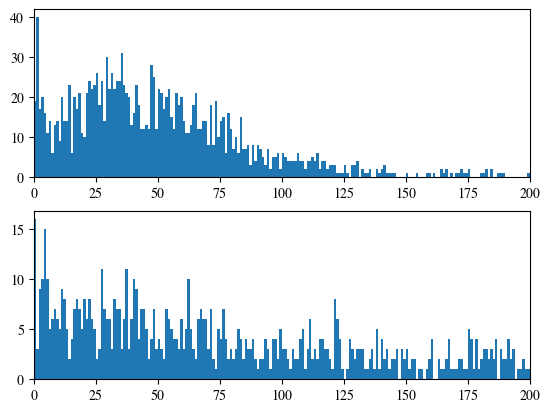

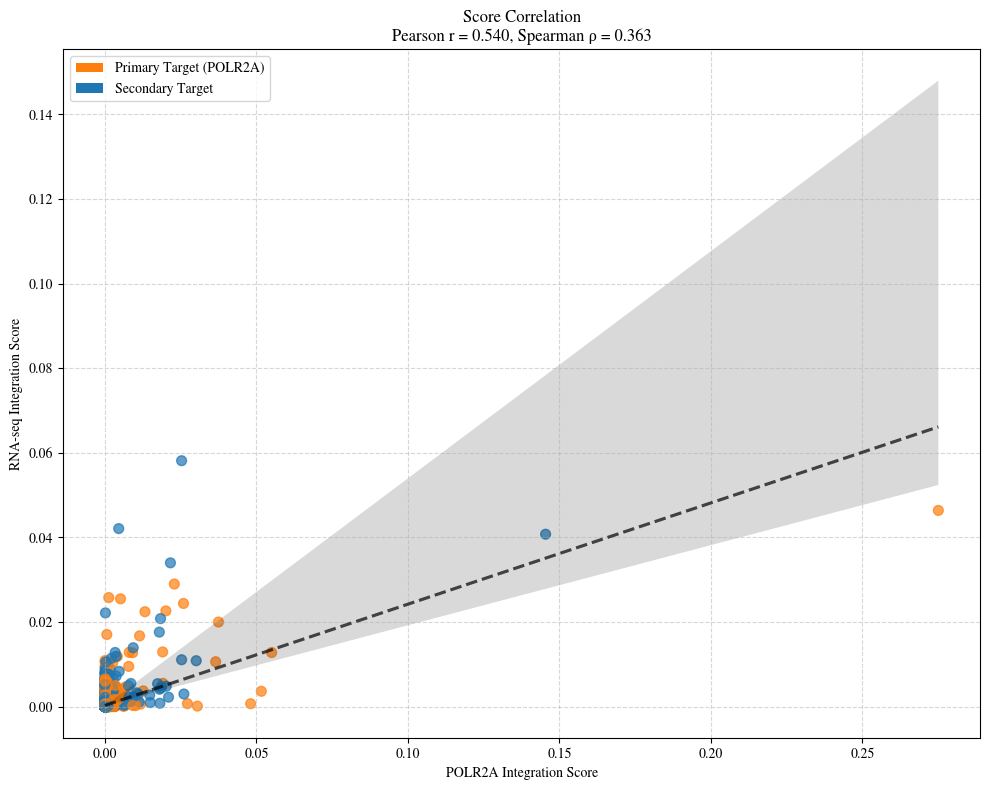

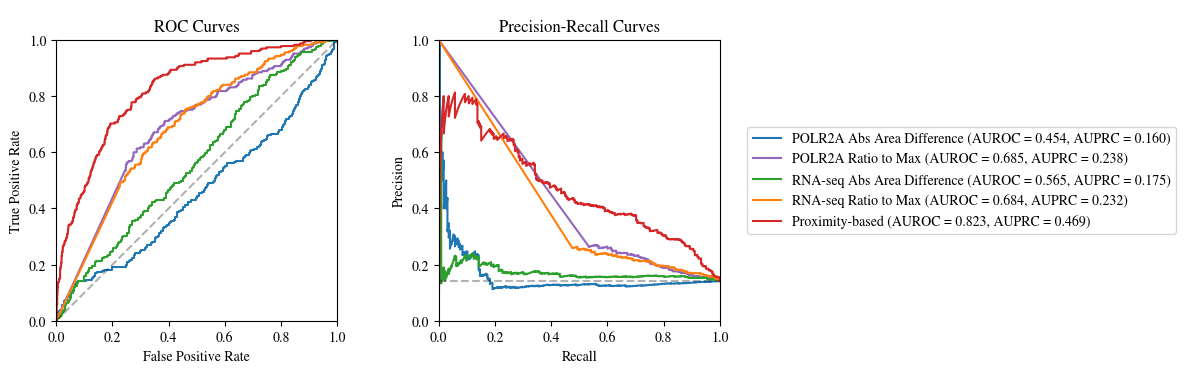

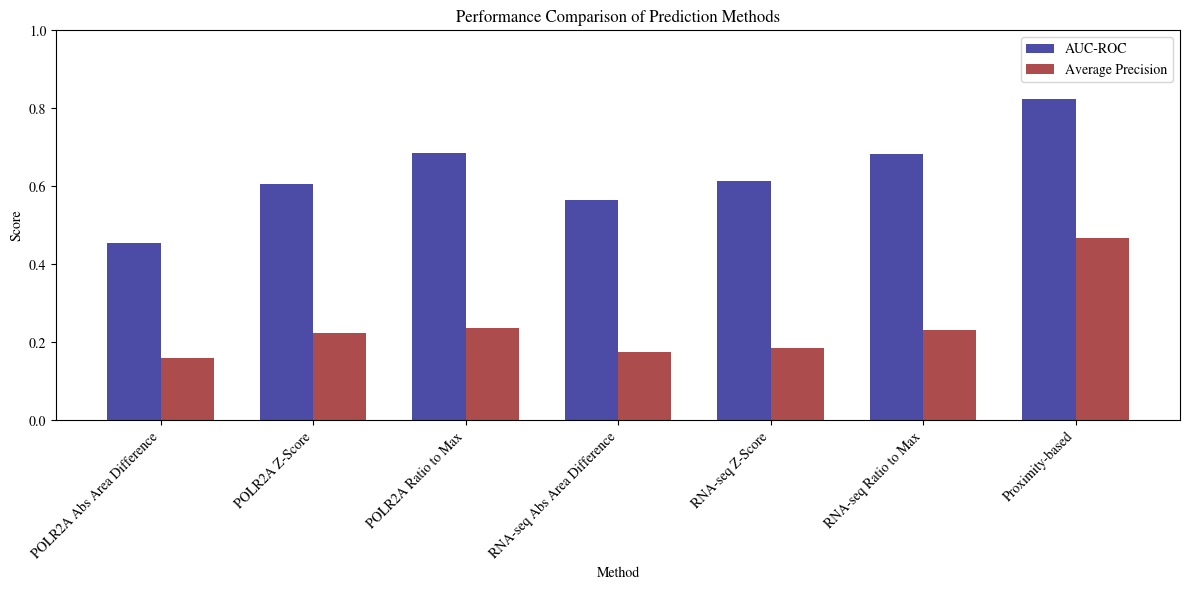

In [22]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_recall_curve, roc_curve, auc, average_precision_score
from scipy.stats import pearsonr, spearmanr
import matplotlib.gridspec as gridspec
try:
    from matplotlib_venn import venn2
except ImportError:
    print("Warning: matplotlib_venn not installed. Venn diagrams will be skipped.")

# Set plotting style
plt.rcParams['font.family'] = 'Nimbus Roman'
np.random.seed(42)

def calculate_binary_metrics(merged_crispr_df, output_path):
    """
    Calculate and save comprehensive classification metrics for binary predictions.
    """
    if 'Regulated' not in merged_crispr_df.columns:
        print("Warning: 'Regulated' column not found in merged data.")
        return None
    
    from sklearn.metrics import classification_report, precision_score, recall_score, f1_score, accuracy_score
    
    # Define prediction methods to evaluate
    methods = {
        'polr2a_effect': {
            'name': 'POLR2A Effect-based Primary Target',
            'predictions': merged_crispr_df['is_primary_target_polr2a'],
            'color': '#1f77b4'  # blue
        },
        'rna_effect': {
            'name': 'RNA-seq Effect-based Primary Target',
            'predictions': merged_crispr_df['is_primary_target_rna'],
            'color': '#2ca02c'  # green
        },
        'proximity_based': {
            'name': 'Proximity-based Target',
            'predictions': merged_crispr_df['is_closest_polr2a'],
            'color': '#d62728'  # red
        }
    }
    
    # True labels
    y_true = merged_crispr_df['Regulated']
    
    # Calculate metrics for each method
    results = {}
    for method_id, method_info in methods.items():
        y_pred = method_info['predictions']
        
        # Calculate metrics
        accuracy = accuracy_score(y_true, y_pred)
        precision = precision_score(y_true, y_pred)
        recall = recall_score(y_true, y_pred)
        f1 = f1_score(y_true, y_pred)
        
        # Store results
        results[method_id] = {
            'name': method_info['name'],
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'report': classification_report(y_true, y_pred, output_dict=True)
        }
    
    # Create metrics table
    metrics_table = pd.DataFrame({
        'Method': [results[m]['name'] for m in methods],
        'Accuracy': [results[m]['accuracy'] for m in methods],
        'Precision': [results[m]['precision'] for m in methods],
        'Recall': [results[m]['recall'] for m in methods],
        'F1 Score': [results[m]['f1'] for m in methods]
    })
    
    # Save metrics to CSV
    metrics_table.to_csv(output_path / 'binary_classification_metrics.csv', index=False)
    
    # Create visualization
    plt.figure(figsize=(12, 6))
    
    # Plot metrics as bar chart
    metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
    x = np.arange(len(metrics))
    width = 0.25
    
    for i, method_id in enumerate(methods.keys()):
        method_metrics = [results[method_id]['accuracy'], 
                         results[method_id]['precision'], 
                         results[method_id]['recall'], 
                         results[method_id]['f1']]
        
        plt.bar(x + width*(i-1), method_metrics, width, 
               label=results[method_id]['name'], 
               color=methods[method_id]['color'])
    
    plt.xlabel('Metric')
    plt.ylabel('Score')
    plt.title('Classification Metrics Comparison')
    plt.xticks(x, metrics)
    plt.ylim(0, 1.0)
    plt.legend()
    
    plt.tight_layout()
    plt.savefig(output_path / 'binary_classification_metrics.png', dpi=300, bbox_inches='tight')
    plt.close()
    
    print(f"Binary classification metrics:")
    print(metrics_table)
    
    return results

def calculate_threshold_metrics(merged_crispr_df, output_path):
    """
    Calculate optimal thresholds and metrics for continuous score methods.
    """
    if 'Regulated' not in merged_crispr_df.columns:
        print("Warning: 'Regulated' column not found in merged data.")
        return None
    
    from sklearn.metrics import precision_recall_curve, f1_score, accuracy_score
    
    # Define methods to evaluate
    methods = {
        'polr2a_abs': {
            'name': 'POLR2A Abs Area Difference',
            'scores': merged_crispr_df['abs_area_difference_polr2a'].values,
            'color': '#1f77b4'  # blue
        },
        'polr2a_zscore': {
            'name': 'POLR2A Z-Score',
            'scores': merged_crispr_df['z_score_polr2a'].values,
            'color': '#ff7f0e'  # orange
        },
        'polr2a_ratio': {
            'name': 'POLR2A Ratio to Max',
            'scores': merged_crispr_df['ratio_to_max_polr2a'].values,
            'color': '#9467bd'  # purple
        },
        'rna_abs': {
            'name': 'RNA-seq Abs Area Difference',
            'scores': merged_crispr_df['abs_area_difference_rna'].values,
            'color': '#2ca02c'  # green
        },
        'rna_zscore': {
            'name': 'RNA-seq Z-Score',
            'scores': merged_crispr_df['z_score_rna'].values,
            'color': '#d62728'  # red
        },
        'rna_ratio': {
            'name': 'RNA-seq Ratio to Max',
            'scores': merged_crispr_df['ratio_to_max_rna'].values,
            'color': '#8c564b'  # brown
        },
        'proximity': {
            'name': 'Proximity-based',
            'scores': -merged_crispr_df['distance_to_enhancer_polr2a'].values,
            'color': '#e377c2'  # pink
        }
    }
    
    # True labels
    y_true = merged_crispr_df['Regulated'].astype(int).values
    
    # Calculate optimal thresholds and metrics
    results = {}
    metrics_rows = []
    
    for method_id, method_info in methods.items():
        scores = method_info['scores']
        
        # Calculate precision-recall curve and find optimal threshold for F1
        precision, recall, thresholds = precision_recall_curve(y_true, scores)
        
        # Calculate F1 score for each threshold
        f1_scores = []
        for threshold in thresholds:
            y_pred = (scores >= threshold).astype(int)
            f1 = f1_score(y_true, y_pred)
            f1_scores.append(f1)
        
        # Find optimal threshold for F1 score
        if len(f1_scores) > 0:
            best_idx = np.argmax(f1_scores)
            best_threshold = thresholds[best_idx]
            best_f1 = f1_scores[best_idx]
            
            # Apply optimal threshold
            y_pred = (scores >= best_threshold).astype(int)
            
            # Calculate metrics
            accuracy = accuracy_score(y_true, y_pred)
            precision_at_threshold = precision[best_idx]
            recall_at_threshold = recall[best_idx]
            
            # Store results
            results[method_id] = {
                'name': method_info['name'],
                'optimal_threshold': best_threshold,
                'accuracy': accuracy,
                'precision': precision_at_threshold,
                'recall': recall_at_threshold,
                'f1': best_f1
            }
            
            # Add to metrics table
            metrics_rows.append({
                'Method': method_info['name'],
                'Optimal Threshold': best_threshold,
                'Accuracy': accuracy,
                'Precision': precision_at_threshold,
                'Recall': recall_at_threshold,
                'F1 Score': best_f1
            })
    
    # Create metrics table
    metrics_table = pd.DataFrame(metrics_rows)
    
    # Save metrics to CSV
    metrics_table.to_csv(output_path / 'continuous_metrics_at_optimal_threshold.csv', index=False)
    
    # Plot metrics
    plt.figure(figsize=(14, 6))
    
    # Plot metrics as bar chart
    metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
    x = np.arange(len(metrics))
    width = 0.1
    method_ids = list(methods.keys())
    
    for i, method_id in enumerate(method_ids):
        if method_id in results:
            method_result = results[method_id]
            method_metrics = [method_result['accuracy'], 
                             method_result['precision'], 
                             method_result['recall'], 
                             method_result['f1']]
            
            plt.bar(x + width*(i-len(method_ids)/2), method_metrics, width, 
                   label=method_result['name'], 
                   color=methods[method_id]['color'])
    
    plt.xlabel('Metric')
    plt.ylabel('Score')
    plt.title('Classification Metrics at Optimal Thresholds')
    plt.xticks(x, metrics)
    plt.ylim(0, 1.0)
    plt.legend(loc='best', fontsize='small')
    
    plt.tight_layout()
    plt.savefig(output_path / 'continuous_classification_metrics.png', dpi=300, bbox_inches='tight')
    plt.close()
    
    print(f"Continuous score metrics at optimal thresholds:")
    print(metrics_table)
    
    return results

def load_crispr_data(crispr_path):
    """
    Load and preprocess CRISPR benchmark data.
    """
    try:
        crispr_df = pd.read_csv(crispr_path, sep='\t', decimal=',')
        
        float_cols = ['EffectSize', 'pValueAdjusted', 'PowerAtEffectSize10', 'PowerAtEffectSize15', 
                     'PowerAtEffectSize20', 'PowerAtEffectSize25', 'PowerAtEffectSize50']
        
        for col in float_cols:
            if col in crispr_df.columns:
                crispr_df[col] = crispr_df[col].apply(lambda x: 
                                                   float(str(x).replace(',', '.')) 
                                                   if isinstance(x, str) else x)
        
        if 'Regulated' in crispr_df.columns:
            crispr_df['Regulated'] = crispr_df['Regulated'].apply(
                lambda x: x == True or x == 'TRUE' if isinstance(x, (str, bool)) else bool(x)
            )
        
        crispr_df['enhancer_id'] = crispr_df.apply(
            lambda row: f"{row['chrom(hg19)']}_{row['chromStart(hg19)']}_{row['chromEnd(hg19)']}",
            axis=1
        )
        
        if 'measuredGeneSymbol' in crispr_df.columns:
            crispr_df['gene_name'] = crispr_df['measuredGeneSymbol']
        
        print(f"Loaded CRISPR data: {len(crispr_df)} enhancer-gene pairs")
        return crispr_df
    
    except Exception as e:
        print(f"Error loading CRISPR data: {e}")
        return None

def plot_unified_curves(merged_crispr_df, output_path):
    """Create unified ROC and PR curves with shared legend."""
    if 'Regulated' not in merged_crispr_df.columns:
        print("Warning: 'Regulated' column not found in merged data.")
        return None
    
    # Convert boolean Regulated to numeric (0/1)
    y_true = merged_crispr_df['Regulated'].astype(int).values
    
    # For proximity, use negative distance as the score
    merged_crispr_df['proximity_score'] = -merged_crispr_df['distance_to_enhancer_polr2a']
    
    # Define methods for comparison
    methods = {
        'polr2a_abs': {
            'name': 'POLR2A Abs Area Difference',
            'scores': merged_crispr_df['abs_area_difference_polr2a'].values,
            'color': '#1f77b4'  # blue
        },
        #'polr2a_zscore': {
        #    'name': 'POLR2A Z-Score',
        #    'scores': merged_crispr_df['z_score_polr2a'].values,
        #    'color': '#ff7f0e'  # orange
        #},
        'polr2a_ratio': {
            'name': 'POLR2A Ratio to Max',
            'scores': merged_crispr_df['ratio_to_max_polr2a'].values,
            'color': '#9467bd'  # purple
        },
        'rna_abs': {
            'name': 'RNA-seq Abs Area Difference',
            'scores': merged_crispr_df['abs_area_difference_rna'].values,
            'color': '#2ca02c'  # green
        },
        #'rna_zscore': {
        #    'name': 'RNA-seq Z-Score',
        #    'scores': merged_crispr_df['z_score_rna'].values,
        #    'color': '#d62728'  # red
        #},
        'rna_ratio': {
            'name': 'RNA-seq Ratio to Max',
            'scores': merged_crispr_df['ratio_to_max_rna'].values,
            'color': '#ff7f0e'  # orange '#8c564b'  # brown
        },
        'proximity': {
            'name': 'Proximity-based',
            'scores': merged_crispr_df['proximity_score'].values,
            'color': '#d62728'  # red #'#e377c2'  # pink
        }
    }
    
    # Create figure with GridSpec for custom layout
    fig = plt.figure(figsize=(12, 4))
    gs = gridspec.GridSpec(1, 3, width_ratios=[1, 1, 1])
    
    # Store lines for legend
    legend_lines = []
    legend_labels = []

    # Create subplots
    ax_roc = fig.add_subplot(gs[0])
    ax_pr = fig.add_subplot(gs[1], sharey=ax_roc)  # Share y-axis
    ax_legend = fig.add_subplot(gs[2])

    # Plot ROC curves
    for method_id, method_info in methods.items():
        fpr, tpr, _ = roc_curve(y_true, method_info['scores'])
        roc_auc_value = auc(fpr, tpr)
        
        line, = ax_roc.plot(fpr, tpr, color=method_info['color'])
        legend_lines.append(line)
        legend_labels.append(f"{method_info['name']} (AUROC = {roc_auc_value:.3f}")

    # ROC plot settings
    ax_roc.plot([0, 1], [0, 1], 'k--', alpha=0.3)
    ax_roc.set_xlabel('False Positive Rate')
    ax_roc.set_ylabel('True Positive Rate')
    ax_roc.set_xlim([0.0, 1.0])
    ax_roc.set_ylim([0.0, 1.0])
    ax_roc.set_title('ROC Curves')
    ax_roc.set_aspect(1.0)

    # Plot PR curves
    for method_id, method_info in methods.items():
        precision, recall, _ = precision_recall_curve(y_true, method_info['scores'])
        average_precision = average_precision_score(y_true, method_info['scores'])
        
        ax_pr.plot(recall, precision, color=method_info['color'])
        # Update labels with AUPRC
        idx = list(methods.keys()).index(method_id)
        legend_labels[idx] += f", AUPRC = {average_precision:.3f})"

    # PR plot settings
    no_skill = sum(y_true) / len(y_true)
    print(no_skill)
    ax_pr.plot([0, 1], [no_skill, no_skill], 'k--', alpha=0.3)
    ax_pr.set_xlabel('Recall')
    ax_pr.set_ylabel('Precision')  # No y-label since shared
    ax_pr.set_xlim([0.0, 1.0])
    ax_pr.set_ylim([0.0, 1.0])
    ax_pr.set_title('Precision-Recall Curves')
    ax_pr.set_aspect(1.0)

    # Make legend subplot empty but add the legend
    ax_legend.axis('off')
    ax_legend.legend(handles=legend_lines, labels=legend_labels, loc='center', fontsize=10)

    plt.tight_layout()
    plt.savefig(output_path / 'unified_curves.png', dpi=300, bbox_inches='tight')

    return fig

def plot_performance_summary(merged_crispr_df, output_path):
    """Create a summary plot comparing all methods' performance."""
    if 'Regulated' not in merged_crispr_df.columns:
        print("Warning: 'Regulated' column not found in merged data.")
        return None

    # Convert boolean Regulated to numeric (0/1)
    y_true = merged_crispr_df['Regulated'].astype(int).values
    
    # For proximity, use negative distance as the score (closer = higher score)
    merged_crispr_df['proximity_score'] = -merged_crispr_df['distance_to_enhancer_polr2a']
    
    # Define all methods to compare - same as in plot_roc_curves
    methods = {
        'polr2a_abs': {
            'name': 'POLR2A Abs Area Difference',
            'scores': merged_crispr_df['abs_area_difference_polr2a'].values,
            'color': '#1f77b4'  # blue
        },
        'polr2a_zscore': {
            'name': 'POLR2A Z-Score',
            'scores': merged_crispr_df['z_score_polr2a'].values,
            'color': '#ff7f0e'  # orange
        },
        'polr2a_ratio': {
            'name': 'POLR2A Ratio to Max',
            'scores': merged_crispr_df['ratio_to_max_polr2a'].values,
            'color': '#9467bd'  # purple
        },
        'rna_abs': {
            'name': 'RNA-seq Abs Area Difference',
            'scores': merged_crispr_df['abs_area_difference_rna'].values,
            'color': '#2ca02c'  # green
        },
        'rna_zscore': {
            'name': 'RNA-seq Z-Score',
            'scores': merged_crispr_df['z_score_rna'].values,
            'color': '#d62728'  # red
        },
        'rna_ratio': {
            'name': 'RNA-seq Ratio to Max',
            'scores': merged_crispr_df['ratio_to_max_rna'].values,
            'color': '#8c564b'  # brown
        },
        'proximity': {
            'name': 'Proximity-based',
            'scores': merged_crispr_df['proximity_score'].values,
            'color': '#e377c2'  # pink
        }
    }
    
    # Calculate performance metrics for each method
    results = []
    
    for method_id, method_info in methods.items():
        # Calculate AUC-ROC
        fpr, tpr, _ = roc_curve(y_true, method_info['scores'])
        roc_auc = auc(fpr, tpr)
        
        # Calculate Average Precision
        ap = average_precision_score(y_true, method_info['scores'])
        
        # Store results
        results.append({
            'Method': method_info['name'],
            'AUC-ROC': roc_auc,
            'AP': ap,
            'Color': method_info['color']
        })
    
    # Create summary DataFrame
    summary_df = pd.DataFrame(results)
    
    # Create summary plot
    plt.figure(figsize=(12, 6))
    
    # Plot as grouped bar chart
    metrics = ['AUC-ROC', 'AP']
    x = np.arange(len(summary_df))
    width = 0.35
    
    plt.bar(x - width/2, summary_df['AUC-ROC'], width, label='AUC-ROC', color='navy', alpha=0.7)
    plt.bar(x + width/2, summary_df['AP'], width, label='Average Precision', color='darkred', alpha=0.7)
    
    plt.xlabel('Method')
    plt.ylabel('Score')
    plt.title('Performance Comparison of Prediction Methods')
    plt.xticks(x, summary_df['Method'], rotation=45, ha='right')
    plt.legend()
    
    plt.ylim(0, 1.0)
    plt.tight_layout()
    plt.savefig(output_path / 'performance_summary.png', dpi=300, bbox_inches='tight')
    
    # Save summary to CSV
    summary_df[['Method', 'AUC-ROC', 'AP']].to_csv(output_path / 'performance_summary.csv', index=False)
    
    return summary_df

def plot_primary_target_comparison(merged_crispr_df, output_path):
    """Create confusion matrix comparing methods and CRISPR data with precision/recall metrics."""
    if 'Regulated' not in merged_crispr_df.columns:
        print("Warning: 'Regulated' column not found in merged data.")
        return None
    
    # Ensure output directory exists
    output_path.mkdir(exist_ok=True, parents=True)
    
    # Create figure
    fig, axes = plt.subplots(1, 2, figsize=(9, 4.3))
    
    # Calculate metrics for effect-based prediction
    cm1 = confusion_matrix(merged_crispr_df['Regulated'], merged_crispr_df['is_primary_target_polr2a'])
    tn1, fp1, fn1, tp1 = cm1.ravel()
    acc1 = (tp1 + tn1) / cm1.sum()
    precision1 = tp1 / (tp1 + fp1) if (tp1 + fp1) > 0 else 0
    recall1 = tp1 / (tp1 + fn1) if (tp1 + fn1) > 0 else 0
    
    # Plot first confusion matrix
    sns.heatmap(cm1, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Not Primary', 'Primary'],
                yticklabels=['Not Regulated', 'Regulated'],
                ax=axes[0])
    
    axes[0].set_xlabel('Effect-based Prediction')
    axes[0].set_ylabel('CRISPR Regulated')
    axes[0].set_title('Effect-based Primary Target vs CRISPR')
    
    # Calculate metrics for proximity-based prediction
    cm2 = confusion_matrix(merged_crispr_df['Regulated'], merged_crispr_df['is_closest_polr2a'])
    tn2, fp2, fn2, tp2 = cm2.ravel()
    acc2 = (tp2 + tn2) / cm2.sum()
    precision2 = tp2 / (tp2 + fp2) if (tp2 + fp2) > 0 else 0
    recall2 = tp2 / (tp2 + fn2) if (tp2 + fn2) > 0 else 0
    f1_score2 = 2 * precision2 * recall2 / (precision2 + recall2) if (precision2 + recall2) > 0 else 0
    
    # Plot second confusion matrix
    sns.heatmap(cm2, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Not Closest', 'Closest'],
                yticklabels=['Not Regulated', 'Regulated'],
                ax=axes[1])
    
    axes[1].set_xlabel('Proximity-based Prediction')
    axes[1].set_ylabel('CRISPR Regulated')
    axes[1].set_title('Proximity-based Target vs CRISPR')
    
    # Add metrics below each matrix
    y_pos = 0.02
    plt.figtext(0.25, y_pos+0.06, f'Accuracy: {acc1:.3f}, Precision: {precision1:.3f}, Recall: {recall1:.3f}', ha='center')
    plt.figtext(0.75, y_pos+0.06, f'Accuracy: {acc2:.3f}, Precision: {precision2:.3f}, Recall: {recall2:.3f}', ha='center')
    
    plt.tight_layout()
    plt.subplots_adjust(bottom=0.2)  # Make space for metrics
    plt.savefig(output_path / 'crispr_prediction_comparison.png', dpi=300, bbox_inches='tight')
    plt.close()
    
    return {
        'effect_cm': cm1,
        'proximity_cm': cm2,
        'effect_metrics': {
            'accuracy': acc1,
            'precision': precision1,
            'recall': recall1,
        },
        'proximity_metrics': {
            'accuracy': acc2,
            'precision': precision2,
            'recall': recall2,
        }
    }

def plot_correlation_scatter(merged_df, output_path):
    """
    Create scatter plot comparing POLR2A and RNA-seq scores with primary target highlighting.
    """
    plt.figure(figsize=(10, 8))
    
    # Define colors based on primary target status
    colors = np.where(merged_df['is_primary_target_polr2a'], '#ff7f0e', '#1f77b4')
    
    # Create legend elements
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor='#ff7f0e', label='Primary Target (POLR2A)'),
        Patch(facecolor='#1f77b4', label='Secondary Target')
    ]
    
    # Create scatter plot
    plt.scatter(
        merged_df['abs_area_difference_polr2a'],
        merged_df['abs_area_difference_rna'],
        c=colors,
        alpha=0.7,
        s=50
    )
    
    # Add regression line
    sns.regplot(
        x=merged_df['abs_area_difference_polr2a'],
        y=merged_df['abs_area_difference_rna'],
        scatter=False,
        color='black',
        line_kws={'linestyle': '--', 'alpha': 0.7}
    )
    
    # Calculate correlation statistics
    pearson_r, pearson_p = pearsonr(
        merged_df['abs_area_difference_polr2a'],
        merged_df['abs_area_difference_rna']
    )
    
    spearman_r, spearman_p = spearmanr(
        merged_df['abs_area_difference_polr2a'],
        merged_df['abs_area_difference_rna']
    )
    
    plt.xlabel('POLR2A Integration Score')
    plt.ylabel('RNA-seq Integration Score')
    plt.title(f'Score Correlation\nPearson r = {pearson_r:.3f}, Spearman ρ = {spearman_r:.3f}')
    
    plt.legend(handles=legend_elements, loc='upper left')
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.savefig(output_path / 'score_correlation_with_targets.png', dpi=300, bbox_inches='tight')
    
    return {
        'pearson_r': pearson_r,
        'pearson_p': pearson_p,
        'spearman_r': spearman_r,
        'spearman_p': spearman_p
    }


def compare_results(polr2a_path, rna_path, crispr_path, output_path, score_methods=None):
    """
    Run comparison analysis between POLR2A and RNA-seq predictions with multiple scoring methods.
    
    Args:
        polr2a_path: Path to POLR2A results CSV with primary target flags
        rna_path: Path to RNA-seq results CSV with primary target flags
        crispr_path: Path to CRISPR benchmark data
        output_path: Path to save outputs
        score_methods: List of scoring methods to compare
    
    Returns:
        Dictionary with analysis results
    """
    if score_methods is None:
        score_methods = ['abs_area_difference', 'z_score', 'ratio_to_max']
        
    # Create output directory
    output_path = Path(output_path)
    output_path.mkdir(parents=True, exist_ok=True)
    
    print("\n=== Running Enhanced Enhancer-Gene Interaction Analysis ===")
    
    # Load POLR2A and RNA-seq results
    print("Loading prediction results...")
    polr2a_df = pd.read_csv(polr2a_path)
    rna_df = pd.read_csv(rna_path)
    
    # Merge datasets on enhancer-gene pairs
    print("Merging POLR2A and RNA-seq results...")
    merged_df = pd.merge(
        polr2a_df, 
        rna_df, 
        on=['enhancer_id', 'gene_id', 'gene_name'],
        suffixes=('_polr2a', '_rna')
    )
    
    print(f"Found {len(merged_df)} common enhancer-gene pairs")
    merged_df.to_csv(output_path / 'merged_results_with_targets.csv', index=False)
    
    # Load CRISPR benchmark data if available
    crispr_df = None
    if crispr_path and Path(crispr_path).exists():
        print("Loading CRISPR benchmark data...")
        crispr_df = load_crispr_data(crispr_path)
        
        if crispr_df is not None:
            # Merge with CRISPR ground truth
            print("Merging with CRISPR benchmark data...")
            merge_keys = ['enhancer_id', 'gene_name']
            
            # Select relevant columns from CRISPR data
            crispr_cols = merge_keys + ['Regulated', 'EffectSize', 'Significant']
            available_cols = [col for col in crispr_cols if col in crispr_df.columns]
            
            # Perform merge
            merged_crispr_df = pd.merge(
                merged_df,
                crispr_df[available_cols],
                on=merge_keys,
                how='inner'
            )
            
            print(f"Merged results: {len(merged_crispr_df)} enhancer-gene pairs with CRISPR data")
            
            # Report on regulated status
            if 'Regulated' in merged_crispr_df.columns:
                regulated_count = merged_crispr_df['Regulated'].sum()
                print(f"Regulated genes: {regulated_count} ({regulated_count/len(merged_crispr_df)*100:.1f}%)")
                
            merged_crispr_df.to_csv(output_path / 'merged_with_crispr_targets.csv', index=False)
        else:
            merged_crispr_df = merged_df
            print("Warning: Could not load CRISPR data. Proceeding with basic comparison.")
    else:
        merged_crispr_df = merged_df
        print("No CRISPR benchmark data provided. Proceeding with basic comparison.")
    
    # Generate plots
    print("Generating plots...")

    fig = plt.figure()
    plt
    fig.show()

    fig = plt.figure()
    ax0 = fig.add_subplot(2,1,1)
    ax0.hist(merged_crispr_df['baseline_area_polr2a'], bins=np.arange(merged_crispr_df['baseline_area_polr2a'].min(), merged_crispr_df['baseline_area_polr2a'].max(),1))
    #ax0.set_yscale('log')
    ax0.set_xlim(0,200)
    ax1 = fig.add_subplot(2,1,2)
    ax1.hist(merged_crispr_df['baseline_area_rna'], bins=np.arange(merged_crispr_df['baseline_area_rna'].min(), merged_crispr_df['baseline_area_rna'].max(),1))
    ax1.set_xlim(0,200)
    fig.show()

    threshold_polr2a = 10
    merged_crispr_df = merged_crispr_df[(merged_crispr_df['baseline_area_polr2a'] > threshold_polr2a)]
    
    # 1. Plot correlation between methods
    print("- Generating correlation scatter plot...")
    corr_results = plot_correlation_scatter(merged_df, output_path)
    
    # 3. Generate CRISPR comparison if available
    crispr_results = None
    roc_results = None
    pr_results = None
    performance_summary = None
    
    if 'Regulated' in merged_crispr_df.columns:
        print("- Generating CRISPR comparison plots...")
        crispr_results = plot_primary_target_comparison(merged_crispr_df, output_path)
        
        # ... other plotting functions
        print("- Generating unified ROC and PR curves...")
        unified_fig = plot_unified_curves(merged_crispr_df, output_path)
        
        print("- Generating performance summary...")
        performance_summary = plot_performance_summary(merged_crispr_df, output_path)
        
        print("- Calculating binary classification metrics...")
        binary_metrics = calculate_binary_metrics(merged_crispr_df, output_path)
        
        print("- Calculating continuous score metrics at optimal thresholds...")
        threshold_metrics = calculate_threshold_metrics(merged_crispr_df, output_path)
    
    # Compile results
    results = {
        'data': {
            'merged': merged_df,
            'with_crispr': merged_crispr_df if crispr_df is not None else None
        },
        'metrics': {
            'correlation': corr_results,
            'crispr_comparison': crispr_results,
            'roc': roc_results,
            'pr': pr_results,
            'performance_summary': performance_summary,
            'binary_metrics': binary_metrics,
            'threshold_metrics': threshold_metrics
        }
    }
    
    print("\n=== Analysis Complete ===")
    print(f"All results and visualizations saved to: {output_path}")
    
    return results


def main():
    """Main function to run the analysis pipeline."""
    # Define base path
    base_path = Path("../")
    
    # Define paths for analysis and score methods
    polr2a_file = base_path / "tables" / "polr2a_tss_abs_area_difference_results_with_targets.csv"
    rna_file = base_path / "tables" / "rnaseq_gene_body_abs_area_difference_results_with_targets.csv"
    crispr_file = base_path / "annotations/human/lifted_hg38_to_hg19/EPCrisprBenchmark_ensemble_data_GRCh38_hg19.txt"
    comparison_path = base_path / "results_CRISPR" / "Integration_comparison_targets"
    
    score_methods = ['abs_area_difference', 'z_score', 'ratio_to_max']
    
    # Run comparison
    results = compare_results(
        polr2a_path=polr2a_file,
        rna_path=rna_file,
        crispr_path=crispr_file,
        output_path=comparison_path,
        score_methods=score_methods
    )
    
    return results

if __name__ == "__main__":
    main()

**Plotting ground truth Enhancer-Gene pairs**

Here we will plot ground truth Enhancer-Gene pairs in K562 cells, obtained by CRISPR KO of enhancers and measuring the induced gene expression changes. This data was downloaded from the [Engreitz lab's github](https://github.com/EngreitzLab/CRISPR_comparison/tree/main/resources/crispr_data), referenced as a benchmarking dataset in [A. Gschwind et al.](https://doi.org/10.1101/2023.11.09.563812).

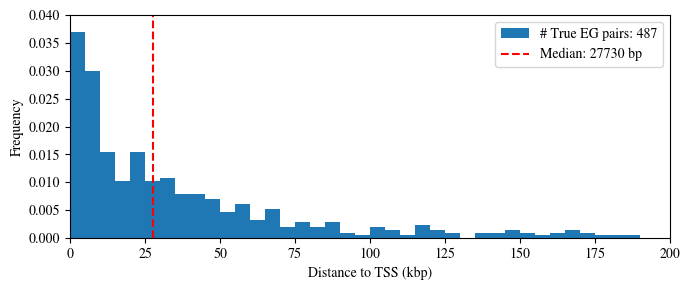

In [5]:
DOWNLOAD = True
DATA_DIR = Path("./") 
FIGURE_DIR = Path("../figures/Figures_revisions/")
FILENAME = "EPCrisprBenchmark_ensemble_data_GRCh38.tsv"
URL = "https://github.com/EngreitzLab/CRISPR_comparison/raw/refs/heads/main/resources/crispr_data/EPCrisprBenchmark_ensemble_data_GRCh38.tsv.gz"

# Create data directory if it doesn't exist
DATA_DIR.mkdir(parents=True, exist_ok=True)

if DOWNLOAD:
    # Download and process file
    import urllib.request
    import gzip
    import shutil
    
    # Download the gzipped file
    gz_path = DATA_DIR / f"{FILENAME}.gz"
    urllib.request.urlretrieve(URL, gz_path)
    
    # Unzip the file
    with gzip.open(gz_path, 'rb') as f_in:
        with open(DATA_DIR / FILENAME, 'wb') as f_out:
            shutil.copyfileobj(f_in, f_out)
    
    # Remove the gzipped file
    gz_path.unlink()

# Read the data into DataFrame
df_path = DATA_DIR / FILENAME
df = pd.read_csv(df_path, sep='\t')
df = df[df['Regulated']==True] # Keep only true EP pairs, defined by Regulated=True

# Calculate distances
enh_pos = (df['chromStart'] + df['chromStart']) // 2 #Center of the regulatory element
prom_pos = df['startTSS'] # Only one basepair difference between start and end TSS
x = abs(enh_pos.values - prom_pos.values).astype(int)
scale = 1000 #kbp
median = np.median(x)
n_EG_pairs = len(df)

#Plot histogram:
fig = plt.figure(figsize=(7,3))
plt.hist(x/scale, bins=np.arange(0, 200,5), density=True, label = f"# True EG pairs: {n_EG_pairs}")
plt.plot(median/scale*np.ones(10), np.linspace(0,0.04,10), color='red', ls='--', label=f'Median: {int(median)} bp')
plt.ylabel('Frequency')
plt.xlabel('Distance to TSS (kbp)')
plt.ylim(0,0.04)
plt.xlim(0,200)
plt.legend()
plt.tight_layout()
fig.savefig(FIGURE_DIR / 'Ground_truth_EP_histogram.png', dpi=200)

**Get genomic region boundaries for fast UCSC query:**

In [1]:
chrom = 17
start = 75082798
SHIFT = 200050

print(f"chr{chrom}:{start-SHIFT}-{start+SHIFT}")

chr17:74882748-75282848


**Check which perturbations were included:**

In [ ]:
import pandas as pd
# Load data
df = pd.read_csv("../annotations/human/lifted_hg38_to_hg19/EPCrisprBenchmark_ensemble_data_GRCh38_hg19.txt", sep="\t")
included = pd.read_csv("../targets/K562/Enhancer_centered_targets_human.csv", sep=",")

# Function to parse IDs in the format chr_start_end or chr_start_end_perturbed
def parse_id(id_str):
    parts = id_str.split('_')
    
    # Check if it has the perturbed suffix
    is_perturbed = parts[-1] == 'perturbed'
    
    # Extract chr, start, end
    if is_perturbed and len(parts) >= 4:
        chrom = parts[0]
        try:
            start = int(parts[1])
            end = int(parts[2])
            return {'chrom': chrom, 'start': start, 'end': end}
        except ValueError:
            return None
    elif not is_perturbed and len(parts) >= 3:
        chrom = parts[0]
        try:
            start = int(parts[1])
            end = int(parts[2])
            return {'chrom': chrom, 'start': start, 'end': end}
        except ValueError:
            return None
    else:
        return None

# Create a set of (chrom, start, end) tuples from included dataframe
included_regions = set()
for _, row in included.iterrows():
    parsed = parse_id(row['ID'])
    if parsed:
        included_regions.add((parsed['chrom'], parsed['start'], parsed['end']))

# Add "included" column to df based on whether the hg19 coordinates appear in included_regions
df['included'] = df.apply(
    lambda row: "yes" if (row['chrom(hg19)'], row['chromStart(hg19)'], row['chromEnd(hg19)']) in included_regions else "no", 
    axis=1
)

# Save the updated dataframe
df.to_csv("df_with_included_flag.csv", index=False)

# Print summary
included_count = (df['included'] == "yes").sum()
print(f"Total regions in df: {len(df)}")
print(f"Regions also in included dataframe: {included_count}")
print(f"Percentage of df regions in included dataframe: {included_count/len(df)*100:.2f}%")

Total regions in df: 9445
Regions also in included dataframe: 5590
Percentage of df regions in included dataframe: 59.18%


In [22]:
import pandas as pd

# Load the enhancers data (update the path to your enhancers file)
enhancers = pd.read_csv("../annotations/CLASTER Supplementary Tables Revisited - ST3. Enhancer_Like_Signatures.tsv", sep="\t")

# Load the targets data from paste.txt
targets = pd.read_csv("../targets/Enhancer_centered_targets.csv", sep=",")

# Extract the target IDs from the first column
target_ids = set(targets['ID'])

# Add 'Included' column to enhancers dataframe
enhancers['Included'] = enhancers['ID'].apply(lambda x: "yes" if x in target_ids else "no")

# Save the result
enhancers.to_csv("enhancers_with_included.tsv", sep="\t", index=False)

# Print summary
included_count = (enhancers['Included'] == "yes").sum()
print(f"Total enhancers: {len(enhancers)}")
print(f"Enhancers included in targets file: {included_count}")
print(f"Percentage of enhancers in targets: {included_count/len(enhancers)*100:.2f}%")

Total enhancers: 6498
Enhancers included in targets file: 1251
Percentage of enhancers in targets: 19.25%


### Editing gene annotations table to add whether they were included or not in the analyses

In [26]:
import pandas as pd
import csv
import os
import re
import glob
import sys
import argparse

def process_annotation_file(species="mouse"):
    """
    Updates the gene annotations TSV file by adding columns that indicate:
    1. If the gene is in training, test, or missing for targets
    2. For each input folder type, whether the gene is in training, test, both, or missing
    
    Parameters:
    species (str): Either "mouse" or "human" to determine which files to process
    """
    if species.lower() == "mouse":
        # Paths for mouse files
        annotation_file = "../annotations/Final_gene_annotations.tsv"
        output_file = "../annotations/Final_gene_annotations_updated.tsv"
        
        # Target files for mouse
        target_paths = {
            "default": {
                "training": "../targets/training_targets.csv",
                "test": "../targets/test_targets.csv"
            }
        }
        
        # Input folders for mouse
        input_types = [
            "landscape_arrays",
            "microC",
            "microC_rotated",
            "Promoter-CHiC"
        ]
        
    elif species.lower() == "human":
        # Paths for human files
        annotation_file = "../annotations/human/Final_gene_annotations_human.tsv"
        output_file = "../annotations/human/Final_gene_annotations_human_updated.tsv"
        
        # Target files for human
        target_paths = {
            "K562": {
                "training": "../targets/K562/training_targets.csv",
                "test": "../targets/K562/test_targets.csv"
            },
            "K562_polii": {
                "training": "../targets/K562/polii/training_polii_targets.csv",
                "test": "../targets/K562/polii/test_polii_targets.csv"
            }
        }
        
        # Check for polii target files - FIX: Try multiple potential locations
        polii_paths = {
            "training": [
                "../targets/K562/polii/training_polii_targets.csv",
                "../targets/K562/polii/training_targets.csv"
            ],
            "test": [
                "../targets/K562/polii/test_polii_targets.csv",
                "../targets/K562/polii/test_targets.csv"
            ]
        }
        
        # Check all potential paths for polii files
        for split, paths in polii_paths.items():
            found = False
            for path in paths:
                if os.path.exists(path):
                    target_paths["K562_polii"][split] = path
                    print(f"Found polii {split} targets at: {path}")
                    found = True
                    break
            if not found:
                print(f"WARNING: No polii {split} targets found. Tried paths: {paths}")
        
        # Input folders for human
        input_types = ["K562"]
        
    else:
        raise ValueError(f"Unsupported species: {species}. Choose 'mouse' or 'human'.")
    
    print(f"\n--- Processing {species.upper()} gene annotations ---\n")
    
    # Read the gene annotations file
    try:
        annotations = pd.read_csv(annotation_file, sep='\t')
        print(f"Loaded {len(annotations)} gene annotations for {species}")
    except FileNotFoundError:
        print(f"Error: Annotation file {annotation_file} not found.")
        return {"species": species, "error": f"Annotation file not found: {annotation_file}"}
    
    # Initialize dictionaries to store all target types
    all_targets = {}
    for target_type, paths in target_paths.items():
        all_targets[target_type] = {
            "training": set(),
            "test": set()
        }
    
    # Initialize dictionaries to store array file information by input type
    array_data = {}
    for input_type in input_types:
        array_data[input_type] = {
            "training": set(),
            "test": set()
        }
    
    # Extract IDs from all target files
    missing_target_files = []
    for target_type, paths in target_paths.items():
        for split, file_path in paths.items():
            if os.path.exists(file_path):
                print(f"Processing target file: {file_path}")
                with open(file_path, 'r') as f:
                    reader = csv.reader(f)
                    header = next(reader)  # Skip header
                    for row in reader:
                        if row and len(row) > 0:  # Make sure the row is not empty
                            # For polii files, the ID might be in the second column if there's a dummy index
                            if target_type == "K562_polii" and len(row) > 1:
                                full_id = row[1] if row[1] else row[0]
                            else:
                                full_id = row[0]
                            # Remove only the _forward or _rev suffix
                            if "_forward" in full_id:
                                base_id = full_id.replace("_forward", "")
                            elif "_rev" in full_id:
                                base_id = full_id.replace("_rev", "")
                            else:
                                base_id = full_id
                            all_targets[target_type][split].add(base_id)
                print(f"Found {len(all_targets[target_type][split])} unique IDs in {target_type} {split} targets")
                # Print sample IDs for verification
                sample_ids = list(all_targets[target_type][split])[:3] if all_targets[target_type][split] else []
                if sample_ids:
                    print(f"  Sample IDs: {', '.join(sample_ids)}")
            else:
                missing_target_files.append(file_path)
                print(f"Warning: Target file {file_path} not found")
    
    if missing_target_files:
        print(f"\nWARNING: The following target files could not be found:")
        for file_path in missing_target_files:
            print(f"  - {file_path}")
    
    # Scan each input folder for array files - with better path checking and debugging
    for input_type in input_types:
        for split in ["training", "test"]:
            # Construct folder path based on species
            if species.lower() == "mouse":
                # Try multiple possible folder structures for mouse
                possible_paths = [
                    f"../inputs/{input_type}/{split}",  # New structure
                    f"../{input_type}/{split}"          # Original structure 
                ]
            else:  # human
                # Try multiple possible folder structures for human K562
                if input_type == "K562":
                    possible_paths = [
                        f"../inputs/landscape_arrays/K562/{split}",      # Direct K562 folder
                        f"../inputs/landscape_arrays/{input_type}/{split}",  # Standard path
                        f"../inputs/{input_type}/{split}",  # Alternative path
                        f"../inputs/{input_type}_landscape/{split}"  # Another alternative
                    ]
                else:
                    possible_paths = [
                        f"../inputs/K562/{input_type}/{split}"  # Nested under K562
                    ]
            
            # Try each possible path
            found_path = False
            for folder_path in possible_paths:
                if os.path.exists(folder_path):
                    found_path = True
                    print(f"Found directory: {folder_path}")
                    
                    # Look for .npy files
                    array_files = glob.glob(f"{folder_path}/*.npy")
                    if array_files:
                        for file_path in array_files:
                            file_name = os.path.basename(file_path)
                            # Extract gene ID from file name (remove .npy extension)
                            file_id = file_name.replace(".npy", "")
                            # Remove orientation suffix
                            if "_forward" in file_id:
                                base_id = file_id.replace("_forward", "")
                            elif "_rev" in file_id:
                                base_id = file_id.replace("_rev", "")
                            else:
                                base_id = file_id
                            array_data[input_type][split].add(base_id)
                        print(f"Found {len(array_files)} array files, extracted {len(array_data[input_type][split])} unique IDs in {folder_path}")
                        # Print a few sample file names for debugging
                        if array_files:
                            print(f"  Sample files: {[os.path.basename(f) for f in array_files[:3]]}")
                    else:
                        print(f"Warning: No .npy files found in {folder_path}")
                    
                    # Break after finding a valid path
                    break
            
            if not found_path:
                print(f"Warning: Could not find any valid path for {input_type}/{split}")
                print(f"  Tried the following paths: {', '.join(possible_paths)}")
    
    # Add columns for each target type
    for target_type in target_paths.keys():
        column_name = f"Included_{target_type}" if target_type != "default" else "Included"
        annotations[column_name] = "Missing"
        
        # Set the target status for each gene
        for idx, row in annotations.iterrows():
            gene_id = row['ID']
            training_present = gene_id in all_targets[target_type]["training"]
            test_present = gene_id in all_targets[target_type]["test"]
            
            if training_present and test_present:
                annotations.at[idx, column_name] = "Both"
            elif training_present:
                annotations.at[idx, column_name] = "Training"
            elif test_present:
                annotations.at[idx, column_name] = "Test"
    
    # Add columns for each input type
    for input_type in input_types:
        # Create a clean column name from the input type
        column_name = input_type.replace("-", "_")
        # Initialize the column with "Missing"
        annotations[column_name] = "Missing"
        
        # Check if we found any arrays for this input type
        any_arrays_found = False
        for split in ["training", "test"]:
            if array_data[input_type][split]:
                any_arrays_found = True
                break
                
        if not any_arrays_found:
            print(f"WARNING: No arrays found for input type {input_type}. All genes will be marked as 'Missing'.")
        
        # Update values for genes that have arrays in this input type
        for idx, row in annotations.iterrows():
            gene_id = row['ID']
            training_present = gene_id in array_data[input_type]["training"]
            test_present = gene_id in array_data[input_type]["test"]
            
            if training_present and test_present:
                annotations.at[idx, column_name] = "Both"
            elif training_present:
                annotations.at[idx, column_name] = "Training"
            elif test_present:
                annotations.at[idx, column_name] = "Test"
    
    # Count the distribution for each column
    print("\nDistribution of genes in target categories:")
    for target_type in target_paths.keys():
        column_name = f"Included_{target_type}" if target_type != "default" else "Included"
        dist = annotations[column_name].value_counts().to_dict()
        print(f"  {target_type if target_type != 'default' else 'Default targets'}:")
        for category, count in sorted(dist.items()):
            print(f"    {category}: {count}")
    
    # Count the distribution for each input type
    print("\nDistribution of genes in input arrays:")
    for input_type in input_types:
        column_name = input_type.replace("-", "_")
        dist = annotations[column_name].value_counts().to_dict()
        print(f"  {input_type}:")
        for category, count in sorted(dist.items()):
            print(f"    {category}: {count}")
    
    # Create output directory if it doesn't exist
    os.makedirs(os.path.dirname(output_file), exist_ok=True)
    
    # Save the updated annotations file
    annotations.to_csv(output_file, sep='\t', index=False)
    print(f"\nUpdated annotations saved to {output_file}")
    
    # Prepare summary statistics
    summary = {
        "species": species,
        "total_genes": len(annotations),
        "target_distributions": {},
        "array_distributions": {}
    }
    
    # Add target distributions to summary
    for target_type in target_paths.keys():
        column_name = f"Included_{target_type}" if target_type != "default" else "Included"
        summary["target_distributions"][target_type] = annotations[column_name].value_counts().to_dict()
    
    # Add array distributions to summary
    for input_type in input_types:
        column_name = input_type.replace("-", "_")
        summary["array_distributions"][input_type] = annotations[column_name].value_counts().to_dict()
    
    return summary

def main():
    # Check if running in Jupyter
    is_jupyter = 'ipykernel_launcher' in sys.argv[0] or 'ipykernel' in sys.argv[0]
    
    if is_jupyter:
        # Default to processing both species when run in Jupyter
        species_to_process = ['mouse', 'human']
    else:
        # When run as standalone script, use argparse
        parser = argparse.ArgumentParser(description='Update gene annotations with target and input information')
        parser.add_argument('--species', choices=['mouse', 'human', 'both'], default='both',
                            help='Species to process (mouse, human, or both)')
        args = parser.parse_args()
        
        if args.species == 'both':
            species_to_process = ['mouse', 'human']
        else:
            species_to_process = [args.species]
    
    # Process requested species
    results = {}
    for species in species_to_process:
        results[species] = process_annotation_file(species=species)
    
    # Print overall summary
    print("\n=== OVERALL SUMMARY ===")
    for species, result in results.items():
        print(f"\n{species.upper()} ANNOTATIONS:")
        if "error" in result:
            print(f"  Error: {result['error']}")
            continue
            
        print(f"  Total genes: {result['total_genes']}")
        
        print("  Target distributions:")
        for target_type, dist in result['target_distributions'].items():
            target_name = target_type if target_type != "default" else "Default"
            print(f"    {target_name}:")
            for category, count in sorted(dist.items()):
                print(f"      {category}: {count}")
        
        print("  Array distributions:")
        for input_type, dist in result['array_distributions'].items():
            print(f"    {input_type}:")
            for category, count in sorted(dist.items()):
                print(f"      {category}: {count}")

# This function can be called directly from jupyter
def run_for_species(species="both"):
    """
    Wrapper function to run the annotation processing for specific species.
    Can be called directly from Jupyter notebook.
    
    Parameters:
    species (str): 'mouse', 'human', or 'both'
    """
    if species == 'both':
        species_list = ['mouse', 'human']
    else:
        species_list = [species]
        
    results = {}
    for sp in species_list:
        results[sp] = process_annotation_file(species=sp)
        
    return results

if __name__ == "__main__":
    main()


--- Processing MOUSE gene annotations ---

Loaded 21846 gene annotations for mouse
Processing target file: ../targets/training_targets.csv


Found 20451 unique IDs in default training targets
  Sample IDs: ENSMUSG00000056296.17, ENSMUSG00000075370.12, ENSMUSG00000050240.16
Processing target file: ../targets/test_targets.csv
Found 1295 unique IDs in default test targets
  Sample IDs: ENSMUSG00000028546.17, ENSMUSG00000028971.4, ENSMUSG00000028397.13
Found directory: ../inputs/landscape_arrays/training
Found 40902 array files, extracted 20451 unique IDs in ../inputs/landscape_arrays/training
  Sample files: ['ENSMUSG00000024349.10_rev.npy', 'ENSMUSG00000024539.17_rev.npy', 'ENSMUSG00000025464.15_forward.npy']
Found directory: ../inputs/landscape_arrays/test
Found 2590 array files, extracted 1295 unique IDs in ../inputs/landscape_arrays/test
  Sample files: ['ENSMUSG00000028715.2_rev.npy', 'ENSMUSG00000073842.10_rev.npy', 'ENSMUSG00000028287.4_forward.npy']
Found directory: ../inputs/microC/training
Found 40902 array files, extracted 20451 unique IDs in ../inputs/microC/training
  Sample files: ['ENSMUSG00000024349.10_rev.npy'